In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = ""


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 375443 images
Dataset type val label type: species


Loaded 48562 images
Dataset type test label type: species


Loaded 48790 images
Dataset type test label type: species


Loaded 0 images


In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 hu88k90i


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    rnd_inp = []
    rnd_e_u = []
    rnd_e_v = []
    rnd_rcn = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_e_u.extend(e_u.detach().cpu().numpy())
        rnd_e_v.extend(e_v.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                             | 0/5867 [00:00<?, ?it/s]

  0%|                                                                   | 1/5867 [00:00<1:26:25,  1.13it/s]

  0%|                                                                     | 3/5867 [00:01<29:03,  3.36it/s]

  0%|                                                                     | 5/5867 [00:01<18:43,  5.22it/s]

  0%|                                                                     | 7/5867 [00:01<14:37,  6.68it/s]

  0%|                                                                     | 9/5867 [00:01<12:30,  7.80it/s]

  0%|▏                                                                   | 11/5867 [00:01<11:17,  8.64it/s]

  0%|▏                                                                   | 13/5867 [00:01<10:32,  9.26it/s]

  0%|▏                                                                   | 15/5867 [00:02<10:02,  9.71it/s]

  0%|▏                                                                   | 17/5867 [00:02<09:43, 10.03it/s]

  0%|▏                                                                   | 19/5867 [00:02<09:30, 10.26it/s]

  0%|▏                                                                   | 21/5867 [00:02<09:20, 10.43it/s]

  0%|▎                                                                   | 23/5867 [00:02<09:14, 10.54it/s]

  0%|▎                                                                   | 25/5867 [00:03<09:10, 10.62it/s]

  0%|▎                                                                   | 27/5867 [00:03<09:07, 10.68it/s]

  0%|▎                                                                   | 29/5867 [00:03<09:04, 10.72it/s]

  1%|▎                                                                   | 31/5867 [00:03<09:03, 10.74it/s]

  1%|▍                                                                   | 33/5867 [00:03<09:02, 10.76it/s]

  1%|▍                                                                   | 35/5867 [00:04<09:01, 10.78it/s]

  1%|▍                                                                   | 37/5867 [00:04<09:00, 10.79it/s]

  1%|▍                                                                   | 39/5867 [00:04<09:00, 10.79it/s]

  1%|▍                                                                   | 41/5867 [00:04<08:59, 10.80it/s]

  1%|▍                                                                   | 43/5867 [00:04<08:59, 10.80it/s]

  1%|▌                                                                   | 45/5867 [00:04<08:59, 10.80it/s]

  1%|▌                                                                   | 47/5867 [00:05<08:58, 10.80it/s]

  1%|▌                                                                   | 49/5867 [00:05<08:58, 10.81it/s]

  1%|▌                                                                   | 51/5867 [00:05<08:58, 10.80it/s]

  1%|▌                                                                   | 53/5867 [00:05<08:58, 10.79it/s]

  1%|▋                                                                   | 55/5867 [00:05<08:58, 10.79it/s]

  1%|▋                                                                   | 57/5867 [00:06<08:58, 10.80it/s]

  1%|▋                                                                   | 59/5867 [00:06<08:58, 10.79it/s]

  1%|▋                                                                   | 61/5867 [00:06<08:57, 10.80it/s]

  1%|▋                                                                   | 63/5867 [00:06<08:57, 10.80it/s]

  1%|▊                                                                   | 65/5867 [00:06<08:56, 10.81it/s]

  1%|▊                                                                   | 67/5867 [00:06<08:56, 10.81it/s]

  1%|▊                                                                   | 69/5867 [00:07<08:56, 10.81it/s]

  1%|▊                                                                   | 71/5867 [00:07<08:55, 10.82it/s]

  1%|▊                                                                   | 73/5867 [00:07<08:55, 10.81it/s]

  1%|▊                                                                   | 75/5867 [00:07<08:55, 10.81it/s]

  1%|▉                                                                   | 77/5867 [00:07<08:55, 10.82it/s]

  1%|▉                                                                   | 79/5867 [00:08<08:55, 10.82it/s]

  1%|▉                                                                   | 81/5867 [00:08<08:55, 10.81it/s]

  1%|▉                                                                   | 83/5867 [00:08<08:54, 10.81it/s]

  1%|▉                                                                   | 85/5867 [00:08<08:54, 10.82it/s]

  1%|█                                                                   | 87/5867 [00:08<08:54, 10.81it/s]

  2%|█                                                                   | 89/5867 [00:09<08:54, 10.81it/s]

  2%|█                                                                   | 91/5867 [00:09<08:54, 10.81it/s]

  2%|█                                                                   | 93/5867 [00:09<08:54, 10.81it/s]

  2%|█                                                                   | 95/5867 [00:09<08:54, 10.80it/s]

  2%|█                                                                   | 97/5867 [00:09<08:54, 10.79it/s]

  2%|█▏                                                                  | 99/5867 [00:09<08:55, 10.78it/s]

  2%|█▏                                                                 | 101/5867 [00:10<08:54, 10.78it/s]

  2%|█▏                                                                 | 103/5867 [00:10<08:54, 10.79it/s]

  2%|█▏                                                                 | 105/5867 [00:10<08:53, 10.80it/s]

  2%|█▏                                                                 | 107/5867 [00:10<08:53, 10.81it/s]

  2%|█▏                                                                 | 109/5867 [00:10<08:53, 10.79it/s]

  2%|█▎                                                                 | 111/5867 [00:11<08:53, 10.78it/s]

  2%|█▎                                                                 | 113/5867 [00:11<08:54, 10.77it/s]

  2%|█▎                                                                 | 115/5867 [00:11<08:54, 10.75it/s]

  2%|█▎                                                                 | 117/5867 [00:11<08:54, 10.75it/s]

  2%|█▎                                                                 | 119/5867 [00:11<08:54, 10.75it/s]

  2%|█▍                                                                 | 121/5867 [00:11<08:53, 10.77it/s]

  2%|█▍                                                                 | 123/5867 [00:12<08:53, 10.77it/s]

  2%|█▍                                                                 | 125/5867 [00:12<08:52, 10.78it/s]

  2%|█▍                                                                 | 127/5867 [00:12<08:51, 10.80it/s]

  2%|█▍                                                                 | 129/5867 [00:12<08:51, 10.80it/s]

  2%|█▍                                                                 | 131/5867 [00:12<08:50, 10.81it/s]

  2%|█▌                                                                 | 133/5867 [00:13<08:50, 10.81it/s]

  2%|█▌                                                                 | 135/5867 [00:13<08:50, 10.81it/s]

  2%|█▌                                                                 | 137/5867 [00:13<08:50, 10.81it/s]

  2%|█▌                                                                 | 139/5867 [00:13<08:49, 10.81it/s]

  2%|█▌                                                                 | 141/5867 [00:13<08:49, 10.82it/s]

  2%|█▋                                                                 | 143/5867 [00:14<08:49, 10.81it/s]

  2%|█▋                                                                 | 145/5867 [00:14<08:49, 10.81it/s]

  3%|█▋                                                                 | 147/5867 [00:14<08:48, 10.82it/s]

  3%|█▋                                                                 | 149/5867 [00:14<08:48, 10.82it/s]

  3%|█▋                                                                 | 151/5867 [00:14<08:48, 10.81it/s]

  3%|█▋                                                                 | 153/5867 [00:14<08:48, 10.81it/s]

  3%|█▊                                                                 | 155/5867 [00:15<08:48, 10.81it/s]

  3%|█▊                                                                 | 157/5867 [00:15<08:48, 10.81it/s]

  3%|█▊                                                                 | 159/5867 [00:15<08:47, 10.82it/s]

  3%|█▊                                                                 | 161/5867 [00:15<08:47, 10.82it/s]

  3%|█▊                                                                 | 163/5867 [00:15<08:46, 10.83it/s]

  3%|█▉                                                                 | 165/5867 [00:16<08:46, 10.82it/s]

  3%|█▉                                                                 | 167/5867 [00:16<08:46, 10.83it/s]

  3%|█▉                                                                 | 169/5867 [00:16<08:46, 10.83it/s]

  3%|█▉                                                                 | 171/5867 [00:16<08:46, 10.83it/s]

  3%|█▉                                                                 | 173/5867 [00:16<08:45, 10.83it/s]

  3%|█▉                                                                 | 175/5867 [00:16<08:45, 10.83it/s]

  3%|██                                                                 | 177/5867 [00:17<08:45, 10.83it/s]

  3%|██                                                                 | 179/5867 [00:17<08:45, 10.82it/s]

  3%|██                                                                 | 181/5867 [00:17<08:45, 10.82it/s]

  3%|██                                                                 | 183/5867 [00:17<08:45, 10.82it/s]

  3%|██                                                                 | 185/5867 [00:17<08:45, 10.82it/s]

  3%|██▏                                                                | 187/5867 [00:18<08:44, 10.82it/s]

  3%|██▏                                                                | 189/5867 [00:18<08:44, 10.82it/s]

  3%|██▏                                                                | 191/5867 [00:18<08:44, 10.82it/s]

  3%|██▏                                                                | 193/5867 [00:18<08:44, 10.82it/s]

  3%|██▏                                                                | 195/5867 [00:18<08:44, 10.82it/s]

  3%|██▏                                                                | 197/5867 [00:19<08:44, 10.82it/s]

  3%|██▎                                                                | 199/5867 [00:19<08:44, 10.81it/s]

  3%|██▎                                                                | 201/5867 [00:19<08:43, 10.82it/s]

  3%|██▎                                                                | 203/5867 [00:19<08:43, 10.82it/s]

  3%|██▎                                                                | 205/5867 [00:19<08:43, 10.82it/s]

  4%|██▎                                                                | 207/5867 [00:19<08:43, 10.82it/s]

  4%|██▍                                                                | 209/5867 [00:20<08:42, 10.82it/s]

  4%|██▍                                                                | 211/5867 [00:20<08:42, 10.82it/s]

  4%|██▍                                                                | 213/5867 [00:20<08:42, 10.82it/s]

  4%|██▍                                                                | 215/5867 [00:20<08:42, 10.82it/s]

  4%|██▍                                                                | 217/5867 [00:20<08:41, 10.83it/s]

  4%|██▌                                                                | 219/5867 [00:21<08:41, 10.83it/s]

  4%|██▌                                                                | 221/5867 [00:21<08:41, 10.82it/s]

  4%|██▌                                                                | 223/5867 [00:21<08:41, 10.82it/s]

  4%|██▌                                                                | 225/5867 [00:21<08:41, 10.82it/s]

  4%|██▌                                                                | 227/5867 [00:21<08:41, 10.81it/s]

  4%|██▌                                                                | 229/5867 [00:21<08:41, 10.82it/s]

  4%|██▋                                                                | 231/5867 [00:22<08:40, 10.82it/s]

  4%|██▋                                                                | 233/5867 [00:22<08:41, 10.81it/s]

  4%|██▋                                                                | 235/5867 [00:22<08:41, 10.80it/s]

  4%|██▋                                                                | 237/5867 [00:22<08:41, 10.80it/s]

  4%|██▋                                                                | 239/5867 [00:22<08:40, 10.81it/s]

  4%|██▊                                                                | 241/5867 [00:23<08:40, 10.80it/s]

  4%|██▊                                                                | 243/5867 [00:23<08:40, 10.81it/s]

  4%|██▊                                                                | 245/5867 [00:23<08:40, 10.81it/s]

  4%|██▊                                                                | 247/5867 [00:23<08:39, 10.82it/s]

  4%|██▊                                                                | 249/5867 [00:23<08:39, 10.81it/s]

  4%|██▊                                                                | 251/5867 [00:24<08:39, 10.81it/s]

  4%|██▉                                                                | 253/5867 [00:24<08:39, 10.81it/s]

  4%|██▉                                                                | 255/5867 [00:24<08:38, 10.82it/s]

  4%|██▉                                                                | 257/5867 [00:24<08:38, 10.81it/s]

  4%|██▉                                                                | 259/5867 [00:24<08:38, 10.82it/s]

  4%|██▉                                                                | 261/5867 [00:24<08:38, 10.82it/s]

  4%|███                                                                | 263/5867 [00:25<08:37, 10.82it/s]

  5%|███                                                                | 265/5867 [00:25<08:37, 10.82it/s]

  5%|███                                                                | 267/5867 [00:25<08:37, 10.82it/s]

  5%|███                                                                | 269/5867 [00:25<08:37, 10.82it/s]

  5%|███                                                                | 271/5867 [00:25<08:36, 10.82it/s]

  5%|███                                                                | 273/5867 [00:26<08:36, 10.82it/s]

  5%|███▏                                                               | 275/5867 [00:26<08:36, 10.83it/s]

  5%|███▏                                                               | 277/5867 [00:26<08:36, 10.83it/s]

  5%|███▏                                                               | 279/5867 [00:26<08:36, 10.82it/s]

  5%|███▏                                                               | 281/5867 [00:26<08:36, 10.82it/s]

  5%|███▏                                                               | 283/5867 [00:26<08:36, 10.82it/s]

  5%|███▎                                                               | 285/5867 [00:27<08:36, 10.82it/s]

  5%|███▎                                                               | 287/5867 [00:27<08:35, 10.82it/s]

  5%|███▎                                                               | 289/5867 [00:27<08:35, 10.83it/s]

  5%|███▎                                                               | 291/5867 [00:27<08:34, 10.83it/s]

  5%|███▎                                                               | 293/5867 [00:27<08:34, 10.82it/s]

  5%|███▎                                                               | 295/5867 [00:28<08:34, 10.83it/s]

  5%|███▍                                                               | 297/5867 [00:28<08:34, 10.83it/s]

  5%|███▍                                                               | 299/5867 [00:28<08:34, 10.83it/s]

  5%|███▍                                                               | 301/5867 [00:28<08:34, 10.83it/s]

  5%|███▍                                                               | 303/5867 [00:28<08:34, 10.82it/s]

  5%|███▍                                                               | 305/5867 [00:29<08:34, 10.82it/s]

  5%|███▌                                                               | 307/5867 [00:29<08:34, 10.81it/s]

  5%|███▌                                                               | 309/5867 [00:29<08:33, 10.82it/s]

  5%|███▌                                                               | 311/5867 [00:29<08:33, 10.82it/s]

  5%|███▌                                                               | 313/5867 [00:29<08:33, 10.82it/s]

  5%|███▌                                                               | 315/5867 [00:29<08:32, 10.83it/s]

  5%|███▌                                                               | 317/5867 [00:30<08:32, 10.83it/s]

  5%|███▋                                                               | 319/5867 [00:30<08:32, 10.83it/s]

  5%|███▋                                                               | 321/5867 [00:30<08:32, 10.83it/s]

  6%|███▋                                                               | 323/5867 [00:30<08:31, 10.83it/s]

  6%|███▋                                                               | 325/5867 [00:30<08:31, 10.84it/s]

  6%|███▋                                                               | 327/5867 [00:31<08:31, 10.84it/s]

  6%|███▊                                                               | 329/5867 [00:31<08:31, 10.84it/s]

  6%|███▊                                                               | 331/5867 [00:31<08:30, 10.84it/s]

  6%|███▊                                                               | 333/5867 [00:31<08:30, 10.84it/s]

  6%|███▊                                                               | 335/5867 [00:31<08:30, 10.84it/s]

  6%|███▊                                                               | 337/5867 [00:31<08:30, 10.83it/s]

  6%|███▊                                                               | 339/5867 [00:32<08:30, 10.84it/s]

  6%|███▉                                                               | 341/5867 [00:32<08:29, 10.84it/s]

  6%|███▉                                                               | 343/5867 [00:32<08:29, 10.84it/s]

  6%|███▉                                                               | 345/5867 [00:32<08:29, 10.84it/s]

  6%|███▉                                                               | 347/5867 [00:32<08:29, 10.84it/s]

  6%|███▉                                                               | 349/5867 [00:33<08:29, 10.83it/s]

  6%|████                                                               | 351/5867 [00:33<08:29, 10.83it/s]

  6%|████                                                               | 353/5867 [00:33<08:29, 10.82it/s]

  6%|████                                                               | 355/5867 [00:33<08:29, 10.83it/s]

  6%|████                                                               | 357/5867 [00:33<08:28, 10.83it/s]

  6%|████                                                               | 359/5867 [00:33<08:28, 10.83it/s]

  6%|████                                                               | 361/5867 [00:34<08:28, 10.83it/s]

  6%|████▏                                                              | 363/5867 [00:34<08:28, 10.83it/s]

  6%|████▏                                                              | 365/5867 [00:34<08:27, 10.83it/s]

  6%|████▏                                                              | 367/5867 [00:34<08:27, 10.83it/s]

  6%|████▏                                                              | 369/5867 [00:34<08:27, 10.83it/s]

  6%|████▏                                                              | 371/5867 [00:35<08:27, 10.83it/s]

  6%|████▎                                                              | 373/5867 [00:35<08:27, 10.83it/s]

  6%|████▎                                                              | 375/5867 [00:35<08:27, 10.83it/s]

  6%|████▎                                                              | 377/5867 [00:35<08:26, 10.83it/s]

  6%|████▎                                                              | 379/5867 [00:35<08:26, 10.84it/s]

  6%|████▎                                                              | 381/5867 [00:36<08:26, 10.84it/s]

  7%|████▎                                                              | 383/5867 [00:36<08:26, 10.84it/s]

  7%|████▍                                                              | 385/5867 [00:36<08:26, 10.82it/s]

  7%|████▍                                                              | 387/5867 [00:36<08:26, 10.83it/s]

  7%|████▍                                                              | 389/5867 [00:36<08:25, 10.83it/s]

  7%|████▍                                                              | 391/5867 [00:36<08:25, 10.83it/s]

  7%|████▍                                                              | 393/5867 [00:37<08:25, 10.83it/s]

  7%|████▌                                                              | 395/5867 [00:37<08:25, 10.83it/s]

  7%|████▌                                                              | 397/5867 [00:37<08:24, 10.83it/s]

  7%|████▌                                                              | 399/5867 [00:37<08:25, 10.82it/s]

  7%|████▌                                                              | 401/5867 [00:37<08:25, 10.81it/s]

  7%|████▌                                                              | 403/5867 [00:38<08:25, 10.81it/s]

  7%|████▋                                                              | 405/5867 [00:38<08:26, 10.79it/s]

  7%|████▋                                                              | 407/5867 [00:38<08:26, 10.77it/s]

  7%|████▋                                                              | 409/5867 [00:38<08:27, 10.76it/s]

  7%|████▋                                                              | 411/5867 [00:38<08:27, 10.74it/s]

  7%|████▋                                                              | 413/5867 [00:38<08:28, 10.73it/s]

  7%|████▋                                                              | 415/5867 [00:39<08:28, 10.73it/s]

  7%|████▊                                                              | 417/5867 [00:39<08:27, 10.73it/s]

  7%|████▊                                                              | 419/5867 [00:39<08:27, 10.73it/s]

  7%|████▊                                                              | 421/5867 [00:39<08:27, 10.72it/s]

  7%|████▊                                                              | 423/5867 [00:39<08:27, 10.72it/s]

  7%|████▊                                                              | 425/5867 [00:40<08:27, 10.72it/s]

  7%|████▉                                                              | 427/5867 [00:40<08:27, 10.72it/s]

  7%|████▉                                                              | 429/5867 [00:40<08:27, 10.72it/s]

  7%|████▉                                                              | 431/5867 [00:40<08:27, 10.72it/s]

  7%|████▉                                                              | 433/5867 [00:40<08:26, 10.72it/s]

  7%|████▉                                                              | 435/5867 [00:41<08:26, 10.72it/s]

  7%|████▉                                                              | 437/5867 [00:41<08:26, 10.72it/s]

  7%|█████                                                              | 439/5867 [00:41<08:26, 10.72it/s]

  8%|█████                                                              | 441/5867 [00:41<08:26, 10.72it/s]

  8%|█████                                                              | 443/5867 [00:41<08:26, 10.72it/s]

  8%|█████                                                              | 445/5867 [00:41<08:25, 10.72it/s]

  8%|█████                                                              | 447/5867 [00:42<08:25, 10.72it/s]

  8%|█████▏                                                             | 449/5867 [00:42<08:25, 10.72it/s]

  8%|█████▏                                                             | 451/5867 [00:42<08:25, 10.72it/s]

  8%|█████▏                                                             | 453/5867 [00:42<08:24, 10.73it/s]

  8%|█████▏                                                             | 455/5867 [00:42<08:23, 10.75it/s]

  8%|█████▏                                                             | 457/5867 [00:43<08:22, 10.77it/s]

  8%|█████▏                                                             | 459/5867 [00:43<08:21, 10.79it/s]

  8%|█████▎                                                             | 461/5867 [00:43<08:20, 10.80it/s]

  8%|█████▎                                                             | 463/5867 [00:43<08:20, 10.80it/s]

  8%|█████▎                                                             | 465/5867 [00:43<08:19, 10.81it/s]

  8%|█████▎                                                             | 467/5867 [00:44<08:19, 10.81it/s]

  8%|█████▎                                                             | 469/5867 [00:44<08:18, 10.82it/s]

  8%|█████▍                                                             | 471/5867 [00:44<08:18, 10.82it/s]

  8%|█████▍                                                             | 473/5867 [00:44<08:18, 10.82it/s]

  8%|█████▍                                                             | 475/5867 [00:44<08:18, 10.82it/s]

  8%|█████▍                                                             | 477/5867 [00:44<08:17, 10.83it/s]

  8%|█████▍                                                             | 479/5867 [00:45<08:17, 10.83it/s]

  8%|█████▍                                                             | 481/5867 [00:45<08:17, 10.83it/s]

  8%|█████▌                                                             | 483/5867 [00:45<08:17, 10.83it/s]

  8%|█████▌                                                             | 485/5867 [00:45<08:18, 10.80it/s]

  8%|█████▌                                                             | 487/5867 [00:45<08:17, 10.81it/s]

  8%|█████▌                                                             | 489/5867 [00:46<08:17, 10.81it/s]

  8%|█████▌                                                             | 491/5867 [00:46<08:16, 10.82it/s]

  8%|█████▋                                                             | 493/5867 [00:46<08:16, 10.83it/s]

  8%|█████▋                                                             | 495/5867 [00:46<08:15, 10.83it/s]

  8%|█████▋                                                             | 497/5867 [00:46<08:15, 10.83it/s]

  9%|█████▋                                                             | 499/5867 [00:46<08:15, 10.83it/s]

  9%|█████▋                                                             | 501/5867 [00:47<08:15, 10.83it/s]

  9%|█████▋                                                             | 503/5867 [00:47<08:15, 10.83it/s]

  9%|█████▊                                                             | 505/5867 [00:47<08:15, 10.83it/s]

  9%|█████▊                                                             | 507/5867 [00:47<08:14, 10.83it/s]

  9%|█████▊                                                             | 509/5867 [00:47<08:14, 10.83it/s]

  9%|█████▊                                                             | 511/5867 [00:48<08:15, 10.81it/s]

  9%|█████▊                                                             | 513/5867 [00:48<08:15, 10.81it/s]

  9%|█████▉                                                             | 515/5867 [00:48<08:14, 10.82it/s]

  9%|█████▉                                                             | 517/5867 [00:48<08:14, 10.82it/s]

  9%|█████▉                                                             | 519/5867 [00:48<08:13, 10.83it/s]

  9%|█████▉                                                             | 521/5867 [00:48<08:13, 10.83it/s]

  9%|█████▉                                                             | 523/5867 [00:49<08:13, 10.83it/s]

  9%|█████▉                                                             | 525/5867 [00:49<08:13, 10.83it/s]

  9%|██████                                                             | 527/5867 [00:49<08:13, 10.83it/s]

  9%|██████                                                             | 529/5867 [00:49<08:12, 10.83it/s]

  9%|██████                                                             | 531/5867 [00:49<08:12, 10.83it/s]

  9%|██████                                                             | 533/5867 [00:50<08:12, 10.84it/s]

  9%|██████                                                             | 535/5867 [00:50<08:12, 10.84it/s]

  9%|██████▏                                                            | 537/5867 [00:50<08:12, 10.83it/s]

  9%|██████▏                                                            | 539/5867 [00:50<08:12, 10.83it/s]

  9%|██████▏                                                            | 541/5867 [00:50<08:11, 10.83it/s]

  9%|██████▏                                                            | 543/5867 [00:51<08:11, 10.83it/s]

  9%|██████▏                                                            | 545/5867 [00:51<08:11, 10.83it/s]

  9%|██████▏                                                            | 547/5867 [00:51<08:11, 10.83it/s]

  9%|██████▎                                                            | 549/5867 [00:51<08:10, 10.83it/s]

  9%|██████▎                                                            | 551/5867 [00:51<08:10, 10.83it/s]

  9%|██████▎                                                            | 553/5867 [00:51<08:10, 10.83it/s]

  9%|██████▎                                                            | 555/5867 [00:52<08:15, 10.71it/s]

  9%|██████▎                                                            | 557/5867 [00:52<09:04,  9.74it/s]

 10%|██████▎                                                            | 558/5867 [00:52<09:24,  9.41it/s]

 10%|██████▍                                                            | 559/5867 [00:52<09:35,  9.23it/s]

 10%|██████▍                                                            | 560/5867 [00:52<10:08,  8.71it/s]

 10%|██████▍                                                            | 562/5867 [00:53<11:53,  7.43it/s]

 10%|██████▍                                                            | 563/5867 [00:53<11:40,  7.58it/s]

 10%|██████▍                                                            | 564/5867 [00:53<11:07,  7.94it/s]

 10%|██████▍                                                            | 565/5867 [00:53<12:25,  7.11it/s]

 10%|██████▍                                                            | 566/5867 [00:53<14:57,  5.90it/s]

 10%|██████▍                                                            | 567/5867 [00:54<16:52,  5.23it/s]

 10%|██████▍                                                            | 568/5867 [00:54<18:18,  4.82it/s]

 10%|██████▍                                                            | 569/5867 [00:54<19:21,  4.56it/s]

 10%|██████▌                                                            | 570/5867 [00:54<20:06,  4.39it/s]

 10%|██████▌                                                            | 571/5867 [00:55<20:39,  4.27it/s]

 10%|██████▌                                                            | 572/5867 [00:55<21:03,  4.19it/s]

 10%|██████▌                                                            | 573/5867 [00:55<21:19,  4.14it/s]

 10%|██████▌                                                            | 574/5867 [00:55<21:31,  4.10it/s]

 10%|██████▌                                                            | 575/5867 [00:56<21:37,  4.08it/s]

 10%|██████▌                                                            | 576/5867 [00:56<21:42,  4.06it/s]

 10%|██████▌                                                            | 577/5867 [00:56<21:46,  4.05it/s]

 10%|██████▌                                                            | 578/5867 [00:56<21:50,  4.03it/s]

 10%|██████▌                                                            | 579/5867 [00:56<21:52,  4.03it/s]

 10%|██████▌                                                            | 580/5867 [00:57<21:53,  4.02it/s]

 10%|██████▋                                                            | 581/5867 [00:57<21:54,  4.02it/s]

 10%|██████▋                                                            | 582/5867 [00:57<21:54,  4.02it/s]

 10%|██████▋                                                            | 583/5867 [00:57<21:54,  4.02it/s]

 10%|██████▋                                                            | 584/5867 [00:58<21:54,  4.02it/s]

 10%|██████▋                                                            | 585/5867 [00:58<21:54,  4.02it/s]

 10%|██████▋                                                            | 586/5867 [00:58<21:53,  4.02it/s]

 10%|██████▋                                                            | 587/5867 [00:58<21:52,  4.02it/s]

 10%|██████▋                                                            | 588/5867 [00:59<21:52,  4.02it/s]

 10%|██████▋                                                            | 589/5867 [00:59<21:51,  4.02it/s]

 10%|██████▋                                                            | 590/5867 [00:59<21:52,  4.02it/s]

 10%|██████▋                                                            | 591/5867 [00:59<21:52,  4.02it/s]

 10%|██████▊                                                            | 592/5867 [01:00<21:51,  4.02it/s]

 10%|██████▊                                                            | 593/5867 [01:00<21:51,  4.02it/s]

 10%|██████▊                                                            | 594/5867 [01:00<21:50,  4.02it/s]

 10%|██████▊                                                            | 595/5867 [01:00<21:50,  4.02it/s]

 10%|██████▊                                                            | 596/5867 [01:01<21:51,  4.02it/s]

 10%|██████▊                                                            | 597/5867 [01:01<21:50,  4.02it/s]

 10%|██████▊                                                            | 598/5867 [01:01<21:50,  4.02it/s]

 10%|██████▊                                                            | 599/5867 [01:01<21:49,  4.02it/s]

 10%|██████▊                                                            | 600/5867 [01:02<21:49,  4.02it/s]

 10%|██████▊                                                            | 601/5867 [01:02<21:49,  4.02it/s]

 10%|██████▊                                                            | 602/5867 [01:02<21:49,  4.02it/s]

 10%|██████▉                                                            | 603/5867 [01:02<21:49,  4.02it/s]

 10%|██████▉                                                            | 604/5867 [01:03<21:49,  4.02it/s]

 10%|██████▉                                                            | 605/5867 [01:03<21:48,  4.02it/s]

 10%|██████▉                                                            | 606/5867 [01:03<21:47,  4.02it/s]

 10%|██████▉                                                            | 607/5867 [01:03<21:47,  4.02it/s]

 10%|██████▉                                                            | 608/5867 [01:04<21:48,  4.02it/s]

 10%|██████▉                                                            | 609/5867 [01:04<21:47,  4.02it/s]

 10%|██████▉                                                            | 610/5867 [01:04<21:47,  4.02it/s]

 10%|██████▉                                                            | 611/5867 [01:04<21:46,  4.02it/s]

 10%|██████▉                                                            | 612/5867 [01:05<21:46,  4.02it/s]

 10%|███████                                                            | 613/5867 [01:05<21:46,  4.02it/s]

 10%|███████                                                            | 614/5867 [01:05<21:46,  4.02it/s]

 10%|███████                                                            | 615/5867 [01:05<21:46,  4.02it/s]

 10%|███████                                                            | 616/5867 [01:06<21:45,  4.02it/s]

 11%|███████                                                            | 617/5867 [01:06<21:45,  4.02it/s]

 11%|███████                                                            | 618/5867 [01:06<21:45,  4.02it/s]

 11%|███████                                                            | 619/5867 [01:06<21:45,  4.02it/s]

 11%|███████                                                            | 620/5867 [01:07<21:45,  4.02it/s]

 11%|███████                                                            | 621/5867 [01:07<21:44,  4.02it/s]

 11%|███████                                                            | 622/5867 [01:07<21:44,  4.02it/s]

 11%|███████                                                            | 623/5867 [01:07<21:43,  4.02it/s]

 11%|███████▏                                                           | 624/5867 [01:08<21:43,  4.02it/s]

 11%|███████▏                                                           | 625/5867 [01:08<21:42,  4.02it/s]

 11%|███████▏                                                           | 626/5867 [01:08<21:43,  4.02it/s]

 11%|███████▏                                                           | 627/5867 [01:08<21:43,  4.02it/s]

 11%|███████▏                                                           | 628/5867 [01:09<21:43,  4.02it/s]

 11%|███████▏                                                           | 629/5867 [01:09<21:42,  4.02it/s]

 11%|███████▏                                                           | 630/5867 [01:09<21:42,  4.02it/s]

 11%|███████▏                                                           | 631/5867 [01:09<21:42,  4.02it/s]

 11%|███████▏                                                           | 632/5867 [01:10<21:42,  4.02it/s]

 11%|███████▏                                                           | 633/5867 [01:10<21:41,  4.02it/s]

 11%|███████▏                                                           | 634/5867 [01:10<21:40,  4.02it/s]

 11%|███████▎                                                           | 635/5867 [01:10<21:41,  4.02it/s]

 11%|███████▎                                                           | 636/5867 [01:11<21:41,  4.02it/s]

 11%|███████▎                                                           | 637/5867 [01:11<21:40,  4.02it/s]

 11%|███████▎                                                           | 638/5867 [01:11<21:41,  4.02it/s]

 11%|███████▎                                                           | 639/5867 [01:11<21:40,  4.02it/s]

 11%|███████▎                                                           | 640/5867 [01:12<21:40,  4.02it/s]

 11%|███████▎                                                           | 641/5867 [01:12<21:39,  4.02it/s]

 11%|███████▎                                                           | 642/5867 [01:12<21:38,  4.02it/s]

 11%|███████▎                                                           | 643/5867 [01:12<21:38,  4.02it/s]

 11%|███████▎                                                           | 644/5867 [01:13<21:39,  4.02it/s]

 11%|███████▎                                                           | 645/5867 [01:13<21:39,  4.02it/s]

 11%|███████▍                                                           | 646/5867 [01:13<21:39,  4.02it/s]

 11%|███████▍                                                           | 647/5867 [01:13<21:37,  4.02it/s]

 11%|███████▍                                                           | 648/5867 [01:14<21:36,  4.02it/s]

 11%|███████▍                                                           | 649/5867 [01:14<21:37,  4.02it/s]

 11%|███████▍                                                           | 650/5867 [01:14<21:37,  4.02it/s]

 11%|███████▍                                                           | 651/5867 [01:14<21:36,  4.02it/s]

 11%|███████▍                                                           | 652/5867 [01:15<21:36,  4.02it/s]

 11%|███████▍                                                           | 653/5867 [01:15<21:35,  4.02it/s]

 11%|███████▍                                                           | 654/5867 [01:15<21:35,  4.02it/s]

 11%|███████▍                                                           | 655/5867 [01:15<21:36,  4.02it/s]

 11%|███████▍                                                           | 656/5867 [01:16<21:36,  4.02it/s]

 11%|███████▌                                                           | 657/5867 [01:16<21:36,  4.02it/s]

 11%|███████▌                                                           | 658/5867 [01:16<21:35,  4.02it/s]

 11%|███████▌                                                           | 659/5867 [01:16<21:35,  4.02it/s]

 11%|███████▌                                                           | 660/5867 [01:17<21:35,  4.02it/s]

 11%|███████▌                                                           | 661/5867 [01:17<21:34,  4.02it/s]

 11%|███████▌                                                           | 662/5867 [01:17<21:35,  4.02it/s]

 11%|███████▌                                                           | 663/5867 [01:17<21:34,  4.02it/s]

 11%|███████▌                                                           | 664/5867 [01:18<21:34,  4.02it/s]

 11%|███████▌                                                           | 665/5867 [01:18<21:33,  4.02it/s]

 11%|███████▌                                                           | 666/5867 [01:18<21:33,  4.02it/s]

 11%|███████▌                                                           | 667/5867 [01:18<21:33,  4.02it/s]

 11%|███████▋                                                           | 668/5867 [01:19<21:33,  4.02it/s]

 11%|███████▋                                                           | 669/5867 [01:19<21:33,  4.02it/s]

 11%|███████▋                                                           | 670/5867 [01:19<21:32,  4.02it/s]

 11%|███████▋                                                           | 671/5867 [01:19<21:32,  4.02it/s]

 11%|███████▋                                                           | 672/5867 [01:20<21:32,  4.02it/s]

 11%|███████▋                                                           | 673/5867 [01:20<21:31,  4.02it/s]

 11%|███████▋                                                           | 674/5867 [01:20<21:32,  4.02it/s]

 12%|███████▋                                                           | 675/5867 [01:20<21:31,  4.02it/s]

 12%|███████▋                                                           | 676/5867 [01:21<21:31,  4.02it/s]

 12%|███████▋                                                           | 677/5867 [01:21<21:31,  4.02it/s]

 12%|███████▋                                                           | 678/5867 [01:21<21:30,  4.02it/s]

 12%|███████▊                                                           | 679/5867 [01:21<21:30,  4.02it/s]

 12%|███████▊                                                           | 680/5867 [01:22<21:31,  4.02it/s]

 12%|███████▊                                                           | 681/5867 [01:22<21:31,  4.02it/s]

 12%|███████▊                                                           | 682/5867 [01:22<21:31,  4.02it/s]

 12%|███████▊                                                           | 683/5867 [01:22<21:30,  4.02it/s]

 12%|███████▊                                                           | 684/5867 [01:23<21:30,  4.02it/s]

 12%|███████▊                                                           | 685/5867 [01:23<21:30,  4.02it/s]

 12%|███████▊                                                           | 686/5867 [01:23<21:31,  4.01it/s]

 12%|███████▊                                                           | 687/5867 [01:23<21:30,  4.01it/s]

 12%|███████▊                                                           | 688/5867 [01:24<21:30,  4.01it/s]

 12%|███████▊                                                           | 689/5867 [01:24<21:29,  4.01it/s]

 12%|███████▉                                                           | 690/5867 [01:24<21:29,  4.01it/s]

 12%|███████▉                                                           | 691/5867 [01:24<21:29,  4.01it/s]

 12%|███████▉                                                           | 692/5867 [01:25<21:29,  4.01it/s]

 12%|███████▉                                                           | 693/5867 [01:25<21:28,  4.01it/s]

 12%|███████▉                                                           | 694/5867 [01:25<21:28,  4.02it/s]

 12%|███████▉                                                           | 695/5867 [01:25<21:27,  4.02it/s]

 12%|███████▉                                                           | 696/5867 [01:26<21:27,  4.02it/s]

 12%|███████▉                                                           | 697/5867 [01:26<21:27,  4.02it/s]

 12%|███████▉                                                           | 698/5867 [01:26<21:27,  4.01it/s]

 12%|███████▉                                                           | 699/5867 [01:26<21:27,  4.01it/s]

 12%|███████▉                                                           | 700/5867 [01:27<21:26,  4.01it/s]

 12%|████████                                                           | 701/5867 [01:27<21:26,  4.02it/s]

 12%|████████                                                           | 702/5867 [01:27<21:26,  4.01it/s]

 12%|████████                                                           | 703/5867 [01:27<21:26,  4.01it/s]

 12%|████████                                                           | 704/5867 [01:28<21:26,  4.01it/s]

 12%|████████                                                           | 705/5867 [01:28<21:25,  4.01it/s]

 12%|████████                                                           | 706/5867 [01:28<21:25,  4.02it/s]

 12%|████████                                                           | 707/5867 [01:28<21:24,  4.02it/s]

 12%|████████                                                           | 708/5867 [01:29<21:23,  4.02it/s]

 12%|████████                                                           | 709/5867 [01:29<21:22,  4.02it/s]

 12%|████████                                                           | 710/5867 [01:29<21:22,  4.02it/s]

 12%|████████                                                           | 711/5867 [01:29<21:22,  4.02it/s]

 12%|████████▏                                                          | 712/5867 [01:30<21:21,  4.02it/s]

 12%|████████▏                                                          | 713/5867 [01:30<21:21,  4.02it/s]

 12%|████████▏                                                          | 714/5867 [01:30<21:20,  4.02it/s]

 12%|████████▏                                                          | 715/5867 [01:30<21:20,  4.02it/s]

 12%|████████▏                                                          | 716/5867 [01:31<21:21,  4.02it/s]

 12%|████████▏                                                          | 717/5867 [01:31<21:21,  4.02it/s]

 12%|████████▏                                                          | 718/5867 [01:31<21:20,  4.02it/s]

 12%|████████▏                                                          | 719/5867 [01:31<21:19,  4.02it/s]

 12%|████████▏                                                          | 720/5867 [01:32<21:19,  4.02it/s]

 12%|████████▏                                                          | 721/5867 [01:32<21:19,  4.02it/s]

 12%|████████▏                                                          | 722/5867 [01:32<21:19,  4.02it/s]

 12%|████████▎                                                          | 723/5867 [01:32<21:19,  4.02it/s]

 12%|████████▎                                                          | 724/5867 [01:33<21:18,  4.02it/s]

 12%|████████▎                                                          | 725/5867 [01:33<21:19,  4.02it/s]

 12%|████████▎                                                          | 726/5867 [01:33<21:18,  4.02it/s]

 12%|████████▎                                                          | 727/5867 [01:33<21:19,  4.02it/s]

 12%|████████▎                                                          | 728/5867 [01:34<21:18,  4.02it/s]

 12%|████████▎                                                          | 729/5867 [01:34<21:18,  4.02it/s]

 12%|████████▎                                                          | 730/5867 [01:34<21:18,  4.02it/s]

 12%|████████▎                                                          | 731/5867 [01:34<21:17,  4.02it/s]

 12%|████████▎                                                          | 732/5867 [01:35<21:17,  4.02it/s]

 12%|████████▎                                                          | 733/5867 [01:35<21:18,  4.02it/s]

 13%|████████▍                                                          | 734/5867 [01:35<21:18,  4.01it/s]

 13%|████████▍                                                          | 735/5867 [01:35<21:18,  4.01it/s]

 13%|████████▍                                                          | 736/5867 [01:36<21:17,  4.01it/s]

 13%|████████▍                                                          | 737/5867 [01:36<21:17,  4.02it/s]

 13%|████████▍                                                          | 738/5867 [01:36<21:16,  4.02it/s]

 13%|████████▍                                                          | 739/5867 [01:36<21:16,  4.02it/s]

 13%|████████▍                                                          | 740/5867 [01:37<21:16,  4.02it/s]

 13%|████████▍                                                          | 741/5867 [01:37<21:16,  4.02it/s]

 13%|████████▍                                                          | 742/5867 [01:37<21:15,  4.02it/s]

 13%|████████▍                                                          | 743/5867 [01:37<21:15,  4.02it/s]

 13%|████████▍                                                          | 744/5867 [01:38<21:15,  4.02it/s]

 13%|████████▌                                                          | 745/5867 [01:38<21:15,  4.02it/s]

 13%|████████▌                                                          | 746/5867 [01:38<21:15,  4.01it/s]

 13%|████████▌                                                          | 747/5867 [01:38<21:33,  3.96it/s]

 13%|████████▌                                                          | 748/5867 [01:39<21:26,  3.98it/s]

 13%|████████▌                                                          | 749/5867 [01:39<21:22,  3.99it/s]

 13%|████████▌                                                          | 750/5867 [01:39<21:19,  4.00it/s]

 13%|████████▌                                                          | 751/5867 [01:39<21:17,  4.00it/s]

 13%|████████▌                                                          | 752/5867 [01:40<21:16,  4.01it/s]

 13%|████████▌                                                          | 753/5867 [01:40<21:14,  4.01it/s]

 13%|████████▌                                                          | 754/5867 [01:40<21:13,  4.02it/s]

 13%|████████▌                                                          | 755/5867 [01:40<21:13,  4.02it/s]

 13%|████████▋                                                          | 756/5867 [01:41<21:12,  4.02it/s]

 13%|████████▋                                                          | 757/5867 [01:41<21:12,  4.02it/s]

 13%|████████▋                                                          | 758/5867 [01:41<21:12,  4.02it/s]

 13%|████████▋                                                          | 759/5867 [01:41<21:11,  4.02it/s]

 13%|████████▋                                                          | 760/5867 [01:42<21:11,  4.02it/s]

 13%|████████▋                                                          | 761/5867 [01:42<21:10,  4.02it/s]

 13%|████████▋                                                          | 762/5867 [01:42<21:10,  4.02it/s]

 13%|████████▋                                                          | 763/5867 [01:42<21:10,  4.02it/s]

 13%|████████▋                                                          | 764/5867 [01:43<21:10,  4.02it/s]

 13%|████████▋                                                          | 765/5867 [01:43<21:09,  4.02it/s]

 13%|████████▋                                                          | 766/5867 [01:43<21:09,  4.02it/s]

 13%|████████▊                                                          | 767/5867 [01:43<21:08,  4.02it/s]

 13%|████████▊                                                          | 768/5867 [01:44<21:08,  4.02it/s]

 13%|████████▊                                                          | 769/5867 [01:44<21:08,  4.02it/s]

 13%|████████▊                                                          | 770/5867 [01:44<21:26,  3.96it/s]

 13%|████████▊                                                          | 771/5867 [01:44<21:21,  3.98it/s]

 13%|████████▊                                                          | 772/5867 [01:45<21:17,  3.99it/s]

 13%|████████▊                                                          | 773/5867 [01:45<21:14,  4.00it/s]

 13%|████████▊                                                          | 774/5867 [01:45<21:12,  4.00it/s]

 13%|████████▊                                                          | 775/5867 [01:45<21:10,  4.01it/s]

 13%|████████▊                                                          | 776/5867 [01:46<21:09,  4.01it/s]

 13%|████████▊                                                          | 777/5867 [01:46<21:08,  4.01it/s]

 13%|████████▉                                                          | 778/5867 [01:46<21:07,  4.01it/s]

 13%|████████▉                                                          | 779/5867 [01:46<21:07,  4.01it/s]

 13%|████████▉                                                          | 780/5867 [01:47<21:07,  4.01it/s]

 13%|████████▉                                                          | 781/5867 [01:47<21:06,  4.02it/s]

 13%|████████▉                                                          | 782/5867 [01:47<21:06,  4.02it/s]

 13%|████████▉                                                          | 783/5867 [01:47<21:05,  4.02it/s]

 13%|████████▉                                                          | 784/5867 [01:48<21:05,  4.02it/s]

 13%|████████▉                                                          | 785/5867 [01:48<21:04,  4.02it/s]

 13%|████████▉                                                          | 786/5867 [01:48<21:05,  4.02it/s]

 13%|████████▉                                                          | 787/5867 [01:48<21:04,  4.02it/s]

 13%|████████▉                                                          | 788/5867 [01:49<21:05,  4.01it/s]

 13%|█████████                                                          | 789/5867 [01:49<21:02,  4.02it/s]

 13%|█████████                                                          | 790/5867 [01:49<21:03,  4.02it/s]

 13%|█████████                                                          | 791/5867 [01:49<21:02,  4.02it/s]

 13%|█████████                                                          | 792/5867 [01:50<21:03,  4.02it/s]

 14%|█████████                                                          | 793/5867 [01:50<21:02,  4.02it/s]

 14%|█████████                                                          | 794/5867 [01:50<21:02,  4.02it/s]

 14%|█████████                                                          | 795/5867 [01:50<21:02,  4.02it/s]

 14%|█████████                                                          | 796/5867 [01:51<21:01,  4.02it/s]

 14%|█████████                                                          | 797/5867 [01:51<21:01,  4.02it/s]

 14%|█████████                                                          | 798/5867 [01:51<21:01,  4.02it/s]

 14%|█████████                                                          | 799/5867 [01:51<21:01,  4.02it/s]

 14%|█████████▏                                                         | 800/5867 [01:52<21:01,  4.02it/s]

 14%|█████████▏                                                         | 801/5867 [01:52<20:59,  4.02it/s]

 14%|█████████▏                                                         | 802/5867 [01:52<20:59,  4.02it/s]

 14%|█████████▏                                                         | 803/5867 [01:52<21:00,  4.02it/s]

 14%|█████████▏                                                         | 804/5867 [01:53<21:01,  4.01it/s]

 14%|█████████▏                                                         | 805/5867 [01:53<21:00,  4.01it/s]

 14%|█████████▏                                                         | 806/5867 [01:53<21:00,  4.02it/s]

 14%|█████████▏                                                         | 807/5867 [01:53<20:59,  4.02it/s]

 14%|█████████▏                                                         | 808/5867 [01:54<20:59,  4.02it/s]

 14%|█████████▏                                                         | 809/5867 [01:54<20:58,  4.02it/s]

 14%|█████████▎                                                         | 810/5867 [01:54<20:58,  4.02it/s]

 14%|█████████▎                                                         | 811/5867 [01:54<20:58,  4.02it/s]

 14%|█████████▎                                                         | 812/5867 [01:54<20:58,  4.02it/s]

 14%|█████████▎                                                         | 813/5867 [01:55<20:58,  4.02it/s]

 14%|█████████▎                                                         | 814/5867 [01:55<20:57,  4.02it/s]

 14%|█████████▎                                                         | 815/5867 [01:55<20:57,  4.02it/s]

 14%|█████████▎                                                         | 816/5867 [01:55<20:57,  4.02it/s]

 14%|█████████▎                                                         | 817/5867 [01:56<20:57,  4.02it/s]

 14%|█████████▎                                                         | 818/5867 [01:56<20:58,  4.01it/s]

 14%|█████████▎                                                         | 819/5867 [01:56<20:55,  4.02it/s]

 14%|█████████▎                                                         | 820/5867 [01:56<20:55,  4.02it/s]

 14%|█████████▍                                                         | 821/5867 [01:57<20:55,  4.02it/s]

 14%|█████████▍                                                         | 822/5867 [01:57<20:55,  4.02it/s]

 14%|█████████▍                                                         | 823/5867 [01:57<20:55,  4.02it/s]

 14%|█████████▍                                                         | 824/5867 [01:57<20:55,  4.02it/s]

 14%|█████████▍                                                         | 825/5867 [01:58<20:57,  4.01it/s]

 14%|█████████▍                                                         | 826/5867 [01:58<20:57,  4.01it/s]

 14%|█████████▍                                                         | 827/5867 [01:58<20:56,  4.01it/s]

 14%|█████████▍                                                         | 828/5867 [01:58<20:56,  4.01it/s]

 14%|█████████▍                                                         | 829/5867 [01:59<20:55,  4.01it/s]

 14%|█████████▍                                                         | 830/5867 [01:59<20:54,  4.02it/s]

 14%|█████████▍                                                         | 831/5867 [01:59<20:53,  4.02it/s]

 14%|█████████▌                                                         | 832/5867 [01:59<20:53,  4.02it/s]

 14%|█████████▌                                                         | 833/5867 [02:00<20:52,  4.02it/s]

 14%|█████████▌                                                         | 834/5867 [02:00<20:52,  4.02it/s]

 14%|█████████▌                                                         | 835/5867 [02:00<20:52,  4.02it/s]

 14%|█████████▌                                                         | 836/5867 [02:00<20:52,  4.02it/s]

 14%|█████████▌                                                         | 837/5867 [02:01<20:51,  4.02it/s]

 14%|█████████▌                                                         | 838/5867 [02:01<20:51,  4.02it/s]

 14%|█████████▌                                                         | 839/5867 [02:01<20:50,  4.02it/s]

 14%|█████████▌                                                         | 840/5867 [02:01<20:51,  4.02it/s]

 14%|█████████▌                                                         | 841/5867 [02:02<20:50,  4.02it/s]

 14%|█████████▌                                                         | 842/5867 [02:02<20:50,  4.02it/s]

 14%|█████████▋                                                         | 843/5867 [02:02<20:49,  4.02it/s]

 14%|█████████▋                                                         | 844/5867 [02:02<20:49,  4.02it/s]

 14%|█████████▋                                                         | 845/5867 [02:03<20:49,  4.02it/s]

 14%|█████████▋                                                         | 846/5867 [02:03<20:49,  4.02it/s]

 14%|█████████▋                                                         | 847/5867 [02:03<20:48,  4.02it/s]

 14%|█████████▋                                                         | 848/5867 [02:03<20:48,  4.02it/s]

 14%|█████████▋                                                         | 849/5867 [02:04<20:48,  4.02it/s]

 14%|█████████▋                                                         | 850/5867 [02:04<20:48,  4.02it/s]

 15%|█████████▋                                                         | 851/5867 [02:04<20:48,  4.02it/s]

 15%|█████████▋                                                         | 852/5867 [02:04<20:48,  4.02it/s]

 15%|█████████▋                                                         | 853/5867 [02:05<20:48,  4.02it/s]

 15%|█████████▊                                                         | 854/5867 [02:05<20:48,  4.02it/s]

 15%|█████████▊                                                         | 855/5867 [02:05<20:48,  4.02it/s]

 15%|█████████▊                                                         | 856/5867 [02:05<20:47,  4.02it/s]

 15%|█████████▊                                                         | 857/5867 [02:06<20:46,  4.02it/s]

 15%|█████████▊                                                         | 858/5867 [02:06<20:46,  4.02it/s]

 15%|█████████▊                                                         | 859/5867 [02:06<20:46,  4.02it/s]

 15%|█████████▊                                                         | 860/5867 [02:06<20:46,  4.02it/s]

 15%|█████████▊                                                         | 861/5867 [02:07<20:45,  4.02it/s]

 15%|█████████▊                                                         | 862/5867 [02:07<20:45,  4.02it/s]

 15%|█████████▊                                                         | 863/5867 [02:07<20:45,  4.02it/s]

 15%|█████████▊                                                         | 864/5867 [02:07<20:45,  4.02it/s]

 15%|█████████▉                                                         | 865/5867 [02:08<20:45,  4.02it/s]

 15%|█████████▉                                                         | 866/5867 [02:08<20:44,  4.02it/s]

 15%|█████████▉                                                         | 867/5867 [02:08<20:44,  4.02it/s]

 15%|█████████▉                                                         | 868/5867 [02:08<20:44,  4.02it/s]

 15%|█████████▉                                                         | 869/5867 [02:09<20:43,  4.02it/s]

 15%|█████████▉                                                         | 870/5867 [02:09<20:43,  4.02it/s]

 15%|█████████▉                                                         | 871/5867 [02:09<20:43,  4.02it/s]

 15%|█████████▉                                                         | 872/5867 [02:09<20:43,  4.02it/s]

 15%|█████████▉                                                         | 873/5867 [02:10<20:42,  4.02it/s]

 15%|█████████▉                                                         | 874/5867 [02:10<20:42,  4.02it/s]

 15%|█████████▉                                                         | 875/5867 [02:10<20:42,  4.02it/s]

 15%|██████████                                                         | 876/5867 [02:10<20:42,  4.02it/s]

 15%|██████████                                                         | 877/5867 [02:11<20:42,  4.02it/s]

 15%|██████████                                                         | 878/5867 [02:11<20:41,  4.02it/s]

 15%|██████████                                                         | 879/5867 [02:11<20:42,  4.02it/s]

 15%|██████████                                                         | 880/5867 [02:11<20:41,  4.02it/s]

 15%|██████████                                                         | 881/5867 [02:12<20:41,  4.02it/s]

 15%|██████████                                                         | 882/5867 [02:12<20:41,  4.02it/s]

 15%|██████████                                                         | 883/5867 [02:12<20:40,  4.02it/s]

 15%|██████████                                                         | 884/5867 [02:12<20:40,  4.02it/s]

 15%|██████████                                                         | 885/5867 [02:13<20:39,  4.02it/s]

 15%|██████████                                                         | 886/5867 [02:13<20:39,  4.02it/s]

 15%|██████████▏                                                        | 887/5867 [02:13<20:38,  4.02it/s]

 15%|██████████▏                                                        | 888/5867 [02:13<20:39,  4.02it/s]

 15%|██████████▏                                                        | 889/5867 [02:14<20:39,  4.02it/s]

 15%|██████████▏                                                        | 890/5867 [02:14<20:39,  4.02it/s]

 15%|██████████▏                                                        | 891/5867 [02:14<20:39,  4.02it/s]

 15%|██████████▏                                                        | 892/5867 [02:14<20:39,  4.01it/s]

 15%|██████████▏                                                        | 893/5867 [02:15<20:39,  4.01it/s]

 15%|██████████▏                                                        | 894/5867 [02:15<20:56,  3.96it/s]

 15%|██████████▏                                                        | 895/5867 [02:15<20:50,  3.98it/s]

 15%|██████████▏                                                        | 896/5867 [02:15<20:46,  3.99it/s]

 15%|██████████▏                                                        | 897/5867 [02:16<20:42,  4.00it/s]

 15%|██████████▎                                                        | 898/5867 [02:16<20:40,  4.00it/s]

 15%|██████████▎                                                        | 899/5867 [02:16<20:40,  4.01it/s]

 15%|██████████▎                                                        | 900/5867 [02:16<20:38,  4.01it/s]

 15%|██████████▎                                                        | 901/5867 [02:17<20:37,  4.01it/s]

 15%|██████████▎                                                        | 902/5867 [02:17<20:36,  4.01it/s]

 15%|██████████▎                                                        | 903/5867 [02:17<20:35,  4.02it/s]

 15%|██████████▎                                                        | 904/5867 [02:17<20:35,  4.02it/s]

 15%|██████████▎                                                        | 905/5867 [02:18<20:35,  4.02it/s]

 15%|██████████▎                                                        | 906/5867 [02:18<20:34,  4.02it/s]

 15%|██████████▎                                                        | 907/5867 [02:18<20:34,  4.02it/s]

 15%|██████████▎                                                        | 908/5867 [02:18<20:34,  4.02it/s]

 15%|██████████▍                                                        | 909/5867 [02:19<20:33,  4.02it/s]

 16%|██████████▍                                                        | 910/5867 [02:19<20:33,  4.02it/s]

 16%|██████████▍                                                        | 911/5867 [02:19<20:33,  4.02it/s]

 16%|██████████▍                                                        | 912/5867 [02:19<20:33,  4.02it/s]

 16%|██████████▍                                                        | 913/5867 [02:20<20:33,  4.02it/s]

 16%|██████████▍                                                        | 914/5867 [02:20<20:32,  4.02it/s]

 16%|██████████▍                                                        | 915/5867 [02:20<20:32,  4.02it/s]

 16%|██████████▍                                                        | 916/5867 [02:20<20:32,  4.02it/s]

 16%|██████████▍                                                        | 917/5867 [02:21<20:32,  4.02it/s]

 16%|██████████▍                                                        | 918/5867 [02:21<20:31,  4.02it/s]

 16%|██████████▍                                                        | 919/5867 [02:21<20:31,  4.02it/s]

 16%|██████████▌                                                        | 920/5867 [02:21<20:30,  4.02it/s]

 16%|██████████▌                                                        | 921/5867 [02:22<20:32,  4.01it/s]

 16%|██████████▌                                                        | 922/5867 [02:22<20:28,  4.03it/s]

 16%|██████████▌                                                        | 923/5867 [02:22<20:29,  4.02it/s]

 16%|██████████▌                                                        | 924/5867 [02:22<20:29,  4.02it/s]

 16%|██████████▌                                                        | 925/5867 [02:23<20:28,  4.02it/s]

 16%|██████████▌                                                        | 926/5867 [02:23<20:29,  4.02it/s]

 16%|██████████▌                                                        | 927/5867 [02:23<20:28,  4.02it/s]

 16%|██████████▌                                                        | 928/5867 [02:23<20:28,  4.02it/s]

 16%|██████████▌                                                        | 929/5867 [02:24<20:29,  4.02it/s]

 16%|██████████▌                                                        | 930/5867 [02:24<20:28,  4.02it/s]

 16%|██████████▋                                                        | 931/5867 [02:24<20:28,  4.02it/s]

 16%|██████████▋                                                        | 932/5867 [02:24<20:27,  4.02it/s]

 16%|██████████▋                                                        | 933/5867 [02:25<20:27,  4.02it/s]

 16%|██████████▋                                                        | 934/5867 [02:25<20:27,  4.02it/s]

 16%|██████████▋                                                        | 935/5867 [02:25<20:45,  3.96it/s]

 16%|██████████▋                                                        | 936/5867 [02:25<20:39,  3.98it/s]

 16%|██████████▋                                                        | 937/5867 [02:26<20:35,  3.99it/s]

 16%|██████████▋                                                        | 938/5867 [02:26<20:32,  4.00it/s]

 16%|██████████▋                                                        | 939/5867 [02:26<20:30,  4.01it/s]

 16%|██████████▋                                                        | 940/5867 [02:26<20:29,  4.01it/s]

 16%|██████████▋                                                        | 941/5867 [02:27<20:27,  4.01it/s]

 16%|██████████▊                                                        | 942/5867 [02:27<20:26,  4.02it/s]

 16%|██████████▊                                                        | 943/5867 [02:27<20:25,  4.02it/s]

 16%|██████████▊                                                        | 944/5867 [02:27<20:24,  4.02it/s]

 16%|██████████▊                                                        | 945/5867 [02:28<20:24,  4.02it/s]

 16%|██████████▊                                                        | 946/5867 [02:28<20:25,  4.02it/s]

 16%|██████████▊                                                        | 947/5867 [02:28<20:24,  4.02it/s]

 16%|██████████▊                                                        | 948/5867 [02:28<20:24,  4.02it/s]

 16%|██████████▊                                                        | 949/5867 [02:29<20:24,  4.02it/s]

 16%|██████████▊                                                        | 950/5867 [02:29<20:23,  4.02it/s]

 16%|██████████▊                                                        | 951/5867 [02:29<20:22,  4.02it/s]

 16%|██████████▊                                                        | 952/5867 [02:29<20:23,  4.02it/s]

 16%|██████████▉                                                        | 953/5867 [02:30<20:22,  4.02it/s]

 16%|██████████▉                                                        | 954/5867 [02:30<20:22,  4.02it/s]

 16%|██████████▉                                                        | 955/5867 [02:30<20:22,  4.02it/s]

 16%|██████████▉                                                        | 956/5867 [02:30<20:21,  4.02it/s]

 16%|██████████▉                                                        | 957/5867 [02:31<20:21,  4.02it/s]

 16%|██████████▉                                                        | 958/5867 [02:31<20:22,  4.02it/s]

 16%|██████████▉                                                        | 959/5867 [02:31<20:21,  4.02it/s]

 16%|██████████▉                                                        | 960/5867 [02:31<20:21,  4.02it/s]

 16%|██████████▉                                                        | 961/5867 [02:32<20:20,  4.02it/s]

 16%|██████████▉                                                        | 962/5867 [02:32<20:19,  4.02it/s]

 16%|██████████▉                                                        | 963/5867 [02:32<20:19,  4.02it/s]

 16%|███████████                                                        | 964/5867 [02:32<20:20,  4.02it/s]

 16%|███████████                                                        | 965/5867 [02:33<20:19,  4.02it/s]

 16%|███████████                                                        | 966/5867 [02:33<20:19,  4.02it/s]

 16%|███████████                                                        | 967/5867 [02:33<20:18,  4.02it/s]

 16%|███████████                                                        | 968/5867 [02:33<20:18,  4.02it/s]

 17%|███████████                                                        | 969/5867 [02:34<20:18,  4.02it/s]

 17%|███████████                                                        | 970/5867 [02:34<20:18,  4.02it/s]

 17%|███████████                                                        | 971/5867 [02:34<20:17,  4.02it/s]

 17%|███████████                                                        | 972/5867 [02:34<20:17,  4.02it/s]

 17%|███████████                                                        | 973/5867 [02:35<20:17,  4.02it/s]

 17%|███████████                                                        | 974/5867 [02:35<20:17,  4.02it/s]

 17%|███████████▏                                                       | 975/5867 [02:35<20:16,  4.02it/s]

 17%|███████████▏                                                       | 976/5867 [02:35<20:16,  4.02it/s]

 17%|███████████▏                                                       | 977/5867 [02:36<20:16,  4.02it/s]

 17%|███████████▏                                                       | 978/5867 [02:36<20:16,  4.02it/s]

 17%|███████████▏                                                       | 979/5867 [02:36<20:15,  4.02it/s]

 17%|███████████▏                                                       | 980/5867 [02:36<20:15,  4.02it/s]

 17%|███████████▏                                                       | 981/5867 [02:37<20:32,  3.96it/s]

 17%|███████████▏                                                       | 982/5867 [02:37<20:27,  3.98it/s]

 17%|███████████▏                                                       | 983/5867 [02:37<20:23,  3.99it/s]

 17%|███████████▏                                                       | 984/5867 [02:37<20:20,  4.00it/s]

 17%|███████████▏                                                       | 985/5867 [02:38<20:18,  4.01it/s]

 17%|███████████▎                                                       | 986/5867 [02:38<20:16,  4.01it/s]

 17%|███████████▎                                                       | 987/5867 [02:38<20:16,  4.01it/s]

 17%|███████████▎                                                       | 988/5867 [02:38<20:15,  4.01it/s]

 17%|███████████▎                                                       | 989/5867 [02:39<20:14,  4.02it/s]

 17%|███████████▎                                                       | 990/5867 [02:39<20:13,  4.02it/s]

 17%|███████████▎                                                       | 991/5867 [02:39<20:13,  4.02it/s]

 17%|███████████▎                                                       | 992/5867 [02:39<20:12,  4.02it/s]

 17%|███████████▎                                                       | 993/5867 [02:40<20:13,  4.02it/s]

 17%|███████████▎                                                       | 994/5867 [02:40<20:11,  4.02it/s]

 17%|███████████▎                                                       | 995/5867 [02:40<20:11,  4.02it/s]

 17%|███████████▎                                                       | 996/5867 [02:40<20:11,  4.02it/s]

 17%|███████████▍                                                       | 997/5867 [02:41<20:11,  4.02it/s]

 17%|███████████▍                                                       | 998/5867 [02:41<20:10,  4.02it/s]

 17%|███████████▍                                                       | 999/5867 [02:41<20:10,  4.02it/s]

 17%|███████████▏                                                      | 1000/5867 [02:41<20:10,  4.02it/s]

 17%|███████████▎                                                      | 1001/5867 [02:42<20:10,  4.02it/s]

 17%|███████████▎                                                      | 1002/5867 [02:42<20:09,  4.02it/s]

 17%|███████████▎                                                      | 1003/5867 [02:42<20:09,  4.02it/s]

 17%|███████████▎                                                      | 1004/5867 [02:42<20:09,  4.02it/s]

 17%|███████████▎                                                      | 1005/5867 [02:43<20:09,  4.02it/s]

 17%|███████████▎                                                      | 1006/5867 [02:43<20:09,  4.02it/s]

 17%|███████████▎                                                      | 1007/5867 [02:43<20:08,  4.02it/s]

 17%|███████████▎                                                      | 1008/5867 [02:43<20:08,  4.02it/s]

 17%|███████████▎                                                      | 1009/5867 [02:44<20:07,  4.02it/s]

 17%|███████████▎                                                      | 1010/5867 [02:44<20:07,  4.02it/s]

 17%|███████████▎                                                      | 1011/5867 [02:44<20:07,  4.02it/s]

 17%|███████████▍                                                      | 1012/5867 [02:44<20:07,  4.02it/s]

 17%|███████████▍                                                      | 1013/5867 [02:45<20:08,  4.02it/s]

 17%|███████████▍                                                      | 1014/5867 [02:45<20:07,  4.02it/s]

 17%|███████████▍                                                      | 1015/5867 [02:45<19:49,  4.08it/s]

 17%|███████████▍                                                      | 1016/5867 [02:45<17:49,  4.54it/s]

 17%|███████████▍                                                      | 1018/5867 [02:45<13:04,  6.18it/s]

 17%|███████████▍                                                      | 1020/5867 [02:46<10:51,  7.44it/s]

 17%|███████████▍                                                      | 1022/5867 [02:46<11:13,  7.19it/s]

 17%|███████████▌                                                      | 1023/5867 [02:46<13:02,  6.19it/s]

 17%|███████████▌                                                      | 1024/5867 [02:46<14:38,  5.52it/s]

 17%|███████████▌                                                      | 1025/5867 [02:47<15:57,  5.05it/s]

 17%|███████████▌                                                      | 1026/5867 [02:47<17:01,  4.74it/s]

 18%|███████████▌                                                      | 1027/5867 [02:47<17:51,  4.52it/s]

 18%|███████████▌                                                      | 1028/5867 [02:47<18:27,  4.37it/s]

 18%|███████████▌                                                      | 1029/5867 [02:48<18:54,  4.26it/s]

 18%|███████████▌                                                      | 1030/5867 [02:48<19:13,  4.19it/s]

 18%|███████████▌                                                      | 1031/5867 [02:48<19:27,  4.14it/s]

 18%|███████████▌                                                      | 1032/5867 [02:48<19:38,  4.10it/s]

 18%|███████████▌                                                      | 1033/5867 [02:49<19:45,  4.08it/s]

 18%|███████████▋                                                      | 1034/5867 [02:49<19:49,  4.06it/s]

 18%|███████████▋                                                      | 1035/5867 [02:49<19:53,  4.05it/s]

 18%|███████████▋                                                      | 1036/5867 [02:49<19:55,  4.04it/s]

 18%|███████████▋                                                      | 1037/5867 [02:50<19:58,  4.03it/s]

 18%|███████████▋                                                      | 1038/5867 [02:50<19:58,  4.03it/s]

 18%|███████████▋                                                      | 1039/5867 [02:50<19:58,  4.03it/s]

 18%|███████████▋                                                      | 1040/5867 [02:50<19:58,  4.03it/s]

 18%|███████████▋                                                      | 1041/5867 [02:51<19:58,  4.03it/s]

 18%|███████████▋                                                      | 1042/5867 [02:51<19:58,  4.03it/s]

 18%|███████████▋                                                      | 1043/5867 [02:51<19:58,  4.03it/s]

 18%|███████████▋                                                      | 1044/5867 [02:51<19:58,  4.02it/s]

 18%|███████████▊                                                      | 1045/5867 [02:52<19:59,  4.02it/s]

 18%|███████████▊                                                      | 1046/5867 [02:52<19:59,  4.02it/s]

 18%|███████████▊                                                      | 1047/5867 [02:52<19:58,  4.02it/s]

 18%|███████████▊                                                      | 1048/5867 [02:52<19:58,  4.02it/s]

 18%|███████████▊                                                      | 1049/5867 [02:53<19:57,  4.02it/s]

 18%|███████████▊                                                      | 1050/5867 [02:53<19:57,  4.02it/s]

 18%|███████████▊                                                      | 1051/5867 [02:53<19:57,  4.02it/s]

 18%|███████████▊                                                      | 1052/5867 [02:53<19:57,  4.02it/s]

 18%|███████████▊                                                      | 1053/5867 [02:54<19:56,  4.02it/s]

 18%|███████████▊                                                      | 1054/5867 [02:54<19:56,  4.02it/s]

 18%|███████████▊                                                      | 1055/5867 [02:54<19:56,  4.02it/s]

 18%|███████████▉                                                      | 1056/5867 [02:54<19:55,  4.02it/s]

 18%|███████████▉                                                      | 1057/5867 [02:55<19:56,  4.02it/s]

 18%|███████████▉                                                      | 1058/5867 [02:55<19:56,  4.02it/s]

 18%|███████████▉                                                      | 1059/5867 [02:55<19:55,  4.02it/s]

 18%|███████████▉                                                      | 1060/5867 [02:55<19:55,  4.02it/s]

 18%|███████████▉                                                      | 1061/5867 [02:56<19:54,  4.02it/s]

 18%|███████████▉                                                      | 1062/5867 [02:56<19:54,  4.02it/s]

 18%|███████████▉                                                      | 1063/5867 [02:56<19:54,  4.02it/s]

 18%|███████████▉                                                      | 1064/5867 [02:56<19:53,  4.02it/s]

 18%|███████████▉                                                      | 1065/5867 [02:57<19:53,  4.02it/s]

 18%|███████████▉                                                      | 1066/5867 [02:57<19:53,  4.02it/s]

 18%|████████████                                                      | 1067/5867 [02:57<19:53,  4.02it/s]

 18%|████████████                                                      | 1068/5867 [02:57<19:52,  4.02it/s]

 18%|████████████                                                      | 1069/5867 [02:58<19:53,  4.02it/s]

 18%|████████████                                                      | 1070/5867 [02:58<19:53,  4.02it/s]

 18%|████████████                                                      | 1071/5867 [02:58<19:52,  4.02it/s]

 18%|████████████                                                      | 1072/5867 [02:58<19:52,  4.02it/s]

 18%|████████████                                                      | 1073/5867 [02:59<19:52,  4.02it/s]

 18%|████████████                                                      | 1074/5867 [02:59<19:51,  4.02it/s]

 18%|████████████                                                      | 1075/5867 [02:59<19:52,  4.02it/s]

 18%|████████████                                                      | 1076/5867 [02:59<19:51,  4.02it/s]

 18%|████████████                                                      | 1077/5867 [03:00<19:51,  4.02it/s]

 18%|████████████▏                                                     | 1078/5867 [03:00<19:50,  4.02it/s]

 18%|████████████▏                                                     | 1079/5867 [03:00<19:50,  4.02it/s]

 18%|████████████▏                                                     | 1080/5867 [03:00<18:42,  4.27it/s]

 18%|████████████▏                                                     | 1082/5867 [03:00<13:30,  5.91it/s]

 18%|████████████▏                                                     | 1084/5867 [03:01<11:04,  7.20it/s]

 19%|████████████▏                                                     | 1086/5867 [03:01<09:44,  8.18it/s]

 19%|████████████▏                                                     | 1088/5867 [03:01<08:55,  8.92it/s]

 19%|████████████▎                                                     | 1089/5867 [03:01<10:08,  7.85it/s]

 19%|████████████▎                                                     | 1090/5867 [03:01<12:15,  6.50it/s]

 19%|████████████▎                                                     | 1091/5867 [03:02<14:02,  5.67it/s]

 19%|████████████▎                                                     | 1092/5867 [03:02<15:29,  5.14it/s]

 19%|████████████▎                                                     | 1093/5867 [03:02<16:37,  4.78it/s]

 19%|████████████▎                                                     | 1094/5867 [03:02<17:29,  4.55it/s]

 19%|████████████▎                                                     | 1095/5867 [03:03<18:08,  4.38it/s]

 19%|████████████▎                                                     | 1096/5867 [03:03<18:36,  4.27it/s]

 19%|████████████▎                                                     | 1097/5867 [03:03<18:56,  4.20it/s]

 19%|████████████▎                                                     | 1098/5867 [03:03<19:10,  4.15it/s]

 19%|████████████▎                                                     | 1099/5867 [03:04<19:20,  4.11it/s]

 19%|████████████▎                                                     | 1100/5867 [03:04<19:27,  4.08it/s]

 19%|████████████▍                                                     | 1101/5867 [03:04<19:33,  4.06it/s]

 19%|████████████▍                                                     | 1102/5867 [03:04<19:36,  4.05it/s]

 19%|████████████▍                                                     | 1103/5867 [03:05<19:38,  4.04it/s]

 19%|████████████▍                                                     | 1104/5867 [03:05<19:39,  4.04it/s]

 19%|████████████▍                                                     | 1105/5867 [03:05<19:40,  4.03it/s]

 19%|████████████▍                                                     | 1106/5867 [03:05<19:40,  4.03it/s]

 19%|████████████▍                                                     | 1107/5867 [03:06<19:42,  4.03it/s]

 19%|████████████▍                                                     | 1108/5867 [03:06<19:42,  4.03it/s]

 19%|████████████▍                                                     | 1109/5867 [03:06<19:42,  4.03it/s]

 19%|████████████▍                                                     | 1110/5867 [03:06<19:42,  4.02it/s]

 19%|████████████▍                                                     | 1111/5867 [03:07<19:42,  4.02it/s]

 19%|████████████▌                                                     | 1112/5867 [03:07<19:41,  4.02it/s]

 19%|████████████▌                                                     | 1113/5867 [03:07<19:42,  4.02it/s]

 19%|████████████▌                                                     | 1114/5867 [03:07<19:41,  4.02it/s]

 19%|████████████▌                                                     | 1115/5867 [03:08<19:41,  4.02it/s]

 19%|████████████▌                                                     | 1116/5867 [03:08<19:41,  4.02it/s]

 19%|████████████▌                                                     | 1117/5867 [03:08<19:41,  4.02it/s]

 19%|████████████▌                                                     | 1118/5867 [03:08<19:41,  4.02it/s]

 19%|████████████▌                                                     | 1119/5867 [03:09<19:41,  4.02it/s]

 19%|████████████▌                                                     | 1120/5867 [03:09<19:41,  4.02it/s]

 19%|████████████▌                                                     | 1121/5867 [03:09<19:40,  4.02it/s]

 19%|████████████▌                                                     | 1122/5867 [03:09<19:40,  4.02it/s]

 19%|████████████▋                                                     | 1123/5867 [03:10<19:39,  4.02it/s]

 19%|████████████▋                                                     | 1124/5867 [03:10<19:39,  4.02it/s]

 19%|████████████▋                                                     | 1125/5867 [03:10<19:40,  4.02it/s]

 19%|████████████▋                                                     | 1126/5867 [03:10<19:39,  4.02it/s]

 19%|████████████▋                                                     | 1127/5867 [03:11<19:38,  4.02it/s]

 19%|████████████▋                                                     | 1128/5867 [03:11<19:38,  4.02it/s]

 19%|████████████▋                                                     | 1129/5867 [03:11<19:37,  4.02it/s]

 19%|████████████▋                                                     | 1130/5867 [03:11<19:37,  4.02it/s]

 19%|████████████▋                                                     | 1131/5867 [03:12<19:38,  4.02it/s]

 19%|████████████▋                                                     | 1132/5867 [03:12<19:38,  4.02it/s]

 19%|████████████▋                                                     | 1133/5867 [03:12<19:37,  4.02it/s]

 19%|████████████▊                                                     | 1134/5867 [03:12<19:37,  4.02it/s]

 19%|████████████▊                                                     | 1135/5867 [03:13<19:37,  4.02it/s]

 19%|████████████▊                                                     | 1136/5867 [03:13<19:36,  4.02it/s]

 19%|████████████▊                                                     | 1137/5867 [03:13<19:36,  4.02it/s]

 19%|████████████▊                                                     | 1138/5867 [03:13<19:36,  4.02it/s]

 19%|████████████▊                                                     | 1139/5867 [03:14<19:35,  4.02it/s]

 19%|████████████▊                                                     | 1140/5867 [03:14<19:34,  4.02it/s]

 19%|████████████▊                                                     | 1141/5867 [03:14<19:35,  4.02it/s]

 19%|████████████▊                                                     | 1142/5867 [03:14<19:34,  4.02it/s]

 19%|████████████▊                                                     | 1143/5867 [03:15<19:35,  4.02it/s]

 19%|████████████▊                                                     | 1144/5867 [03:15<19:34,  4.02it/s]

 20%|████████████▉                                                     | 1145/5867 [03:15<19:33,  4.02it/s]

 20%|████████████▉                                                     | 1146/5867 [03:15<19:33,  4.02it/s]

 20%|████████████▉                                                     | 1147/5867 [03:16<19:33,  4.02it/s]

 20%|████████████▉                                                     | 1148/5867 [03:16<16:08,  4.87it/s]

 20%|████████████▉                                                     | 1150/5867 [03:16<12:04,  6.51it/s]

 20%|████████████▉                                                     | 1152/5867 [03:16<10:33,  7.44it/s]

 20%|████████████▉                                                     | 1153/5867 [03:16<12:31,  6.27it/s]

 20%|████████████▉                                                     | 1154/5867 [03:17<14:11,  5.53it/s]

 20%|████████████▉                                                     | 1155/5867 [03:17<15:32,  5.05it/s]

 20%|█████████████                                                     | 1156/5867 [03:17<16:35,  4.73it/s]

 20%|█████████████                                                     | 1157/5867 [03:17<17:23,  4.52it/s]

 20%|█████████████                                                     | 1158/5867 [03:18<17:58,  4.37it/s]

 20%|█████████████                                                     | 1159/5867 [03:18<18:23,  4.27it/s]

 20%|█████████████                                                     | 1160/5867 [03:18<17:02,  4.60it/s]

 20%|█████████████                                                     | 1162/5867 [03:18<12:35,  6.23it/s]

 20%|█████████████                                                     | 1164/5867 [03:18<10:29,  7.47it/s]

 20%|█████████████                                                     | 1166/5867 [03:19<09:19,  8.40it/s]

 20%|█████████████▏                                                    | 1168/5867 [03:19<08:38,  9.06it/s]

 20%|█████████████▏                                                    | 1170/5867 [03:19<08:11,  9.56it/s]

 20%|█████████████▏                                                    | 1172/5867 [03:19<07:53,  9.92it/s]

 20%|█████████████▏                                                    | 1174/5867 [03:19<07:41, 10.17it/s]

 20%|█████████████▏                                                    | 1176/5867 [03:19<07:33, 10.35it/s]

 20%|█████████████▎                                                    | 1178/5867 [03:20<07:28, 10.46it/s]

 20%|█████████████▎                                                    | 1180/5867 [03:20<07:24, 10.55it/s]

 20%|█████████████▎                                                    | 1182/5867 [03:20<07:21, 10.62it/s]

 20%|█████████████▎                                                    | 1184/5867 [03:20<07:19, 10.67it/s]

 20%|█████████████▎                                                    | 1186/5867 [03:20<07:17, 10.70it/s]

 20%|█████████████▎                                                    | 1188/5867 [03:21<07:16, 10.72it/s]

 20%|█████████████▍                                                    | 1190/5867 [03:21<07:15, 10.73it/s]

 20%|█████████████▍                                                    | 1192/5867 [03:21<07:15, 10.74it/s]

 20%|█████████████▍                                                    | 1194/5867 [03:21<07:14, 10.75it/s]

 20%|█████████████▍                                                    | 1196/5867 [03:21<07:14, 10.75it/s]

 20%|█████████████▍                                                    | 1198/5867 [03:22<07:13, 10.76it/s]

 20%|█████████████▍                                                    | 1200/5867 [03:22<07:13, 10.77it/s]

 20%|█████████████▌                                                    | 1202/5867 [03:22<07:13, 10.77it/s]

 21%|█████████████▌                                                    | 1204/5867 [03:22<07:12, 10.77it/s]

 21%|█████████████▌                                                    | 1206/5867 [03:22<07:12, 10.77it/s]

 21%|█████████████▌                                                    | 1208/5867 [03:22<07:12, 10.77it/s]

 21%|█████████████▌                                                    | 1210/5867 [03:23<07:12, 10.77it/s]

 21%|█████████████▋                                                    | 1212/5867 [03:23<07:12, 10.77it/s]

 21%|█████████████▋                                                    | 1214/5867 [03:23<07:11, 10.78it/s]

 21%|█████████████▋                                                    | 1216/5867 [03:23<07:11, 10.77it/s]

 21%|█████████████▋                                                    | 1218/5867 [03:23<07:11, 10.78it/s]

 21%|█████████████▋                                                    | 1220/5867 [03:24<07:11, 10.77it/s]

 21%|█████████████▋                                                    | 1222/5867 [03:24<07:11, 10.76it/s]

 21%|█████████████▊                                                    | 1224/5867 [03:24<07:11, 10.76it/s]

 21%|█████████████▊                                                    | 1226/5867 [03:24<07:10, 10.77it/s]

 21%|█████████████▊                                                    | 1228/5867 [03:24<07:10, 10.78it/s]

 21%|█████████████▊                                                    | 1230/5867 [03:25<07:09, 10.79it/s]

 21%|█████████████▊                                                    | 1232/5867 [03:25<07:09, 10.80it/s]

 21%|█████████████▉                                                    | 1234/5867 [03:25<07:08, 10.80it/s]

 21%|█████████████▉                                                    | 1236/5867 [03:25<07:08, 10.81it/s]

 21%|█████████████▉                                                    | 1238/5867 [03:25<07:08, 10.81it/s]

 21%|█████████████▉                                                    | 1240/5867 [03:25<07:07, 10.82it/s]

 21%|█████████████▉                                                    | 1242/5867 [03:26<07:07, 10.82it/s]

 21%|█████████████▉                                                    | 1244/5867 [03:26<07:07, 10.82it/s]

 21%|██████████████                                                    | 1246/5867 [03:26<07:06, 10.83it/s]

 21%|██████████████                                                    | 1248/5867 [03:26<07:06, 10.83it/s]

 21%|██████████████                                                    | 1250/5867 [03:26<07:06, 10.83it/s]

 21%|██████████████                                                    | 1252/5867 [03:27<07:06, 10.82it/s]

 21%|██████████████                                                    | 1254/5867 [03:27<07:10, 10.72it/s]

 21%|██████████████▏                                                   | 1256/5867 [03:27<07:35, 10.12it/s]

 21%|██████████████▏                                                   | 1258/5867 [03:28<13:30,  5.69it/s]

 21%|██████████████▏                                                   | 1259/5867 [03:28<12:48,  5.99it/s]

 21%|██████████████▏                                                   | 1260/5867 [03:28<12:22,  6.20it/s]

 21%|██████████████▏                                                   | 1261/5867 [03:28<12:00,  6.39it/s]

 22%|██████████████▏                                                   | 1262/5867 [03:28<11:41,  6.57it/s]

 22%|██████████████▏                                                   | 1263/5867 [03:28<11:25,  6.71it/s]

 22%|██████████████▏                                                   | 1264/5867 [03:28<11:13,  6.83it/s]

 22%|██████████████▏                                                   | 1265/5867 [03:29<11:04,  6.93it/s]

 22%|██████████████▏                                                   | 1266/5867 [03:29<10:57,  7.00it/s]

 22%|██████████████▎                                                   | 1267/5867 [03:29<10:50,  7.07it/s]

 22%|██████████████▎                                                   | 1268/5867 [03:29<10:53,  7.04it/s]

 22%|██████████████▎                                                   | 1269/5867 [03:29<10:53,  7.03it/s]

 22%|██████████████▎                                                   | 1270/5867 [03:29<10:55,  7.02it/s]

 22%|██████████████▎                                                   | 1271/5867 [03:29<10:56,  7.01it/s]

 22%|██████████████▎                                                   | 1272/5867 [03:30<10:57,  6.99it/s]

 22%|██████████████▎                                                   | 1273/5867 [03:30<10:57,  6.98it/s]

 22%|██████████████▎                                                   | 1274/5867 [03:30<10:57,  6.99it/s]

 22%|██████████████▎                                                   | 1275/5867 [03:30<10:56,  6.99it/s]

 22%|██████████████▎                                                   | 1276/5867 [03:30<10:56,  6.99it/s]

 22%|██████████████▎                                                   | 1277/5867 [03:30<10:56,  6.99it/s]

 22%|██████████████▍                                                   | 1278/5867 [03:30<10:57,  6.98it/s]

 22%|██████████████▍                                                   | 1279/5867 [03:31<10:57,  6.98it/s]

 22%|██████████████▍                                                   | 1280/5867 [03:31<10:57,  6.97it/s]

 22%|██████████████▍                                                   | 1281/5867 [03:31<10:57,  6.98it/s]

 22%|██████████████▍                                                   | 1282/5867 [03:31<10:57,  6.98it/s]

 22%|██████████████▍                                                   | 1283/5867 [03:31<10:56,  6.98it/s]

 22%|██████████████▍                                                   | 1284/5867 [03:31<10:56,  6.98it/s]

 22%|██████████████▍                                                   | 1285/5867 [03:31<10:56,  6.98it/s]

 22%|██████████████▍                                                   | 1286/5867 [03:32<10:56,  6.97it/s]

 22%|██████████████▍                                                   | 1287/5867 [03:32<10:56,  6.97it/s]

 22%|██████████████▍                                                   | 1288/5867 [03:32<10:57,  6.97it/s]

 22%|██████████████▌                                                   | 1289/5867 [03:32<10:57,  6.97it/s]

 22%|██████████████▌                                                   | 1290/5867 [03:32<10:57,  6.97it/s]

 22%|██████████████▌                                                   | 1291/5867 [03:32<10:55,  6.98it/s]

 22%|██████████████▌                                                   | 1292/5867 [03:32<10:55,  6.98it/s]

 22%|██████████████▌                                                   | 1293/5867 [03:33<10:55,  6.98it/s]

 22%|██████████████▌                                                   | 1294/5867 [03:33<10:54,  6.99it/s]

 22%|██████████████▌                                                   | 1295/5867 [03:33<10:55,  6.98it/s]

 22%|██████████████▌                                                   | 1296/5867 [03:33<10:54,  6.98it/s]

 22%|██████████████▌                                                   | 1297/5867 [03:33<10:54,  6.98it/s]

 22%|██████████████▌                                                   | 1298/5867 [03:33<10:54,  6.98it/s]

 22%|██████████████▌                                                   | 1299/5867 [03:33<10:54,  6.98it/s]

 22%|██████████████▌                                                   | 1300/5867 [03:34<10:54,  6.98it/s]

 22%|██████████████▋                                                   | 1301/5867 [03:34<10:53,  6.99it/s]

 22%|██████████████▋                                                   | 1302/5867 [03:34<10:53,  6.98it/s]

 22%|██████████████▋                                                   | 1303/5867 [03:34<10:53,  6.99it/s]

 22%|██████████████▋                                                   | 1304/5867 [03:34<10:52,  6.99it/s]

 22%|██████████████▋                                                   | 1305/5867 [03:34<10:52,  6.99it/s]

 22%|██████████████▋                                                   | 1306/5867 [03:34<10:52,  6.99it/s]

 22%|██████████████▋                                                   | 1307/5867 [03:35<10:52,  6.99it/s]

 22%|██████████████▋                                                   | 1308/5867 [03:35<10:52,  6.99it/s]

 22%|██████████████▋                                                   | 1309/5867 [03:35<10:52,  6.99it/s]

 22%|██████████████▋                                                   | 1310/5867 [03:35<10:51,  7.00it/s]

 22%|██████████████▋                                                   | 1311/5867 [03:35<10:51,  7.00it/s]

 22%|██████████████▊                                                   | 1312/5867 [03:35<10:51,  6.99it/s]

 22%|██████████████▊                                                   | 1313/5867 [03:35<10:53,  6.97it/s]

 22%|██████████████▊                                                   | 1314/5867 [03:36<10:53,  6.97it/s]

 22%|██████████████▊                                                   | 1315/5867 [03:36<10:52,  6.97it/s]

 22%|██████████████▊                                                   | 1316/5867 [03:36<10:51,  6.98it/s]

 22%|██████████████▊                                                   | 1317/5867 [03:36<10:52,  6.97it/s]

 22%|██████████████▊                                                   | 1318/5867 [03:36<10:53,  6.96it/s]

 22%|██████████████▊                                                   | 1319/5867 [03:36<10:53,  6.96it/s]

 22%|██████████████▊                                                   | 1320/5867 [03:36<10:52,  6.97it/s]

 23%|██████████████▊                                                   | 1321/5867 [03:37<10:52,  6.97it/s]

 23%|██████████████▊                                                   | 1322/5867 [03:37<10:51,  6.97it/s]

 23%|██████████████▉                                                   | 1323/5867 [03:37<10:52,  6.97it/s]

 23%|██████████████▉                                                   | 1324/5867 [03:37<10:51,  6.97it/s]

 23%|██████████████▉                                                   | 1325/5867 [03:37<10:51,  6.97it/s]

 23%|██████████████▉                                                   | 1326/5867 [03:37<10:51,  6.96it/s]

 23%|██████████████▉                                                   | 1327/5867 [03:38<10:53,  6.95it/s]

 23%|██████████████▉                                                   | 1328/5867 [03:38<10:54,  6.94it/s]

 23%|██████████████▉                                                   | 1329/5867 [03:38<10:54,  6.94it/s]

 23%|██████████████▉                                                   | 1330/5867 [03:38<10:53,  6.94it/s]

 23%|██████████████▉                                                   | 1331/5867 [03:38<10:52,  6.95it/s]

 23%|██████████████▉                                                   | 1332/5867 [03:38<10:52,  6.95it/s]

 23%|██████████████▉                                                   | 1333/5867 [03:38<10:52,  6.95it/s]

 23%|███████████████                                                   | 1334/5867 [03:39<10:53,  6.94it/s]

 23%|███████████████                                                   | 1335/5867 [03:39<10:52,  6.95it/s]

 23%|███████████████                                                   | 1336/5867 [03:39<10:51,  6.95it/s]

 23%|███████████████                                                   | 1337/5867 [03:39<10:50,  6.96it/s]

 23%|███████████████                                                   | 1338/5867 [03:39<10:51,  6.96it/s]

 23%|███████████████                                                   | 1339/5867 [03:39<10:49,  6.97it/s]

 23%|███████████████                                                   | 1340/5867 [03:39<10:49,  6.97it/s]

 23%|███████████████                                                   | 1341/5867 [03:40<10:50,  6.96it/s]

 23%|███████████████                                                   | 1342/5867 [03:40<10:51,  6.94it/s]

 23%|███████████████                                                   | 1343/5867 [03:40<10:50,  6.95it/s]

 23%|███████████████                                                   | 1344/5867 [03:40<10:49,  6.96it/s]

 23%|███████████████▏                                                  | 1345/5867 [03:40<10:50,  6.95it/s]

 23%|███████████████▏                                                  | 1346/5867 [03:40<10:50,  6.95it/s]

 23%|███████████████▏                                                  | 1347/5867 [03:40<10:51,  6.94it/s]

 23%|███████████████▏                                                  | 1348/5867 [03:41<10:52,  6.93it/s]

 23%|███████████████▏                                                  | 1349/5867 [03:41<10:51,  6.94it/s]

 23%|███████████████▏                                                  | 1350/5867 [03:41<10:51,  6.93it/s]

 23%|███████████████▏                                                  | 1351/5867 [03:41<10:50,  6.94it/s]

 23%|███████████████▏                                                  | 1352/5867 [03:41<10:50,  6.94it/s]

 23%|███████████████▏                                                  | 1353/5867 [03:41<10:49,  6.95it/s]

 23%|███████████████▏                                                  | 1354/5867 [03:41<10:49,  6.95it/s]

 23%|███████████████▏                                                  | 1355/5867 [03:42<10:47,  6.96it/s]

 23%|███████████████▎                                                  | 1356/5867 [03:42<10:48,  6.96it/s]

 23%|███████████████▎                                                  | 1357/5867 [03:42<10:48,  6.95it/s]

 23%|███████████████▎                                                  | 1358/5867 [03:42<10:49,  6.94it/s]

 23%|███████████████▎                                                  | 1359/5867 [03:42<10:48,  6.95it/s]

 23%|███████████████▎                                                  | 1360/5867 [03:42<10:48,  6.95it/s]

 23%|███████████████▎                                                  | 1361/5867 [03:42<10:48,  6.95it/s]

 23%|███████████████▎                                                  | 1362/5867 [03:43<10:48,  6.95it/s]

 23%|███████████████▎                                                  | 1363/5867 [03:43<10:47,  6.95it/s]

 23%|███████████████▎                                                  | 1364/5867 [03:43<10:46,  6.97it/s]

 23%|███████████████▎                                                  | 1365/5867 [03:43<10:45,  6.97it/s]

 23%|███████████████▎                                                  | 1366/5867 [03:43<10:45,  6.98it/s]

 23%|███████████████▍                                                  | 1367/5867 [03:43<10:47,  6.95it/s]

 23%|███████████████▍                                                  | 1368/5867 [03:43<10:46,  6.96it/s]

 23%|███████████████▍                                                  | 1369/5867 [03:44<10:46,  6.96it/s]

 23%|███████████████▍                                                  | 1370/5867 [03:44<10:45,  6.97it/s]

 23%|███████████████▍                                                  | 1371/5867 [03:44<10:45,  6.96it/s]

 23%|███████████████▍                                                  | 1372/5867 [03:44<10:44,  6.97it/s]

 23%|███████████████▍                                                  | 1374/5867 [03:44<10:09,  7.37it/s]

 23%|███████████████▍                                                  | 1375/5867 [03:44<10:14,  7.31it/s]

 23%|███████████████▍                                                  | 1376/5867 [03:45<10:18,  7.27it/s]

 23%|███████████████▍                                                  | 1377/5867 [03:45<10:20,  7.23it/s]

 23%|███████████████▌                                                  | 1378/5867 [03:45<10:22,  7.21it/s]

 24%|███████████████▌                                                  | 1379/5867 [03:45<10:24,  7.19it/s]

 24%|███████████████▌                                                  | 1380/5867 [03:45<10:25,  7.17it/s]

 24%|███████████████▌                                                  | 1381/5867 [03:45<10:25,  7.17it/s]

 24%|███████████████▌                                                  | 1382/5867 [03:45<10:27,  7.15it/s]

 24%|███████████████▌                                                  | 1383/5867 [03:45<10:32,  7.09it/s]

 24%|███████████████▌                                                  | 1384/5867 [03:46<10:36,  7.04it/s]

 24%|███████████████▌                                                  | 1385/5867 [03:46<10:37,  7.03it/s]

 24%|███████████████▌                                                  | 1386/5867 [03:46<10:40,  7.00it/s]

 24%|███████████████▌                                                  | 1387/5867 [03:46<10:42,  6.97it/s]

 24%|███████████████▌                                                  | 1388/5867 [03:46<10:42,  6.97it/s]

 24%|███████████████▋                                                  | 1389/5867 [03:46<10:43,  6.96it/s]

 24%|███████████████▋                                                  | 1390/5867 [03:47<10:43,  6.95it/s]

 24%|███████████████▋                                                  | 1391/5867 [03:47<10:43,  6.95it/s]

 24%|███████████████▋                                                  | 1392/5867 [03:47<10:42,  6.96it/s]

 24%|███████████████▋                                                  | 1393/5867 [03:47<10:42,  6.96it/s]

 24%|███████████████▋                                                  | 1394/5867 [03:47<10:42,  6.97it/s]

 24%|███████████████▋                                                  | 1395/5867 [03:47<10:42,  6.96it/s]

 24%|███████████████▋                                                  | 1396/5867 [03:47<10:42,  6.96it/s]

 24%|███████████████▋                                                  | 1397/5867 [03:48<10:41,  6.96it/s]

 24%|███████████████▋                                                  | 1398/5867 [03:48<10:41,  6.97it/s]

 24%|███████████████▋                                                  | 1399/5867 [03:48<10:41,  6.97it/s]

 24%|███████████████▋                                                  | 1400/5867 [03:48<10:40,  6.97it/s]

 24%|███████████████▊                                                  | 1401/5867 [03:48<10:41,  6.96it/s]

 24%|███████████████▊                                                  | 1402/5867 [03:48<10:42,  6.95it/s]

 24%|███████████████▊                                                  | 1403/5867 [03:48<10:42,  6.95it/s]

 24%|███████████████▊                                                  | 1404/5867 [03:49<10:43,  6.93it/s]

 24%|███████████████▊                                                  | 1405/5867 [03:49<10:42,  6.94it/s]

 24%|███████████████▊                                                  | 1406/5867 [03:49<10:44,  6.93it/s]

 24%|███████████████▊                                                  | 1407/5867 [03:49<10:43,  6.93it/s]

 24%|███████████████▊                                                  | 1408/5867 [03:49<10:41,  6.95it/s]

 24%|███████████████▊                                                  | 1409/5867 [03:49<10:40,  6.96it/s]

 24%|███████████████▊                                                  | 1410/5867 [03:49<10:39,  6.97it/s]

 24%|███████████████▊                                                  | 1411/5867 [03:50<10:39,  6.97it/s]

 24%|███████████████▉                                                  | 1412/5867 [03:50<10:38,  6.97it/s]

 24%|███████████████▉                                                  | 1413/5867 [03:50<10:37,  6.99it/s]

 24%|███████████████▉                                                  | 1414/5867 [03:50<10:37,  6.98it/s]

 24%|███████████████▉                                                  | 1415/5867 [03:50<10:38,  6.97it/s]

 24%|███████████████▉                                                  | 1416/5867 [03:50<10:38,  6.97it/s]

 24%|███████████████▉                                                  | 1417/5867 [03:50<10:39,  6.96it/s]

 24%|███████████████▉                                                  | 1418/5867 [03:51<10:40,  6.95it/s]

 24%|███████████████▉                                                  | 1419/5867 [03:51<10:39,  6.96it/s]

 24%|███████████████▉                                                  | 1420/5867 [03:51<10:40,  6.94it/s]

 24%|███████████████▉                                                  | 1421/5867 [03:51<10:39,  6.95it/s]

 24%|███████████████▉                                                  | 1422/5867 [03:51<10:40,  6.94it/s]

 24%|████████████████                                                  | 1423/5867 [03:51<10:39,  6.95it/s]

 24%|████████████████                                                  | 1424/5867 [03:51<10:39,  6.95it/s]

 24%|████████████████                                                  | 1425/5867 [03:52<10:38,  6.96it/s]

 24%|████████████████                                                  | 1426/5867 [03:52<10:37,  6.96it/s]

 24%|████████████████                                                  | 1427/5867 [03:52<10:37,  6.96it/s]

 24%|████████████████                                                  | 1428/5867 [03:52<10:37,  6.97it/s]

 24%|████████████████                                                  | 1429/5867 [03:52<10:37,  6.96it/s]

 24%|████████████████                                                  | 1430/5867 [03:52<10:38,  6.95it/s]

 24%|████████████████                                                  | 1431/5867 [03:52<10:37,  6.96it/s]

 24%|████████████████                                                  | 1432/5867 [03:53<10:35,  6.98it/s]

 24%|████████████████                                                  | 1433/5867 [03:53<10:35,  6.98it/s]

 24%|████████████████▏                                                 | 1434/5867 [03:53<10:35,  6.98it/s]

 24%|████████████████▏                                                 | 1435/5867 [03:53<10:37,  6.96it/s]

 24%|████████████████▏                                                 | 1436/5867 [03:53<10:32,  7.00it/s]

 24%|████████████████▏                                                 | 1437/5867 [03:53<10:32,  7.00it/s]

 25%|████████████████▏                                                 | 1438/5867 [03:53<10:35,  6.97it/s]

 25%|████████████████▏                                                 | 1439/5867 [03:54<10:35,  6.97it/s]

 25%|████████████████▏                                                 | 1440/5867 [03:54<10:36,  6.96it/s]

 25%|████████████████▏                                                 | 1441/5867 [03:54<10:36,  6.95it/s]

 25%|████████████████▏                                                 | 1442/5867 [03:54<10:36,  6.96it/s]

 25%|████████████████▏                                                 | 1443/5867 [03:54<10:36,  6.95it/s]

 25%|████████████████▏                                                 | 1444/5867 [03:54<10:36,  6.95it/s]

 25%|████████████████▎                                                 | 1445/5867 [03:54<10:36,  6.94it/s]

 25%|████████████████▎                                                 | 1446/5867 [03:55<10:35,  6.96it/s]

 25%|████████████████▎                                                 | 1447/5867 [03:55<10:34,  6.96it/s]

 25%|████████████████▎                                                 | 1448/5867 [03:55<10:34,  6.96it/s]

 25%|████████████████▎                                                 | 1449/5867 [03:55<10:34,  6.97it/s]

 25%|████████████████▎                                                 | 1450/5867 [03:55<10:35,  6.95it/s]

 25%|████████████████▎                                                 | 1451/5867 [03:55<10:35,  6.95it/s]

 25%|████████████████▎                                                 | 1452/5867 [03:55<10:36,  6.94it/s]

 25%|████████████████▎                                                 | 1453/5867 [03:56<10:35,  6.95it/s]

 25%|████████████████▎                                                 | 1454/5867 [03:56<10:33,  6.96it/s]

 25%|████████████████▎                                                 | 1455/5867 [03:56<10:30,  6.99it/s]

 25%|████████████████▍                                                 | 1456/5867 [03:56<10:31,  6.98it/s]

 25%|████████████████▍                                                 | 1457/5867 [03:56<10:33,  6.96it/s]

 25%|████████████████▍                                                 | 1458/5867 [03:56<10:34,  6.95it/s]

 25%|████████████████▍                                                 | 1459/5867 [03:56<10:34,  6.94it/s]

 25%|████████████████▍                                                 | 1460/5867 [03:57<10:34,  6.94it/s]

 25%|████████████████▍                                                 | 1461/5867 [03:57<10:34,  6.94it/s]

 25%|████████████████▍                                                 | 1462/5867 [03:57<10:33,  6.96it/s]

 25%|████████████████▍                                                 | 1463/5867 [03:57<10:34,  6.94it/s]

 25%|████████████████▍                                                 | 1464/5867 [03:57<10:34,  6.94it/s]

 25%|████████████████▍                                                 | 1465/5867 [03:57<10:33,  6.95it/s]

 25%|████████████████▍                                                 | 1466/5867 [03:57<10:33,  6.95it/s]

 25%|████████████████▌                                                 | 1467/5867 [03:58<10:33,  6.94it/s]

 25%|████████████████▌                                                 | 1468/5867 [03:58<10:33,  6.94it/s]

 25%|████████████████▌                                                 | 1469/5867 [03:58<10:33,  6.94it/s]

 25%|████████████████▌                                                 | 1470/5867 [03:58<10:32,  6.95it/s]

 25%|████████████████▌                                                 | 1471/5867 [03:58<10:32,  6.95it/s]

 25%|████████████████▌                                                 | 1472/5867 [03:58<10:32,  6.95it/s]

 25%|████████████████▌                                                 | 1473/5867 [03:58<10:32,  6.94it/s]

 25%|████████████████▌                                                 | 1474/5867 [03:59<10:32,  6.94it/s]

 25%|████████████████▌                                                 | 1475/5867 [03:59<10:32,  6.94it/s]

 25%|████████████████▌                                                 | 1476/5867 [03:59<10:32,  6.94it/s]

 25%|████████████████▌                                                 | 1477/5867 [03:59<10:32,  6.94it/s]

 25%|████████████████▋                                                 | 1478/5867 [03:59<10:34,  6.92it/s]

 25%|████████████████▋                                                 | 1479/5867 [03:59<10:33,  6.93it/s]

 25%|████████████████▋                                                 | 1480/5867 [03:59<10:33,  6.93it/s]

 25%|████████████████▋                                                 | 1481/5867 [04:00<10:31,  6.95it/s]

 25%|████████████████▋                                                 | 1482/5867 [04:00<10:29,  6.96it/s]

 25%|████████████████▋                                                 | 1483/5867 [04:00<10:29,  6.97it/s]

 25%|████████████████▋                                                 | 1484/5867 [04:00<10:28,  6.98it/s]

 25%|████████████████▋                                                 | 1485/5867 [04:00<10:30,  6.95it/s]

 25%|████████████████▋                                                 | 1486/5867 [04:00<10:29,  6.96it/s]

 25%|████████████████▋                                                 | 1487/5867 [04:00<10:22,  7.04it/s]

 25%|████████████████▊                                                 | 1489/5867 [04:01<08:41,  8.39it/s]

 25%|████████████████▊                                                 | 1491/5867 [04:01<07:55,  9.21it/s]

 25%|████████████████▊                                                 | 1493/5867 [04:01<07:29,  9.73it/s]

 25%|████████████████▊                                                 | 1495/5867 [04:01<07:14, 10.07it/s]

 26%|████████████████▊                                                 | 1497/5867 [04:01<07:04, 10.31it/s]

 26%|████████████████▊                                                 | 1499/5867 [04:02<06:57, 10.46it/s]

 26%|████████████████▉                                                 | 1501/5867 [04:02<06:53, 10.57it/s]

 26%|████████████████▉                                                 | 1503/5867 [04:02<06:50, 10.64it/s]

 26%|████████████████▉                                                 | 1505/5867 [04:02<06:48, 10.69it/s]

 26%|████████████████▉                                                 | 1507/5867 [04:02<06:46, 10.73it/s]

 26%|████████████████▉                                                 | 1509/5867 [04:02<06:45, 10.75it/s]

 26%|████████████████▉                                                 | 1511/5867 [04:03<06:44, 10.77it/s]

 26%|█████████████████                                                 | 1513/5867 [04:03<06:43, 10.78it/s]

 26%|█████████████████                                                 | 1515/5867 [04:03<06:43, 10.79it/s]

 26%|█████████████████                                                 | 1517/5867 [04:03<06:43, 10.79it/s]

 26%|█████████████████                                                 | 1519/5867 [04:03<06:43, 10.78it/s]

 26%|█████████████████                                                 | 1521/5867 [04:04<06:42, 10.79it/s]

 26%|█████████████████▏                                                | 1523/5867 [04:04<06:42, 10.79it/s]

 26%|█████████████████▏                                                | 1525/5867 [04:04<06:42, 10.79it/s]

 26%|█████████████████▏                                                | 1527/5867 [04:04<06:42, 10.79it/s]

 26%|█████████████████▏                                                | 1529/5867 [04:04<06:42, 10.79it/s]

 26%|█████████████████▏                                                | 1531/5867 [04:05<06:41, 10.79it/s]

 26%|█████████████████▏                                                | 1533/5867 [04:05<06:41, 10.79it/s]

 26%|█████████████████▎                                                | 1535/5867 [04:05<06:42, 10.77it/s]

 26%|█████████████████▎                                                | 1537/5867 [04:05<06:41, 10.77it/s]

 26%|█████████████████▎                                                | 1539/5867 [04:05<06:41, 10.78it/s]

 26%|█████████████████▎                                                | 1541/5867 [04:05<06:41, 10.78it/s]

 26%|█████████████████▎                                                | 1543/5867 [04:06<06:41, 10.78it/s]

 26%|█████████████████▍                                                | 1545/5867 [04:06<06:40, 10.78it/s]

 26%|█████████████████▍                                                | 1547/5867 [04:06<06:40, 10.78it/s]

 26%|█████████████████▍                                                | 1549/5867 [04:06<06:40, 10.78it/s]

 26%|█████████████████▍                                                | 1551/5867 [04:06<06:40, 10.78it/s]

 26%|█████████████████▍                                                | 1553/5867 [04:07<06:40, 10.78it/s]

 27%|█████████████████▍                                                | 1555/5867 [04:07<06:39, 10.79it/s]

 27%|█████████████████▌                                                | 1557/5867 [04:07<06:39, 10.79it/s]

 27%|█████████████████▌                                                | 1559/5867 [04:07<06:39, 10.79it/s]

 27%|█████████████████▌                                                | 1561/5867 [04:07<06:39, 10.79it/s]

 27%|█████████████████▌                                                | 1563/5867 [04:07<06:38, 10.79it/s]

 27%|█████████████████▌                                                | 1565/5867 [04:08<06:38, 10.78it/s]

 27%|█████████████████▋                                                | 1567/5867 [04:08<06:38, 10.79it/s]

 27%|█████████████████▋                                                | 1569/5867 [04:08<06:38, 10.79it/s]

 27%|█████████████████▋                                                | 1571/5867 [04:08<06:38, 10.79it/s]

 27%|█████████████████▋                                                | 1573/5867 [04:08<06:37, 10.79it/s]

 27%|█████████████████▋                                                | 1575/5867 [04:09<06:38, 10.77it/s]

 27%|█████████████████▋                                                | 1577/5867 [04:09<06:38, 10.77it/s]

 27%|█████████████████▊                                                | 1579/5867 [04:09<06:37, 10.78it/s]

 27%|█████████████████▊                                                | 1581/5867 [04:09<06:37, 10.78it/s]

 27%|█████████████████▊                                                | 1583/5867 [04:09<06:37, 10.79it/s]

 27%|█████████████████▊                                                | 1585/5867 [04:10<06:37, 10.78it/s]

 27%|█████████████████▊                                                | 1587/5867 [04:10<06:36, 10.78it/s]

 27%|█████████████████▉                                                | 1589/5867 [04:10<06:36, 10.79it/s]

 27%|█████████████████▉                                                | 1591/5867 [04:10<06:36, 10.78it/s]

 27%|█████████████████▉                                                | 1593/5867 [04:10<06:36, 10.78it/s]

 27%|█████████████████▉                                                | 1595/5867 [04:10<06:36, 10.78it/s]

 27%|█████████████████▉                                                | 1597/5867 [04:11<06:35, 10.78it/s]

 27%|█████████████████▉                                                | 1599/5867 [04:11<06:35, 10.78it/s]

 27%|██████████████████                                                | 1601/5867 [04:11<06:35, 10.78it/s]

 27%|██████████████████                                                | 1603/5867 [04:11<06:35, 10.78it/s]

 27%|██████████████████                                                | 1605/5867 [04:11<06:35, 10.77it/s]

 27%|██████████████████                                                | 1607/5867 [04:12<06:35, 10.78it/s]

 27%|██████████████████                                                | 1609/5867 [04:12<06:34, 10.78it/s]

 27%|██████████████████                                                | 1611/5867 [04:12<06:34, 10.78it/s]

 27%|██████████████████▏                                               | 1613/5867 [04:12<06:34, 10.79it/s]

 28%|██████████████████▏                                               | 1615/5867 [04:12<06:34, 10.79it/s]

 28%|██████████████████▏                                               | 1617/5867 [04:12<06:33, 10.79it/s]

 28%|██████████████████▏                                               | 1619/5867 [04:13<06:33, 10.79it/s]

 28%|██████████████████▏                                               | 1621/5867 [04:13<06:33, 10.79it/s]

 28%|██████████████████▎                                               | 1623/5867 [04:13<06:33, 10.79it/s]

 28%|██████████████████▎                                               | 1625/5867 [04:13<06:33, 10.79it/s]

 28%|██████████████████▎                                               | 1627/5867 [04:13<06:32, 10.79it/s]

 28%|██████████████████▎                                               | 1629/5867 [04:14<06:32, 10.79it/s]

 28%|██████████████████▎                                               | 1631/5867 [04:14<06:32, 10.79it/s]

 28%|██████████████████▎                                               | 1633/5867 [04:14<06:32, 10.79it/s]

 28%|██████████████████▍                                               | 1635/5867 [04:14<06:32, 10.79it/s]

 28%|██████████████████▍                                               | 1637/5867 [04:14<06:31, 10.79it/s]

 28%|██████████████████▍                                               | 1639/5867 [04:15<06:31, 10.79it/s]

 28%|██████████████████▍                                               | 1641/5867 [04:15<06:31, 10.79it/s]

 28%|██████████████████▍                                               | 1643/5867 [04:15<06:31, 10.79it/s]

 28%|██████████████████▌                                               | 1645/5867 [04:15<06:31, 10.79it/s]

 28%|██████████████████▌                                               | 1647/5867 [04:15<06:31, 10.79it/s]

 28%|██████████████████▌                                               | 1649/5867 [04:15<06:30, 10.79it/s]

 28%|██████████████████▌                                               | 1651/5867 [04:16<06:30, 10.79it/s]

 28%|██████████████████▌                                               | 1653/5867 [04:16<06:30, 10.79it/s]

 28%|██████████████████▌                                               | 1655/5867 [04:16<06:30, 10.78it/s]

 28%|██████████████████▋                                               | 1657/5867 [04:16<06:30, 10.78it/s]

 28%|██████████████████▋                                               | 1659/5867 [04:16<06:30, 10.78it/s]

 28%|██████████████████▋                                               | 1661/5867 [04:17<06:30, 10.78it/s]

 28%|██████████████████▋                                               | 1663/5867 [04:17<06:31, 10.75it/s]

 28%|██████████████████▋                                               | 1665/5867 [04:17<06:30, 10.76it/s]

 28%|██████████████████▊                                               | 1667/5867 [04:17<06:30, 10.77it/s]

 28%|██████████████████▊                                               | 1669/5867 [04:17<06:29, 10.77it/s]

 28%|██████████████████▊                                               | 1671/5867 [04:17<06:29, 10.78it/s]

 29%|██████████████████▊                                               | 1673/5867 [04:18<06:29, 10.78it/s]

 29%|██████████████████▊                                               | 1675/5867 [04:18<06:28, 10.78it/s]

 29%|██████████████████▊                                               | 1677/5867 [04:18<06:28, 10.78it/s]

 29%|██████████████████▉                                               | 1679/5867 [04:18<06:28, 10.78it/s]

 29%|██████████████████▉                                               | 1681/5867 [04:18<06:28, 10.78it/s]

 29%|██████████████████▉                                               | 1683/5867 [04:19<06:27, 10.78it/s]

 29%|██████████████████▉                                               | 1685/5867 [04:19<06:27, 10.79it/s]

 29%|██████████████████▉                                               | 1687/5867 [04:19<06:27, 10.79it/s]

 29%|███████████████████                                               | 1689/5867 [04:19<06:27, 10.79it/s]

 29%|███████████████████                                               | 1691/5867 [04:19<06:27, 10.79it/s]

 29%|███████████████████                                               | 1693/5867 [04:20<06:26, 10.79it/s]

 29%|███████████████████                                               | 1695/5867 [04:20<06:26, 10.79it/s]

 29%|███████████████████                                               | 1697/5867 [04:20<06:26, 10.79it/s]

 29%|███████████████████                                               | 1699/5867 [04:20<06:26, 10.79it/s]

 29%|███████████████████▏                                              | 1701/5867 [04:20<06:26, 10.79it/s]

 29%|███████████████████▏                                              | 1703/5867 [04:20<06:26, 10.79it/s]

 29%|███████████████████▏                                              | 1705/5867 [04:21<06:25, 10.79it/s]

 29%|███████████████████▏                                              | 1707/5867 [04:21<06:25, 10.79it/s]

 29%|███████████████████▏                                              | 1709/5867 [04:21<06:25, 10.79it/s]

 29%|███████████████████▏                                              | 1711/5867 [04:21<06:25, 10.79it/s]

 29%|███████████████████▎                                              | 1713/5867 [04:21<06:24, 10.79it/s]

 29%|███████████████████▎                                              | 1715/5867 [04:22<06:24, 10.79it/s]

 29%|███████████████████▎                                              | 1717/5867 [04:22<06:24, 10.79it/s]

 29%|███████████████████▎                                              | 1719/5867 [04:22<06:24, 10.79it/s]

 29%|███████████████████▎                                              | 1721/5867 [04:22<06:24, 10.79it/s]

 29%|███████████████████▍                                              | 1723/5867 [04:22<06:23, 10.79it/s]

 29%|███████████████████▍                                              | 1725/5867 [04:23<06:23, 10.79it/s]

 29%|███████████████████▍                                              | 1727/5867 [04:23<06:23, 10.79it/s]

 29%|███████████████████▍                                              | 1729/5867 [04:23<06:23, 10.79it/s]

 30%|███████████████████▍                                              | 1731/5867 [04:23<06:23, 10.79it/s]

 30%|███████████████████▍                                              | 1733/5867 [04:23<06:23, 10.78it/s]

 30%|███████████████████▌                                              | 1735/5867 [04:23<06:23, 10.78it/s]

 30%|███████████████████▌                                              | 1737/5867 [04:24<06:22, 10.79it/s]

 30%|███████████████████▌                                              | 1739/5867 [04:24<06:22, 10.79it/s]

 30%|███████████████████▌                                              | 1741/5867 [04:24<06:22, 10.79it/s]

 30%|███████████████████▌                                              | 1743/5867 [04:24<06:22, 10.79it/s]

 30%|███████████████████▋                                              | 1745/5867 [04:24<06:22, 10.79it/s]

 30%|███████████████████▋                                              | 1747/5867 [04:25<06:21, 10.79it/s]

 30%|███████████████████▋                                              | 1749/5867 [04:25<06:21, 10.79it/s]

 30%|███████████████████▋                                              | 1751/5867 [04:25<06:21, 10.79it/s]

 30%|███████████████████▋                                              | 1753/5867 [04:25<06:21, 10.79it/s]

 30%|███████████████████▋                                              | 1755/5867 [04:25<06:21, 10.79it/s]

 30%|███████████████████▊                                              | 1757/5867 [04:25<06:20, 10.79it/s]

 30%|███████████████████▊                                              | 1759/5867 [04:26<06:20, 10.79it/s]

 30%|███████████████████▊                                              | 1761/5867 [04:26<06:20, 10.79it/s]

 30%|███████████████████▊                                              | 1763/5867 [04:26<06:20, 10.79it/s]

 30%|███████████████████▊                                              | 1765/5867 [04:26<06:20, 10.79it/s]

 30%|███████████████████▉                                              | 1767/5867 [04:26<06:20, 10.79it/s]

 30%|███████████████████▉                                              | 1769/5867 [04:27<06:19, 10.79it/s]

 30%|███████████████████▉                                              | 1771/5867 [04:27<06:19, 10.79it/s]

 30%|███████████████████▉                                              | 1773/5867 [04:27<06:19, 10.79it/s]

 30%|███████████████████▉                                              | 1775/5867 [04:27<06:19, 10.79it/s]

 30%|███████████████████▉                                              | 1777/5867 [04:27<06:19, 10.78it/s]

 30%|████████████████████                                              | 1779/5867 [04:28<06:19, 10.78it/s]

 30%|████████████████████                                              | 1781/5867 [04:28<06:18, 10.79it/s]

 30%|████████████████████                                              | 1783/5867 [04:28<06:18, 10.78it/s]

 30%|████████████████████                                              | 1785/5867 [04:28<06:19, 10.76it/s]

 30%|████████████████████                                              | 1787/5867 [04:28<06:18, 10.77it/s]

 30%|████████████████████▏                                             | 1789/5867 [04:28<06:18, 10.77it/s]

 31%|████████████████████▏                                             | 1791/5867 [04:29<06:18, 10.78it/s]

 31%|████████████████████▏                                             | 1793/5867 [04:29<06:17, 10.78it/s]

 31%|████████████████████▏                                             | 1795/5867 [04:29<06:17, 10.78it/s]

 31%|████████████████████▏                                             | 1797/5867 [04:29<06:17, 10.78it/s]

 31%|████████████████████▏                                             | 1799/5867 [04:29<06:17, 10.79it/s]

 31%|████████████████████▎                                             | 1801/5867 [04:30<06:17, 10.78it/s]

 31%|████████████████████▎                                             | 1803/5867 [04:30<06:16, 10.78it/s]

 31%|████████████████████▎                                             | 1805/5867 [04:30<06:16, 10.78it/s]

 31%|████████████████████▎                                             | 1807/5867 [04:30<06:16, 10.78it/s]

 31%|████████████████████▎                                             | 1809/5867 [04:30<06:16, 10.79it/s]

 31%|████████████████████▎                                             | 1811/5867 [04:30<06:16, 10.79it/s]

 31%|████████████████████▍                                             | 1813/5867 [04:31<06:15, 10.79it/s]

 31%|████████████████████▍                                             | 1815/5867 [04:31<06:15, 10.78it/s]

 31%|████████████████████▍                                             | 1817/5867 [04:31<06:15, 10.78it/s]

 31%|████████████████████▍                                             | 1819/5867 [04:31<06:15, 10.78it/s]

 31%|████████████████████▍                                             | 1821/5867 [04:31<06:15, 10.78it/s]

 31%|████████████████████▌                                             | 1823/5867 [04:32<06:15, 10.78it/s]

 31%|████████████████████▌                                             | 1825/5867 [04:32<06:14, 10.79it/s]

 31%|████████████████████▌                                             | 1827/5867 [04:32<06:14, 10.79it/s]

 31%|████████████████████▌                                             | 1829/5867 [04:32<06:14, 10.79it/s]

 31%|████████████████████▌                                             | 1831/5867 [04:32<06:14, 10.79it/s]

 31%|████████████████████▌                                             | 1833/5867 [04:33<06:13, 10.79it/s]

 31%|████████████████████▋                                             | 1835/5867 [04:33<06:13, 10.79it/s]

 31%|████████████████████▋                                             | 1837/5867 [04:33<06:13, 10.79it/s]

 31%|████████████████████▋                                             | 1839/5867 [04:33<06:13, 10.79it/s]

 31%|████████████████████▋                                             | 1841/5867 [04:33<06:13, 10.79it/s]

 31%|████████████████████▋                                             | 1843/5867 [04:33<06:12, 10.79it/s]

 31%|████████████████████▊                                             | 1845/5867 [04:34<06:12, 10.79it/s]

 31%|████████████████████▊                                             | 1847/5867 [04:34<06:12, 10.79it/s]

 32%|████████████████████▊                                             | 1849/5867 [04:34<06:12, 10.79it/s]

 32%|████████████████████▊                                             | 1851/5867 [04:34<06:12, 10.79it/s]

 32%|████████████████████▊                                             | 1853/5867 [04:34<06:12, 10.79it/s]

 32%|████████████████████▊                                             | 1855/5867 [04:35<06:11, 10.79it/s]

 32%|████████████████████▉                                             | 1857/5867 [04:35<06:11, 10.79it/s]

 32%|████████████████████▉                                             | 1859/5867 [04:35<06:11, 10.78it/s]

 32%|████████████████████▉                                             | 1861/5867 [04:35<06:11, 10.78it/s]

 32%|████████████████████▉                                             | 1863/5867 [04:35<06:11, 10.79it/s]

 32%|████████████████████▉                                             | 1865/5867 [04:35<06:11, 10.79it/s]

 32%|█████████████████████                                             | 1867/5867 [04:36<06:10, 10.79it/s]

 32%|█████████████████████                                             | 1869/5867 [04:36<06:10, 10.79it/s]

 32%|█████████████████████                                             | 1871/5867 [04:36<06:11, 10.75it/s]

 32%|█████████████████████                                             | 1873/5867 [04:36<06:11, 10.76it/s]

 32%|█████████████████████                                             | 1875/5867 [04:36<06:10, 10.76it/s]

 32%|█████████████████████                                             | 1877/5867 [04:37<06:10, 10.76it/s]

 32%|█████████████████████▏                                            | 1879/5867 [04:37<06:10, 10.76it/s]

 32%|█████████████████████▏                                            | 1881/5867 [04:37<06:09, 10.77it/s]

 32%|█████████████████████▏                                            | 1883/5867 [04:37<06:09, 10.78it/s]

 32%|█████████████████████▏                                            | 1885/5867 [04:37<06:09, 10.78it/s]

 32%|█████████████████████▏                                            | 1887/5867 [04:38<06:09, 10.78it/s]

 32%|█████████████████████▎                                            | 1889/5867 [04:38<06:08, 10.78it/s]

 32%|█████████████████████▎                                            | 1891/5867 [04:38<06:08, 10.78it/s]

 32%|█████████████████████▎                                            | 1893/5867 [04:38<06:08, 10.78it/s]

 32%|█████████████████████▎                                            | 1895/5867 [04:38<06:08, 10.78it/s]

 32%|█████████████████████▎                                            | 1897/5867 [04:38<06:08, 10.79it/s]

 32%|█████████████████████▎                                            | 1899/5867 [04:39<06:07, 10.78it/s]

 32%|█████████████████████▍                                            | 1901/5867 [04:39<06:07, 10.79it/s]

 32%|█████████████████████▍                                            | 1903/5867 [04:39<06:07, 10.79it/s]

 32%|█████████████████████▍                                            | 1905/5867 [04:39<06:07, 10.78it/s]

 33%|█████████████████████▍                                            | 1907/5867 [04:39<06:07, 10.79it/s]

 33%|█████████████████████▍                                            | 1909/5867 [04:40<06:06, 10.79it/s]

 33%|█████████████████████▍                                            | 1911/5867 [04:40<06:06, 10.79it/s]

 33%|█████████████████████▌                                            | 1913/5867 [04:40<06:06, 10.78it/s]

 33%|█████████████████████▌                                            | 1915/5867 [04:40<06:06, 10.78it/s]

 33%|█████████████████████▌                                            | 1917/5867 [04:40<06:06, 10.79it/s]

 33%|█████████████████████▌                                            | 1919/5867 [04:40<06:06, 10.78it/s]

 33%|█████████████████████▌                                            | 1921/5867 [04:41<06:06, 10.78it/s]

 33%|█████████████████████▋                                            | 1923/5867 [04:41<06:05, 10.78it/s]

 33%|█████████████████████▋                                            | 1925/5867 [04:41<06:05, 10.79it/s]

 33%|█████████████████████▋                                            | 1927/5867 [04:41<06:05, 10.78it/s]

 33%|█████████████████████▋                                            | 1929/5867 [04:41<06:04, 10.79it/s]

 33%|█████████████████████▋                                            | 1931/5867 [04:42<06:04, 10.79it/s]

 33%|█████████████████████▋                                            | 1933/5867 [04:42<06:04, 10.79it/s]

 33%|█████████████████████▊                                            | 1935/5867 [04:42<06:04, 10.79it/s]

 33%|█████████████████████▊                                            | 1937/5867 [04:42<06:04, 10.79it/s]

 33%|█████████████████████▊                                            | 1939/5867 [04:42<06:03, 10.80it/s]

 33%|█████████████████████▊                                            | 1941/5867 [04:43<06:03, 10.79it/s]

 33%|█████████████████████▊                                            | 1943/5867 [04:43<06:03, 10.79it/s]

 33%|█████████████████████▉                                            | 1945/5867 [04:43<06:03, 10.80it/s]

 33%|█████████████████████▉                                            | 1947/5867 [04:43<06:03, 10.79it/s]

 33%|█████████████████████▉                                            | 1949/5867 [04:43<06:02, 10.80it/s]

 33%|█████████████████████▉                                            | 1951/5867 [04:43<06:02, 10.80it/s]

 33%|█████████████████████▉                                            | 1953/5867 [04:44<06:02, 10.79it/s]

 33%|█████████████████████▉                                            | 1955/5867 [04:44<06:02, 10.78it/s]

 33%|██████████████████████                                            | 1957/5867 [04:44<06:02, 10.79it/s]

 33%|██████████████████████                                            | 1959/5867 [04:44<06:02, 10.79it/s]

 33%|██████████████████████                                            | 1961/5867 [04:44<06:02, 10.79it/s]

 33%|██████████████████████                                            | 1963/5867 [04:45<06:01, 10.79it/s]

 33%|██████████████████████                                            | 1965/5867 [04:45<06:01, 10.79it/s]

 34%|██████████████████████▏                                           | 1967/5867 [04:45<06:01, 10.79it/s]

 34%|██████████████████████▏                                           | 1969/5867 [04:45<06:01, 10.79it/s]

 34%|██████████████████████▏                                           | 1971/5867 [04:45<06:00, 10.79it/s]

 34%|██████████████████████▏                                           | 1973/5867 [04:45<06:00, 10.80it/s]

 34%|██████████████████████▏                                           | 1975/5867 [04:46<06:00, 10.79it/s]

 34%|██████████████████████▏                                           | 1977/5867 [04:46<06:00, 10.80it/s]

 34%|██████████████████████▎                                           | 1979/5867 [04:46<06:00, 10.80it/s]

 34%|██████████████████████▎                                           | 1981/5867 [04:46<05:59, 10.80it/s]

 34%|██████████████████████▎                                           | 1983/5867 [04:46<05:59, 10.79it/s]

 34%|██████████████████████▎                                           | 1985/5867 [04:47<05:59, 10.79it/s]

 34%|██████████████████████▎                                           | 1987/5867 [04:47<05:59, 10.79it/s]

 34%|██████████████████████▎                                           | 1989/5867 [04:47<05:59, 10.79it/s]

 34%|██████████████████████▍                                           | 1991/5867 [04:47<05:59, 10.79it/s]

 34%|██████████████████████▍                                           | 1993/5867 [04:47<05:58, 10.79it/s]

 34%|██████████████████████▍                                           | 1995/5867 [04:48<05:58, 10.79it/s]

 34%|██████████████████████▍                                           | 1997/5867 [04:48<05:58, 10.79it/s]

 34%|██████████████████████▍                                           | 1999/5867 [04:48<05:58, 10.79it/s]

 34%|██████████████████████▌                                           | 2001/5867 [04:48<05:58, 10.79it/s]

 34%|██████████████████████▌                                           | 2003/5867 [04:48<05:58, 10.79it/s]

 34%|██████████████████████▌                                           | 2005/5867 [04:48<05:57, 10.80it/s]

 34%|██████████████████████▌                                           | 2007/5867 [04:49<05:57, 10.80it/s]

 34%|██████████████████████▌                                           | 2009/5867 [04:49<05:57, 10.80it/s]

 34%|██████████████████████▌                                           | 2011/5867 [04:49<05:57, 10.79it/s]

 34%|██████████████████████▋                                           | 2013/5867 [04:49<05:57, 10.77it/s]

 34%|██████████████████████▋                                           | 2015/5867 [04:49<05:57, 10.78it/s]

 34%|██████████████████████▋                                           | 2017/5867 [04:50<05:57, 10.78it/s]

 34%|██████████████████████▋                                           | 2019/5867 [04:50<05:56, 10.78it/s]

 34%|██████████████████████▋                                           | 2021/5867 [04:50<05:56, 10.78it/s]

 34%|██████████████████████▊                                           | 2023/5867 [04:50<05:56, 10.79it/s]

 35%|██████████████████████▊                                           | 2025/5867 [04:50<05:56, 10.78it/s]

 35%|██████████████████████▊                                           | 2027/5867 [04:51<05:56, 10.79it/s]

 35%|██████████████████████▊                                           | 2029/5867 [04:51<05:55, 10.79it/s]

 35%|██████████████████████▊                                           | 2031/5867 [04:51<05:55, 10.78it/s]

 35%|██████████████████████▊                                           | 2033/5867 [04:51<05:55, 10.78it/s]

 35%|██████████████████████▉                                           | 2035/5867 [04:51<05:55, 10.79it/s]

 35%|██████████████████████▉                                           | 2037/5867 [04:51<05:55, 10.79it/s]

 35%|██████████████████████▉                                           | 2039/5867 [04:52<05:55, 10.78it/s]

 35%|██████████████████████▉                                           | 2041/5867 [04:52<05:54, 10.79it/s]

 35%|██████████████████████▉                                           | 2043/5867 [04:52<05:54, 10.79it/s]

 35%|███████████████████████                                           | 2045/5867 [04:52<05:54, 10.78it/s]

 35%|███████████████████████                                           | 2047/5867 [04:52<05:54, 10.79it/s]

 35%|███████████████████████                                           | 2049/5867 [04:53<05:53, 10.79it/s]

 35%|███████████████████████                                           | 2051/5867 [04:53<05:53, 10.79it/s]

 35%|███████████████████████                                           | 2053/5867 [04:53<05:53, 10.79it/s]

 35%|███████████████████████                                           | 2055/5867 [04:53<05:53, 10.79it/s]

 35%|███████████████████████▏                                          | 2057/5867 [04:53<05:53, 10.79it/s]

 35%|███████████████████████▏                                          | 2059/5867 [04:53<05:53, 10.78it/s]

 35%|███████████████████████▏                                          | 2061/5867 [04:54<05:54, 10.75it/s]

 35%|███████████████████████▏                                          | 2063/5867 [04:54<05:53, 10.75it/s]

 35%|███████████████████████▏                                          | 2065/5867 [04:54<05:53, 10.76it/s]

 35%|███████████████████████▎                                          | 2067/5867 [04:54<05:52, 10.77it/s]

 35%|███████████████████████▎                                          | 2069/5867 [04:54<05:52, 10.77it/s]

 35%|███████████████████████▎                                          | 2071/5867 [04:55<05:52, 10.77it/s]

 35%|███████████████████████▎                                          | 2073/5867 [04:55<05:52, 10.77it/s]

 35%|███████████████████████▎                                          | 2075/5867 [04:55<05:51, 10.78it/s]

 35%|███████████████████████▎                                          | 2077/5867 [04:55<05:51, 10.78it/s]

 35%|███████████████████████▍                                          | 2079/5867 [04:55<05:51, 10.78it/s]

 35%|███████████████████████▍                                          | 2081/5867 [04:56<05:51, 10.78it/s]

 36%|███████████████████████▍                                          | 2083/5867 [04:56<05:51, 10.78it/s]

 36%|███████████████████████▍                                          | 2085/5867 [04:56<05:50, 10.78it/s]

 36%|███████████████████████▍                                          | 2087/5867 [04:56<05:50, 10.78it/s]

 36%|███████████████████████▍                                          | 2089/5867 [04:56<05:50, 10.78it/s]

 36%|███████████████████████▌                                          | 2091/5867 [04:56<05:50, 10.79it/s]

 36%|███████████████████████▌                                          | 2093/5867 [04:57<05:49, 10.79it/s]

 36%|███████████████████████▌                                          | 2095/5867 [04:57<05:49, 10.78it/s]

 36%|███████████████████████▌                                          | 2097/5867 [04:57<05:49, 10.79it/s]

 36%|███████████████████████▌                                          | 2099/5867 [04:57<05:49, 10.79it/s]

 36%|███████████████████████▋                                          | 2101/5867 [04:57<05:49, 10.78it/s]

 36%|███████████████████████▋                                          | 2103/5867 [04:58<05:49, 10.78it/s]

 36%|███████████████████████▋                                          | 2105/5867 [04:58<05:50, 10.75it/s]

 36%|███████████████████████▋                                          | 2107/5867 [04:58<05:49, 10.77it/s]

 36%|███████████████████████▋                                          | 2109/5867 [04:58<05:48, 10.77it/s]

 36%|███████████████████████▋                                          | 2111/5867 [04:58<05:48, 10.77it/s]

 36%|███████████████████████▊                                          | 2113/5867 [04:58<05:48, 10.78it/s]

 36%|███████████████████████▊                                          | 2115/5867 [04:59<05:48, 10.78it/s]

 36%|███████████████████████▊                                          | 2117/5867 [04:59<05:47, 10.78it/s]

 36%|███████████████████████▊                                          | 2119/5867 [04:59<05:47, 10.78it/s]

 36%|███████████████████████▊                                          | 2121/5867 [04:59<05:47, 10.79it/s]

 36%|███████████████████████▉                                          | 2123/5867 [04:59<05:47, 10.78it/s]

 36%|███████████████████████▉                                          | 2125/5867 [05:00<05:46, 10.78it/s]

 36%|███████████████████████▉                                          | 2127/5867 [05:00<05:46, 10.78it/s]

 36%|███████████████████████▉                                          | 2129/5867 [05:00<05:46, 10.78it/s]

 36%|███████████████████████▉                                          | 2131/5867 [05:00<05:46, 10.78it/s]

 36%|███████████████████████▉                                          | 2133/5867 [05:00<05:46, 10.78it/s]

 36%|████████████████████████                                          | 2135/5867 [05:01<05:46, 10.78it/s]

 36%|████████████████████████                                          | 2137/5867 [05:01<05:46, 10.78it/s]

 36%|████████████████████████                                          | 2139/5867 [05:01<05:45, 10.78it/s]

 36%|████████████████████████                                          | 2141/5867 [05:01<05:45, 10.78it/s]

 37%|████████████████████████                                          | 2143/5867 [05:01<05:45, 10.77it/s]

 37%|████████████████████████▏                                         | 2145/5867 [05:01<05:45, 10.78it/s]

 37%|████████████████████████▏                                         | 2147/5867 [05:02<05:45, 10.78it/s]

 37%|████████████████████████▏                                         | 2149/5867 [05:02<05:44, 10.78it/s]

 37%|████████████████████████▏                                         | 2151/5867 [05:02<05:44, 10.78it/s]

 37%|████████████████████████▏                                         | 2153/5867 [05:02<05:44, 10.78it/s]

 37%|████████████████████████▏                                         | 2155/5867 [05:02<05:44, 10.79it/s]

 37%|████████████████████████▎                                         | 2157/5867 [05:03<05:44, 10.78it/s]

 37%|████████████████████████▎                                         | 2159/5867 [05:03<05:43, 10.78it/s]

 37%|████████████████████████▎                                         | 2161/5867 [05:03<05:43, 10.78it/s]

 37%|████████████████████████▎                                         | 2163/5867 [05:03<05:43, 10.79it/s]

 37%|████████████████████████▎                                         | 2165/5867 [05:03<05:43, 10.78it/s]

 37%|████████████████████████▍                                         | 2167/5867 [05:03<05:43, 10.78it/s]

 37%|████████████████████████▍                                         | 2169/5867 [05:04<05:42, 10.78it/s]

 37%|████████████████████████▍                                         | 2171/5867 [05:04<05:42, 10.78it/s]

 37%|████████████████████████▍                                         | 2173/5867 [05:04<05:42, 10.78it/s]

 37%|████████████████████████▍                                         | 2175/5867 [05:04<05:42, 10.78it/s]

 37%|████████████████████████▍                                         | 2177/5867 [05:04<05:42, 10.78it/s]

 37%|████████████████████████▌                                         | 2179/5867 [05:05<05:42, 10.78it/s]

 37%|████████████████████████▌                                         | 2181/5867 [05:05<05:41, 10.78it/s]

 37%|████████████████████████▌                                         | 2183/5867 [05:05<05:41, 10.78it/s]

 37%|████████████████████████▌                                         | 2185/5867 [05:05<05:41, 10.78it/s]

 37%|████████████████████████▌                                         | 2187/5867 [05:05<05:41, 10.78it/s]

 37%|████████████████████████▌                                         | 2189/5867 [05:06<05:41, 10.78it/s]

 37%|████████████████████████▋                                         | 2191/5867 [05:06<05:40, 10.78it/s]

 37%|████████████████████████▋                                         | 2193/5867 [05:06<05:40, 10.78it/s]

 37%|████████████████████████▋                                         | 2195/5867 [05:06<05:40, 10.78it/s]

 37%|████████████████████████▋                                         | 2197/5867 [05:06<05:40, 10.78it/s]

 37%|████████████████████████▋                                         | 2199/5867 [05:06<05:40, 10.78it/s]

 38%|████████████████████████▊                                         | 2201/5867 [05:07<05:40, 10.78it/s]

 38%|████████████████████████▊                                         | 2203/5867 [05:07<05:39, 10.78it/s]

 38%|████████████████████████▊                                         | 2205/5867 [05:07<05:39, 10.78it/s]

 38%|████████████████████████▊                                         | 2207/5867 [05:07<05:39, 10.78it/s]

 38%|████████████████████████▊                                         | 2209/5867 [05:07<05:39, 10.78it/s]

 38%|████████████████████████▊                                         | 2211/5867 [05:08<05:39, 10.78it/s]

 38%|████████████████████████▉                                         | 2213/5867 [05:08<05:39, 10.78it/s]

 38%|████████████████████████▉                                         | 2215/5867 [05:08<05:38, 10.78it/s]

 38%|████████████████████████▉                                         | 2217/5867 [05:08<05:39, 10.76it/s]

 38%|████████████████████████▉                                         | 2219/5867 [05:08<05:38, 10.77it/s]

 38%|████████████████████████▉                                         | 2221/5867 [05:08<05:38, 10.77it/s]

 38%|█████████████████████████                                         | 2223/5867 [05:09<05:38, 10.77it/s]

 38%|█████████████████████████                                         | 2225/5867 [05:09<05:37, 10.78it/s]

 38%|█████████████████████████                                         | 2227/5867 [05:09<05:37, 10.78it/s]

 38%|█████████████████████████                                         | 2229/5867 [05:09<05:37, 10.78it/s]

 38%|█████████████████████████                                         | 2231/5867 [05:09<05:37, 10.79it/s]

 38%|█████████████████████████                                         | 2233/5867 [05:10<05:36, 10.79it/s]

 38%|█████████████████████████▏                                        | 2235/5867 [05:10<05:36, 10.78it/s]

 38%|█████████████████████████▏                                        | 2237/5867 [05:10<05:36, 10.78it/s]

 38%|█████████████████████████▏                                        | 2239/5867 [05:10<05:36, 10.79it/s]

 38%|█████████████████████████▏                                        | 2241/5867 [05:10<05:36, 10.79it/s]

 38%|█████████████████████████▏                                        | 2243/5867 [05:11<05:35, 10.80it/s]

 38%|█████████████████████████▎                                        | 2245/5867 [05:11<05:35, 10.80it/s]

 38%|█████████████████████████▎                                        | 2247/5867 [05:11<05:34, 10.81it/s]

 38%|█████████████████████████▎                                        | 2249/5867 [05:11<05:34, 10.80it/s]

 38%|█████████████████████████▎                                        | 2251/5867 [05:11<05:34, 10.81it/s]

 38%|█████████████████████████▎                                        | 2253/5867 [05:11<05:34, 10.81it/s]

 38%|█████████████████████████▎                                        | 2255/5867 [05:12<05:34, 10.80it/s]

 38%|█████████████████████████▍                                        | 2257/5867 [05:12<05:34, 10.79it/s]

 39%|█████████████████████████▍                                        | 2259/5867 [05:12<05:34, 10.79it/s]

 39%|█████████████████████████▍                                        | 2261/5867 [05:12<05:34, 10.79it/s]

 39%|█████████████████████████▍                                        | 2263/5867 [05:12<05:34, 10.78it/s]

 39%|█████████████████████████▍                                        | 2265/5867 [05:13<05:34, 10.77it/s]

 39%|█████████████████████████▌                                        | 2267/5867 [05:13<05:34, 10.78it/s]

 39%|█████████████████████████▌                                        | 2269/5867 [05:13<05:33, 10.77it/s]

 39%|█████████████████████████▌                                        | 2271/5867 [05:13<05:33, 10.78it/s]

 39%|█████████████████████████▌                                        | 2273/5867 [05:13<05:33, 10.78it/s]

 39%|█████████████████████████▌                                        | 2275/5867 [05:14<05:33, 10.78it/s]

 39%|█████████████████████████▌                                        | 2277/5867 [05:14<05:33, 10.78it/s]

 39%|█████████████████████████▋                                        | 2279/5867 [05:14<05:32, 10.78it/s]

 39%|█████████████████████████▋                                        | 2281/5867 [05:14<05:32, 10.78it/s]

 39%|█████████████████████████▋                                        | 2283/5867 [05:14<05:32, 10.78it/s]

 39%|█████████████████████████▋                                        | 2285/5867 [05:14<05:32, 10.78it/s]

 39%|█████████████████████████▋                                        | 2287/5867 [05:15<05:31, 10.78it/s]

 39%|█████████████████████████▋                                        | 2289/5867 [05:15<05:31, 10.78it/s]

 39%|█████████████████████████▊                                        | 2291/5867 [05:15<05:31, 10.78it/s]

 39%|█████████████████████████▊                                        | 2293/5867 [05:15<05:31, 10.79it/s]

 39%|█████████████████████████▊                                        | 2295/5867 [05:15<05:31, 10.79it/s]

 39%|█████████████████████████▊                                        | 2297/5867 [05:16<05:31, 10.78it/s]

 39%|█████████████████████████▊                                        | 2299/5867 [05:16<05:30, 10.78it/s]

 39%|█████████████████████████▉                                        | 2301/5867 [05:16<05:30, 10.79it/s]

 39%|█████████████████████████▉                                        | 2303/5867 [05:16<05:30, 10.79it/s]

 39%|█████████████████████████▉                                        | 2305/5867 [05:16<05:30, 10.78it/s]

 39%|█████████████████████████▉                                        | 2307/5867 [05:16<05:30, 10.79it/s]

 39%|█████████████████████████▉                                        | 2309/5867 [05:17<05:29, 10.79it/s]

 39%|█████████████████████████▉                                        | 2311/5867 [05:17<05:29, 10.78it/s]

 39%|██████████████████████████                                        | 2313/5867 [05:17<05:29, 10.78it/s]

 39%|██████████████████████████                                        | 2315/5867 [05:17<05:29, 10.78it/s]

 39%|██████████████████████████                                        | 2317/5867 [05:17<05:29, 10.78it/s]

 40%|██████████████████████████                                        | 2319/5867 [05:18<05:29, 10.78it/s]

 40%|██████████████████████████                                        | 2321/5867 [05:18<05:28, 10.78it/s]

 40%|██████████████████████████▏                                       | 2323/5867 [05:18<05:28, 10.79it/s]

 40%|██████████████████████████▏                                       | 2325/5867 [05:18<05:28, 10.78it/s]

 40%|██████████████████████████▏                                       | 2327/5867 [05:18<05:28, 10.79it/s]

 40%|██████████████████████████▏                                       | 2329/5867 [05:19<05:27, 10.79it/s]

 40%|██████████████████████████▏                                       | 2331/5867 [05:19<05:27, 10.79it/s]

 40%|██████████████████████████▏                                       | 2333/5867 [05:19<05:27, 10.78it/s]

 40%|██████████████████████████▎                                       | 2335/5867 [05:19<05:27, 10.78it/s]

 40%|██████████████████████████▎                                       | 2337/5867 [05:19<05:27, 10.78it/s]

 40%|██████████████████████████▎                                       | 2339/5867 [05:19<05:27, 10.78it/s]

 40%|██████████████████████████▎                                       | 2341/5867 [05:20<05:27, 10.78it/s]

 40%|██████████████████████████▎                                       | 2343/5867 [05:20<05:26, 10.79it/s]

 40%|██████████████████████████▍                                       | 2345/5867 [05:20<05:26, 10.79it/s]

 40%|██████████████████████████▍                                       | 2347/5867 [05:20<05:26, 10.78it/s]

 40%|██████████████████████████▍                                       | 2349/5867 [05:20<05:26, 10.79it/s]

 40%|██████████████████████████▍                                       | 2351/5867 [05:21<05:25, 10.79it/s]

 40%|██████████████████████████▍                                       | 2353/5867 [05:21<05:25, 10.78it/s]

 40%|██████████████████████████▍                                       | 2355/5867 [05:21<05:25, 10.79it/s]

 40%|██████████████████████████▌                                       | 2357/5867 [05:21<05:25, 10.79it/s]

 40%|██████████████████████████▌                                       | 2359/5867 [05:21<05:25, 10.79it/s]

 40%|██████████████████████████▌                                       | 2361/5867 [05:21<05:25, 10.78it/s]

 40%|██████████████████████████▌                                       | 2363/5867 [05:22<05:24, 10.78it/s]

 40%|██████████████████████████▌                                       | 2365/5867 [05:22<05:24, 10.79it/s]

 40%|██████████████████████████▋                                       | 2367/5867 [05:22<05:24, 10.78it/s]

 40%|██████████████████████████▋                                       | 2369/5867 [05:22<05:25, 10.73it/s]

 40%|██████████████████████████▋                                       | 2371/5867 [05:22<05:24, 10.77it/s]

 40%|██████████████████████████▋                                       | 2373/5867 [05:23<05:24, 10.77it/s]

 40%|██████████████████████████▋                                       | 2375/5867 [05:23<05:24, 10.78it/s]

 41%|██████████████████████████▋                                       | 2377/5867 [05:23<05:23, 10.78it/s]

 41%|██████████████████████████▊                                       | 2379/5867 [05:23<05:23, 10.78it/s]

 41%|██████████████████████████▊                                       | 2381/5867 [05:23<05:23, 10.78it/s]

 41%|██████████████████████████▊                                       | 2383/5867 [05:24<05:23, 10.78it/s]

 41%|██████████████████████████▊                                       | 2385/5867 [05:24<05:23, 10.78it/s]

 41%|██████████████████████████▊                                       | 2387/5867 [05:24<05:22, 10.78it/s]

 41%|██████████████████████████▊                                       | 2389/5867 [05:24<05:22, 10.78it/s]

 41%|██████████████████████████▉                                       | 2391/5867 [05:24<05:22, 10.79it/s]

 41%|██████████████████████████▉                                       | 2393/5867 [05:24<05:22, 10.78it/s]

 41%|██████████████████████████▉                                       | 2395/5867 [05:25<05:21, 10.78it/s]

 41%|██████████████████████████▉                                       | 2397/5867 [05:25<05:21, 10.79it/s]

 41%|██████████████████████████▉                                       | 2399/5867 [05:25<05:22, 10.76it/s]

 41%|███████████████████████████                                       | 2401/5867 [05:25<05:21, 10.77it/s]

 41%|███████████████████████████                                       | 2403/5867 [05:25<05:21, 10.77it/s]

 41%|███████████████████████████                                       | 2405/5867 [05:26<05:21, 10.78it/s]

 41%|███████████████████████████                                       | 2407/5867 [05:26<05:21, 10.78it/s]

 41%|███████████████████████████                                       | 2409/5867 [05:26<05:20, 10.78it/s]

 41%|███████████████████████████                                       | 2411/5867 [05:26<05:20, 10.78it/s]

 41%|███████████████████████████▏                                      | 2413/5867 [05:26<05:20, 10.78it/s]

 41%|███████████████████████████▏                                      | 2415/5867 [05:26<05:20, 10.76it/s]

 41%|███████████████████████████▏                                      | 2417/5867 [05:27<05:20, 10.77it/s]

 41%|███████████████████████████▏                                      | 2419/5867 [05:27<05:19, 10.78it/s]

 41%|███████████████████████████▏                                      | 2421/5867 [05:27<05:19, 10.78it/s]

 41%|███████████████████████████▎                                      | 2423/5867 [05:27<05:19, 10.78it/s]

 41%|███████████████████████████▎                                      | 2425/5867 [05:27<05:19, 10.79it/s]

 41%|███████████████████████████▎                                      | 2427/5867 [05:28<05:19, 10.78it/s]

 41%|███████████████████████████▎                                      | 2429/5867 [05:28<05:18, 10.78it/s]

 41%|███████████████████████████▎                                      | 2431/5867 [05:28<05:18, 10.78it/s]

 41%|███████████████████████████▎                                      | 2433/5867 [05:28<05:18, 10.79it/s]

 42%|███████████████████████████▍                                      | 2435/5867 [05:28<05:18, 10.78it/s]

 42%|███████████████████████████▍                                      | 2437/5867 [05:29<05:18, 10.78it/s]

 42%|███████████████████████████▍                                      | 2439/5867 [05:29<05:17, 10.78it/s]

 42%|███████████████████████████▍                                      | 2441/5867 [05:29<05:17, 10.78it/s]

 42%|███████████████████████████▍                                      | 2443/5867 [05:29<05:17, 10.78it/s]

 42%|███████████████████████████▌                                      | 2445/5867 [05:29<05:17, 10.79it/s]

 42%|███████████████████████████▌                                      | 2447/5867 [05:29<05:16, 10.79it/s]

 42%|███████████████████████████▌                                      | 2449/5867 [05:30<05:16, 10.79it/s]

 42%|███████████████████████████▌                                      | 2451/5867 [05:30<05:16, 10.79it/s]

 42%|███████████████████████████▌                                      | 2453/5867 [05:30<05:16, 10.79it/s]

 42%|███████████████████████████▌                                      | 2455/5867 [05:30<05:16, 10.79it/s]

 42%|███████████████████████████▋                                      | 2457/5867 [05:30<05:16, 10.79it/s]

 42%|███████████████████████████▋                                      | 2459/5867 [05:31<05:15, 10.79it/s]

 42%|███████████████████████████▋                                      | 2461/5867 [05:31<05:16, 10.78it/s]

 42%|███████████████████████████▋                                      | 2463/5867 [05:31<05:16, 10.77it/s]

 42%|███████████████████████████▋                                      | 2465/5867 [05:31<05:15, 10.77it/s]

 42%|███████████████████████████▊                                      | 2467/5867 [05:31<05:15, 10.78it/s]

 42%|███████████████████████████▊                                      | 2469/5867 [05:31<05:15, 10.77it/s]

 42%|███████████████████████████▊                                      | 2471/5867 [05:32<05:15, 10.77it/s]

 42%|███████████████████████████▊                                      | 2473/5867 [05:32<05:14, 10.78it/s]

 42%|███████████████████████████▊                                      | 2475/5867 [05:32<05:14, 10.78it/s]

 42%|███████████████████████████▊                                      | 2477/5867 [05:32<05:14, 10.77it/s]

 42%|███████████████████████████▉                                      | 2479/5867 [05:32<05:14, 10.78it/s]

 42%|███████████████████████████▉                                      | 2481/5867 [05:33<05:14, 10.78it/s]

 42%|███████████████████████████▉                                      | 2483/5867 [05:33<05:13, 10.78it/s]

 42%|███████████████████████████▉                                      | 2485/5867 [05:33<05:13, 10.78it/s]

 42%|███████████████████████████▉                                      | 2487/5867 [05:33<05:13, 10.78it/s]

 42%|███████████████████████████▉                                      | 2489/5867 [05:33<05:13, 10.79it/s]

 42%|████████████████████████████                                      | 2491/5867 [05:34<05:13, 10.78it/s]

 42%|████████████████████████████                                      | 2493/5867 [05:34<05:12, 10.78it/s]

 43%|████████████████████████████                                      | 2495/5867 [05:34<05:12, 10.78it/s]

 43%|████████████████████████████                                      | 2497/5867 [05:34<05:12, 10.78it/s]

 43%|████████████████████████████                                      | 2499/5867 [05:34<05:12, 10.78it/s]

 43%|████████████████████████████▏                                     | 2501/5867 [05:34<05:12, 10.78it/s]

 43%|████████████████████████████▏                                     | 2503/5867 [05:35<05:12, 10.78it/s]

 43%|████████████████████████████▏                                     | 2505/5867 [05:35<05:12, 10.77it/s]

 43%|████████████████████████████▏                                     | 2507/5867 [05:35<05:11, 10.78it/s]

 43%|████████████████████████████▏                                     | 2509/5867 [05:35<05:11, 10.78it/s]

 43%|████████████████████████████▏                                     | 2511/5867 [05:35<05:11, 10.78it/s]

 43%|████████████████████████████▎                                     | 2513/5867 [05:36<05:11, 10.78it/s]

 43%|████████████████████████████▎                                     | 2515/5867 [05:36<05:10, 10.78it/s]

 43%|████████████████████████████▎                                     | 2517/5867 [05:36<05:10, 10.78it/s]

 43%|████████████████████████████▎                                     | 2519/5867 [05:36<05:10, 10.78it/s]

 43%|████████████████████████████▎                                     | 2521/5867 [05:36<05:10, 10.78it/s]

 43%|████████████████████████████▍                                     | 2523/5867 [05:37<05:09, 10.79it/s]

 43%|████████████████████████████▍                                     | 2525/5867 [05:37<05:09, 10.78it/s]

 43%|████████████████████████████▍                                     | 2527/5867 [05:37<05:09, 10.79it/s]

 43%|████████████████████████████▍                                     | 2529/5867 [05:37<05:09, 10.79it/s]

 43%|████████████████████████████▍                                     | 2531/5867 [05:37<05:09, 10.78it/s]

 43%|████████████████████████████▍                                     | 2533/5867 [05:37<05:09, 10.78it/s]

 43%|████████████████████████████▌                                     | 2535/5867 [05:38<05:08, 10.78it/s]

 43%|████████████████████████████▌                                     | 2537/5867 [05:38<05:08, 10.78it/s]

 43%|████████████████████████████▌                                     | 2539/5867 [05:38<05:08, 10.78it/s]

 43%|████████████████████████████▌                                     | 2541/5867 [05:38<05:08, 10.79it/s]

 43%|████████████████████████████▌                                     | 2543/5867 [05:38<05:08, 10.79it/s]

 43%|████████████████████████████▋                                     | 2545/5867 [05:39<05:07, 10.79it/s]

 43%|████████████████████████████▋                                     | 2547/5867 [05:39<05:07, 10.78it/s]

 43%|████████████████████████████▋                                     | 2549/5867 [05:39<05:07, 10.79it/s]

 43%|████████████████████████████▋                                     | 2551/5867 [05:39<05:07, 10.79it/s]

 44%|████████████████████████████▋                                     | 2553/5867 [05:39<05:07, 10.78it/s]

 44%|████████████████████████████▋                                     | 2555/5867 [05:39<05:07, 10.79it/s]

 44%|████████████████████████████▊                                     | 2557/5867 [05:40<05:06, 10.79it/s]

 44%|████████████████████████████▊                                     | 2559/5867 [05:40<05:06, 10.79it/s]

 44%|████████████████████████████▊                                     | 2561/5867 [05:40<05:06, 10.78it/s]

 44%|████████████████████████████▊                                     | 2563/5867 [05:40<05:06, 10.79it/s]

 44%|████████████████████████████▊                                     | 2565/5867 [05:40<05:06, 10.79it/s]

 44%|████████████████████████████▉                                     | 2567/5867 [05:41<05:06, 10.78it/s]

 44%|████████████████████████████▉                                     | 2569/5867 [05:41<05:05, 10.78it/s]

 44%|████████████████████████████▉                                     | 2571/5867 [05:41<05:05, 10.79it/s]

 44%|████████████████████████████▉                                     | 2573/5867 [05:41<05:05, 10.79it/s]

 44%|████████████████████████████▉                                     | 2575/5867 [05:41<05:05, 10.78it/s]

 44%|████████████████████████████▉                                     | 2577/5867 [05:42<05:05, 10.78it/s]

 44%|█████████████████████████████                                     | 2579/5867 [05:42<05:04, 10.78it/s]

 44%|█████████████████████████████                                     | 2581/5867 [05:42<05:04, 10.78it/s]

 44%|█████████████████████████████                                     | 2583/5867 [05:42<05:04, 10.78it/s]

 44%|█████████████████████████████                                     | 2585/5867 [05:42<05:04, 10.78it/s]

 44%|█████████████████████████████                                     | 2587/5867 [05:42<05:04, 10.78it/s]

 44%|█████████████████████████████                                     | 2589/5867 [05:43<05:04, 10.78it/s]

 44%|█████████████████████████████▏                                    | 2591/5867 [05:43<05:03, 10.78it/s]

 44%|█████████████████████████████▏                                    | 2593/5867 [05:43<05:03, 10.78it/s]

 44%|█████████████████████████████▏                                    | 2595/5867 [05:43<05:03, 10.78it/s]

 44%|█████████████████████████████▏                                    | 2597/5867 [05:43<05:03, 10.78it/s]

 44%|█████████████████████████████▏                                    | 2599/5867 [05:44<05:02, 10.79it/s]

 44%|█████████████████████████████▎                                    | 2601/5867 [05:44<05:02, 10.79it/s]

 44%|█████████████████████████████▎                                    | 2603/5867 [05:44<05:02, 10.79it/s]

 44%|█████████████████████████████▎                                    | 2605/5867 [05:44<05:02, 10.78it/s]

 44%|█████████████████████████████▎                                    | 2607/5867 [05:44<05:02, 10.78it/s]

 44%|█████████████████████████████▎                                    | 2609/5867 [05:44<05:02, 10.78it/s]

 45%|█████████████████████████████▎                                    | 2611/5867 [05:45<05:01, 10.78it/s]

 45%|█████████████████████████████▍                                    | 2613/5867 [05:45<05:01, 10.78it/s]

 45%|█████████████████████████████▍                                    | 2615/5867 [05:45<05:01, 10.78it/s]

 45%|█████████████████████████████▍                                    | 2617/5867 [05:45<05:01, 10.78it/s]

 45%|█████████████████████████████▍                                    | 2619/5867 [05:45<05:01, 10.78it/s]

 45%|█████████████████████████████▍                                    | 2621/5867 [05:46<05:01, 10.78it/s]

 45%|█████████████████████████████▌                                    | 2623/5867 [05:46<05:00, 10.78it/s]

 45%|█████████████████████████████▌                                    | 2625/5867 [05:46<05:00, 10.78it/s]

 45%|█████████████████████████████▌                                    | 2627/5867 [05:46<05:00, 10.78it/s]

 45%|█████████████████████████████▌                                    | 2629/5867 [05:46<05:00, 10.79it/s]

 45%|█████████████████████████████▌                                    | 2631/5867 [05:47<05:00, 10.78it/s]

 45%|█████████████████████████████▌                                    | 2633/5867 [05:47<04:59, 10.78it/s]

 45%|█████████████████████████████▋                                    | 2635/5867 [05:47<04:59, 10.79it/s]

 45%|█████████████████████████████▋                                    | 2637/5867 [05:47<04:59, 10.78it/s]

 45%|█████████████████████████████▋                                    | 2639/5867 [05:47<04:59, 10.78it/s]

 45%|█████████████████████████████▋                                    | 2641/5867 [05:47<04:59, 10.79it/s]

 45%|█████████████████████████████▋                                    | 2643/5867 [05:48<04:58, 10.79it/s]

 45%|█████████████████████████████▊                                    | 2645/5867 [05:48<04:58, 10.78it/s]

 45%|█████████████████████████████▊                                    | 2647/5867 [05:48<04:58, 10.78it/s]

 45%|█████████████████████████████▊                                    | 2649/5867 [05:48<04:58, 10.78it/s]

 45%|█████████████████████████████▊                                    | 2651/5867 [05:48<04:58, 10.78it/s]

 45%|█████████████████████████████▊                                    | 2653/5867 [05:49<04:58, 10.78it/s]

 45%|█████████████████████████████▊                                    | 2655/5867 [05:49<04:57, 10.78it/s]

 45%|█████████████████████████████▉                                    | 2657/5867 [05:49<04:57, 10.78it/s]

 45%|█████████████████████████████▉                                    | 2659/5867 [05:49<04:57, 10.78it/s]

 45%|█████████████████████████████▉                                    | 2661/5867 [05:49<04:57, 10.76it/s]

 45%|█████████████████████████████▉                                    | 2663/5867 [05:49<04:57, 10.77it/s]

 45%|█████████████████████████████▉                                    | 2665/5867 [05:50<04:57, 10.77it/s]

 45%|██████████████████████████████                                    | 2667/5867 [05:50<04:58, 10.73it/s]

 45%|██████████████████████████████                                    | 2669/5867 [05:50<04:57, 10.75it/s]

 46%|██████████████████████████████                                    | 2671/5867 [05:50<04:56, 10.76it/s]

 46%|██████████████████████████████                                    | 2673/5867 [05:50<04:56, 10.77it/s]

 46%|██████████████████████████████                                    | 2675/5867 [05:51<04:56, 10.78it/s]

 46%|██████████████████████████████                                    | 2677/5867 [05:51<04:55, 10.78it/s]

 46%|██████████████████████████████▏                                   | 2679/5867 [05:51<04:55, 10.78it/s]

 46%|██████████████████████████████▏                                   | 2681/5867 [05:51<04:55, 10.78it/s]

 46%|██████████████████████████████▏                                   | 2683/5867 [05:51<04:55, 10.78it/s]

 46%|██████████████████████████████▏                                   | 2685/5867 [05:52<04:55, 10.78it/s]

 46%|██████████████████████████████▏                                   | 2687/5867 [05:52<04:55, 10.78it/s]

 46%|██████████████████████████████▏                                   | 2689/5867 [05:52<04:54, 10.78it/s]

 46%|██████████████████████████████▎                                   | 2691/5867 [05:52<04:54, 10.78it/s]

 46%|██████████████████████████████▎                                   | 2693/5867 [05:52<04:54, 10.78it/s]

 46%|██████████████████████████████▎                                   | 2695/5867 [05:52<04:54, 10.78it/s]

 46%|██████████████████████████████▎                                   | 2697/5867 [05:53<04:53, 10.79it/s]

 46%|██████████████████████████████▎                                   | 2699/5867 [05:53<04:53, 10.79it/s]

 46%|██████████████████████████████▍                                   | 2701/5867 [05:53<04:53, 10.78it/s]

 46%|██████████████████████████████▍                                   | 2703/5867 [05:53<04:53, 10.79it/s]

 46%|██████████████████████████████▍                                   | 2705/5867 [05:53<04:53, 10.76it/s]

 46%|██████████████████████████████▍                                   | 2707/5867 [05:54<04:53, 10.76it/s]

 46%|██████████████████████████████▍                                   | 2709/5867 [05:54<04:53, 10.77it/s]

 46%|██████████████████████████████▍                                   | 2711/5867 [05:54<04:52, 10.77it/s]

 46%|██████████████████████████████▌                                   | 2713/5867 [05:54<04:52, 10.77it/s]

 46%|██████████████████████████████▌                                   | 2715/5867 [05:54<04:52, 10.77it/s]

 46%|██████████████████████████████▌                                   | 2717/5867 [05:55<04:52, 10.78it/s]

 46%|██████████████████████████████▌                                   | 2719/5867 [05:55<04:52, 10.78it/s]

 46%|██████████████████████████████▌                                   | 2721/5867 [05:55<04:51, 10.77it/s]

 46%|██████████████████████████████▋                                   | 2723/5867 [05:55<04:51, 10.78it/s]

 46%|██████████████████████████████▋                                   | 2725/5867 [05:55<04:51, 10.78it/s]

 46%|██████████████████████████████▋                                   | 2727/5867 [05:55<04:51, 10.78it/s]

 47%|██████████████████████████████▋                                   | 2729/5867 [05:56<04:51, 10.78it/s]

 47%|██████████████████████████████▋                                   | 2731/5867 [05:56<04:50, 10.78it/s]

 47%|██████████████████████████████▋                                   | 2733/5867 [05:56<04:50, 10.78it/s]

 47%|██████████████████████████████▊                                   | 2735/5867 [05:56<04:50, 10.78it/s]

 47%|██████████████████████████████▊                                   | 2737/5867 [05:56<04:50, 10.78it/s]

 47%|██████████████████████████████▊                                   | 2739/5867 [05:57<04:50, 10.78it/s]

 47%|██████████████████████████████▊                                   | 2741/5867 [05:57<04:49, 10.79it/s]

 47%|██████████████████████████████▊                                   | 2743/5867 [05:57<04:49, 10.78it/s]

 47%|██████████████████████████████▉                                   | 2745/5867 [05:57<04:49, 10.78it/s]

 47%|██████████████████████████████▉                                   | 2747/5867 [05:57<04:49, 10.78it/s]

 47%|██████████████████████████████▉                                   | 2749/5867 [05:57<04:49, 10.78it/s]

 47%|██████████████████████████████▉                                   | 2751/5867 [05:58<04:49, 10.78it/s]

 47%|██████████████████████████████▉                                   | 2753/5867 [05:58<04:48, 10.78it/s]

 47%|██████████████████████████████▉                                   | 2755/5867 [05:58<04:48, 10.78it/s]

 47%|███████████████████████████████                                   | 2757/5867 [05:58<04:48, 10.78it/s]

 47%|███████████████████████████████                                   | 2759/5867 [05:58<04:48, 10.78it/s]

 47%|███████████████████████████████                                   | 2761/5867 [05:59<04:48, 10.78it/s]

 47%|███████████████████████████████                                   | 2763/5867 [05:59<04:47, 10.78it/s]

 47%|███████████████████████████████                                   | 2765/5867 [05:59<04:47, 10.78it/s]

 47%|███████████████████████████████▏                                  | 2767/5867 [05:59<04:47, 10.79it/s]

 47%|███████████████████████████████▏                                  | 2769/5867 [05:59<04:47, 10.79it/s]

 47%|███████████████████████████████▏                                  | 2771/5867 [06:00<04:47, 10.79it/s]

 47%|███████████████████████████████▏                                  | 2773/5867 [06:00<04:47, 10.77it/s]

 47%|███████████████████████████████▏                                  | 2775/5867 [06:00<04:46, 10.78it/s]

 47%|███████████████████████████████▏                                  | 2777/5867 [06:00<04:46, 10.78it/s]

 47%|███████████████████████████████▎                                  | 2779/5867 [06:00<04:46, 10.78it/s]

 47%|███████████████████████████████▎                                  | 2781/5867 [06:00<04:46, 10.79it/s]

 47%|███████████████████████████████▎                                  | 2783/5867 [06:01<04:45, 10.79it/s]

 47%|███████████████████████████████▎                                  | 2785/5867 [06:01<04:45, 10.78it/s]

 48%|███████████████████████████████▎                                  | 2787/5867 [06:01<04:45, 10.79it/s]

 48%|███████████████████████████████▎                                  | 2789/5867 [06:01<04:45, 10.79it/s]

 48%|███████████████████████████████▍                                  | 2791/5867 [06:01<04:45, 10.78it/s]

 48%|███████████████████████████████▍                                  | 2793/5867 [06:02<04:45, 10.78it/s]

 48%|███████████████████████████████▍                                  | 2795/5867 [06:02<04:44, 10.78it/s]

 48%|███████████████████████████████▍                                  | 2797/5867 [06:02<04:44, 10.78it/s]

 48%|███████████████████████████████▍                                  | 2799/5867 [06:02<04:44, 10.78it/s]

 48%|███████████████████████████████▌                                  | 2801/5867 [06:02<04:44, 10.78it/s]

 48%|███████████████████████████████▌                                  | 2803/5867 [06:02<04:44, 10.78it/s]

 48%|███████████████████████████████▌                                  | 2805/5867 [06:03<04:44, 10.78it/s]

 48%|███████████████████████████████▌                                  | 2807/5867 [06:03<04:43, 10.78it/s]

 48%|███████████████████████████████▌                                  | 2809/5867 [06:03<04:43, 10.79it/s]

 48%|███████████████████████████████▌                                  | 2811/5867 [06:03<04:43, 10.79it/s]

 48%|███████████████████████████████▋                                  | 2813/5867 [06:03<04:43, 10.79it/s]

 48%|███████████████████████████████▋                                  | 2815/5867 [06:04<04:42, 10.79it/s]

 48%|███████████████████████████████▋                                  | 2817/5867 [06:04<04:42, 10.79it/s]

 48%|███████████████████████████████▋                                  | 2819/5867 [06:04<04:42, 10.78it/s]

 48%|███████████████████████████████▋                                  | 2821/5867 [06:04<04:42, 10.78it/s]

 48%|███████████████████████████████▊                                  | 2823/5867 [06:04<04:42, 10.79it/s]

 48%|███████████████████████████████▊                                  | 2825/5867 [06:05<04:41, 10.79it/s]

 48%|███████████████████████████████▊                                  | 2827/5867 [06:05<04:41, 10.78it/s]

 48%|███████████████████████████████▊                                  | 2829/5867 [06:05<04:41, 10.78it/s]

 48%|███████████████████████████████▊                                  | 2831/5867 [06:05<04:41, 10.78it/s]

 48%|███████████████████████████████▊                                  | 2833/5867 [06:05<04:41, 10.78it/s]

 48%|███████████████████████████████▉                                  | 2835/5867 [06:05<04:41, 10.78it/s]

 48%|███████████████████████████████▉                                  | 2837/5867 [06:06<04:41, 10.78it/s]

 48%|███████████████████████████████▉                                  | 2839/5867 [06:06<04:40, 10.78it/s]

 48%|███████████████████████████████▉                                  | 2841/5867 [06:06<04:40, 10.78it/s]

 48%|███████████████████████████████▉                                  | 2843/5867 [06:06<04:40, 10.78it/s]

 48%|████████████████████████████████                                  | 2845/5867 [06:06<04:40, 10.78it/s]

 49%|████████████████████████████████                                  | 2847/5867 [06:07<04:40, 10.78it/s]

 49%|████████████████████████████████                                  | 2849/5867 [06:07<04:39, 10.78it/s]

 49%|████████████████████████████████                                  | 2851/5867 [06:07<04:39, 10.78it/s]

 49%|████████████████████████████████                                  | 2853/5867 [06:07<04:39, 10.79it/s]

 49%|████████████████████████████████                                  | 2855/5867 [06:07<04:39, 10.76it/s]

 49%|████████████████████████████████▏                                 | 2857/5867 [06:07<04:39, 10.77it/s]

 49%|████████████████████████████████▏                                 | 2859/5867 [06:08<04:39, 10.77it/s]

 49%|████████████████████████████████▏                                 | 2861/5867 [06:08<04:39, 10.77it/s]

 49%|████████████████████████████████▏                                 | 2863/5867 [06:08<04:38, 10.77it/s]

 49%|████████████████████████████████▏                                 | 2865/5867 [06:08<04:38, 10.77it/s]

 49%|████████████████████████████████▎                                 | 2867/5867 [06:08<04:38, 10.78it/s]

 49%|████████████████████████████████▎                                 | 2869/5867 [06:09<04:38, 10.77it/s]

 49%|████████████████████████████████▎                                 | 2871/5867 [06:09<04:37, 10.78it/s]

 49%|████████████████████████████████▎                                 | 2873/5867 [06:09<04:37, 10.78it/s]

 49%|████████████████████████████████▎                                 | 2875/5867 [06:09<04:37, 10.78it/s]

 49%|████████████████████████████████▎                                 | 2877/5867 [06:09<04:37, 10.76it/s]

 49%|████████████████████████████████▍                                 | 2879/5867 [06:10<04:37, 10.77it/s]

 49%|████████████████████████████████▍                                 | 2881/5867 [06:10<04:37, 10.77it/s]

 49%|████████████████████████████████▍                                 | 2883/5867 [06:10<04:37, 10.77it/s]

 49%|████████████████████████████████▍                                 | 2885/5867 [06:10<04:36, 10.78it/s]

 49%|████████████████████████████████▍                                 | 2887/5867 [06:10<04:36, 10.78it/s]

 49%|████████████████████████████████▍                                 | 2889/5867 [06:10<04:36, 10.78it/s]

 49%|████████████████████████████████▌                                 | 2891/5867 [06:11<04:36, 10.78it/s]

 49%|████████████████████████████████▌                                 | 2893/5867 [06:11<04:35, 10.78it/s]

 49%|████████████████████████████████▌                                 | 2895/5867 [06:11<04:35, 10.78it/s]

 49%|████████████████████████████████▌                                 | 2897/5867 [06:11<04:35, 10.78it/s]

 49%|████████████████████████████████▌                                 | 2899/5867 [06:11<04:35, 10.78it/s]

 49%|████████████████████████████████▋                                 | 2901/5867 [06:12<04:34, 10.79it/s]

 49%|████████████████████████████████▋                                 | 2903/5867 [06:12<04:34, 10.78it/s]

 50%|████████████████████████████████▋                                 | 2905/5867 [06:12<04:34, 10.78it/s]

 50%|████████████████████████████████▋                                 | 2907/5867 [06:12<04:34, 10.78it/s]

 50%|████████████████████████████████▋                                 | 2909/5867 [06:12<04:34, 10.78it/s]

 50%|████████████████████████████████▋                                 | 2911/5867 [06:12<04:34, 10.78it/s]

 50%|████████████████████████████████▊                                 | 2913/5867 [06:13<04:33, 10.78it/s]

 50%|████████████████████████████████▊                                 | 2915/5867 [06:13<04:33, 10.79it/s]

 50%|████████████████████████████████▊                                 | 2917/5867 [06:13<04:33, 10.78it/s]

 50%|████████████████████████████████▊                                 | 2919/5867 [06:13<04:33, 10.77it/s]

 50%|████████████████████████████████▊                                 | 2921/5867 [06:13<04:33, 10.77it/s]

 50%|████████████████████████████████▉                                 | 2923/5867 [06:14<04:33, 10.78it/s]

 50%|████████████████████████████████▉                                 | 2925/5867 [06:14<04:33, 10.77it/s]

 50%|████████████████████████████████▉                                 | 2927/5867 [06:14<04:32, 10.77it/s]

 50%|████████████████████████████████▉                                 | 2929/5867 [06:14<04:32, 10.78it/s]

 50%|████████████████████████████████▉                                 | 2931/5867 [06:14<04:32, 10.77it/s]

 50%|████████████████████████████████▉                                 | 2933/5867 [06:15<04:32, 10.77it/s]

 50%|█████████████████████████████████                                 | 2935/5867 [06:15<04:32, 10.77it/s]

 50%|█████████████████████████████████                                 | 2937/5867 [06:15<04:31, 10.78it/s]

 50%|█████████████████████████████████                                 | 2939/5867 [06:15<04:31, 10.78it/s]

 50%|█████████████████████████████████                                 | 2941/5867 [06:15<04:31, 10.78it/s]

 50%|█████████████████████████████████                                 | 2943/5867 [06:15<04:31, 10.78it/s]

 50%|█████████████████████████████████▏                                | 2945/5867 [06:16<04:31, 10.78it/s]

 50%|█████████████████████████████████▏                                | 2947/5867 [06:16<04:30, 10.78it/s]

 50%|█████████████████████████████████▏                                | 2949/5867 [06:16<04:30, 10.78it/s]

 50%|█████████████████████████████████▏                                | 2951/5867 [06:16<04:30, 10.79it/s]

 50%|█████████████████████████████████▏                                | 2953/5867 [06:16<04:30, 10.78it/s]

 50%|█████████████████████████████████▏                                | 2955/5867 [06:17<04:30, 10.78it/s]

 50%|█████████████████████████████████▎                                | 2957/5867 [06:17<04:29, 10.78it/s]

 50%|█████████████████████████████████▎                                | 2959/5867 [06:17<04:29, 10.78it/s]

 50%|█████████████████████████████████▎                                | 2961/5867 [06:17<04:29, 10.78it/s]

 51%|█████████████████████████████████▎                                | 2963/5867 [06:17<04:29, 10.79it/s]

 51%|█████████████████████████████████▎                                | 2965/5867 [06:18<04:28, 10.79it/s]

 51%|█████████████████████████████████▍                                | 2967/5867 [06:18<04:28, 10.79it/s]

 51%|█████████████████████████████████▍                                | 2969/5867 [06:18<04:28, 10.79it/s]

 51%|█████████████████████████████████▍                                | 2971/5867 [06:18<04:28, 10.79it/s]

 51%|█████████████████████████████████▍                                | 2973/5867 [06:18<04:28, 10.79it/s]

 51%|█████████████████████████████████▍                                | 2975/5867 [06:18<04:27, 10.80it/s]

 51%|█████████████████████████████████▍                                | 2977/5867 [06:19<04:27, 10.81it/s]

 51%|█████████████████████████████████▌                                | 2979/5867 [06:19<04:27, 10.81it/s]

 51%|█████████████████████████████████▌                                | 2981/5867 [06:19<04:27, 10.80it/s]

 51%|█████████████████████████████████▌                                | 2983/5867 [06:19<04:26, 10.81it/s]

 51%|█████████████████████████████████▌                                | 2985/5867 [06:19<04:26, 10.80it/s]

 51%|█████████████████████████████████▌                                | 2987/5867 [06:20<04:26, 10.80it/s]

 51%|█████████████████████████████████▌                                | 2989/5867 [06:20<04:26, 10.80it/s]

 51%|█████████████████████████████████▋                                | 2991/5867 [06:20<04:26, 10.80it/s]

 51%|█████████████████████████████████▋                                | 2993/5867 [06:20<04:26, 10.80it/s]

 51%|█████████████████████████████████▋                                | 2995/5867 [06:20<04:25, 10.80it/s]

 51%|█████████████████████████████████▋                                | 2997/5867 [06:20<04:25, 10.80it/s]

 51%|█████████████████████████████████▋                                | 2999/5867 [06:21<04:25, 10.81it/s]

 51%|█████████████████████████████████▊                                | 3001/5867 [06:21<04:26, 10.76it/s]

 51%|█████████████████████████████████▊                                | 3003/5867 [06:21<04:25, 10.77it/s]

 51%|█████████████████████████████████▊                                | 3005/5867 [06:21<04:25, 10.78it/s]

 51%|█████████████████████████████████▊                                | 3007/5867 [06:21<04:25, 10.79it/s]

 51%|█████████████████████████████████▊                                | 3009/5867 [06:22<04:24, 10.79it/s]

 51%|█████████████████████████████████▊                                | 3011/5867 [06:22<04:24, 10.80it/s]

 51%|█████████████████████████████████▉                                | 3013/5867 [06:22<04:24, 10.81it/s]

 51%|█████████████████████████████████▉                                | 3015/5867 [06:22<04:24, 10.80it/s]

 51%|█████████████████████████████████▉                                | 3017/5867 [06:22<04:23, 10.80it/s]

 51%|█████████████████████████████████▉                                | 3019/5867 [06:23<04:23, 10.81it/s]

 51%|█████████████████████████████████▉                                | 3021/5867 [06:23<04:23, 10.81it/s]

 52%|██████████████████████████████████                                | 3023/5867 [06:23<04:23, 10.80it/s]

 52%|██████████████████████████████████                                | 3025/5867 [06:23<04:23, 10.81it/s]

 52%|██████████████████████████████████                                | 3027/5867 [06:23<04:22, 10.80it/s]

 52%|██████████████████████████████████                                | 3029/5867 [06:23<04:22, 10.80it/s]

 52%|██████████████████████████████████                                | 3031/5867 [06:24<04:22, 10.80it/s]

 52%|██████████████████████████████████                                | 3033/5867 [06:24<04:22, 10.80it/s]

 52%|██████████████████████████████████▏                               | 3035/5867 [06:24<04:22, 10.80it/s]

 52%|██████████████████████████████████▏                               | 3037/5867 [06:24<04:22, 10.80it/s]

 52%|██████████████████████████████████▏                               | 3039/5867 [06:24<04:21, 10.80it/s]

 52%|██████████████████████████████████▏                               | 3041/5867 [06:25<04:21, 10.80it/s]

 52%|██████████████████████████████████▏                               | 3043/5867 [06:25<04:21, 10.80it/s]

 52%|██████████████████████████████████▎                               | 3045/5867 [06:25<04:21, 10.80it/s]

 52%|██████████████████████████████████▎                               | 3047/5867 [06:25<04:21, 10.80it/s]

 52%|██████████████████████████████████▎                               | 3049/5867 [06:25<04:20, 10.80it/s]

 52%|██████████████████████████████████▎                               | 3051/5867 [06:25<04:20, 10.80it/s]

 52%|██████████████████████████████████▎                               | 3053/5867 [06:26<04:20, 10.80it/s]

 52%|██████████████████████████████████▎                               | 3055/5867 [06:26<04:20, 10.80it/s]

 52%|██████████████████████████████████▍                               | 3057/5867 [06:26<04:20, 10.79it/s]

 52%|██████████████████████████████████▍                               | 3059/5867 [06:26<04:20, 10.80it/s]

 52%|██████████████████████████████████▍                               | 3061/5867 [06:26<04:19, 10.80it/s]

 52%|██████████████████████████████████▍                               | 3063/5867 [06:27<04:19, 10.80it/s]

 52%|██████████████████████████████████▍                               | 3065/5867 [06:27<04:19, 10.80it/s]

 52%|██████████████████████████████████▌                               | 3067/5867 [06:27<04:19, 10.80it/s]

 52%|██████████████████████████████████▌                               | 3069/5867 [06:27<04:18, 10.80it/s]

 52%|██████████████████████████████████▌                               | 3071/5867 [06:27<04:18, 10.80it/s]

 52%|██████████████████████████████████▌                               | 3073/5867 [06:28<04:18, 10.80it/s]

 52%|██████████████████████████████████▌                               | 3075/5867 [06:28<04:18, 10.80it/s]

 52%|██████████████████████████████████▌                               | 3077/5867 [06:28<04:18, 10.80it/s]

 52%|██████████████████████████████████▋                               | 3079/5867 [06:28<04:18, 10.80it/s]

 53%|██████████████████████████████████▋                               | 3081/5867 [06:28<04:18, 10.80it/s]

 53%|██████████████████████████████████▋                               | 3083/5867 [06:28<04:17, 10.80it/s]

 53%|██████████████████████████████████▋                               | 3085/5867 [06:29<04:17, 10.80it/s]

 53%|██████████████████████████████████▋                               | 3087/5867 [06:29<04:17, 10.80it/s]

 53%|██████████████████████████████████▋                               | 3089/5867 [06:29<04:17, 10.80it/s]

 53%|██████████████████████████████████▊                               | 3091/5867 [06:29<04:16, 10.81it/s]

 53%|██████████████████████████████████▊                               | 3093/5867 [06:29<04:16, 10.79it/s]

 53%|██████████████████████████████████▊                               | 3095/5867 [06:30<04:16, 10.80it/s]

 53%|██████████████████████████████████▊                               | 3097/5867 [06:30<04:16, 10.80it/s]

 53%|██████████████████████████████████▊                               | 3099/5867 [06:30<04:16, 10.79it/s]

 53%|██████████████████████████████████▉                               | 3101/5867 [06:30<04:16, 10.80it/s]

 53%|██████████████████████████████████▉                               | 3103/5867 [06:30<04:15, 10.81it/s]

 53%|██████████████████████████████████▉                               | 3105/5867 [06:30<04:15, 10.81it/s]

 53%|██████████████████████████████████▉                               | 3107/5867 [06:31<04:15, 10.80it/s]

 53%|██████████████████████████████████▉                               | 3109/5867 [06:31<04:15, 10.81it/s]

 53%|██████████████████████████████████▉                               | 3111/5867 [06:31<04:14, 10.81it/s]

 53%|███████████████████████████████████                               | 3113/5867 [06:31<04:14, 10.81it/s]

 53%|███████████████████████████████████                               | 3115/5867 [06:31<04:14, 10.81it/s]

 53%|███████████████████████████████████                               | 3117/5867 [06:32<04:14, 10.81it/s]

 53%|███████████████████████████████████                               | 3119/5867 [06:32<04:14, 10.81it/s]

 53%|███████████████████████████████████                               | 3121/5867 [06:32<04:14, 10.80it/s]

 53%|███████████████████████████████████▏                              | 3123/5867 [06:32<04:14, 10.80it/s]

 53%|███████████████████████████████████▏                              | 3125/5867 [06:32<04:13, 10.80it/s]

 53%|███████████████████████████████████▏                              | 3127/5867 [06:33<04:13, 10.80it/s]

 53%|███████████████████████████████████▏                              | 3129/5867 [06:33<04:13, 10.81it/s]

 53%|███████████████████████████████████▏                              | 3131/5867 [06:33<04:13, 10.81it/s]

 53%|███████████████████████████████████▏                              | 3133/5867 [06:33<04:12, 10.81it/s]

 53%|███████████████████████████████████▎                              | 3135/5867 [06:33<04:13, 10.77it/s]

 53%|███████████████████████████████████▎                              | 3137/5867 [06:33<04:13, 10.78it/s]

 54%|███████████████████████████████████▎                              | 3139/5867 [06:34<04:12, 10.79it/s]

 54%|███████████████████████████████████▎                              | 3141/5867 [06:34<04:12, 10.79it/s]

 54%|███████████████████████████████████▎                              | 3143/5867 [06:34<04:12, 10.79it/s]

 54%|███████████████████████████████████▍                              | 3145/5867 [06:34<04:12, 10.79it/s]

 54%|███████████████████████████████████▍                              | 3147/5867 [06:34<04:12, 10.79it/s]

 54%|███████████████████████████████████▍                              | 3149/5867 [06:35<04:11, 10.79it/s]

 54%|███████████████████████████████████▍                              | 3151/5867 [06:35<04:11, 10.79it/s]

 54%|███████████████████████████████████▍                              | 3153/5867 [06:35<04:11, 10.80it/s]

 54%|███████████████████████████████████▍                              | 3155/5867 [06:35<04:11, 10.79it/s]

 54%|███████████████████████████████████▌                              | 3157/5867 [06:35<04:11, 10.79it/s]

 54%|███████████████████████████████████▌                              | 3159/5867 [06:35<04:10, 10.80it/s]

 54%|███████████████████████████████████▌                              | 3161/5867 [06:36<04:10, 10.80it/s]

 54%|███████████████████████████████████▌                              | 3163/5867 [06:36<04:10, 10.80it/s]

 54%|███████████████████████████████████▌                              | 3165/5867 [06:36<04:10, 10.80it/s]

 54%|███████████████████████████████████▋                              | 3167/5867 [06:36<04:09, 10.80it/s]

 54%|███████████████████████████████████▋                              | 3169/5867 [06:36<04:09, 10.80it/s]

 54%|███████████████████████████████████▋                              | 3171/5867 [06:37<04:09, 10.80it/s]

 54%|███████████████████████████████████▋                              | 3173/5867 [06:37<04:09, 10.80it/s]

 54%|███████████████████████████████████▋                              | 3175/5867 [06:37<04:09, 10.80it/s]

 54%|███████████████████████████████████▋                              | 3177/5867 [06:37<04:09, 10.80it/s]

 54%|███████████████████████████████████▊                              | 3179/5867 [06:37<04:08, 10.80it/s]

 54%|███████████████████████████████████▊                              | 3181/5867 [06:38<04:08, 10.80it/s]

 54%|███████████████████████████████████▊                              | 3183/5867 [06:38<04:08, 10.80it/s]

 54%|███████████████████████████████████▊                              | 3185/5867 [06:38<04:08, 10.80it/s]

 54%|███████████████████████████████████▊                              | 3187/5867 [06:38<04:08, 10.80it/s]

 54%|███████████████████████████████████▊                              | 3189/5867 [06:38<04:07, 10.80it/s]

 54%|███████████████████████████████████▉                              | 3191/5867 [06:38<04:07, 10.80it/s]

 54%|███████████████████████████████████▉                              | 3193/5867 [06:39<04:07, 10.80it/s]

 54%|███████████████████████████████████▉                              | 3195/5867 [06:39<04:07, 10.80it/s]

 54%|███████████████████████████████████▉                              | 3197/5867 [06:39<04:07, 10.80it/s]

 55%|███████████████████████████████████▉                              | 3199/5867 [06:39<04:07, 10.78it/s]

 55%|████████████████████████████████████                              | 3201/5867 [06:39<04:07, 10.79it/s]

 55%|████████████████████████████████████                              | 3203/5867 [06:40<04:06, 10.80it/s]

 55%|████████████████████████████████████                              | 3205/5867 [06:40<04:06, 10.80it/s]

 55%|████████████████████████████████████                              | 3207/5867 [06:40<04:06, 10.80it/s]

 55%|████████████████████████████████████                              | 3209/5867 [06:40<04:05, 10.80it/s]

 55%|████████████████████████████████████                              | 3211/5867 [06:40<04:05, 10.80it/s]

 55%|████████████████████████████████████▏                             | 3213/5867 [06:40<04:05, 10.81it/s]

 55%|████████████████████████████████████▏                             | 3215/5867 [06:41<04:05, 10.81it/s]

 55%|████████████████████████████████████▏                             | 3217/5867 [06:41<04:05, 10.80it/s]

 55%|████████████████████████████████████▏                             | 3219/5867 [06:41<04:05, 10.80it/s]

 55%|████████████████████████████████████▏                             | 3221/5867 [06:41<04:04, 10.80it/s]

 55%|████████████████████████████████████▎                             | 3223/5867 [06:41<04:04, 10.81it/s]

 55%|████████████████████████████████████▎                             | 3225/5867 [06:42<04:04, 10.80it/s]

 55%|████████████████████████████████████▎                             | 3227/5867 [06:42<04:04, 10.81it/s]

 55%|████████████████████████████████████▎                             | 3229/5867 [06:42<04:04, 10.81it/s]

 55%|████████████████████████████████████▎                             | 3231/5867 [06:42<04:03, 10.81it/s]

 55%|████████████████████████████████████▎                             | 3233/5867 [06:42<04:03, 10.81it/s]

 55%|████████████████████████████████████▍                             | 3235/5867 [06:43<04:03, 10.81it/s]

 55%|████████████████████████████████████▍                             | 3237/5867 [06:43<04:03, 10.81it/s]

 55%|████████████████████████████████████▍                             | 3239/5867 [06:43<04:03, 10.80it/s]

 55%|████████████████████████████████████▍                             | 3241/5867 [06:43<04:03, 10.80it/s]

 55%|████████████████████████████████████▍                             | 3243/5867 [06:43<04:02, 10.80it/s]

 55%|████████████████████████████████████▌                             | 3245/5867 [06:43<04:02, 10.80it/s]

 55%|████████████████████████████████████▌                             | 3247/5867 [06:44<04:02, 10.80it/s]

 55%|████████████████████████████████████▌                             | 3249/5867 [06:44<04:02, 10.80it/s]

 55%|████████████████████████████████████▌                             | 3251/5867 [06:44<04:02, 10.80it/s]

 55%|████████████████████████████████████▌                             | 3253/5867 [06:44<04:02, 10.80it/s]

 55%|████████████████████████████████████▌                             | 3255/5867 [06:44<04:01, 10.80it/s]

 56%|████████████████████████████████████▋                             | 3257/5867 [06:45<04:01, 10.81it/s]

 56%|████████████████████████████████████▋                             | 3259/5867 [06:45<04:01, 10.81it/s]

 56%|████████████████████████████████████▋                             | 3261/5867 [06:45<04:01, 10.78it/s]

 56%|████████████████████████████████████▋                             | 3263/5867 [06:45<04:01, 10.78it/s]

 56%|████████████████████████████████████▋                             | 3265/5867 [06:45<04:01, 10.76it/s]

 56%|████████████████████████████████████▊                             | 3267/5867 [06:45<04:02, 10.74it/s]

 56%|████████████████████████████████████▊                             | 3269/5867 [06:46<04:01, 10.74it/s]

 56%|████████████████████████████████████▊                             | 3271/5867 [06:46<04:01, 10.74it/s]

 56%|████████████████████████████████████▊                             | 3273/5867 [06:46<04:01, 10.74it/s]

 56%|████████████████████████████████████▊                             | 3275/5867 [06:46<04:01, 10.75it/s]

 56%|████████████████████████████████████▊                             | 3277/5867 [06:46<04:00, 10.75it/s]

 56%|████████████████████████████████████▉                             | 3279/5867 [06:47<04:00, 10.77it/s]

 56%|████████████████████████████████████▉                             | 3281/5867 [06:47<04:00, 10.77it/s]

 56%|████████████████████████████████████▉                             | 3283/5867 [06:47<03:59, 10.77it/s]

 56%|████████████████████████████████████▉                             | 3285/5867 [06:47<03:59, 10.78it/s]

 56%|████████████████████████████████████▉                             | 3287/5867 [06:47<03:59, 10.79it/s]

 56%|████████████████████████████████████▉                             | 3289/5867 [06:48<03:58, 10.79it/s]

 56%|█████████████████████████████████████                             | 3291/5867 [06:48<03:58, 10.78it/s]

 56%|█████████████████████████████████████                             | 3293/5867 [06:48<03:58, 10.79it/s]

 56%|█████████████████████████████████████                             | 3295/5867 [06:48<03:58, 10.79it/s]

 56%|█████████████████████████████████████                             | 3297/5867 [06:48<03:58, 10.79it/s]

 56%|█████████████████████████████████████                             | 3299/5867 [06:48<03:57, 10.80it/s]

 56%|█████████████████████████████████████▏                            | 3301/5867 [06:49<03:57, 10.80it/s]

 56%|█████████████████████████████████████▏                            | 3303/5867 [06:49<03:57, 10.80it/s]

 56%|█████████████████████████████████████▏                            | 3305/5867 [06:49<03:57, 10.77it/s]

 56%|█████████████████████████████████████▏                            | 3307/5867 [06:49<03:57, 10.78it/s]

 56%|█████████████████████████████████████▏                            | 3309/5867 [06:49<03:57, 10.79it/s]

 56%|█████████████████████████████████████▏                            | 3311/5867 [06:50<03:56, 10.79it/s]

 56%|█████████████████████████████████████▎                            | 3313/5867 [06:50<03:56, 10.79it/s]

 57%|█████████████████████████████████████▎                            | 3315/5867 [06:50<03:56, 10.80it/s]

 57%|█████████████████████████████████████▎                            | 3317/5867 [06:50<03:56, 10.79it/s]

 57%|█████████████████████████████████████▎                            | 3319/5867 [06:50<03:56, 10.79it/s]

 57%|█████████████████████████████████████▎                            | 3321/5867 [06:50<03:55, 10.79it/s]

 57%|█████████████████████████████████████▍                            | 3323/5867 [06:51<03:55, 10.78it/s]

 57%|█████████████████████████████████████▍                            | 3325/5867 [06:51<03:55, 10.78it/s]

 57%|█████████████████████████████████████▍                            | 3327/5867 [06:51<03:55, 10.78it/s]

 57%|█████████████████████████████████████▍                            | 3329/5867 [06:51<03:55, 10.78it/s]

 57%|█████████████████████████████████████▍                            | 3331/5867 [06:51<03:55, 10.78it/s]

 57%|█████████████████████████████████████▍                            | 3333/5867 [06:52<03:55, 10.78it/s]

 57%|█████████████████████████████████████▌                            | 3335/5867 [06:52<03:54, 10.78it/s]

 57%|█████████████████████████████████████▌                            | 3337/5867 [06:52<03:54, 10.78it/s]

 57%|█████████████████████████████████████▌                            | 3339/5867 [06:52<03:54, 10.78it/s]

 57%|█████████████████████████████████████▌                            | 3341/5867 [06:52<03:54, 10.78it/s]

 57%|█████████████████████████████████████▌                            | 3343/5867 [06:53<03:53, 10.79it/s]

 57%|█████████████████████████████████████▋                            | 3345/5867 [06:53<03:53, 10.78it/s]

 57%|█████████████████████████████████████▋                            | 3347/5867 [06:53<03:53, 10.79it/s]

 57%|█████████████████████████████████████▋                            | 3349/5867 [06:53<03:53, 10.80it/s]

 57%|█████████████████████████████████████▋                            | 3351/5867 [06:53<03:53, 10.80it/s]

 57%|█████████████████████████████████████▋                            | 3353/5867 [06:53<03:53, 10.77it/s]

 57%|█████████████████████████████████████▋                            | 3355/5867 [06:54<03:53, 10.78it/s]

 57%|█████████████████████████████████████▊                            | 3357/5867 [06:54<03:52, 10.79it/s]

 57%|█████████████████████████████████████▊                            | 3359/5867 [06:54<03:52, 10.78it/s]

 57%|█████████████████████████████████████▊                            | 3361/5867 [06:54<03:52, 10.79it/s]

 57%|█████████████████████████████████████▊                            | 3363/5867 [06:54<03:52, 10.79it/s]

 57%|█████████████████████████████████████▊                            | 3365/5867 [06:55<03:51, 10.79it/s]

 57%|█████████████████████████████████████▉                            | 3367/5867 [06:55<03:51, 10.78it/s]

 57%|█████████████████████████████████████▉                            | 3369/5867 [06:55<03:51, 10.79it/s]

 57%|█████████████████████████████████████▉                            | 3371/5867 [06:55<03:51, 10.79it/s]

 57%|█████████████████████████████████████▉                            | 3373/5867 [06:55<03:51, 10.79it/s]

 58%|█████████████████████████████████████▉                            | 3375/5867 [06:55<03:50, 10.79it/s]

 58%|█████████████████████████████████████▉                            | 3377/5867 [06:56<03:51, 10.74it/s]

 58%|██████████████████████████████████████                            | 3379/5867 [06:56<03:51, 10.76it/s]

 58%|██████████████████████████████████████                            | 3381/5867 [06:56<03:50, 10.77it/s]

 58%|██████████████████████████████████████                            | 3383/5867 [06:56<03:50, 10.78it/s]

 58%|██████████████████████████████████████                            | 3385/5867 [06:56<03:50, 10.78it/s]

 58%|██████████████████████████████████████                            | 3387/5867 [06:57<03:49, 10.79it/s]

 58%|██████████████████████████████████████                            | 3389/5867 [06:57<03:49, 10.79it/s]

 58%|██████████████████████████████████████▏                           | 3391/5867 [06:57<03:49, 10.79it/s]

 58%|██████████████████████████████████████▏                           | 3393/5867 [06:57<03:49, 10.80it/s]

 58%|██████████████████████████████████████▏                           | 3395/5867 [06:57<03:48, 10.80it/s]

 58%|██████████████████████████████████████▏                           | 3397/5867 [06:58<03:48, 10.80it/s]

 58%|██████████████████████████████████████▏                           | 3399/5867 [06:58<03:48, 10.79it/s]

 58%|██████████████████████████████████████▎                           | 3401/5867 [06:58<03:48, 10.79it/s]

 58%|██████████████████████████████████████▎                           | 3403/5867 [06:58<03:48, 10.80it/s]

 58%|██████████████████████████████████████▎                           | 3405/5867 [06:58<03:48, 10.79it/s]

 58%|██████████████████████████████████████▎                           | 3407/5867 [06:58<03:48, 10.79it/s]

 58%|██████████████████████████████████████▎                           | 3409/5867 [06:59<03:48, 10.78it/s]

 58%|██████████████████████████████████████▎                           | 3411/5867 [06:59<03:47, 10.78it/s]

 58%|██████████████████████████████████████▍                           | 3413/5867 [06:59<03:47, 10.78it/s]

 58%|██████████████████████████████████████▍                           | 3415/5867 [06:59<03:47, 10.77it/s]

 58%|██████████████████████████████████████▍                           | 3417/5867 [06:59<03:47, 10.78it/s]

 58%|██████████████████████████████████████▍                           | 3419/5867 [07:00<03:47, 10.78it/s]

 58%|██████████████████████████████████████▍                           | 3421/5867 [07:00<03:46, 10.79it/s]

 58%|██████████████████████████████████████▌                           | 3423/5867 [07:00<03:46, 10.79it/s]

 58%|██████████████████████████████████████▌                           | 3425/5867 [07:00<03:46, 10.80it/s]

 58%|██████████████████████████████████████▌                           | 3427/5867 [07:00<03:46, 10.80it/s]

 58%|██████████████████████████████████████▌                           | 3429/5867 [07:00<03:46, 10.78it/s]

 58%|██████████████████████████████████████▌                           | 3431/5867 [07:01<03:45, 10.78it/s]

 59%|██████████████████████████████████████▌                           | 3433/5867 [07:01<03:45, 10.78it/s]

 59%|██████████████████████████████████████▋                           | 3435/5867 [07:01<03:45, 10.79it/s]

 59%|██████████████████████████████████████▋                           | 3437/5867 [07:01<03:45, 10.79it/s]

 59%|██████████████████████████████████████▋                           | 3439/5867 [07:01<03:44, 10.79it/s]

 59%|██████████████████████████████████████▋                           | 3441/5867 [07:02<03:44, 10.79it/s]

 59%|██████████████████████████████████████▋                           | 3443/5867 [07:02<03:44, 10.79it/s]

 59%|██████████████████████████████████████▊                           | 3445/5867 [07:02<03:44, 10.80it/s]

 59%|██████████████████████████████████████▊                           | 3447/5867 [07:02<03:44, 10.79it/s]

 59%|██████████████████████████████████████▊                           | 3449/5867 [07:02<03:44, 10.79it/s]

 59%|██████████████████████████████████████▊                           | 3451/5867 [07:03<03:43, 10.79it/s]

 59%|██████████████████████████████████████▊                           | 3453/5867 [07:03<03:43, 10.79it/s]

 59%|██████████████████████████████████████▊                           | 3455/5867 [07:03<03:43, 10.79it/s]

 59%|██████████████████████████████████████▉                           | 3457/5867 [07:03<03:43, 10.79it/s]

 59%|██████████████████████████████████████▉                           | 3459/5867 [07:03<03:43, 10.79it/s]

 59%|██████████████████████████████████████▉                           | 3461/5867 [07:03<03:43, 10.78it/s]

 59%|██████████████████████████████████████▉                           | 3463/5867 [07:04<03:42, 10.79it/s]

 59%|██████████████████████████████████████▉                           | 3465/5867 [07:04<03:42, 10.79it/s]

 59%|███████████████████████████████████████                           | 3467/5867 [07:04<03:42, 10.79it/s]

 59%|███████████████████████████████████████                           | 3469/5867 [07:04<03:42, 10.79it/s]

 59%|███████████████████████████████████████                           | 3471/5867 [07:04<03:42, 10.79it/s]

 59%|███████████████████████████████████████                           | 3473/5867 [07:05<03:41, 10.80it/s]

 59%|███████████████████████████████████████                           | 3475/5867 [07:05<03:41, 10.80it/s]

 59%|███████████████████████████████████████                           | 3477/5867 [07:05<03:41, 10.80it/s]

 59%|███████████████████████████████████████▏                          | 3479/5867 [07:05<03:41, 10.80it/s]

 59%|███████████████████████████████████████▏                          | 3481/5867 [07:05<03:41, 10.79it/s]

 59%|███████████████████████████████████████▏                          | 3483/5867 [07:06<03:41, 10.78it/s]

 59%|███████████████████████████████████████▏                          | 3485/5867 [07:06<03:40, 10.79it/s]

 59%|███████████████████████████████████████▏                          | 3487/5867 [07:06<03:40, 10.79it/s]

 59%|███████████████████████████████████████▏                          | 3489/5867 [07:06<03:40, 10.79it/s]

 60%|███████████████████████████████████████▎                          | 3491/5867 [07:06<03:39, 10.80it/s]

 60%|███████████████████████████████████████▎                          | 3493/5867 [07:06<03:39, 10.81it/s]

 60%|███████████████████████████████████████▎                          | 3495/5867 [07:07<03:39, 10.81it/s]

 60%|███████████████████████████████████████▎                          | 3497/5867 [07:07<03:39, 10.80it/s]

 60%|███████████████████████████████████████▎                          | 3499/5867 [07:07<03:39, 10.81it/s]

 60%|███████████████████████████████████████▍                          | 3501/5867 [07:07<03:38, 10.81it/s]

 60%|███████████████████████████████████████▍                          | 3503/5867 [07:07<03:38, 10.80it/s]

 60%|███████████████████████████████████████▍                          | 3505/5867 [07:08<03:38, 10.81it/s]

 60%|███████████████████████████████████████▍                          | 3507/5867 [07:08<03:38, 10.81it/s]

 60%|███████████████████████████████████████▍                          | 3509/5867 [07:08<03:38, 10.81it/s]

 60%|███████████████████████████████████████▍                          | 3511/5867 [07:08<03:38, 10.80it/s]

 60%|███████████████████████████████████████▌                          | 3513/5867 [07:08<03:37, 10.81it/s]

 60%|███████████████████████████████████████▌                          | 3515/5867 [07:08<03:37, 10.81it/s]

 60%|███████████████████████████████████████▌                          | 3517/5867 [07:09<03:38, 10.75it/s]

 60%|███████████████████████████████████████▌                          | 3519/5867 [07:09<03:38, 10.77it/s]

 60%|███████████████████████████████████████▌                          | 3521/5867 [07:09<03:37, 10.77it/s]

 60%|███████████████████████████████████████▋                          | 3523/5867 [07:09<03:37, 10.78it/s]

 60%|███████████████████████████████████████▋                          | 3525/5867 [07:09<03:37, 10.78it/s]

 60%|███████████████████████████████████████▋                          | 3527/5867 [07:10<03:37, 10.78it/s]

 60%|███████████████████████████████████████▋                          | 3529/5867 [07:10<03:36, 10.79it/s]

 60%|███████████████████████████████████████▋                          | 3531/5867 [07:10<03:36, 10.77it/s]

 60%|███████████████████████████████████████▋                          | 3533/5867 [07:10<03:36, 10.78it/s]

 60%|███████████████████████████████████████▊                          | 3535/5867 [07:10<03:36, 10.78it/s]

 60%|███████████████████████████████████████▊                          | 3537/5867 [07:11<03:36, 10.78it/s]

 60%|███████████████████████████████████████▊                          | 3539/5867 [07:11<03:35, 10.78it/s]

 60%|███████████████████████████████████████▊                          | 3541/5867 [07:11<03:35, 10.78it/s]

 60%|███████████████████████████████████████▊                          | 3543/5867 [07:11<03:35, 10.78it/s]

 60%|███████████████████████████████████████▉                          | 3545/5867 [07:11<03:35, 10.77it/s]

 60%|███████████████████████████████████████▉                          | 3547/5867 [07:11<03:35, 10.78it/s]

 60%|███████████████████████████████████████▉                          | 3549/5867 [07:12<03:35, 10.78it/s]

 61%|███████████████████████████████████████▉                          | 3551/5867 [07:12<03:34, 10.78it/s]

 61%|███████████████████████████████████████▉                          | 3553/5867 [07:12<03:34, 10.78it/s]

 61%|███████████████████████████████████████▉                          | 3555/5867 [07:12<03:34, 10.79it/s]

 61%|████████████████████████████████████████                          | 3557/5867 [07:12<03:34, 10.79it/s]

 61%|████████████████████████████████████████                          | 3559/5867 [07:13<03:33, 10.79it/s]

 61%|████████████████████████████████████████                          | 3561/5867 [07:13<03:33, 10.79it/s]

 61%|████████████████████████████████████████                          | 3563/5867 [07:13<03:33, 10.79it/s]

 61%|████████████████████████████████████████                          | 3565/5867 [07:13<03:33, 10.80it/s]

 61%|████████████████████████████████████████▏                         | 3567/5867 [07:13<03:33, 10.79it/s]

 61%|████████████████████████████████████████▏                         | 3569/5867 [07:13<03:32, 10.79it/s]

 61%|████████████████████████████████████████▏                         | 3571/5867 [07:14<03:32, 10.80it/s]

 61%|████████████████████████████████████████▏                         | 3573/5867 [07:14<03:32, 10.79it/s]

 61%|████████████████████████████████████████▏                         | 3575/5867 [07:14<03:32, 10.79it/s]

 61%|████████████████████████████████████████▏                         | 3577/5867 [07:14<03:32, 10.79it/s]

 61%|████████████████████████████████████████▎                         | 3579/5867 [07:14<03:32, 10.79it/s]

 61%|████████████████████████████████████████▎                         | 3581/5867 [07:15<03:31, 10.79it/s]

 61%|████████████████████████████████████████▎                         | 3583/5867 [07:15<03:31, 10.79it/s]

 61%|████████████████████████████████████████▎                         | 3585/5867 [07:15<03:31, 10.79it/s]

 61%|████████████████████████████████████████▎                         | 3587/5867 [07:15<03:31, 10.79it/s]

 61%|████████████████████████████████████████▎                         | 3589/5867 [07:15<03:31, 10.78it/s]

 61%|████████████████████████████████████████▍                         | 3591/5867 [07:16<03:31, 10.78it/s]

 61%|████████████████████████████████████████▍                         | 3593/5867 [07:16<03:30, 10.78it/s]

 61%|████████████████████████████████████████▍                         | 3595/5867 [07:16<03:31, 10.76it/s]

 61%|████████████████████████████████████████▍                         | 3597/5867 [07:16<03:31, 10.74it/s]

 61%|████████████████████████████████████████▍                         | 3599/5867 [07:16<03:31, 10.73it/s]

 61%|████████████████████████████████████████▌                         | 3601/5867 [07:16<03:31, 10.72it/s]

 61%|████████████████████████████████████████▌                         | 3603/5867 [07:17<03:31, 10.71it/s]

 61%|████████████████████████████████████████▌                         | 3605/5867 [07:17<03:31, 10.70it/s]

 61%|████████████████████████████████████████▌                         | 3607/5867 [07:17<03:31, 10.70it/s]

 62%|████████████████████████████████████████▌                         | 3609/5867 [07:17<03:31, 10.69it/s]

 62%|████████████████████████████████████████▌                         | 3611/5867 [07:17<03:31, 10.69it/s]

 62%|████████████████████████████████████████▋                         | 3613/5867 [07:18<03:30, 10.69it/s]

 62%|████████████████████████████████████████▋                         | 3615/5867 [07:18<03:30, 10.69it/s]

 62%|████████████████████████████████████████▋                         | 3617/5867 [07:18<03:30, 10.69it/s]

 62%|████████████████████████████████████████▋                         | 3619/5867 [07:18<03:30, 10.69it/s]

 62%|████████████████████████████████████████▋                         | 3621/5867 [07:18<03:30, 10.69it/s]

 62%|████████████████████████████████████████▊                         | 3623/5867 [07:19<03:29, 10.69it/s]

 62%|████████████████████████████████████████▊                         | 3625/5867 [07:19<03:29, 10.69it/s]

 62%|████████████████████████████████████████▊                         | 3627/5867 [07:19<03:29, 10.69it/s]

 62%|████████████████████████████████████████▊                         | 3629/5867 [07:19<03:29, 10.69it/s]

 62%|████████████████████████████████████████▊                         | 3631/5867 [07:19<03:29, 10.69it/s]

 62%|████████████████████████████████████████▊                         | 3633/5867 [07:19<03:28, 10.70it/s]

 62%|████████████████████████████████████████▉                         | 3635/5867 [07:20<03:28, 10.70it/s]

 62%|████████████████████████████████████████▉                         | 3637/5867 [07:20<03:28, 10.69it/s]

 62%|████████████████████████████████████████▉                         | 3639/5867 [07:20<03:28, 10.70it/s]

 62%|████████████████████████████████████████▉                         | 3641/5867 [07:20<03:27, 10.70it/s]

 62%|████████████████████████████████████████▉                         | 3643/5867 [07:20<03:28, 10.69it/s]

 62%|█████████████████████████████████████████                         | 3645/5867 [07:21<03:27, 10.72it/s]

 62%|█████████████████████████████████████████                         | 3647/5867 [07:21<03:26, 10.75it/s]

 62%|█████████████████████████████████████████                         | 3649/5867 [07:21<03:26, 10.76it/s]

 62%|█████████████████████████████████████████                         | 3651/5867 [07:21<03:25, 10.76it/s]

 62%|█████████████████████████████████████████                         | 3653/5867 [07:21<03:25, 10.77it/s]

 62%|█████████████████████████████████████████                         | 3655/5867 [07:21<03:25, 10.78it/s]

 62%|█████████████████████████████████████████▏                        | 3657/5867 [07:22<03:25, 10.78it/s]

 62%|█████████████████████████████████████████▏                        | 3659/5867 [07:22<03:24, 10.78it/s]

 62%|█████████████████████████████████████████▏                        | 3661/5867 [07:22<03:24, 10.79it/s]

 62%|█████████████████████████████████████████▏                        | 3663/5867 [07:22<03:24, 10.79it/s]

 62%|█████████████████████████████████████████▏                        | 3665/5867 [07:22<03:24, 10.78it/s]

 63%|█████████████████████████████████████████▎                        | 3667/5867 [07:23<03:23, 10.79it/s]

 63%|█████████████████████████████████████████▎                        | 3669/5867 [07:23<03:23, 10.79it/s]

 63%|█████████████████████████████████████████▎                        | 3671/5867 [07:23<03:23, 10.78it/s]

 63%|█████████████████████████████████████████▎                        | 3673/5867 [07:23<03:23, 10.79it/s]

 63%|█████████████████████████████████████████▎                        | 3675/5867 [07:23<03:23, 10.79it/s]

 63%|█████████████████████████████████████████▎                        | 3677/5867 [07:24<03:22, 10.79it/s]

 63%|█████████████████████████████████████████▍                        | 3679/5867 [07:24<03:22, 10.79it/s]

 63%|█████████████████████████████████████████▍                        | 3681/5867 [07:24<03:22, 10.79it/s]

 63%|█████████████████████████████████████████▍                        | 3683/5867 [07:24<03:22, 10.79it/s]

 63%|█████████████████████████████████████████▍                        | 3685/5867 [07:24<03:22, 10.79it/s]

 63%|█████████████████████████████████████████▍                        | 3687/5867 [07:24<03:22, 10.79it/s]

 63%|█████████████████████████████████████████▍                        | 3689/5867 [07:25<03:21, 10.79it/s]

 63%|█████████████████████████████████████████▌                        | 3691/5867 [07:25<03:21, 10.79it/s]

 63%|█████████████████████████████████████████▌                        | 3693/5867 [07:25<03:21, 10.79it/s]

 63%|█████████████████████████████████████████▌                        | 3695/5867 [07:25<03:21, 10.79it/s]

 63%|█████████████████████████████████████████▌                        | 3697/5867 [07:25<03:21, 10.79it/s]

 63%|█████████████████████████████████████████▌                        | 3699/5867 [07:26<03:20, 10.79it/s]

 63%|█████████████████████████████████████████▋                        | 3701/5867 [07:26<03:20, 10.79it/s]

 63%|█████████████████████████████████████████▋                        | 3703/5867 [07:26<03:20, 10.79it/s]

 63%|█████████████████████████████████████████▋                        | 3705/5867 [07:26<03:20, 10.79it/s]

 63%|█████████████████████████████████████████▋                        | 3707/5867 [07:26<03:20, 10.79it/s]

 63%|█████████████████████████████████████████▋                        | 3709/5867 [07:26<03:19, 10.79it/s]

 63%|█████████████████████████████████████████▋                        | 3711/5867 [07:27<03:19, 10.79it/s]

 63%|█████████████████████████████████████████▊                        | 3713/5867 [07:27<03:19, 10.78it/s]

 63%|█████████████████████████████████████████▊                        | 3715/5867 [07:27<03:20, 10.73it/s]

 63%|█████████████████████████████████████████▊                        | 3717/5867 [07:27<03:20, 10.70it/s]

 63%|█████████████████████████████████████████▊                        | 3719/5867 [07:27<03:20, 10.71it/s]

 63%|█████████████████████████████████████████▊                        | 3721/5867 [07:28<03:20, 10.72it/s]

 63%|█████████████████████████████████████████▉                        | 3723/5867 [07:28<03:19, 10.73it/s]

 63%|█████████████████████████████████████████▉                        | 3725/5867 [07:28<03:19, 10.75it/s]

 64%|█████████████████████████████████████████▉                        | 3727/5867 [07:28<03:18, 10.76it/s]

 64%|█████████████████████████████████████████▉                        | 3729/5867 [07:28<03:18, 10.77it/s]

 64%|█████████████████████████████████████████▉                        | 3731/5867 [07:29<03:18, 10.78it/s]

 64%|█████████████████████████████████████████▉                        | 3733/5867 [07:29<03:17, 10.79it/s]

 64%|██████████████████████████████████████████                        | 3735/5867 [07:29<03:17, 10.78it/s]

 64%|██████████████████████████████████████████                        | 3737/5867 [07:29<03:17, 10.78it/s]

 64%|██████████████████████████████████████████                        | 3739/5867 [07:29<03:17, 10.78it/s]

 64%|██████████████████████████████████████████                        | 3741/5867 [07:29<03:17, 10.78it/s]

 64%|██████████████████████████████████████████                        | 3743/5867 [07:30<03:17, 10.76it/s]

 64%|██████████████████████████████████████████▏                       | 3745/5867 [07:30<03:17, 10.76it/s]

 64%|██████████████████████████████████████████▏                       | 3747/5867 [07:30<03:16, 10.77it/s]

 64%|██████████████████████████████████████████▏                       | 3749/5867 [07:30<03:17, 10.75it/s]

 64%|██████████████████████████████████████████▏                       | 3751/5867 [07:30<03:16, 10.76it/s]

 64%|██████████████████████████████████████████▏                       | 3753/5867 [07:31<03:16, 10.76it/s]

 64%|██████████████████████████████████████████▏                       | 3755/5867 [07:31<03:16, 10.75it/s]

 64%|██████████████████████████████████████████▎                       | 3757/5867 [07:31<03:16, 10.74it/s]

 64%|██████████████████████████████████████████▎                       | 3759/5867 [07:31<03:16, 10.75it/s]

 64%|██████████████████████████████████████████▎                       | 3761/5867 [07:31<03:15, 10.76it/s]

 64%|██████████████████████████████████████████▎                       | 3763/5867 [07:32<03:15, 10.74it/s]

 64%|██████████████████████████████████████████▎                       | 3765/5867 [07:32<03:15, 10.75it/s]

 64%|██████████████████████████████████████████▍                       | 3767/5867 [07:32<03:15, 10.77it/s]

 64%|██████████████████████████████████████████▍                       | 3769/5867 [07:32<03:14, 10.77it/s]

 64%|██████████████████████████████████████████▍                       | 3771/5867 [07:32<03:14, 10.77it/s]

 64%|██████████████████████████████████████████▍                       | 3773/5867 [07:32<03:14, 10.77it/s]

 64%|██████████████████████████████████████████▍                       | 3775/5867 [07:33<03:14, 10.78it/s]

 64%|██████████████████████████████████████████▍                       | 3777/5867 [07:33<03:14, 10.77it/s]

 64%|██████████████████████████████████████████▌                       | 3779/5867 [07:33<03:13, 10.78it/s]

 64%|██████████████████████████████████████████▌                       | 3781/5867 [07:33<03:13, 10.78it/s]

 64%|██████████████████████████████████████████▌                       | 3783/5867 [07:33<03:13, 10.78it/s]

 65%|██████████████████████████████████████████▌                       | 3785/5867 [07:34<03:13, 10.78it/s]

 65%|██████████████████████████████████████████▌                       | 3787/5867 [07:34<03:12, 10.78it/s]

 65%|██████████████████████████████████████████▌                       | 3789/5867 [07:34<03:12, 10.78it/s]

 65%|██████████████████████████████████████████▋                       | 3791/5867 [07:34<03:12, 10.78it/s]

 65%|██████████████████████████████████████████▋                       | 3793/5867 [07:34<03:12, 10.79it/s]

 65%|██████████████████████████████████████████▋                       | 3795/5867 [07:35<03:21, 10.28it/s]

 65%|██████████████████████████████████████████▋                       | 3797/5867 [07:35<03:38,  9.46it/s]

 65%|██████████████████████████████████████████▋                       | 3798/5867 [07:35<03:41,  9.33it/s]

 65%|██████████████████████████████████████████▋                       | 3799/5867 [07:35<03:56,  8.73it/s]

 65%|██████████████████████████████████████████▊                       | 3801/5867 [07:35<04:18,  7.99it/s]

 65%|██████████████████████████████████████████▊                       | 3802/5867 [07:35<04:37,  7.43it/s]

 65%|██████████████████████████████████████████▊                       | 3803/5867 [07:36<04:21,  7.89it/s]

 65%|██████████████████████████████████████████▊                       | 3804/5867 [07:36<04:32,  7.56it/s]

 65%|██████████████████████████████████████████▊                       | 3805/5867 [07:36<05:32,  6.20it/s]

 65%|██████████████████████████████████████████▊                       | 3806/5867 [07:36<06:21,  5.41it/s]

 65%|██████████████████████████████████████████▊                       | 3807/5867 [07:36<06:57,  4.93it/s]

 65%|██████████████████████████████████████████▊                       | 3808/5867 [07:37<07:25,  4.63it/s]

 65%|██████████████████████████████████████████▊                       | 3809/5867 [07:37<07:44,  4.43it/s]

 65%|██████████████████████████████████████████▊                       | 3810/5867 [07:37<07:58,  4.30it/s]

 65%|██████████████████████████████████████████▊                       | 3811/5867 [07:37<08:08,  4.21it/s]

 65%|██████████████████████████████████████████▉                       | 3812/5867 [07:38<08:15,  4.15it/s]

 65%|██████████████████████████████████████████▉                       | 3813/5867 [07:38<08:19,  4.11it/s]

 65%|██████████████████████████████████████████▉                       | 3814/5867 [07:38<08:23,  4.08it/s]

 65%|██████████████████████████████████████████▉                       | 3815/5867 [07:38<08:26,  4.05it/s]

 65%|██████████████████████████████████████████▉                       | 3816/5867 [07:39<08:27,  4.04it/s]

 65%|██████████████████████████████████████████▉                       | 3817/5867 [07:39<08:28,  4.04it/s]

 65%|██████████████████████████████████████████▉                       | 3818/5867 [07:39<08:28,  4.03it/s]

 65%|██████████████████████████████████████████▉                       | 3819/5867 [07:39<08:29,  4.02it/s]

 65%|██████████████████████████████████████████▉                       | 3820/5867 [07:40<08:30,  4.01it/s]

 65%|██████████████████████████████████████████▉                       | 3821/5867 [07:40<08:30,  4.01it/s]

 65%|██████████████████████████████████████████▉                       | 3822/5867 [07:40<08:29,  4.01it/s]

 65%|███████████████████████████████████████████                       | 3823/5867 [07:40<08:29,  4.01it/s]

 65%|███████████████████████████████████████████                       | 3824/5867 [07:41<08:28,  4.02it/s]

 65%|███████████████████████████████████████████                       | 3825/5867 [07:41<08:28,  4.02it/s]

 65%|███████████████████████████████████████████                       | 3826/5867 [07:41<08:28,  4.02it/s]

 65%|███████████████████████████████████████████                       | 3827/5867 [07:41<08:28,  4.01it/s]

 65%|███████████████████████████████████████████                       | 3828/5867 [07:42<08:27,  4.02it/s]

 65%|███████████████████████████████████████████                       | 3829/5867 [07:42<08:27,  4.02it/s]

 65%|███████████████████████████████████████████                       | 3830/5867 [07:42<08:27,  4.01it/s]

 65%|███████████████████████████████████████████                       | 3831/5867 [07:42<08:27,  4.01it/s]

 65%|███████████████████████████████████████████                       | 3832/5867 [07:43<08:26,  4.01it/s]

 65%|███████████████████████████████████████████                       | 3833/5867 [07:43<08:27,  4.01it/s]

 65%|███████████████████████████████████████████▏                      | 3834/5867 [07:43<08:27,  4.01it/s]

 65%|███████████████████████████████████████████▏                      | 3835/5867 [07:43<08:26,  4.01it/s]

 65%|███████████████████████████████████████████▏                      | 3836/5867 [07:44<08:33,  3.95it/s]

 65%|███████████████████████████████████████████▏                      | 3837/5867 [07:44<08:31,  3.97it/s]

 65%|███████████████████████████████████████████▏                      | 3838/5867 [07:44<08:30,  3.98it/s]

 65%|███████████████████████████████████████████▏                      | 3839/5867 [07:44<08:29,  3.98it/s]

 65%|███████████████████████████████████████████▏                      | 3840/5867 [07:45<08:27,  3.99it/s]

 65%|███████████████████████████████████████████▏                      | 3841/5867 [07:45<08:26,  4.00it/s]

 65%|███████████████████████████████████████████▏                      | 3842/5867 [07:45<08:25,  4.00it/s]

 66%|███████████████████████████████████████████▏                      | 3843/5867 [07:45<08:25,  4.01it/s]

 66%|███████████████████████████████████████████▏                      | 3844/5867 [07:46<08:25,  4.00it/s]

 66%|███████████████████████████████████████████▎                      | 3845/5867 [07:46<08:24,  4.01it/s]

 66%|███████████████████████████████████████████▎                      | 3846/5867 [07:46<08:24,  4.01it/s]

 66%|███████████████████████████████████████████▎                      | 3847/5867 [07:46<08:24,  4.01it/s]

 66%|███████████████████████████████████████████▎                      | 3848/5867 [07:47<08:26,  3.99it/s]

 66%|███████████████████████████████████████████▎                      | 3849/5867 [07:47<08:21,  4.02it/s]

 66%|███████████████████████████████████████████▎                      | 3850/5867 [07:47<08:22,  4.02it/s]

 66%|███████████████████████████████████████████▎                      | 3851/5867 [07:47<08:22,  4.01it/s]

 66%|███████████████████████████████████████████▎                      | 3852/5867 [07:48<08:22,  4.01it/s]

 66%|███████████████████████████████████████████▎                      | 3853/5867 [07:48<08:21,  4.01it/s]

 66%|███████████████████████████████████████████▎                      | 3854/5867 [07:48<08:21,  4.01it/s]

 66%|███████████████████████████████████████████▎                      | 3855/5867 [07:48<08:21,  4.01it/s]

 66%|███████████████████████████████████████████▍                      | 3856/5867 [07:49<08:21,  4.01it/s]

 66%|███████████████████████████████████████████▍                      | 3857/5867 [07:49<08:21,  4.01it/s]

 66%|███████████████████████████████████████████▍                      | 3858/5867 [07:49<08:20,  4.01it/s]

 66%|███████████████████████████████████████████▍                      | 3859/5867 [07:49<08:20,  4.01it/s]

 66%|███████████████████████████████████████████▍                      | 3860/5867 [07:50<08:20,  4.01it/s]

 66%|███████████████████████████████████████████▍                      | 3861/5867 [07:50<08:20,  4.01it/s]

 66%|███████████████████████████████████████████▍                      | 3862/5867 [07:50<08:20,  4.01it/s]

 66%|███████████████████████████████████████████▍                      | 3863/5867 [07:50<08:19,  4.01it/s]

 66%|███████████████████████████████████████████▍                      | 3864/5867 [07:51<08:19,  4.01it/s]

 66%|███████████████████████████████████████████▍                      | 3865/5867 [07:51<08:19,  4.01it/s]

 66%|███████████████████████████████████████████▍                      | 3866/5867 [07:51<08:18,  4.01it/s]

 66%|███████████████████████████████████████████▌                      | 3867/5867 [07:51<08:18,  4.01it/s]

 66%|███████████████████████████████████████████▌                      | 3868/5867 [07:52<08:18,  4.01it/s]

 66%|███████████████████████████████████████████▌                      | 3869/5867 [07:52<08:18,  4.01it/s]

 66%|███████████████████████████████████████████▌                      | 3870/5867 [07:52<08:17,  4.01it/s]

 66%|███████████████████████████████████████████▌                      | 3871/5867 [07:52<08:17,  4.01it/s]

 66%|███████████████████████████████████████████▌                      | 3872/5867 [07:53<08:17,  4.01it/s]

 66%|███████████████████████████████████████████▌                      | 3873/5867 [07:53<08:16,  4.01it/s]

 66%|███████████████████████████████████████████▌                      | 3874/5867 [07:53<08:16,  4.01it/s]

 66%|███████████████████████████████████████████▌                      | 3875/5867 [07:53<08:16,  4.01it/s]

 66%|███████████████████████████████████████████▌                      | 3876/5867 [07:54<08:16,  4.01it/s]

 66%|███████████████████████████████████████████▌                      | 3877/5867 [07:54<08:16,  4.01it/s]

 66%|███████████████████████████████████████████▋                      | 3878/5867 [07:54<08:15,  4.01it/s]

 66%|███████████████████████████████████████████▋                      | 3879/5867 [07:54<08:15,  4.01it/s]

 66%|███████████████████████████████████████████▋                      | 3880/5867 [07:55<08:15,  4.01it/s]

 66%|███████████████████████████████████████████▋                      | 3881/5867 [07:55<08:15,  4.01it/s]

 66%|███████████████████████████████████████████▋                      | 3882/5867 [07:55<08:15,  4.01it/s]

 66%|███████████████████████████████████████████▋                      | 3883/5867 [07:55<08:14,  4.01it/s]

 66%|███████████████████████████████████████████▋                      | 3884/5867 [07:56<08:14,  4.01it/s]

 66%|███████████████████████████████████████████▋                      | 3885/5867 [07:56<08:14,  4.01it/s]

 66%|███████████████████████████████████████████▋                      | 3886/5867 [07:56<08:14,  4.01it/s]

 66%|███████████████████████████████████████████▋                      | 3887/5867 [07:56<08:13,  4.01it/s]

 66%|███████████████████████████████████████████▋                      | 3888/5867 [07:57<08:13,  4.01it/s]

 66%|███████████████████████████████████████████▋                      | 3889/5867 [07:57<08:13,  4.01it/s]

 66%|███████████████████████████████████████████▊                      | 3890/5867 [07:57<08:13,  4.01it/s]

 66%|███████████████████████████████████████████▊                      | 3891/5867 [07:57<08:12,  4.01it/s]

 66%|███████████████████████████████████████████▊                      | 3892/5867 [07:58<08:12,  4.01it/s]

 66%|███████████████████████████████████████████▊                      | 3893/5867 [07:58<08:12,  4.01it/s]

 66%|███████████████████████████████████████████▊                      | 3894/5867 [07:58<08:11,  4.01it/s]

 66%|███████████████████████████████████████████▊                      | 3895/5867 [07:58<08:11,  4.01it/s]

 66%|███████████████████████████████████████████▊                      | 3896/5867 [07:59<08:11,  4.01it/s]

 66%|███████████████████████████████████████████▊                      | 3897/5867 [07:59<08:11,  4.01it/s]

 66%|███████████████████████████████████████████▊                      | 3898/5867 [07:59<08:10,  4.01it/s]

 66%|███████████████████████████████████████████▊                      | 3899/5867 [07:59<08:10,  4.01it/s]

 66%|███████████████████████████████████████████▊                      | 3900/5867 [08:00<08:10,  4.01it/s]

 66%|███████████████████████████████████████████▉                      | 3901/5867 [08:00<08:09,  4.01it/s]

 67%|███████████████████████████████████████████▉                      | 3902/5867 [08:00<08:09,  4.01it/s]

 67%|███████████████████████████████████████████▉                      | 3903/5867 [08:00<08:09,  4.01it/s]

 67%|███████████████████████████████████████████▉                      | 3904/5867 [08:01<08:09,  4.01it/s]

 67%|███████████████████████████████████████████▉                      | 3905/5867 [08:01<08:08,  4.01it/s]

 67%|███████████████████████████████████████████▉                      | 3906/5867 [08:01<08:08,  4.01it/s]

 67%|███████████████████████████████████████████▉                      | 3907/5867 [08:01<08:08,  4.01it/s]

 67%|███████████████████████████████████████████▉                      | 3908/5867 [08:02<08:08,  4.01it/s]

 67%|███████████████████████████████████████████▉                      | 3909/5867 [08:02<08:07,  4.01it/s]

 67%|███████████████████████████████████████████▉                      | 3910/5867 [08:02<08:07,  4.01it/s]

 67%|███████████████████████████████████████████▉                      | 3911/5867 [08:02<08:07,  4.01it/s]

 67%|████████████████████████████████████████████                      | 3912/5867 [08:03<08:07,  4.01it/s]

 67%|████████████████████████████████████████████                      | 3913/5867 [08:03<08:06,  4.01it/s]

 67%|████████████████████████████████████████████                      | 3914/5867 [08:03<08:06,  4.01it/s]

 67%|████████████████████████████████████████████                      | 3915/5867 [08:03<08:05,  4.02it/s]

 67%|████████████████████████████████████████████                      | 3916/5867 [08:04<08:06,  4.01it/s]

 67%|████████████████████████████████████████████                      | 3917/5867 [08:04<08:05,  4.01it/s]

 67%|████████████████████████████████████████████                      | 3918/5867 [08:04<08:05,  4.01it/s]

 67%|████████████████████████████████████████████                      | 3919/5867 [08:04<08:05,  4.01it/s]

 67%|████████████████████████████████████████████                      | 3920/5867 [08:05<08:05,  4.01it/s]

 67%|████████████████████████████████████████████                      | 3921/5867 [08:05<08:05,  4.01it/s]

 67%|████████████████████████████████████████████                      | 3922/5867 [08:05<08:05,  4.01it/s]

 67%|████████████████████████████████████████████▏                     | 3923/5867 [08:05<08:04,  4.01it/s]

 67%|████████████████████████████████████████████▏                     | 3924/5867 [08:06<08:04,  4.01it/s]

 67%|████████████████████████████████████████████▏                     | 3925/5867 [08:06<08:04,  4.01it/s]

 67%|████████████████████████████████████████████▏                     | 3926/5867 [08:06<08:03,  4.01it/s]

 67%|████████████████████████████████████████████▏                     | 3927/5867 [08:06<08:03,  4.01it/s]

 67%|████████████████████████████████████████████▏                     | 3928/5867 [08:07<08:03,  4.01it/s]

 67%|████████████████████████████████████████████▏                     | 3929/5867 [08:07<08:03,  4.01it/s]

 67%|████████████████████████████████████████████▏                     | 3930/5867 [08:07<08:02,  4.01it/s]

 67%|████████████████████████████████████████████▏                     | 3931/5867 [08:07<08:02,  4.01it/s]

 67%|████████████████████████████████████████████▏                     | 3932/5867 [08:08<08:02,  4.01it/s]

 67%|████████████████████████████████████████████▏                     | 3933/5867 [08:08<08:02,  4.01it/s]

 67%|████████████████████████████████████████████▎                     | 3934/5867 [08:08<08:02,  4.01it/s]

 67%|████████████████████████████████████████████▎                     | 3935/5867 [08:08<08:02,  4.01it/s]

 67%|████████████████████████████████████████████▎                     | 3936/5867 [08:09<08:02,  4.01it/s]

 67%|████████████████████████████████████████████▎                     | 3937/5867 [08:09<08:01,  4.01it/s]

 67%|████████████████████████████████████████████▎                     | 3938/5867 [08:09<08:01,  4.01it/s]

 67%|████████████████████████████████████████████▎                     | 3939/5867 [08:09<08:00,  4.01it/s]

 67%|████████████████████████████████████████████▎                     | 3940/5867 [08:10<08:00,  4.01it/s]

 67%|████████████████████████████████████████████▎                     | 3941/5867 [08:10<08:00,  4.01it/s]

 67%|████████████████████████████████████████████▎                     | 3942/5867 [08:10<07:59,  4.01it/s]

 67%|████████████████████████████████████████████▎                     | 3943/5867 [08:10<07:59,  4.01it/s]

 67%|████████████████████████████████████████████▎                     | 3944/5867 [08:11<07:59,  4.01it/s]

 67%|████████████████████████████████████████████▍                     | 3945/5867 [08:11<07:58,  4.01it/s]

 67%|████████████████████████████████████████████▍                     | 3946/5867 [08:11<07:58,  4.01it/s]

 67%|████████████████████████████████████████████▍                     | 3947/5867 [08:11<07:58,  4.01it/s]

 67%|████████████████████████████████████████████▍                     | 3948/5867 [08:12<07:58,  4.01it/s]

 67%|████████████████████████████████████████████▍                     | 3949/5867 [08:12<07:57,  4.01it/s]

 67%|████████████████████████████████████████████▍                     | 3950/5867 [08:12<07:57,  4.02it/s]

 67%|████████████████████████████████████████████▍                     | 3951/5867 [08:12<07:57,  4.02it/s]

 67%|████████████████████████████████████████████▍                     | 3952/5867 [08:13<07:57,  4.01it/s]

 67%|████████████████████████████████████████████▍                     | 3953/5867 [08:13<07:56,  4.01it/s]

 67%|████████████████████████████████████████████▍                     | 3954/5867 [08:13<07:56,  4.02it/s]

 67%|████████████████████████████████████████████▍                     | 3955/5867 [08:13<07:55,  4.02it/s]

 67%|████████████████████████████████████████████▌                     | 3956/5867 [08:14<07:55,  4.02it/s]

 67%|████████████████████████████████████████████▌                     | 3957/5867 [08:14<07:55,  4.02it/s]

 67%|████████████████████████████████████████████▌                     | 3958/5867 [08:14<07:55,  4.01it/s]

 67%|████████████████████████████████████████████▌                     | 3959/5867 [08:14<07:55,  4.02it/s]

 67%|████████████████████████████████████████████▌                     | 3960/5867 [08:15<07:55,  4.01it/s]

 68%|████████████████████████████████████████████▌                     | 3961/5867 [08:15<07:54,  4.02it/s]

 68%|████████████████████████████████████████████▌                     | 3962/5867 [08:15<07:54,  4.02it/s]

 68%|████████████████████████████████████████████▌                     | 3963/5867 [08:15<07:53,  4.02it/s]

 68%|████████████████████████████████████████████▌                     | 3964/5867 [08:16<07:53,  4.02it/s]

 68%|████████████████████████████████████████████▌                     | 3965/5867 [08:16<07:53,  4.02it/s]

 68%|████████████████████████████████████████████▌                     | 3966/5867 [08:16<07:53,  4.02it/s]

 68%|████████████████████████████████████████████▋                     | 3967/5867 [08:16<07:53,  4.01it/s]

 68%|████████████████████████████████████████████▋                     | 3968/5867 [08:17<07:52,  4.02it/s]

 68%|████████████████████████████████████████████▋                     | 3969/5867 [08:17<07:52,  4.02it/s]

 68%|████████████████████████████████████████████▋                     | 3970/5867 [08:17<07:52,  4.02it/s]

 68%|████████████████████████████████████████████▋                     | 3971/5867 [08:17<07:52,  4.02it/s]

 68%|████████████████████████████████████████████▋                     | 3972/5867 [08:18<07:51,  4.02it/s]

 68%|████████████████████████████████████████████▋                     | 3973/5867 [08:18<07:51,  4.02it/s]

 68%|████████████████████████████████████████████▋                     | 3974/5867 [08:18<07:51,  4.01it/s]

 68%|████████████████████████████████████████████▋                     | 3975/5867 [08:18<07:51,  4.02it/s]

 68%|████████████████████████████████████████████▋                     | 3976/5867 [08:19<07:51,  4.01it/s]

 68%|████████████████████████████████████████████▋                     | 3977/5867 [08:19<07:50,  4.01it/s]

 68%|████████████████████████████████████████████▋                     | 3978/5867 [08:19<07:50,  4.01it/s]

 68%|████████████████████████████████████████████▊                     | 3979/5867 [08:19<07:50,  4.01it/s]

 68%|████████████████████████████████████████████▊                     | 3980/5867 [08:20<07:50,  4.01it/s]

 68%|████████████████████████████████████████████▊                     | 3981/5867 [08:20<07:50,  4.01it/s]

 68%|████████████████████████████████████████████▊                     | 3982/5867 [08:20<07:49,  4.01it/s]

 68%|████████████████████████████████████████████▊                     | 3983/5867 [08:20<07:49,  4.01it/s]

 68%|████████████████████████████████████████████▊                     | 3984/5867 [08:21<07:49,  4.01it/s]

 68%|████████████████████████████████████████████▊                     | 3985/5867 [08:21<07:48,  4.02it/s]

 68%|████████████████████████████████████████████▊                     | 3986/5867 [08:21<07:48,  4.01it/s]

 68%|████████████████████████████████████████████▊                     | 3987/5867 [08:21<07:48,  4.02it/s]

 68%|████████████████████████████████████████████▊                     | 3988/5867 [08:22<07:48,  4.01it/s]

 68%|████████████████████████████████████████████▊                     | 3989/5867 [08:22<07:47,  4.01it/s]

 68%|████████████████████████████████████████████▉                     | 3990/5867 [08:22<07:47,  4.01it/s]

 68%|████████████████████████████████████████████▉                     | 3991/5867 [08:22<07:47,  4.01it/s]

 68%|████████████████████████████████████████████▉                     | 3992/5867 [08:23<07:46,  4.02it/s]

 68%|████████████████████████████████████████████▉                     | 3993/5867 [08:23<07:46,  4.01it/s]

 68%|████████████████████████████████████████████▉                     | 3994/5867 [08:23<07:46,  4.01it/s]

 68%|████████████████████████████████████████████▉                     | 3995/5867 [08:23<07:46,  4.01it/s]

 68%|████████████████████████████████████████████▉                     | 3996/5867 [08:24<07:46,  4.01it/s]

 68%|████████████████████████████████████████████▉                     | 3997/5867 [08:24<07:45,  4.01it/s]

 68%|████████████████████████████████████████████▉                     | 3998/5867 [08:24<07:45,  4.01it/s]

 68%|████████████████████████████████████████████▉                     | 3999/5867 [08:24<07:45,  4.01it/s]

 68%|████████████████████████████████████████████▉                     | 4000/5867 [08:25<07:45,  4.01it/s]

 68%|█████████████████████████████████████████████                     | 4001/5867 [08:25<07:45,  4.01it/s]

 68%|█████████████████████████████████████████████                     | 4002/5867 [08:25<07:45,  4.01it/s]

 68%|█████████████████████████████████████████████                     | 4003/5867 [08:25<07:44,  4.01it/s]

 68%|█████████████████████████████████████████████                     | 4004/5867 [08:26<07:38,  4.06it/s]

 68%|█████████████████████████████████████████████                     | 4005/5867 [08:26<07:40,  4.05it/s]

 68%|█████████████████████████████████████████████                     | 4006/5867 [08:26<07:40,  4.04it/s]

 68%|█████████████████████████████████████████████                     | 4007/5867 [08:26<07:41,  4.03it/s]

 68%|█████████████████████████████████████████████                     | 4008/5867 [08:27<07:41,  4.02it/s]

 68%|█████████████████████████████████████████████                     | 4009/5867 [08:27<07:44,  4.00it/s]

 68%|█████████████████████████████████████████████                     | 4010/5867 [08:27<07:40,  4.03it/s]

 68%|█████████████████████████████████████████████                     | 4011/5867 [08:27<07:40,  4.03it/s]

 68%|█████████████████████████████████████████████▏                    | 4012/5867 [08:28<07:41,  4.02it/s]

 68%|█████████████████████████████████████████████▏                    | 4013/5867 [08:28<07:41,  4.02it/s]

 68%|█████████████████████████████████████████████▏                    | 4014/5867 [08:28<07:41,  4.02it/s]

 68%|█████████████████████████████████████████████▏                    | 4015/5867 [08:28<07:41,  4.02it/s]

 68%|█████████████████████████████████████████████▏                    | 4016/5867 [08:29<07:41,  4.01it/s]

 68%|█████████████████████████████████████████████▏                    | 4017/5867 [08:29<07:40,  4.02it/s]

 68%|█████████████████████████████████████████████▏                    | 4018/5867 [08:29<07:40,  4.02it/s]

 69%|█████████████████████████████████████████████▏                    | 4019/5867 [08:29<07:40,  4.01it/s]

 69%|█████████████████████████████████████████████▏                    | 4020/5867 [08:30<07:39,  4.02it/s]

 69%|█████████████████████████████████████████████▏                    | 4021/5867 [08:30<07:39,  4.02it/s]

 69%|█████████████████████████████████████████████▏                    | 4022/5867 [08:30<07:39,  4.02it/s]

 69%|█████████████████████████████████████████████▎                    | 4023/5867 [08:30<07:39,  4.01it/s]

 69%|█████████████████████████████████████████████▎                    | 4024/5867 [08:31<07:38,  4.02it/s]

 69%|█████████████████████████████████████████████▎                    | 4025/5867 [08:31<07:38,  4.01it/s]

 69%|█████████████████████████████████████████████▎                    | 4026/5867 [08:31<07:38,  4.01it/s]

 69%|█████████████████████████████████████████████▎                    | 4027/5867 [08:31<07:38,  4.01it/s]

 69%|█████████████████████████████████████████████▎                    | 4028/5867 [08:32<07:37,  4.02it/s]

 69%|█████████████████████████████████████████████▎                    | 4029/5867 [08:32<07:37,  4.02it/s]

 69%|█████████████████████████████████████████████▎                    | 4030/5867 [08:32<07:37,  4.01it/s]

 69%|█████████████████████████████████████████████▎                    | 4031/5867 [08:32<07:37,  4.01it/s]

 69%|█████████████████████████████████████████████▎                    | 4032/5867 [08:33<07:37,  4.01it/s]

 69%|█████████████████████████████████████████████▎                    | 4033/5867 [08:33<07:37,  4.01it/s]

 69%|█████████████████████████████████████████████▍                    | 4034/5867 [08:33<07:37,  4.01it/s]

 69%|█████████████████████████████████████████████▍                    | 4035/5867 [08:33<07:36,  4.01it/s]

 69%|█████████████████████████████████████████████▍                    | 4036/5867 [08:34<07:36,  4.01it/s]

 69%|█████████████████████████████████████████████▍                    | 4037/5867 [08:34<07:36,  4.01it/s]

 69%|█████████████████████████████████████████████▍                    | 4038/5867 [08:34<07:35,  4.01it/s]

 69%|█████████████████████████████████████████████▍                    | 4039/5867 [08:34<07:35,  4.01it/s]

 69%|█████████████████████████████████████████████▍                    | 4040/5867 [08:35<07:35,  4.01it/s]

 69%|█████████████████████████████████████████████▍                    | 4041/5867 [08:35<07:34,  4.01it/s]

 69%|█████████████████████████████████████████████▍                    | 4042/5867 [08:35<07:34,  4.01it/s]

 69%|█████████████████████████████████████████████▍                    | 4043/5867 [08:35<07:34,  4.01it/s]

 69%|█████████████████████████████████████████████▍                    | 4044/5867 [08:36<07:34,  4.01it/s]

 69%|█████████████████████████████████████████████▌                    | 4045/5867 [08:36<07:33,  4.02it/s]

 69%|█████████████████████████████████████████████▌                    | 4046/5867 [08:36<07:33,  4.01it/s]

 69%|█████████████████████████████████████████████▌                    | 4047/5867 [08:36<07:33,  4.01it/s]

 69%|█████████████████████████████████████████████▌                    | 4048/5867 [08:37<07:33,  4.02it/s]

 69%|█████████████████████████████████████████████▌                    | 4049/5867 [08:37<07:33,  4.01it/s]

 69%|█████████████████████████████████████████████▌                    | 4050/5867 [08:37<07:32,  4.01it/s]

 69%|█████████████████████████████████████████████▌                    | 4051/5867 [08:37<07:32,  4.01it/s]

 69%|█████████████████████████████████████████████▌                    | 4052/5867 [08:38<07:32,  4.01it/s]

 69%|█████████████████████████████████████████████▌                    | 4053/5867 [08:38<07:31,  4.01it/s]

 69%|█████████████████████████████████████████████▌                    | 4054/5867 [08:38<07:31,  4.01it/s]

 69%|█████████████████████████████████████████████▌                    | 4055/5867 [08:38<07:31,  4.01it/s]

 69%|█████████████████████████████████████████████▋                    | 4056/5867 [08:39<07:31,  4.01it/s]

 69%|█████████████████████████████████████████████▋                    | 4057/5867 [08:39<07:30,  4.01it/s]

 69%|█████████████████████████████████████████████▋                    | 4058/5867 [08:39<07:30,  4.01it/s]

 69%|█████████████████████████████████████████████▋                    | 4059/5867 [08:39<07:30,  4.02it/s]

 69%|█████████████████████████████████████████████▋                    | 4060/5867 [08:40<07:30,  4.02it/s]

 69%|█████████████████████████████████████████████▋                    | 4061/5867 [08:40<07:29,  4.01it/s]

 69%|█████████████████████████████████████████████▋                    | 4062/5867 [08:40<07:29,  4.01it/s]

 69%|█████████████████████████████████████████████▋                    | 4063/5867 [08:40<07:29,  4.02it/s]

 69%|█████████████████████████████████████████████▋                    | 4064/5867 [08:41<07:35,  3.96it/s]

 69%|█████████████████████████████████████████████▋                    | 4065/5867 [08:41<07:33,  3.97it/s]

 69%|█████████████████████████████████████████████▋                    | 4066/5867 [08:41<07:31,  3.99it/s]

 69%|█████████████████████████████████████████████▊                    | 4067/5867 [08:41<07:30,  4.00it/s]

 69%|█████████████████████████████████████████████▊                    | 4068/5867 [08:42<07:29,  4.00it/s]

 69%|█████████████████████████████████████████████▊                    | 4069/5867 [08:42<07:28,  4.01it/s]

 69%|█████████████████████████████████████████████▊                    | 4070/5867 [08:42<07:28,  4.01it/s]

 69%|█████████████████████████████████████████████▊                    | 4071/5867 [08:42<07:27,  4.01it/s]

 69%|█████████████████████████████████████████████▊                    | 4072/5867 [08:43<07:27,  4.01it/s]

 69%|█████████████████████████████████████████████▊                    | 4073/5867 [08:43<07:27,  4.01it/s]

 69%|█████████████████████████████████████████████▊                    | 4074/5867 [08:43<07:26,  4.01it/s]

 69%|█████████████████████████████████████████████▊                    | 4075/5867 [08:43<07:26,  4.01it/s]

 69%|█████████████████████████████████████████████▊                    | 4076/5867 [08:44<07:26,  4.01it/s]

 69%|█████████████████████████████████████████████▊                    | 4077/5867 [08:44<07:25,  4.01it/s]

 70%|█████████████████████████████████████████████▊                    | 4078/5867 [08:44<07:25,  4.01it/s]

 70%|█████████████████████████████████████████████▉                    | 4079/5867 [08:44<07:25,  4.01it/s]

 70%|█████████████████████████████████████████████▉                    | 4080/5867 [08:45<07:25,  4.01it/s]

 70%|█████████████████████████████████████████████▉                    | 4081/5867 [08:45<07:24,  4.02it/s]

 70%|█████████████████████████████████████████████▉                    | 4082/5867 [08:45<07:24,  4.02it/s]

 70%|█████████████████████████████████████████████▉                    | 4083/5867 [08:45<07:24,  4.01it/s]

 70%|█████████████████████████████████████████████▉                    | 4084/5867 [08:46<07:24,  4.01it/s]

 70%|█████████████████████████████████████████████▉                    | 4085/5867 [08:46<07:24,  4.01it/s]

 70%|█████████████████████████████████████████████▉                    | 4086/5867 [08:46<07:23,  4.01it/s]

 70%|█████████████████████████████████████████████▉                    | 4087/5867 [08:46<07:23,  4.02it/s]

 70%|█████████████████████████████████████████████▉                    | 4088/5867 [08:47<07:23,  4.02it/s]

 70%|█████████████████████████████████████████████▉                    | 4089/5867 [08:47<07:22,  4.02it/s]

 70%|██████████████████████████████████████████████                    | 4090/5867 [08:47<07:22,  4.01it/s]

 70%|██████████████████████████████████████████████                    | 4091/5867 [08:47<07:22,  4.01it/s]

 70%|██████████████████████████████████████████████                    | 4092/5867 [08:48<07:21,  4.02it/s]

 70%|██████████████████████████████████████████████                    | 4093/5867 [08:48<07:21,  4.01it/s]

 70%|██████████████████████████████████████████████                    | 4094/5867 [08:48<07:21,  4.02it/s]

 70%|██████████████████████████████████████████████                    | 4095/5867 [08:48<07:21,  4.02it/s]

 70%|██████████████████████████████████████████████                    | 4096/5867 [08:49<07:23,  3.99it/s]

 70%|██████████████████████████████████████████████                    | 4097/5867 [08:49<07:19,  4.02it/s]

 70%|██████████████████████████████████████████████                    | 4098/5867 [08:49<07:19,  4.02it/s]

 70%|██████████████████████████████████████████████                    | 4099/5867 [08:49<07:19,  4.02it/s]

 70%|██████████████████████████████████████████████                    | 4100/5867 [08:50<07:20,  4.02it/s]

 70%|██████████████████████████████████████████████▏                   | 4101/5867 [08:50<07:19,  4.02it/s]

 70%|██████████████████████████████████████████████▏                   | 4102/5867 [08:50<07:19,  4.01it/s]

 70%|██████████████████████████████████████████████▏                   | 4103/5867 [08:50<07:19,  4.02it/s]

 70%|██████████████████████████████████████████████▏                   | 4104/5867 [08:50<07:19,  4.02it/s]

 70%|██████████████████████████████████████████████▏                   | 4105/5867 [08:51<07:18,  4.02it/s]

 70%|██████████████████████████████████████████████▏                   | 4106/5867 [08:51<07:18,  4.02it/s]

 70%|██████████████████████████████████████████████▏                   | 4107/5867 [08:51<07:18,  4.02it/s]

 70%|██████████████████████████████████████████████▏                   | 4108/5867 [08:51<07:17,  4.02it/s]

 70%|██████████████████████████████████████████████▏                   | 4109/5867 [08:52<07:17,  4.02it/s]

 70%|██████████████████████████████████████████████▏                   | 4110/5867 [08:52<07:17,  4.02it/s]

 70%|██████████████████████████████████████████████▏                   | 4111/5867 [08:52<07:17,  4.01it/s]

 70%|██████████████████████████████████████████████▎                   | 4112/5867 [08:52<07:16,  4.02it/s]

 70%|██████████████████████████████████████████████▎                   | 4113/5867 [08:53<07:16,  4.02it/s]

 70%|██████████████████████████████████████████████▎                   | 4114/5867 [08:53<07:16,  4.01it/s]

 70%|██████████████████████████████████████████████▎                   | 4115/5867 [08:53<07:16,  4.01it/s]

 70%|██████████████████████████████████████████████▎                   | 4116/5867 [08:53<07:16,  4.01it/s]

 70%|██████████████████████████████████████████████▎                   | 4117/5867 [08:54<07:16,  4.01it/s]

 70%|██████████████████████████████████████████████▎                   | 4118/5867 [08:54<07:15,  4.01it/s]

 70%|██████████████████████████████████████████████▎                   | 4119/5867 [08:54<07:15,  4.01it/s]

 70%|██████████████████████████████████████████████▎                   | 4120/5867 [08:54<07:16,  4.00it/s]

 70%|██████████████████████████████████████████████▎                   | 4121/5867 [08:55<07:16,  4.00it/s]

 70%|██████████████████████████████████████████████▎                   | 4122/5867 [08:55<07:15,  4.00it/s]

 70%|██████████████████████████████████████████████▍                   | 4123/5867 [08:55<07:15,  4.01it/s]

 70%|██████████████████████████████████████████████▍                   | 4124/5867 [08:55<07:14,  4.01it/s]

 70%|██████████████████████████████████████████████▍                   | 4125/5867 [08:56<07:14,  4.01it/s]

 70%|██████████████████████████████████████████████▍                   | 4126/5867 [08:56<07:13,  4.01it/s]

 70%|██████████████████████████████████████████████▍                   | 4127/5867 [08:56<07:13,  4.01it/s]

 70%|██████████████████████████████████████████████▍                   | 4128/5867 [08:56<07:13,  4.01it/s]

 70%|██████████████████████████████████████████████▍                   | 4129/5867 [08:57<07:12,  4.02it/s]

 70%|██████████████████████████████████████████████▍                   | 4130/5867 [08:57<07:12,  4.01it/s]

 70%|██████████████████████████████████████████████▍                   | 4131/5867 [08:57<07:12,  4.02it/s]

 70%|██████████████████████████████████████████████▍                   | 4132/5867 [08:57<07:12,  4.01it/s]

 70%|██████████████████████████████████████████████▍                   | 4133/5867 [08:58<07:18,  3.96it/s]

 70%|██████████████████████████████████████████████▌                   | 4134/5867 [08:58<07:15,  3.98it/s]

 70%|██████████████████████████████████████████████▌                   | 4135/5867 [08:58<07:14,  3.99it/s]

 70%|██████████████████████████████████████████████▌                   | 4136/5867 [08:58<07:12,  4.00it/s]

 71%|██████████████████████████████████████████████▌                   | 4137/5867 [08:59<07:12,  4.00it/s]

 71%|██████████████████████████████████████████████▌                   | 4138/5867 [08:59<07:11,  4.00it/s]

 71%|██████████████████████████████████████████████▌                   | 4139/5867 [08:59<07:11,  4.01it/s]

 71%|██████████████████████████████████████████████▌                   | 4140/5867 [08:59<07:10,  4.01it/s]

 71%|██████████████████████████████████████████████▌                   | 4141/5867 [09:00<07:10,  4.01it/s]

 71%|██████████████████████████████████████████████▌                   | 4142/5867 [09:00<07:10,  4.01it/s]

 71%|██████████████████████████████████████████████▌                   | 4143/5867 [09:00<07:09,  4.01it/s]

 71%|██████████████████████████████████████████████▌                   | 4144/5867 [09:00<07:09,  4.01it/s]

 71%|██████████████████████████████████████████████▋                   | 4145/5867 [09:01<07:09,  4.01it/s]

 71%|██████████████████████████████████████████████▋                   | 4146/5867 [09:01<07:08,  4.01it/s]

 71%|██████████████████████████████████████████████▋                   | 4147/5867 [09:01<07:08,  4.01it/s]

 71%|██████████████████████████████████████████████▋                   | 4148/5867 [09:01<07:08,  4.01it/s]

 71%|██████████████████████████████████████████████▋                   | 4149/5867 [09:02<07:08,  4.01it/s]

 71%|██████████████████████████████████████████████▋                   | 4150/5867 [09:02<07:07,  4.02it/s]

 71%|██████████████████████████████████████████████▋                   | 4151/5867 [09:02<07:07,  4.01it/s]

 71%|██████████████████████████████████████████████▋                   | 4152/5867 [09:02<07:07,  4.01it/s]

 71%|██████████████████████████████████████████████▋                   | 4153/5867 [09:03<07:07,  4.01it/s]

 71%|██████████████████████████████████████████████▋                   | 4154/5867 [09:03<07:06,  4.01it/s]

 71%|██████████████████████████████████████████████▋                   | 4155/5867 [09:03<07:06,  4.01it/s]

 71%|██████████████████████████████████████████████▊                   | 4156/5867 [09:03<07:06,  4.01it/s]

 71%|██████████████████████████████████████████████▊                   | 4157/5867 [09:04<07:05,  4.01it/s]

 71%|██████████████████████████████████████████████▊                   | 4158/5867 [09:04<07:05,  4.02it/s]

 71%|██████████████████████████████████████████████▊                   | 4159/5867 [09:04<07:05,  4.02it/s]

 71%|██████████████████████████████████████████████▊                   | 4160/5867 [09:04<07:04,  4.02it/s]

 71%|██████████████████████████████████████████████▊                   | 4161/5867 [09:05<07:04,  4.02it/s]

 71%|██████████████████████████████████████████████▊                   | 4162/5867 [09:05<07:04,  4.02it/s]

 71%|██████████████████████████████████████████████▊                   | 4163/5867 [09:05<07:04,  4.01it/s]

 71%|██████████████████████████████████████████████▊                   | 4164/5867 [09:05<07:04,  4.02it/s]

 71%|██████████████████████████████████████████████▊                   | 4165/5867 [09:06<07:03,  4.02it/s]

 71%|██████████████████████████████████████████████▊                   | 4166/5867 [09:06<07:03,  4.02it/s]

 71%|██████████████████████████████████████████████▉                   | 4167/5867 [09:06<07:03,  4.01it/s]

 71%|██████████████████████████████████████████████▉                   | 4168/5867 [09:06<07:03,  4.01it/s]

 71%|██████████████████████████████████████████████▉                   | 4169/5867 [09:07<07:03,  4.01it/s]

 71%|██████████████████████████████████████████████▉                   | 4170/5867 [09:07<07:02,  4.01it/s]

 71%|██████████████████████████████████████████████▉                   | 4171/5867 [09:07<07:02,  4.02it/s]

 71%|██████████████████████████████████████████████▉                   | 4172/5867 [09:07<07:01,  4.02it/s]

 71%|██████████████████████████████████████████████▉                   | 4173/5867 [09:08<07:01,  4.02it/s]

 71%|██████████████████████████████████████████████▉                   | 4174/5867 [09:08<07:07,  3.96it/s]

 71%|██████████████████████████████████████████████▉                   | 4175/5867 [09:08<07:05,  3.97it/s]

 71%|██████████████████████████████████████████████▉                   | 4176/5867 [09:08<07:04,  3.99it/s]

 71%|██████████████████████████████████████████████▉                   | 4177/5867 [09:09<07:03,  3.99it/s]

 71%|██████████████████████████████████████████████▉                   | 4178/5867 [09:09<07:02,  4.00it/s]

 71%|███████████████████████████████████████████████                   | 4179/5867 [09:09<07:01,  4.00it/s]

 71%|███████████████████████████████████████████████                   | 4180/5867 [09:09<07:00,  4.01it/s]

 71%|███████████████████████████████████████████████                   | 4181/5867 [09:10<07:00,  4.01it/s]

 71%|███████████████████████████████████████████████                   | 4182/5867 [09:10<06:59,  4.01it/s]

 71%|███████████████████████████████████████████████                   | 4183/5867 [09:10<06:59,  4.01it/s]

 71%|███████████████████████████████████████████████                   | 4184/5867 [09:10<06:59,  4.01it/s]

 71%|███████████████████████████████████████████████                   | 4185/5867 [09:11<06:59,  4.01it/s]

 71%|███████████████████████████████████████████████                   | 4186/5867 [09:11<06:58,  4.01it/s]

 71%|███████████████████████████████████████████████                   | 4187/5867 [09:11<06:58,  4.01it/s]

 71%|███████████████████████████████████████████████                   | 4188/5867 [09:11<06:58,  4.01it/s]

 71%|███████████████████████████████████████████████                   | 4189/5867 [09:12<06:57,  4.01it/s]

 71%|███████████████████████████████████████████████▏                  | 4190/5867 [09:12<06:57,  4.01it/s]

 71%|███████████████████████████████████████████████▏                  | 4191/5867 [09:12<06:57,  4.01it/s]

 71%|███████████████████████████████████████████████▏                  | 4192/5867 [09:12<06:57,  4.01it/s]

 71%|███████████████████████████████████████████████▏                  | 4193/5867 [09:13<06:56,  4.02it/s]

 71%|███████████████████████████████████████████████▏                  | 4194/5867 [09:13<06:56,  4.02it/s]

 72%|███████████████████████████████████████████████▏                  | 4195/5867 [09:13<06:56,  4.02it/s]

 72%|███████████████████████████████████████████████▏                  | 4196/5867 [09:13<06:56,  4.01it/s]

 72%|███████████████████████████████████████████████▏                  | 4197/5867 [09:14<06:56,  4.01it/s]

 72%|███████████████████████████████████████████████▏                  | 4198/5867 [09:14<06:56,  4.01it/s]

 72%|███████████████████████████████████████████████▏                  | 4199/5867 [09:14<06:55,  4.02it/s]

 72%|███████████████████████████████████████████████▏                  | 4200/5867 [09:14<06:54,  4.02it/s]

 72%|███████████████████████████████████████████████▎                  | 4201/5867 [09:15<06:54,  4.02it/s]

 72%|███████████████████████████████████████████████▎                  | 4202/5867 [09:15<06:54,  4.01it/s]

 72%|███████████████████████████████████████████████▎                  | 4203/5867 [09:15<06:54,  4.01it/s]

 72%|███████████████████████████████████████████████▎                  | 4204/5867 [09:15<06:47,  4.08it/s]

 72%|███████████████████████████████████████████████▎                  | 4205/5867 [09:16<05:49,  4.75it/s]

 72%|███████████████████████████████████████████████▎                  | 4207/5867 [09:16<04:19,  6.40it/s]

 72%|███████████████████████████████████████████████▎                  | 4209/5867 [09:16<03:37,  7.63it/s]

 72%|███████████████████████████████████████████████▎                  | 4210/5867 [09:16<03:40,  7.50it/s]

 72%|███████████████████████████████████████████████▎                  | 4211/5867 [09:16<04:26,  6.20it/s]

 72%|███████████████████████████████████████████████▍                  | 4212/5867 [09:17<05:04,  5.44it/s]

 72%|███████████████████████████████████████████████▍                  | 4213/5867 [09:17<05:32,  4.97it/s]

 72%|███████████████████████████████████████████████▍                  | 4214/5867 [09:17<05:54,  4.66it/s]

 72%|███████████████████████████████████████████████▍                  | 4215/5867 [09:17<06:10,  4.46it/s]

 72%|███████████████████████████████████████████████▍                  | 4216/5867 [09:18<06:22,  4.32it/s]

 72%|███████████████████████████████████████████████▍                  | 4217/5867 [09:18<06:30,  4.23it/s]

 72%|███████████████████████████████████████████████▍                  | 4218/5867 [09:18<06:36,  4.16it/s]

 72%|███████████████████████████████████████████████▍                  | 4219/5867 [09:18<06:40,  4.12it/s]

 72%|███████████████████████████████████████████████▍                  | 4220/5867 [09:19<06:43,  4.09it/s]

 72%|███████████████████████████████████████████████▍                  | 4221/5867 [09:19<06:45,  4.06it/s]

 72%|███████████████████████████████████████████████▍                  | 4222/5867 [09:19<06:46,  4.05it/s]

 72%|███████████████████████████████████████████████▌                  | 4223/5867 [09:19<06:47,  4.04it/s]

 72%|███████████████████████████████████████████████▌                  | 4224/5867 [09:20<06:47,  4.03it/s]

 72%|███████████████████████████████████████████████▌                  | 4225/5867 [09:20<06:47,  4.03it/s]

 72%|███████████████████████████████████████████████▌                  | 4226/5867 [09:20<06:48,  4.02it/s]

 72%|███████████████████████████████████████████████▌                  | 4227/5867 [09:20<06:47,  4.02it/s]

 72%|███████████████████████████████████████████████▌                  | 4228/5867 [09:21<06:47,  4.02it/s]

 72%|███████████████████████████████████████████████▌                  | 4229/5867 [09:21<06:47,  4.02it/s]

 72%|███████████████████████████████████████████████▌                  | 4230/5867 [09:21<06:47,  4.02it/s]

 72%|███████████████████████████████████████████████▌                  | 4231/5867 [09:21<06:47,  4.02it/s]

 72%|███████████████████████████████████████████████▌                  | 4232/5867 [09:22<06:47,  4.01it/s]

 72%|███████████████████████████████████████████████▌                  | 4233/5867 [09:22<06:47,  4.01it/s]

 72%|███████████████████████████████████████████████▋                  | 4234/5867 [09:22<06:46,  4.02it/s]

 72%|███████████████████████████████████████████████▋                  | 4235/5867 [09:22<06:46,  4.02it/s]

 72%|███████████████████████████████████████████████▋                  | 4236/5867 [09:23<06:46,  4.02it/s]

 72%|███████████████████████████████████████████████▋                  | 4237/5867 [09:23<06:45,  4.02it/s]

 72%|███████████████████████████████████████████████▋                  | 4238/5867 [09:23<06:45,  4.01it/s]

 72%|███████████████████████████████████████████████▋                  | 4239/5867 [09:23<06:45,  4.01it/s]

 72%|███████████████████████████████████████████████▋                  | 4240/5867 [09:24<06:45,  4.01it/s]

 72%|███████████████████████████████████████████████▋                  | 4241/5867 [09:24<06:44,  4.02it/s]

 72%|███████████████████████████████████████████████▋                  | 4242/5867 [09:24<06:45,  4.01it/s]

 72%|███████████████████████████████████████████████▋                  | 4243/5867 [09:24<06:44,  4.01it/s]

 72%|███████████████████████████████████████████████▋                  | 4244/5867 [09:25<06:44,  4.01it/s]

 72%|███████████████████████████████████████████████▊                  | 4245/5867 [09:25<06:44,  4.01it/s]

 72%|███████████████████████████████████████████████▊                  | 4246/5867 [09:25<06:43,  4.01it/s]

 72%|███████████████████████████████████████████████▊                  | 4247/5867 [09:25<06:43,  4.01it/s]

 72%|███████████████████████████████████████████████▊                  | 4248/5867 [09:26<06:43,  4.01it/s]

 72%|███████████████████████████████████████████████▊                  | 4249/5867 [09:26<06:42,  4.02it/s]

 72%|███████████████████████████████████████████████▊                  | 4250/5867 [09:26<06:42,  4.01it/s]

 72%|███████████████████████████████████████████████▊                  | 4251/5867 [09:26<06:42,  4.01it/s]

 72%|███████████████████████████████████████████████▊                  | 4252/5867 [09:27<06:42,  4.01it/s]

 72%|███████████████████████████████████████████████▊                  | 4253/5867 [09:27<06:41,  4.02it/s]

 73%|███████████████████████████████████████████████▊                  | 4254/5867 [09:27<06:41,  4.02it/s]

 73%|███████████████████████████████████████████████▊                  | 4255/5867 [09:27<06:41,  4.02it/s]

 73%|███████████████████████████████████████████████▉                  | 4256/5867 [09:28<06:41,  4.02it/s]

 73%|███████████████████████████████████████████████▉                  | 4257/5867 [09:28<06:40,  4.02it/s]

 73%|███████████████████████████████████████████████▉                  | 4258/5867 [09:28<06:40,  4.02it/s]

 73%|███████████████████████████████████████████████▉                  | 4259/5867 [09:28<06:40,  4.02it/s]

 73%|███████████████████████████████████████████████▉                  | 4260/5867 [09:29<06:40,  4.02it/s]

 73%|███████████████████████████████████████████████▉                  | 4261/5867 [09:29<06:39,  4.02it/s]

 73%|███████████████████████████████████████████████▉                  | 4262/5867 [09:29<06:21,  4.21it/s]

 73%|███████████████████████████████████████████████▉                  | 4264/5867 [09:29<04:34,  5.83it/s]

 73%|███████████████████████████████████████████████▉                  | 4266/5867 [09:29<03:44,  7.12it/s]

 73%|████████████████████████████████████████████████                  | 4268/5867 [09:30<03:17,  8.11it/s]

 73%|████████████████████████████████████████████████                  | 4270/5867 [09:30<03:06,  8.55it/s]

 73%|████████████████████████████████████████████████                  | 4271/5867 [09:30<03:47,  7.00it/s]

 73%|████████████████████████████████████████████████                  | 4272/5867 [09:30<04:25,  6.01it/s]

 73%|████████████████████████████████████████████████                  | 4273/5867 [09:30<04:56,  5.38it/s]

 73%|████████████████████████████████████████████████                  | 4274/5867 [09:31<05:24,  4.90it/s]

 73%|████████████████████████████████████████████████                  | 4275/5867 [09:31<05:40,  4.68it/s]

 73%|████████████████████████████████████████████████                  | 4276/5867 [09:31<05:56,  4.47it/s]

 73%|████████████████████████████████████████████████                  | 4277/5867 [09:31<06:07,  4.33it/s]

 73%|████████████████████████████████████████████████                  | 4278/5867 [09:32<06:15,  4.24it/s]

 73%|████████████████████████████████████████████████▏                 | 4279/5867 [09:32<06:20,  4.17it/s]

 73%|████████████████████████████████████████████████▏                 | 4280/5867 [09:32<06:24,  4.12it/s]

 73%|████████████████████████████████████████████████▏                 | 4281/5867 [09:32<06:27,  4.09it/s]

 73%|████████████████████████████████████████████████▏                 | 4282/5867 [09:33<06:29,  4.07it/s]

 73%|████████████████████████████████████████████████▏                 | 4283/5867 [09:33<06:30,  4.05it/s]

 73%|████████████████████████████████████████████████▏                 | 4284/5867 [09:33<06:31,  4.04it/s]

 73%|████████████████████████████████████████████████▏                 | 4285/5867 [09:33<06:32,  4.03it/s]

 73%|████████████████████████████████████████████████▏                 | 4286/5867 [09:34<06:32,  4.03it/s]

 73%|████████████████████████████████████████████████▏                 | 4287/5867 [09:34<06:32,  4.03it/s]

 73%|████████████████████████████████████████████████▏                 | 4288/5867 [09:34<06:32,  4.02it/s]

 73%|████████████████████████████████████████████████▏                 | 4289/5867 [09:34<06:32,  4.02it/s]

 73%|████████████████████████████████████████████████▎                 | 4290/5867 [09:35<06:32,  4.02it/s]

 73%|████████████████████████████████████████████████▎                 | 4291/5867 [09:35<06:32,  4.02it/s]

 73%|████████████████████████████████████████████████▎                 | 4292/5867 [09:35<06:31,  4.02it/s]

 73%|████████████████████████████████████████████████▎                 | 4293/5867 [09:35<06:31,  4.02it/s]

 73%|████████████████████████████████████████████████▎                 | 4294/5867 [09:36<06:31,  4.02it/s]

 73%|████████████████████████████████████████████████▎                 | 4295/5867 [09:36<06:31,  4.02it/s]

 73%|████████████████████████████████████████████████▎                 | 4296/5867 [09:36<06:31,  4.02it/s]

 73%|████████████████████████████████████████████████▎                 | 4297/5867 [09:36<06:31,  4.01it/s]

 73%|████████████████████████████████████████████████▎                 | 4298/5867 [09:37<06:30,  4.01it/s]

 73%|████████████████████████████████████████████████▎                 | 4299/5867 [09:37<06:30,  4.01it/s]

 73%|████████████████████████████████████████████████▎                 | 4300/5867 [09:37<06:30,  4.01it/s]

 73%|████████████████████████████████████████████████▍                 | 4301/5867 [09:37<06:30,  4.01it/s]

 73%|████████████████████████████████████████████████▍                 | 4302/5867 [09:38<06:29,  4.01it/s]

 73%|████████████████████████████████████████████████▍                 | 4303/5867 [09:38<06:29,  4.02it/s]

 73%|████████████████████████████████████████████████▍                 | 4304/5867 [09:38<06:29,  4.01it/s]

 73%|████████████████████████████████████████████████▍                 | 4305/5867 [09:38<06:28,  4.02it/s]

 73%|████████████████████████████████████████████████▍                 | 4306/5867 [09:39<06:28,  4.01it/s]

 73%|████████████████████████████████████████████████▍                 | 4307/5867 [09:39<06:28,  4.01it/s]

 73%|████████████████████████████████████████████████▍                 | 4308/5867 [09:39<06:28,  4.01it/s]

 73%|████████████████████████████████████████████████▍                 | 4309/5867 [09:39<06:27,  4.02it/s]

 73%|████████████████████████████████████████████████▍                 | 4310/5867 [09:40<06:27,  4.02it/s]

 73%|████████████████████████████████████████████████▍                 | 4311/5867 [09:40<06:27,  4.02it/s]

 73%|████████████████████████████████████████████████▌                 | 4312/5867 [09:40<06:27,  4.01it/s]

 74%|████████████████████████████████████████████████▌                 | 4313/5867 [09:40<06:27,  4.01it/s]

 74%|████████████████████████████████████████████████▌                 | 4314/5867 [09:41<06:27,  4.01it/s]

 74%|████████████████████████████████████████████████▌                 | 4315/5867 [09:41<06:26,  4.01it/s]

 74%|████████████████████████████████████████████████▌                 | 4316/5867 [09:41<06:26,  4.02it/s]

 74%|████████████████████████████████████████████████▌                 | 4317/5867 [09:41<06:25,  4.02it/s]

 74%|████████████████████████████████████████████████▌                 | 4318/5867 [09:42<06:25,  4.02it/s]

 74%|████████████████████████████████████████████████▌                 | 4319/5867 [09:42<06:25,  4.02it/s]

 74%|████████████████████████████████████████████████▌                 | 4320/5867 [09:42<06:25,  4.02it/s]

 74%|████████████████████████████████████████████████▌                 | 4321/5867 [09:42<06:24,  4.02it/s]

 74%|████████████████████████████████████████████████▌                 | 4322/5867 [09:43<06:24,  4.02it/s]

 74%|████████████████████████████████████████████████▋                 | 4323/5867 [09:43<05:22,  4.79it/s]

 74%|████████████████████████████████████████████████▋                 | 4325/5867 [09:43<03:59,  6.43it/s]

 74%|████████████████████████████████████████████████▋                 | 4327/5867 [09:43<03:21,  7.65it/s]

 74%|████████████████████████████████████████████████▋                 | 4329/5867 [09:43<03:00,  8.54it/s]

 74%|████████████████████████████████████████████████▋                 | 4331/5867 [09:44<02:53,  8.85it/s]

 74%|████████████████████████████████████████████████▋                 | 4332/5867 [09:44<03:34,  7.17it/s]

 74%|████████████████████████████████████████████████▋                 | 4333/5867 [09:44<04:10,  6.12it/s]

 74%|████████████████████████████████████████████████▊                 | 4334/5867 [09:44<04:41,  5.44it/s]

 74%|████████████████████████████████████████████████▊                 | 4335/5867 [09:45<05:07,  4.99it/s]

 74%|████████████████████████████████████████████████▊                 | 4336/5867 [09:45<05:26,  4.69it/s]

 74%|████████████████████████████████████████████████▊                 | 4337/5867 [09:45<05:41,  4.48it/s]

 74%|████████████████████████████████████████████████▊                 | 4338/5867 [09:45<04:59,  5.11it/s]

 74%|████████████████████████████████████████████████▊                 | 4340/5867 [09:45<03:49,  6.66it/s]

 74%|████████████████████████████████████████████████▊                 | 4342/5867 [09:46<03:22,  7.54it/s]

 74%|████████████████████████████████████████████████▊                 | 4343/5867 [09:46<04:00,  6.34it/s]

 74%|████████████████████████████████████████████████▊                 | 4344/5867 [09:46<04:33,  5.58it/s]

 74%|████████████████████████████████████████████████▉                 | 4345/5867 [09:46<04:59,  5.08it/s]

 74%|████████████████████████████████████████████████▉                 | 4346/5867 [09:47<05:20,  4.75it/s]

 74%|████████████████████████████████████████████████▉                 | 4347/5867 [09:47<05:36,  4.52it/s]

 74%|████████████████████████████████████████████████▉                 | 4348/5867 [09:47<05:47,  4.37it/s]

 74%|████████████████████████████████████████████████▉                 | 4349/5867 [09:47<05:56,  4.26it/s]

 74%|████████████████████████████████████████████████▉                 | 4350/5867 [09:48<05:29,  4.60it/s]

 74%|████████████████████████████████████████████████▉                 | 4352/5867 [09:48<04:03,  6.22it/s]

 74%|████████████████████████████████████████████████▉                 | 4354/5867 [09:48<03:22,  7.46it/s]

 74%|█████████████████████████████████████████████████                 | 4356/5867 [09:48<03:00,  8.38it/s]

 74%|█████████████████████████████████████████████████                 | 4358/5867 [09:48<02:46,  9.05it/s]

 74%|█████████████████████████████████████████████████                 | 4360/5867 [09:48<02:37,  9.54it/s]

 74%|█████████████████████████████████████████████████                 | 4362/5867 [09:49<02:32,  9.90it/s]

 74%|█████████████████████████████████████████████████                 | 4364/5867 [09:49<02:28, 10.14it/s]

 74%|█████████████████████████████████████████████████                 | 4366/5867 [09:49<02:25, 10.32it/s]

 74%|█████████████████████████████████████████████████▏                | 4368/5867 [09:49<02:23, 10.45it/s]

 74%|█████████████████████████████████████████████████▏                | 4370/5867 [09:49<02:22, 10.53it/s]

 75%|█████████████████████████████████████████████████▏                | 4372/5867 [09:50<02:21, 10.59it/s]

 75%|█████████████████████████████████████████████████▏                | 4374/5867 [09:50<02:20, 10.64it/s]

 75%|█████████████████████████████████████████████████▏                | 4376/5867 [09:50<02:19, 10.66it/s]

 75%|█████████████████████████████████████████████████▏                | 4378/5867 [09:50<02:19, 10.67it/s]

 75%|█████████████████████████████████████████████████▎                | 4380/5867 [09:50<02:18, 10.70it/s]

 75%|█████████████████████████████████████████████████▎                | 4382/5867 [09:51<02:18, 10.72it/s]

 75%|█████████████████████████████████████████████████▎                | 4384/5867 [09:51<02:18, 10.72it/s]

 75%|█████████████████████████████████████████████████▎                | 4386/5867 [09:51<02:18, 10.73it/s]

 75%|█████████████████████████████████████████████████▎                | 4388/5867 [09:51<02:17, 10.74it/s]

 75%|█████████████████████████████████████████████████▍                | 4390/5867 [09:51<02:17, 10.74it/s]

 75%|█████████████████████████████████████████████████▍                | 4392/5867 [09:51<02:17, 10.74it/s]

 75%|█████████████████████████████████████████████████▍                | 4394/5867 [09:52<02:17, 10.72it/s]

 75%|█████████████████████████████████████████████████▍                | 4396/5867 [09:52<02:17, 10.73it/s]

 75%|█████████████████████████████████████████████████▍                | 4398/5867 [09:52<02:16, 10.73it/s]

 75%|█████████████████████████████████████████████████▍                | 4400/5867 [09:52<02:16, 10.74it/s]

 75%|█████████████████████████████████████████████████▌                | 4402/5867 [09:52<02:16, 10.74it/s]

 75%|█████████████████████████████████████████████████▌                | 4404/5867 [09:53<02:16, 10.73it/s]

 75%|█████████████████████████████████████████████████▌                | 4406/5867 [09:53<02:16, 10.71it/s]

 75%|█████████████████████████████████████████████████▌                | 4408/5867 [09:53<02:16, 10.72it/s]

 75%|█████████████████████████████████████████████████▌                | 4410/5867 [09:53<02:15, 10.74it/s]

 75%|█████████████████████████████████████████████████▋                | 4412/5867 [09:53<02:15, 10.75it/s]

 75%|█████████████████████████████████████████████████▋                | 4414/5867 [09:53<02:15, 10.76it/s]

 75%|█████████████████████████████████████████████████▋                | 4416/5867 [09:54<02:14, 10.77it/s]

 75%|█████████████████████████████████████████████████▋                | 4418/5867 [09:54<02:14, 10.78it/s]

 75%|█████████████████████████████████████████████████▋                | 4420/5867 [09:54<02:14, 10.78it/s]

 75%|█████████████████████████████████████████████████▋                | 4422/5867 [09:54<02:13, 10.79it/s]

 75%|█████████████████████████████████████████████████▊                | 4424/5867 [09:54<02:13, 10.79it/s]

 75%|█████████████████████████████████████████████████▊                | 4426/5867 [09:55<02:13, 10.79it/s]

 75%|█████████████████████████████████████████████████▊                | 4428/5867 [09:55<02:13, 10.79it/s]

 76%|█████████████████████████████████████████████████▊                | 4430/5867 [09:55<02:20, 10.23it/s]

 76%|█████████████████████████████████████████████████▊                | 4432/5867 [09:56<03:49,  6.25it/s]

 76%|█████████████████████████████████████████████████▊                | 4433/5867 [09:56<04:09,  5.75it/s]

 76%|█████████████████████████████████████████████████▉                | 4434/5867 [09:56<03:59,  5.98it/s]

 76%|█████████████████████████████████████████████████▉                | 4435/5867 [09:56<03:50,  6.20it/s]

 76%|█████████████████████████████████████████████████▉                | 4436/5867 [09:56<03:43,  6.40it/s]

 76%|█████████████████████████████████████████████████▉                | 4437/5867 [09:56<03:37,  6.58it/s]

 76%|█████████████████████████████████████████████████▉                | 4438/5867 [09:57<03:32,  6.72it/s]

 76%|█████████████████████████████████████████████████▉                | 4439/5867 [09:57<03:28,  6.84it/s]

 76%|█████████████████████████████████████████████████▉                | 4440/5867 [09:57<03:26,  6.92it/s]

 76%|█████████████████████████████████████████████████▉                | 4441/5867 [09:57<03:24,  6.98it/s]

 76%|█████████████████████████████████████████████████▉                | 4442/5867 [09:57<03:24,  6.97it/s]

 76%|█████████████████████████████████████████████████▉                | 4443/5867 [09:57<03:24,  6.96it/s]

 76%|█████████████████████████████████████████████████▉                | 4444/5867 [09:57<03:24,  6.95it/s]

 76%|██████████████████████████████████████████████████                | 4445/5867 [09:58<03:24,  6.96it/s]

 76%|██████████████████████████████████████████████████                | 4446/5867 [09:58<03:23,  6.97it/s]

 76%|██████████████████████████████████████████████████                | 4447/5867 [09:58<03:23,  6.96it/s]

 76%|██████████████████████████████████████████████████                | 4448/5867 [09:58<03:23,  6.96it/s]

 76%|██████████████████████████████████████████████████                | 4449/5867 [09:58<03:23,  6.96it/s]

 76%|██████████████████████████████████████████████████                | 4450/5867 [09:58<03:23,  6.96it/s]

 76%|██████████████████████████████████████████████████                | 4451/5867 [09:58<03:23,  6.96it/s]

 76%|██████████████████████████████████████████████████                | 4452/5867 [09:59<03:23,  6.97it/s]

 76%|██████████████████████████████████████████████████                | 4453/5867 [09:59<03:23,  6.96it/s]

 76%|██████████████████████████████████████████████████                | 4454/5867 [09:59<03:23,  6.95it/s]

 76%|██████████████████████████████████████████████████                | 4455/5867 [09:59<03:23,  6.95it/s]

 76%|██████████████████████████████████████████████████▏               | 4456/5867 [09:59<03:22,  6.97it/s]

 76%|██████████████████████████████████████████████████▏               | 4457/5867 [09:59<03:22,  6.97it/s]

 76%|██████████████████████████████████████████████████▏               | 4458/5867 [09:59<03:22,  6.97it/s]

 76%|██████████████████████████████████████████████████▏               | 4459/5867 [10:00<03:22,  6.97it/s]

 76%|██████████████████████████████████████████████████▏               | 4460/5867 [10:00<03:21,  6.97it/s]

 76%|██████████████████████████████████████████████████▏               | 4461/5867 [10:00<03:21,  6.97it/s]

 76%|██████████████████████████████████████████████████▏               | 4462/5867 [10:00<03:21,  6.96it/s]

 76%|██████████████████████████████████████████████████▏               | 4463/5867 [10:00<03:21,  6.97it/s]

 76%|██████████████████████████████████████████████████▏               | 4464/5867 [10:00<03:21,  6.97it/s]

 76%|██████████████████████████████████████████████████▏               | 4465/5867 [10:00<03:21,  6.97it/s]

 76%|██████████████████████████████████████████████████▏               | 4466/5867 [10:01<03:20,  6.97it/s]

 76%|██████████████████████████████████████████████████▎               | 4467/5867 [10:01<03:20,  6.97it/s]

 76%|██████████████████████████████████████████████████▎               | 4468/5867 [10:01<03:20,  6.97it/s]

 76%|██████████████████████████████████████████████████▎               | 4469/5867 [10:01<03:20,  6.96it/s]

 76%|██████████████████████████████████████████████████▎               | 4470/5867 [10:01<03:20,  6.97it/s]

 76%|██████████████████████████████████████████████████▎               | 4471/5867 [10:01<03:20,  6.96it/s]

 76%|██████████████████████████████████████████████████▎               | 4472/5867 [10:01<03:20,  6.97it/s]

 76%|██████████████████████████████████████████████████▎               | 4473/5867 [10:02<03:19,  6.98it/s]

 76%|██████████████████████████████████████████████████▎               | 4474/5867 [10:02<03:19,  6.98it/s]

 76%|██████████████████████████████████████████████████▎               | 4475/5867 [10:02<03:19,  6.97it/s]

 76%|██████████████████████████████████████████████████▎               | 4476/5867 [10:02<03:19,  6.97it/s]

 76%|██████████████████████████████████████████████████▎               | 4477/5867 [10:02<03:19,  6.97it/s]

 76%|██████████████████████████████████████████████████▎               | 4478/5867 [10:02<03:19,  6.97it/s]

 76%|██████████████████████████████████████████████████▍               | 4479/5867 [10:02<03:19,  6.97it/s]

 76%|██████████████████████████████████████████████████▍               | 4480/5867 [10:03<03:18,  6.97it/s]

 76%|██████████████████████████████████████████████████▍               | 4481/5867 [10:03<03:18,  6.97it/s]

 76%|██████████████████████████████████████████████████▍               | 4482/5867 [10:03<03:18,  6.96it/s]

 76%|██████████████████████████████████████████████████▍               | 4483/5867 [10:03<03:18,  6.97it/s]

 76%|██████████████████████████████████████████████████▍               | 4484/5867 [10:03<03:18,  6.98it/s]

 76%|██████████████████████████████████████████████████▍               | 4485/5867 [10:03<03:18,  6.96it/s]

 76%|██████████████████████████████████████████████████▍               | 4486/5867 [10:03<03:18,  6.96it/s]

 76%|██████████████████████████████████████████████████▍               | 4487/5867 [10:04<03:18,  6.97it/s]

 76%|██████████████████████████████████████████████████▍               | 4488/5867 [10:04<03:17,  7.00it/s]

 77%|██████████████████████████████████████████████████▍               | 4489/5867 [10:04<03:17,  6.99it/s]

 77%|██████████████████████████████████████████████████▌               | 4490/5867 [10:04<03:17,  6.98it/s]

 77%|██████████████████████████████████████████████████▌               | 4491/5867 [10:04<03:17,  6.98it/s]

 77%|██████████████████████████████████████████████████▌               | 4492/5867 [10:04<03:16,  6.98it/s]

 77%|██████████████████████████████████████████████████▌               | 4493/5867 [10:04<03:17,  6.96it/s]

 77%|██████████████████████████████████████████████████▌               | 4494/5867 [10:05<03:17,  6.96it/s]

 77%|██████████████████████████████████████████████████▌               | 4495/5867 [10:05<03:17,  6.96it/s]

 77%|██████████████████████████████████████████████████▌               | 4496/5867 [10:05<03:16,  6.98it/s]

 77%|██████████████████████████████████████████████████▌               | 4497/5867 [10:05<03:17,  6.94it/s]

 77%|██████████████████████████████████████████████████▌               | 4498/5867 [10:05<03:16,  6.96it/s]

 77%|██████████████████████████████████████████████████▌               | 4499/5867 [10:05<03:16,  6.95it/s]

 77%|██████████████████████████████████████████████████▌               | 4500/5867 [10:05<03:15,  6.98it/s]

 77%|██████████████████████████████████████████████████▋               | 4501/5867 [10:06<03:15,  6.97it/s]

 77%|██████████████████████████████████████████████████▋               | 4502/5867 [10:06<03:15,  6.97it/s]

 77%|██████████████████████████████████████████████████▋               | 4503/5867 [10:06<03:15,  6.96it/s]

 77%|██████████████████████████████████████████████████▋               | 4504/5867 [10:06<03:15,  6.97it/s]

 77%|██████████████████████████████████████████████████▋               | 4505/5867 [10:06<03:15,  6.96it/s]

 77%|██████████████████████████████████████████████████▋               | 4506/5867 [10:06<03:15,  6.97it/s]

 77%|██████████████████████████████████████████████████▋               | 4507/5867 [10:06<03:14,  6.98it/s]

 77%|██████████████████████████████████████████████████▋               | 4508/5867 [10:07<03:14,  6.98it/s]

 77%|██████████████████████████████████████████████████▋               | 4509/5867 [10:07<03:14,  6.97it/s]

 77%|██████████████████████████████████████████████████▋               | 4510/5867 [10:07<03:14,  6.97it/s]

 77%|██████████████████████████████████████████████████▋               | 4511/5867 [10:07<03:14,  6.98it/s]

 77%|██████████████████████████████████████████████████▊               | 4512/5867 [10:07<03:14,  6.98it/s]

 77%|██████████████████████████████████████████████████▊               | 4513/5867 [10:07<03:13,  6.98it/s]

 77%|██████████████████████████████████████████████████▊               | 4514/5867 [10:07<03:13,  6.98it/s]

 77%|██████████████████████████████████████████████████▊               | 4515/5867 [10:08<03:13,  6.99it/s]

 77%|██████████████████████████████████████████████████▊               | 4516/5867 [10:08<03:13,  6.97it/s]

 77%|██████████████████████████████████████████████████▊               | 4517/5867 [10:08<03:13,  6.96it/s]

 77%|██████████████████████████████████████████████████▊               | 4518/5867 [10:08<03:12,  7.00it/s]

 77%|██████████████████████████████████████████████████▊               | 4519/5867 [10:08<03:12,  7.00it/s]

 77%|██████████████████████████████████████████████████▊               | 4520/5867 [10:08<03:12,  6.98it/s]

 77%|██████████████████████████████████████████████████▊               | 4521/5867 [10:08<03:12,  6.98it/s]

 77%|██████████████████████████████████████████████████▊               | 4522/5867 [10:09<03:12,  6.98it/s]

 77%|██████████████████████████████████████████████████▉               | 4523/5867 [10:09<03:12,  6.98it/s]

 77%|██████████████████████████████████████████████████▉               | 4524/5867 [10:09<03:12,  6.96it/s]

 77%|██████████████████████████████████████████████████▉               | 4525/5867 [10:09<03:12,  6.96it/s]

 77%|██████████████████████████████████████████████████▉               | 4526/5867 [10:09<03:12,  6.96it/s]

 77%|██████████████████████████████████████████████████▉               | 4527/5867 [10:09<03:12,  6.97it/s]

 77%|██████████████████████████████████████████████████▉               | 4528/5867 [10:09<03:11,  6.98it/s]

 77%|██████████████████████████████████████████████████▉               | 4529/5867 [10:10<03:11,  6.98it/s]

 77%|██████████████████████████████████████████████████▉               | 4530/5867 [10:10<03:11,  6.98it/s]

 77%|██████████████████████████████████████████████████▉               | 4531/5867 [10:10<03:12,  6.96it/s]

 77%|██████████████████████████████████████████████████▉               | 4532/5867 [10:10<03:12,  6.94it/s]

 77%|██████████████████████████████████████████████████▉               | 4533/5867 [10:10<03:11,  6.95it/s]

 77%|███████████████████████████████████████████████████               | 4534/5867 [10:10<03:11,  6.95it/s]

 77%|███████████████████████████████████████████████████               | 4535/5867 [10:10<03:11,  6.94it/s]

 77%|███████████████████████████████████████████████████               | 4536/5867 [10:11<03:11,  6.94it/s]

 77%|███████████████████████████████████████████████████               | 4537/5867 [10:11<03:11,  6.95it/s]

 77%|███████████████████████████████████████████████████               | 4538/5867 [10:11<03:11,  6.95it/s]

 77%|███████████████████████████████████████████████████               | 4539/5867 [10:11<03:11,  6.95it/s]

 77%|███████████████████████████████████████████████████               | 4540/5867 [10:11<03:10,  6.96it/s]

 77%|███████████████████████████████████████████████████               | 4541/5867 [10:11<03:10,  6.97it/s]

 77%|███████████████████████████████████████████████████               | 4542/5867 [10:11<03:10,  6.96it/s]

 77%|███████████████████████████████████████████████████               | 4543/5867 [10:12<03:09,  6.98it/s]

 77%|███████████████████████████████████████████████████               | 4544/5867 [10:12<03:09,  6.97it/s]

 77%|███████████████████████████████████████████████████▏              | 4545/5867 [10:12<03:01,  7.27it/s]

 77%|███████████████████████████████████████████████████▏              | 4546/5867 [10:12<03:07,  7.04it/s]

 78%|███████████████████████████████████████████████████▏              | 4547/5867 [10:12<03:00,  7.32it/s]

 78%|███████████████████████████████████████████████████▏              | 4548/5867 [10:12<03:01,  7.26it/s]

 78%|███████████████████████████████████████████████████▏              | 4549/5867 [10:12<03:02,  7.23it/s]

 78%|███████████████████████████████████████████████████▏              | 4550/5867 [10:13<03:02,  7.20it/s]

 78%|███████████████████████████████████████████████████▏              | 4551/5867 [10:13<03:03,  7.18it/s]

 78%|███████████████████████████████████████████████████▏              | 4552/5867 [10:13<03:03,  7.17it/s]

 78%|███████████████████████████████████████████████████▏              | 4553/5867 [10:13<03:03,  7.17it/s]

 78%|███████████████████████████████████████████████████▏              | 4554/5867 [10:13<03:02,  7.18it/s]

 78%|███████████████████████████████████████████████████▏              | 4555/5867 [10:13<03:04,  7.12it/s]

 78%|███████████████████████████████████████████████████▎              | 4556/5867 [10:13<03:05,  7.08it/s]

 78%|███████████████████████████████████████████████████▎              | 4557/5867 [10:14<03:05,  7.05it/s]

 78%|███████████████████████████████████████████████████▎              | 4558/5867 [10:14<03:06,  7.02it/s]

 78%|███████████████████████████████████████████████████▎              | 4559/5867 [10:14<03:06,  7.00it/s]

 78%|███████████████████████████████████████████████████▎              | 4560/5867 [10:14<03:06,  6.99it/s]

 78%|███████████████████████████████████████████████████▎              | 4561/5867 [10:14<03:06,  6.99it/s]

 78%|███████████████████████████████████████████████████▎              | 4562/5867 [10:14<03:06,  6.99it/s]

 78%|███████████████████████████████████████████████████▎              | 4563/5867 [10:14<03:06,  6.98it/s]

 78%|███████████████████████████████████████████████████▎              | 4564/5867 [10:15<03:06,  6.98it/s]

 78%|███████████████████████████████████████████████████▎              | 4565/5867 [10:15<03:06,  6.98it/s]

 78%|███████████████████████████████████████████████████▎              | 4566/5867 [10:15<03:06,  6.96it/s]

 78%|███████████████████████████████████████████████████▍              | 4567/5867 [10:15<03:06,  6.96it/s]

 78%|███████████████████████████████████████████████████▍              | 4568/5867 [10:15<03:06,  6.97it/s]

 78%|███████████████████████████████████████████████████▍              | 4569/5867 [10:15<03:06,  6.97it/s]

 78%|███████████████████████████████████████████████████▍              | 4570/5867 [10:15<03:06,  6.95it/s]

 78%|███████████████████████████████████████████████████▍              | 4571/5867 [10:16<03:06,  6.95it/s]

 78%|███████████████████████████████████████████████████▍              | 4572/5867 [10:16<03:06,  6.96it/s]

 78%|███████████████████████████████████████████████████▍              | 4573/5867 [10:16<03:05,  6.96it/s]

 78%|███████████████████████████████████████████████████▍              | 4574/5867 [10:16<03:06,  6.94it/s]

 78%|███████████████████████████████████████████████████▍              | 4575/5867 [10:16<03:05,  6.96it/s]

 78%|███████████████████████████████████████████████████▍              | 4576/5867 [10:16<03:04,  6.99it/s]

 78%|███████████████████████████████████████████████████▍              | 4577/5867 [10:16<03:04,  6.98it/s]

 78%|███████████████████████████████████████████████████▍              | 4578/5867 [10:17<03:04,  6.98it/s]

 78%|███████████████████████████████████████████████████▌              | 4579/5867 [10:17<03:04,  6.97it/s]

 78%|███████████████████████████████████████████████████▌              | 4580/5867 [10:17<03:04,  6.97it/s]

 78%|███████████████████████████████████████████████████▌              | 4581/5867 [10:17<03:04,  6.97it/s]

 78%|███████████████████████████████████████████████████▌              | 4582/5867 [10:17<03:04,  6.98it/s]

 78%|███████████████████████████████████████████████████▌              | 4583/5867 [10:17<03:04,  6.96it/s]

 78%|███████████████████████████████████████████████████▌              | 4584/5867 [10:17<03:04,  6.96it/s]

 78%|███████████████████████████████████████████████████▌              | 4585/5867 [10:18<03:04,  6.96it/s]

 78%|███████████████████████████████████████████████████▌              | 4586/5867 [10:18<03:04,  6.96it/s]

 78%|███████████████████████████████████████████████████▌              | 4587/5867 [10:18<03:04,  6.95it/s]

 78%|███████████████████████████████████████████████████▌              | 4588/5867 [10:18<03:03,  6.96it/s]

 78%|███████████████████████████████████████████████████▌              | 4589/5867 [10:18<03:03,  6.96it/s]

 78%|███████████████████████████████████████████████████▋              | 4590/5867 [10:18<03:03,  6.96it/s]

 78%|███████████████████████████████████████████████████▋              | 4591/5867 [10:18<03:03,  6.96it/s]

 78%|███████████████████████████████████████████████████▋              | 4592/5867 [10:19<03:03,  6.96it/s]

 78%|███████████████████████████████████████████████████▋              | 4593/5867 [10:19<03:03,  6.95it/s]

 78%|███████████████████████████████████████████████████▋              | 4594/5867 [10:19<03:03,  6.94it/s]

 78%|███████████████████████████████████████████████████▋              | 4595/5867 [10:19<03:03,  6.95it/s]

 78%|███████████████████████████████████████████████████▋              | 4596/5867 [10:19<03:02,  6.95it/s]

 78%|███████████████████████████████████████████████████▋              | 4597/5867 [10:19<03:02,  6.95it/s]

 78%|███████████████████████████████████████████████████▋              | 4598/5867 [10:19<03:02,  6.95it/s]

 78%|███████████████████████████████████████████████████▋              | 4599/5867 [10:20<03:02,  6.95it/s]

 78%|███████████████████████████████████████████████████▋              | 4600/5867 [10:20<03:02,  6.96it/s]

 78%|███████████████████████████████████████████████████▊              | 4601/5867 [10:20<03:02,  6.95it/s]

 78%|███████████████████████████████████████████████████▊              | 4602/5867 [10:20<03:02,  6.95it/s]

 78%|███████████████████████████████████████████████████▊              | 4603/5867 [10:20<03:01,  6.96it/s]

 78%|███████████████████████████████████████████████████▊              | 4604/5867 [10:20<03:01,  6.97it/s]

 78%|███████████████████████████████████████████████████▊              | 4605/5867 [10:20<03:00,  6.98it/s]

 79%|███████████████████████████████████████████████████▊              | 4606/5867 [10:21<03:00,  6.98it/s]

 79%|███████████████████████████████████████████████████▊              | 4607/5867 [10:21<03:00,  6.98it/s]

 79%|███████████████████████████████████████████████████▊              | 4608/5867 [10:21<03:00,  6.96it/s]

 79%|███████████████████████████████████████████████████▊              | 4609/5867 [10:21<03:00,  6.96it/s]

 79%|███████████████████████████████████████████████████▊              | 4610/5867 [10:21<03:00,  6.97it/s]

 79%|███████████████████████████████████████████████████▊              | 4611/5867 [10:21<03:00,  6.97it/s]

 79%|███████████████████████████████████████████████████▉              | 4612/5867 [10:21<02:59,  6.99it/s]

 79%|███████████████████████████████████████████████████▉              | 4613/5867 [10:22<02:59,  6.98it/s]

 79%|███████████████████████████████████████████████████▉              | 4614/5867 [10:22<02:59,  6.98it/s]

 79%|███████████████████████████████████████████████████▉              | 4615/5867 [10:22<02:59,  6.98it/s]

 79%|███████████████████████████████████████████████████▉              | 4616/5867 [10:22<02:59,  6.98it/s]

 79%|███████████████████████████████████████████████████▉              | 4617/5867 [10:22<02:59,  6.97it/s]

 79%|███████████████████████████████████████████████████▉              | 4618/5867 [10:22<02:59,  6.97it/s]

 79%|███████████████████████████████████████████████████▉              | 4619/5867 [10:22<02:58,  6.97it/s]

 79%|███████████████████████████████████████████████████▉              | 4620/5867 [10:23<02:58,  6.97it/s]

 79%|███████████████████████████████████████████████████▉              | 4621/5867 [10:23<02:58,  6.98it/s]

 79%|███████████████████████████████████████████████████▉              | 4622/5867 [10:23<02:58,  6.97it/s]

 79%|████████████████████████████████████████████████████              | 4623/5867 [10:23<02:58,  6.97it/s]

 79%|████████████████████████████████████████████████████              | 4624/5867 [10:23<02:58,  6.98it/s]

 79%|████████████████████████████████████████████████████              | 4625/5867 [10:23<02:58,  6.98it/s]

 79%|████████████████████████████████████████████████████              | 4626/5867 [10:23<02:58,  6.97it/s]

 79%|████████████████████████████████████████████████████              | 4627/5867 [10:24<02:58,  6.97it/s]

 79%|████████████████████████████████████████████████████              | 4628/5867 [10:24<02:57,  6.97it/s]

 79%|████████████████████████████████████████████████████              | 4629/5867 [10:24<02:58,  6.95it/s]

 79%|████████████████████████████████████████████████████              | 4630/5867 [10:24<02:57,  6.95it/s]

 79%|████████████████████████████████████████████████████              | 4631/5867 [10:24<02:57,  6.95it/s]

 79%|████████████████████████████████████████████████████              | 4632/5867 [10:24<02:57,  6.95it/s]

 79%|████████████████████████████████████████████████████              | 4633/5867 [10:24<02:57,  6.96it/s]

 79%|████████████████████████████████████████████████████▏             | 4634/5867 [10:25<02:57,  6.95it/s]

 79%|████████████████████████████████████████████████████▏             | 4635/5867 [10:25<02:57,  6.96it/s]

 79%|████████████████████████████████████████████████████▏             | 4636/5867 [10:25<02:56,  6.96it/s]

 79%|████████████████████████████████████████████████████▏             | 4637/5867 [10:25<02:57,  6.95it/s]

 79%|████████████████████████████████████████████████████▏             | 4638/5867 [10:25<02:56,  6.95it/s]

 79%|████████████████████████████████████████████████████▏             | 4639/5867 [10:25<02:56,  6.94it/s]

 79%|████████████████████████████████████████████████████▏             | 4640/5867 [10:25<02:56,  6.94it/s]

 79%|████████████████████████████████████████████████████▏             | 4641/5867 [10:26<02:56,  6.95it/s]

 79%|████████████████████████████████████████████████████▏             | 4642/5867 [10:26<02:55,  6.98it/s]

 79%|████████████████████████████████████████████████████▏             | 4643/5867 [10:26<02:55,  6.97it/s]

 79%|████████████████████████████████████████████████████▏             | 4644/5867 [10:26<02:55,  6.96it/s]

 79%|████████████████████████████████████████████████████▎             | 4645/5867 [10:26<02:55,  6.96it/s]

 79%|████████████████████████████████████████████████████▎             | 4646/5867 [10:26<02:55,  6.97it/s]

 79%|████████████████████████████████████████████████████▎             | 4647/5867 [10:26<02:55,  6.95it/s]

 79%|████████████████████████████████████████████████████▎             | 4648/5867 [10:27<02:55,  6.96it/s]

 79%|████████████████████████████████████████████████████▎             | 4649/5867 [10:27<02:54,  6.97it/s]

 79%|████████████████████████████████████████████████████▎             | 4650/5867 [10:27<02:54,  6.97it/s]

 79%|████████████████████████████████████████████████████▎             | 4651/5867 [10:27<02:55,  6.94it/s]

 79%|████████████████████████████████████████████████████▎             | 4652/5867 [10:27<02:55,  6.94it/s]

 79%|████████████████████████████████████████████████████▎             | 4653/5867 [10:27<02:54,  6.98it/s]

 79%|████████████████████████████████████████████████████▎             | 4654/5867 [10:27<02:53,  6.98it/s]

 79%|████████████████████████████████████████████████████▎             | 4655/5867 [10:28<02:53,  6.97it/s]

 79%|████████████████████████████████████████████████████▍             | 4656/5867 [10:28<02:53,  6.97it/s]

 79%|████████████████████████████████████████████████████▍             | 4657/5867 [10:28<02:53,  6.97it/s]

 79%|████████████████████████████████████████████████████▍             | 4658/5867 [10:28<02:53,  6.96it/s]

 79%|████████████████████████████████████████████████████▍             | 4659/5867 [10:28<02:48,  7.15it/s]

 79%|████████████████████████████████████████████████████▍             | 4661/5867 [10:28<02:22,  8.48it/s]

 79%|████████████████████████████████████████████████████▍             | 4663/5867 [10:29<02:09,  9.27it/s]

 80%|████████████████████████████████████████████████████▍             | 4665/5867 [10:29<02:03,  9.77it/s]

 80%|████████████████████████████████████████████████████▌             | 4667/5867 [10:29<01:58, 10.10it/s]

 80%|████████████████████████████████████████████████████▌             | 4669/5867 [10:29<01:56, 10.31it/s]

 80%|████████████████████████████████████████████████████▌             | 4671/5867 [10:29<01:54, 10.46it/s]

 80%|████████████████████████████████████████████████████▌             | 4673/5867 [10:29<01:52, 10.57it/s]

 80%|████████████████████████████████████████████████████▌             | 4675/5867 [10:30<01:52, 10.64it/s]

 80%|████████████████████████████████████████████████████▌             | 4677/5867 [10:30<01:51, 10.69it/s]

 80%|████████████████████████████████████████████████████▋             | 4679/5867 [10:30<01:50, 10.72it/s]

 80%|████████████████████████████████████████████████████▋             | 4681/5867 [10:30<01:50, 10.75it/s]

 80%|████████████████████████████████████████████████████▋             | 4683/5867 [10:30<01:49, 10.77it/s]

 80%|████████████████████████████████████████████████████▋             | 4685/5867 [10:31<01:49, 10.78it/s]

 80%|████████████████████████████████████████████████████▋             | 4687/5867 [10:31<01:49, 10.79it/s]

 80%|████████████████████████████████████████████████████▋             | 4689/5867 [10:31<01:49, 10.79it/s]

 80%|████████████████████████████████████████████████████▊             | 4691/5867 [10:31<01:49, 10.79it/s]

 80%|████████████████████████████████████████████████████▊             | 4693/5867 [10:31<01:48, 10.78it/s]

 80%|████████████████████████████████████████████████████▊             | 4695/5867 [10:32<01:48, 10.79it/s]

 80%|████████████████████████████████████████████████████▊             | 4697/5867 [10:32<01:48, 10.79it/s]

 80%|████████████████████████████████████████████████████▊             | 4699/5867 [10:32<01:48, 10.79it/s]

 80%|████████████████████████████████████████████████████▉             | 4701/5867 [10:32<01:48, 10.79it/s]

 80%|████████████████████████████████████████████████████▉             | 4703/5867 [10:32<01:47, 10.79it/s]

 80%|████████████████████████████████████████████████████▉             | 4705/5867 [10:32<01:47, 10.79it/s]

 80%|████████████████████████████████████████████████████▉             | 4707/5867 [10:33<01:47, 10.79it/s]

 80%|████████████████████████████████████████████████████▉             | 4709/5867 [10:33<01:47, 10.79it/s]

 80%|████████████████████████████████████████████████████▉             | 4711/5867 [10:33<01:47, 10.79it/s]

 80%|█████████████████████████████████████████████████████             | 4713/5867 [10:33<01:46, 10.79it/s]

 80%|█████████████████████████████████████████████████████             | 4715/5867 [10:33<01:46, 10.79it/s]

 80%|█████████████████████████████████████████████████████             | 4717/5867 [10:34<01:46, 10.79it/s]

 80%|█████████████████████████████████████████████████████             | 4719/5867 [10:34<01:46, 10.79it/s]

 80%|█████████████████████████████████████████████████████             | 4721/5867 [10:34<01:46, 10.78it/s]

 81%|█████████████████████████████████████████████████████▏            | 4723/5867 [10:34<01:46, 10.77it/s]

 81%|█████████████████████████████████████████████████████▏            | 4725/5867 [10:34<01:45, 10.78it/s]

 81%|█████████████████████████████████████████████████████▏            | 4727/5867 [10:34<01:45, 10.77it/s]

 81%|█████████████████████████████████████████████████████▏            | 4729/5867 [10:35<01:45, 10.78it/s]

 81%|█████████████████████████████████████████████████████▏            | 4731/5867 [10:35<01:45, 10.78it/s]

 81%|█████████████████████████████████████████████████████▏            | 4733/5867 [10:35<01:45, 10.78it/s]

 81%|█████████████████████████████████████████████████████▎            | 4735/5867 [10:35<01:44, 10.78it/s]

 81%|█████████████████████████████████████████████████████▎            | 4737/5867 [10:35<01:44, 10.79it/s]

 81%|█████████████████████████████████████████████████████▎            | 4739/5867 [10:36<01:44, 10.79it/s]

 81%|█████████████████████████████████████████████████████▎            | 4741/5867 [10:36<01:44, 10.79it/s]

 81%|█████████████████████████████████████████████████████▎            | 4743/5867 [10:36<01:44, 10.79it/s]

 81%|█████████████████████████████████████████████████████▍            | 4745/5867 [10:36<01:43, 10.79it/s]

 81%|█████████████████████████████████████████████████████▍            | 4747/5867 [10:36<01:43, 10.79it/s]

 81%|█████████████████████████████████████████████████████▍            | 4749/5867 [10:37<01:43, 10.79it/s]

 81%|█████████████████████████████████████████████████████▍            | 4751/5867 [10:37<01:43, 10.79it/s]

 81%|█████████████████████████████████████████████████████▍            | 4753/5867 [10:37<01:43, 10.79it/s]

 81%|█████████████████████████████████████████████████████▍            | 4755/5867 [10:37<01:43, 10.79it/s]

 81%|█████████████████████████████████████████████████████▌            | 4757/5867 [10:37<01:42, 10.79it/s]

 81%|█████████████████████████████████████████████████████▌            | 4759/5867 [10:37<01:42, 10.79it/s]

 81%|█████████████████████████████████████████████████████▌            | 4761/5867 [10:38<01:42, 10.79it/s]

 81%|█████████████████████████████████████████████████████▌            | 4763/5867 [10:38<01:42, 10.79it/s]

 81%|█████████████████████████████████████████████████████▌            | 4765/5867 [10:38<01:42, 10.79it/s]

 81%|█████████████████████████████████████████████████████▋            | 4767/5867 [10:38<01:41, 10.79it/s]

 81%|█████████████████████████████████████████████████████▋            | 4769/5867 [10:38<01:41, 10.79it/s]

 81%|█████████████████████████████████████████████████████▋            | 4771/5867 [10:39<01:41, 10.79it/s]

 81%|█████████████████████████████████████████████████████▋            | 4773/5867 [10:39<01:41, 10.78it/s]

 81%|█████████████████████████████████████████████████████▋            | 4775/5867 [10:39<01:41, 10.79it/s]

 81%|█████████████████████████████████████████████████████▋            | 4777/5867 [10:39<01:41, 10.79it/s]

 81%|█████████████████████████████████████████████████████▊            | 4779/5867 [10:39<01:40, 10.79it/s]

 81%|█████████████████████████████████████████████████████▊            | 4781/5867 [10:39<01:40, 10.79it/s]

 82%|█████████████████████████████████████████████████████▊            | 4783/5867 [10:40<01:40, 10.79it/s]

 82%|█████████████████████████████████████████████████████▊            | 4785/5867 [10:40<01:40, 10.79it/s]

 82%|█████████████████████████████████████████████████████▊            | 4787/5867 [10:40<01:40, 10.79it/s]

 82%|█████████████████████████████████████████████████████▊            | 4789/5867 [10:40<01:39, 10.79it/s]

 82%|█████████████████████████████████████████████████████▉            | 4791/5867 [10:40<01:39, 10.78it/s]

 82%|█████████████████████████████████████████████████████▉            | 4793/5867 [10:41<01:39, 10.79it/s]

 82%|█████████████████████████████████████████████████████▉            | 4795/5867 [10:41<01:39, 10.79it/s]

 82%|█████████████████████████████████████████████████████▉            | 4797/5867 [10:41<01:39, 10.79it/s]

 82%|█████████████████████████████████████████████████████▉            | 4799/5867 [10:41<01:38, 10.79it/s]

 82%|██████████████████████████████████████████████████████            | 4801/5867 [10:41<01:38, 10.79it/s]

 82%|██████████████████████████████████████████████████████            | 4803/5867 [10:42<01:38, 10.79it/s]

 82%|██████████████████████████████████████████████████████            | 4805/5867 [10:42<01:38, 10.79it/s]

 82%|██████████████████████████████████████████████████████            | 4807/5867 [10:42<01:38, 10.79it/s]

 82%|██████████████████████████████████████████████████████            | 4809/5867 [10:42<01:38, 10.71it/s]

 82%|██████████████████████████████████████████████████████            | 4811/5867 [10:42<01:38, 10.76it/s]

 82%|██████████████████████████████████████████████████████▏           | 4813/5867 [10:42<01:37, 10.77it/s]

 82%|██████████████████████████████████████████████████████▏           | 4815/5867 [10:43<01:37, 10.78it/s]

 82%|██████████████████████████████████████████████████████▏           | 4817/5867 [10:43<01:37, 10.78it/s]

 82%|██████████████████████████████████████████████████████▏           | 4819/5867 [10:43<01:37, 10.79it/s]

 82%|██████████████████████████████████████████████████████▏           | 4821/5867 [10:43<01:36, 10.79it/s]

 82%|██████████████████████████████████████████████████████▎           | 4823/5867 [10:43<01:36, 10.79it/s]

 82%|██████████████████████████████████████████████████████▎           | 4825/5867 [10:44<01:36, 10.80it/s]

 82%|██████████████████████████████████████████████████████▎           | 4827/5867 [10:44<01:36, 10.80it/s]

 82%|██████████████████████████████████████████████████████▎           | 4829/5867 [10:44<01:36, 10.80it/s]

 82%|██████████████████████████████████████████████████████▎           | 4831/5867 [10:44<01:35, 10.81it/s]

 82%|██████████████████████████████████████████████████████▎           | 4833/5867 [10:44<01:35, 10.81it/s]

 82%|██████████████████████████████████████████████████████▍           | 4835/5867 [10:45<01:35, 10.80it/s]

 82%|██████████████████████████████████████████████████████▍           | 4837/5867 [10:45<01:35, 10.80it/s]

 82%|██████████████████████████████████████████████████████▍           | 4839/5867 [10:45<01:35, 10.80it/s]

 83%|██████████████████████████████████████████████████████▍           | 4841/5867 [10:45<01:35, 10.80it/s]

 83%|██████████████████████████████████████████████████████▍           | 4843/5867 [10:45<01:34, 10.79it/s]

 83%|██████████████████████████████████████████████████████▌           | 4845/5867 [10:45<01:34, 10.79it/s]

 83%|██████████████████████████████████████████████████████▌           | 4847/5867 [10:46<01:34, 10.80it/s]

 83%|██████████████████████████████████████████████████████▌           | 4849/5867 [10:46<01:34, 10.80it/s]

 83%|██████████████████████████████████████████████████████▌           | 4851/5867 [10:46<01:34, 10.80it/s]

 83%|██████████████████████████████████████████████████████▌           | 4853/5867 [10:46<01:33, 10.80it/s]

 83%|██████████████████████████████████████████████████████▌           | 4855/5867 [10:46<01:33, 10.80it/s]

 83%|██████████████████████████████████████████████████████▋           | 4857/5867 [10:47<01:33, 10.79it/s]

 83%|██████████████████████████████████████████████████████▋           | 4859/5867 [10:47<01:33, 10.79it/s]

 83%|██████████████████████████████████████████████████████▋           | 4861/5867 [10:47<01:33, 10.79it/s]

 83%|██████████████████████████████████████████████████████▋           | 4863/5867 [10:47<01:33, 10.79it/s]

 83%|██████████████████████████████████████████████████████▋           | 4865/5867 [10:47<01:32, 10.79it/s]

 83%|██████████████████████████████████████████████████████▊           | 4867/5867 [10:47<01:32, 10.79it/s]

 83%|██████████████████████████████████████████████████████▊           | 4869/5867 [10:48<01:32, 10.80it/s]

 83%|██████████████████████████████████████████████████████▊           | 4871/5867 [10:48<01:32, 10.79it/s]

 83%|██████████████████████████████████████████████████████▊           | 4873/5867 [10:48<01:32, 10.79it/s]

 83%|██████████████████████████████████████████████████████▊           | 4875/5867 [10:48<01:31, 10.80it/s]

 83%|██████████████████████████████████████████████████████▊           | 4877/5867 [10:48<01:31, 10.79it/s]

 83%|██████████████████████████████████████████████████████▉           | 4879/5867 [10:49<01:31, 10.79it/s]

 83%|██████████████████████████████████████████████████████▉           | 4881/5867 [10:49<01:31, 10.79it/s]

 83%|██████████████████████████████████████████████████████▉           | 4883/5867 [10:49<01:31, 10.79it/s]

 83%|██████████████████████████████████████████████████████▉           | 4885/5867 [10:49<01:31, 10.79it/s]

 83%|██████████████████████████████████████████████████████▉           | 4887/5867 [10:49<01:30, 10.79it/s]

 83%|██████████████████████████████████████████████████████▉           | 4889/5867 [10:50<01:30, 10.79it/s]

 83%|███████████████████████████████████████████████████████           | 4891/5867 [10:50<01:30, 10.79it/s]

 83%|███████████████████████████████████████████████████████           | 4893/5867 [10:50<01:30, 10.79it/s]

 83%|███████████████████████████████████████████████████████           | 4895/5867 [10:50<01:30, 10.79it/s]

 83%|███████████████████████████████████████████████████████           | 4897/5867 [10:50<01:29, 10.79it/s]

 84%|███████████████████████████████████████████████████████           | 4899/5867 [10:50<01:29, 10.78it/s]

 84%|███████████████████████████████████████████████████████▏          | 4901/5867 [10:51<01:29, 10.79it/s]

 84%|███████████████████████████████████████████████████████▏          | 4903/5867 [10:51<01:29, 10.79it/s]

 84%|███████████████████████████████████████████████████████▏          | 4905/5867 [10:51<01:29, 10.79it/s]

 84%|███████████████████████████████████████████████████████▏          | 4907/5867 [10:51<01:29, 10.79it/s]

 84%|███████████████████████████████████████████████████████▏          | 4909/5867 [10:51<01:28, 10.79it/s]

 84%|███████████████████████████████████████████████████████▏          | 4911/5867 [10:52<01:28, 10.79it/s]

 84%|███████████████████████████████████████████████████████▎          | 4913/5867 [10:52<01:28, 10.79it/s]

 84%|███████████████████████████████████████████████████████▎          | 4915/5867 [10:52<01:28, 10.79it/s]

 84%|███████████████████████████████████████████████████████▎          | 4917/5867 [10:52<01:28, 10.79it/s]

 84%|███████████████████████████████████████████████████████▎          | 4919/5867 [10:52<01:27, 10.79it/s]

 84%|███████████████████████████████████████████████████████▎          | 4921/5867 [10:52<01:27, 10.79it/s]

 84%|███████████████████████████████████████████████████████▍          | 4923/5867 [10:53<01:27, 10.79it/s]

 84%|███████████████████████████████████████████████████████▍          | 4925/5867 [10:53<01:27, 10.79it/s]

 84%|███████████████████████████████████████████████████████▍          | 4927/5867 [10:53<01:27, 10.79it/s]

 84%|███████████████████████████████████████████████████████▍          | 4929/5867 [10:53<01:26, 10.79it/s]

 84%|███████████████████████████████████████████████████████▍          | 4931/5867 [10:53<01:26, 10.79it/s]

 84%|███████████████████████████████████████████████████████▍          | 4933/5867 [10:54<01:26, 10.79it/s]

 84%|███████████████████████████████████████████████████████▌          | 4935/5867 [10:54<01:26, 10.78it/s]

 84%|███████████████████████████████████████████████████████▌          | 4937/5867 [10:54<01:26, 10.78it/s]

 84%|███████████████████████████████████████████████████████▌          | 4939/5867 [10:54<01:26, 10.79it/s]

 84%|███████████████████████████████████████████████████████▌          | 4941/5867 [10:54<01:25, 10.78it/s]

 84%|███████████████████████████████████████████████████████▌          | 4943/5867 [10:55<01:25, 10.79it/s]

 84%|███████████████████████████████████████████████████████▋          | 4945/5867 [10:55<01:25, 10.79it/s]

 84%|███████████████████████████████████████████████████████▋          | 4947/5867 [10:55<01:25, 10.78it/s]

 84%|███████████████████████████████████████████████████████▋          | 4949/5867 [10:55<01:25, 10.76it/s]

 84%|███████████████████████████████████████████████████████▋          | 4951/5867 [10:55<01:25, 10.77it/s]

 84%|███████████████████████████████████████████████████████▋          | 4953/5867 [10:55<01:24, 10.78it/s]

 84%|███████████████████████████████████████████████████████▋          | 4955/5867 [10:56<01:24, 10.77it/s]

 84%|███████████████████████████████████████████████████████▊          | 4957/5867 [10:56<01:24, 10.77it/s]

 85%|███████████████████████████████████████████████████████▊          | 4959/5867 [10:56<01:24, 10.78it/s]

 85%|███████████████████████████████████████████████████████▊          | 4961/5867 [10:56<01:24, 10.78it/s]

 85%|███████████████████████████████████████████████████████▊          | 4963/5867 [10:56<01:23, 10.78it/s]

 85%|███████████████████████████████████████████████████████▊          | 4965/5867 [10:57<01:23, 10.79it/s]

 85%|███████████████████████████████████████████████████████▉          | 4967/5867 [10:57<01:23, 10.79it/s]

 85%|███████████████████████████████████████████████████████▉          | 4969/5867 [10:57<01:23, 10.79it/s]

 85%|███████████████████████████████████████████████████████▉          | 4971/5867 [10:57<01:23, 10.79it/s]

 85%|███████████████████████████████████████████████████████▉          | 4973/5867 [10:57<01:22, 10.79it/s]

 85%|███████████████████████████████████████████████████████▉          | 4975/5867 [10:57<01:22, 10.79it/s]

 85%|███████████████████████████████████████████████████████▉          | 4977/5867 [10:58<01:22, 10.79it/s]

 85%|████████████████████████████████████████████████████████          | 4979/5867 [10:58<01:22, 10.79it/s]

 85%|████████████████████████████████████████████████████████          | 4981/5867 [10:58<01:22, 10.79it/s]

 85%|████████████████████████████████████████████████████████          | 4983/5867 [10:58<01:21, 10.79it/s]

 85%|████████████████████████████████████████████████████████          | 4985/5867 [10:58<01:21, 10.79it/s]

 85%|████████████████████████████████████████████████████████          | 4987/5867 [10:59<01:21, 10.79it/s]

 85%|████████████████████████████████████████████████████████          | 4989/5867 [10:59<01:21, 10.78it/s]

 85%|████████████████████████████████████████████████████████▏         | 4991/5867 [10:59<01:21, 10.79it/s]

 85%|████████████████████████████████████████████████████████▏         | 4993/5867 [10:59<01:21, 10.79it/s]

 85%|████████████████████████████████████████████████████████▏         | 4995/5867 [10:59<01:20, 10.79it/s]

 85%|████████████████████████████████████████████████████████▏         | 4997/5867 [11:00<01:20, 10.78it/s]

 85%|████████████████████████████████████████████████████████▏         | 4999/5867 [11:00<01:20, 10.78it/s]

 85%|████████████████████████████████████████████████████████▎         | 5001/5867 [11:00<01:20, 10.79it/s]

 85%|████████████████████████████████████████████████████████▎         | 5003/5867 [11:00<01:20, 10.78it/s]

 85%|████████████████████████████████████████████████████████▎         | 5005/5867 [11:00<01:19, 10.79it/s]

 85%|████████████████████████████████████████████████████████▎         | 5007/5867 [11:00<01:19, 10.79it/s]

 85%|████████████████████████████████████████████████████████▎         | 5009/5867 [11:01<01:19, 10.79it/s]

 85%|████████████████████████████████████████████████████████▎         | 5011/5867 [11:01<01:19, 10.79it/s]

 85%|████████████████████████████████████████████████████████▍         | 5013/5867 [11:01<01:19, 10.79it/s]

 85%|████████████████████████████████████████████████████████▍         | 5015/5867 [11:01<01:18, 10.79it/s]

 86%|████████████████████████████████████████████████████████▍         | 5017/5867 [11:01<01:18, 10.79it/s]

 86%|████████████████████████████████████████████████████████▍         | 5019/5867 [11:02<01:18, 10.79it/s]

 86%|████████████████████████████████████████████████████████▍         | 5021/5867 [11:02<01:18, 10.79it/s]

 86%|████████████████████████████████████████████████████████▌         | 5023/5867 [11:02<01:18, 10.79it/s]

 86%|████████████████████████████████████████████████████████▌         | 5025/5867 [11:02<01:18, 10.79it/s]

 86%|████████████████████████████████████████████████████████▌         | 5027/5867 [11:02<01:17, 10.79it/s]

 86%|████████████████████████████████████████████████████████▌         | 5029/5867 [11:02<01:17, 10.79it/s]

 86%|████████████████████████████████████████████████████████▌         | 5031/5867 [11:03<01:17, 10.79it/s]

 86%|████████████████████████████████████████████████████████▌         | 5033/5867 [11:03<01:17, 10.79it/s]

 86%|████████████████████████████████████████████████████████▋         | 5035/5867 [11:03<01:17, 10.79it/s]

 86%|████████████████████████████████████████████████████████▋         | 5037/5867 [11:03<01:16, 10.80it/s]

 86%|████████████████████████████████████████████████████████▋         | 5039/5867 [11:03<01:16, 10.79it/s]

 86%|████████████████████████████████████████████████████████▋         | 5041/5867 [11:04<01:16, 10.79it/s]

 86%|████████████████████████████████████████████████████████▋         | 5043/5867 [11:04<01:16, 10.80it/s]

 86%|████████████████████████████████████████████████████████▊         | 5045/5867 [11:04<01:16, 10.78it/s]

 86%|████████████████████████████████████████████████████████▊         | 5047/5867 [11:04<01:16, 10.79it/s]

 86%|████████████████████████████████████████████████████████▊         | 5049/5867 [11:04<01:15, 10.79it/s]

 86%|████████████████████████████████████████████████████████▊         | 5051/5867 [11:05<01:15, 10.79it/s]

 86%|████████████████████████████████████████████████████████▊         | 5053/5867 [11:05<01:15, 10.79it/s]

 86%|████████████████████████████████████████████████████████▊         | 5055/5867 [11:05<01:15, 10.79it/s]

 86%|████████████████████████████████████████████████████████▉         | 5057/5867 [11:05<01:15, 10.79it/s]

 86%|████████████████████████████████████████████████████████▉         | 5059/5867 [11:05<01:14, 10.78it/s]

 86%|████████████████████████████████████████████████████████▉         | 5061/5867 [11:05<01:14, 10.79it/s]

 86%|████████████████████████████████████████████████████████▉         | 5063/5867 [11:06<01:14, 10.79it/s]

 86%|████████████████████████████████████████████████████████▉         | 5065/5867 [11:06<01:14, 10.79it/s]

 86%|█████████████████████████████████████████████████████████         | 5067/5867 [11:06<01:14, 10.78it/s]

 86%|█████████████████████████████████████████████████████████         | 5069/5867 [11:06<01:14, 10.78it/s]

 86%|█████████████████████████████████████████████████████████         | 5071/5867 [11:06<01:13, 10.79it/s]

 86%|█████████████████████████████████████████████████████████         | 5073/5867 [11:07<01:13, 10.78it/s]

 87%|█████████████████████████████████████████████████████████         | 5075/5867 [11:07<01:13, 10.79it/s]

 87%|█████████████████████████████████████████████████████████         | 5077/5867 [11:07<01:13, 10.79it/s]

 87%|█████████████████████████████████████████████████████████▏        | 5079/5867 [11:07<01:13, 10.79it/s]

 87%|█████████████████████████████████████████████████████████▏        | 5081/5867 [11:07<01:12, 10.79it/s]

 87%|█████████████████████████████████████████████████████████▏        | 5083/5867 [11:07<01:12, 10.79it/s]

 87%|█████████████████████████████████████████████████████████▏        | 5085/5867 [11:08<01:12, 10.79it/s]

 87%|█████████████████████████████████████████████████████████▏        | 5087/5867 [11:08<01:12, 10.79it/s]

 87%|█████████████████████████████████████████████████████████▏        | 5089/5867 [11:08<01:12, 10.79it/s]

 87%|█████████████████████████████████████████████████████████▎        | 5091/5867 [11:08<01:11, 10.79it/s]

 87%|█████████████████████████████████████████████████████████▎        | 5093/5867 [11:08<01:11, 10.79it/s]

 87%|█████████████████████████████████████████████████████████▎        | 5095/5867 [11:09<01:11, 10.79it/s]

 87%|█████████████████████████████████████████████████████████▎        | 5097/5867 [11:09<01:11, 10.79it/s]

 87%|█████████████████████████████████████████████████████████▎        | 5099/5867 [11:09<01:11, 10.79it/s]

 87%|█████████████████████████████████████████████████████████▍        | 5101/5867 [11:09<01:11, 10.79it/s]

 87%|█████████████████████████████████████████████████████████▍        | 5103/5867 [11:09<01:10, 10.79it/s]

 87%|█████████████████████████████████████████████████████████▍        | 5105/5867 [11:10<01:10, 10.79it/s]

 87%|█████████████████████████████████████████████████████████▍        | 5107/5867 [11:10<01:10, 10.79it/s]

 87%|█████████████████████████████████████████████████████████▍        | 5109/5867 [11:10<01:10, 10.79it/s]

 87%|█████████████████████████████████████████████████████████▍        | 5111/5867 [11:10<01:10, 10.79it/s]

 87%|█████████████████████████████████████████████████████████▌        | 5113/5867 [11:10<01:09, 10.79it/s]

 87%|█████████████████████████████████████████████████████████▌        | 5115/5867 [11:10<01:09, 10.78it/s]

 87%|█████████████████████████████████████████████████████████▌        | 5117/5867 [11:11<01:09, 10.79it/s]

 87%|█████████████████████████████████████████████████████████▌        | 5119/5867 [11:11<01:09, 10.79it/s]

 87%|█████████████████████████████████████████████████████████▌        | 5121/5867 [11:11<01:09, 10.79it/s]

 87%|█████████████████████████████████████████████████████████▋        | 5123/5867 [11:11<01:08, 10.79it/s]

 87%|█████████████████████████████████████████████████████████▋        | 5125/5867 [11:11<01:08, 10.79it/s]

 87%|█████████████████████████████████████████████████████████▋        | 5127/5867 [11:12<01:08, 10.79it/s]

 87%|█████████████████████████████████████████████████████████▋        | 5129/5867 [11:12<01:08, 10.79it/s]

 87%|█████████████████████████████████████████████████████████▋        | 5131/5867 [11:12<01:08, 10.79it/s]

 87%|█████████████████████████████████████████████████████████▋        | 5133/5867 [11:12<01:08, 10.79it/s]

 88%|█████████████████████████████████████████████████████████▊        | 5135/5867 [11:12<01:07, 10.79it/s]

 88%|█████████████████████████████████████████████████████████▊        | 5137/5867 [11:12<01:07, 10.79it/s]

 88%|█████████████████████████████████████████████████████████▊        | 5139/5867 [11:13<01:07, 10.79it/s]

 88%|█████████████████████████████████████████████████████████▊        | 5141/5867 [11:13<01:07, 10.79it/s]

 88%|█████████████████████████████████████████████████████████▊        | 5143/5867 [11:13<01:07, 10.79it/s]

 88%|█████████████████████████████████████████████████████████▉        | 5145/5867 [11:13<01:06, 10.79it/s]

 88%|█████████████████████████████████████████████████████████▉        | 5147/5867 [11:13<01:06, 10.79it/s]

 88%|█████████████████████████████████████████████████████████▉        | 5149/5867 [11:14<01:06, 10.79it/s]

 88%|█████████████████████████████████████████████████████████▉        | 5151/5867 [11:14<01:06, 10.79it/s]

 88%|█████████████████████████████████████████████████████████▉        | 5153/5867 [11:14<01:06, 10.80it/s]

 88%|█████████████████████████████████████████████████████████▉        | 5155/5867 [11:14<01:05, 10.80it/s]

 88%|██████████████████████████████████████████████████████████        | 5157/5867 [11:14<01:05, 10.79it/s]

 88%|██████████████████████████████████████████████████████████        | 5159/5867 [11:15<01:05, 10.79it/s]

 88%|██████████████████████████████████████████████████████████        | 5161/5867 [11:15<01:05, 10.79it/s]

 88%|██████████████████████████████████████████████████████████        | 5163/5867 [11:15<01:05, 10.80it/s]

 88%|██████████████████████████████████████████████████████████        | 5165/5867 [11:15<01:05, 10.79it/s]

 88%|██████████████████████████████████████████████████████████▏       | 5167/5867 [11:15<01:04, 10.79it/s]

 88%|██████████████████████████████████████████████████████████▏       | 5169/5867 [11:15<01:04, 10.79it/s]

 88%|██████████████████████████████████████████████████████████▏       | 5171/5867 [11:16<01:04, 10.79it/s]

 88%|██████████████████████████████████████████████████████████▏       | 5173/5867 [11:16<01:04, 10.80it/s]

 88%|██████████████████████████████████████████████████████████▏       | 5175/5867 [11:16<01:04, 10.80it/s]

 88%|██████████████████████████████████████████████████████████▏       | 5177/5867 [11:16<01:03, 10.80it/s]

 88%|██████████████████████████████████████████████████████████▎       | 5179/5867 [11:16<01:03, 10.79it/s]

 88%|██████████████████████████████████████████████████████████▎       | 5181/5867 [11:17<01:03, 10.79it/s]

 88%|██████████████████████████████████████████████████████████▎       | 5183/5867 [11:17<01:03, 10.79it/s]

 88%|██████████████████████████████████████████████████████████▎       | 5185/5867 [11:17<01:03, 10.79it/s]

 88%|██████████████████████████████████████████████████████████▎       | 5187/5867 [11:17<01:03, 10.79it/s]

 88%|██████████████████████████████████████████████████████████▎       | 5189/5867 [11:17<01:02, 10.79it/s]

 88%|██████████████████████████████████████████████████████████▍       | 5191/5867 [11:18<01:02, 10.79it/s]

 89%|██████████████████████████████████████████████████████████▍       | 5193/5867 [11:18<01:02, 10.79it/s]

 89%|██████████████████████████████████████████████████████████▍       | 5195/5867 [11:18<01:02, 10.79it/s]

 89%|██████████████████████████████████████████████████████████▍       | 5197/5867 [11:18<01:02, 10.79it/s]

 89%|██████████████████████████████████████████████████████████▍       | 5199/5867 [11:18<01:01, 10.79it/s]

 89%|██████████████████████████████████████████████████████████▌       | 5201/5867 [11:18<01:01, 10.79it/s]

 89%|██████████████████████████████████████████████████████████▌       | 5203/5867 [11:19<01:01, 10.79it/s]

 89%|██████████████████████████████████████████████████████████▌       | 5205/5867 [11:19<01:01, 10.79it/s]

 89%|██████████████████████████████████████████████████████████▌       | 5207/5867 [11:19<01:01, 10.79it/s]

 89%|██████████████████████████████████████████████████████████▌       | 5209/5867 [11:19<01:00, 10.79it/s]

 89%|██████████████████████████████████████████████████████████▌       | 5211/5867 [11:19<01:00, 10.79it/s]

 89%|██████████████████████████████████████████████████████████▋       | 5213/5867 [11:20<01:00, 10.78it/s]

 89%|██████████████████████████████████████████████████████████▋       | 5215/5867 [11:20<01:00, 10.79it/s]

 89%|██████████████████████████████████████████████████████████▋       | 5217/5867 [11:20<01:00, 10.79it/s]

 89%|██████████████████████████████████████████████████████████▋       | 5219/5867 [11:20<01:00, 10.79it/s]

 89%|██████████████████████████████████████████████████████████▋       | 5221/5867 [11:20<00:59, 10.78it/s]

 89%|██████████████████████████████████████████████████████████▊       | 5223/5867 [11:20<00:59, 10.78it/s]

 89%|██████████████████████████████████████████████████████████▊       | 5225/5867 [11:21<00:59, 10.78it/s]

 89%|██████████████████████████████████████████████████████████▊       | 5227/5867 [11:21<00:59, 10.78it/s]

 89%|██████████████████████████████████████████████████████████▊       | 5229/5867 [11:21<00:59, 10.79it/s]

 89%|██████████████████████████████████████████████████████████▊       | 5231/5867 [11:21<00:58, 10.78it/s]

 89%|██████████████████████████████████████████████████████████▊       | 5233/5867 [11:21<00:58, 10.79it/s]

 89%|██████████████████████████████████████████████████████████▉       | 5235/5867 [11:22<00:58, 10.78it/s]

 89%|██████████████████████████████████████████████████████████▉       | 5237/5867 [11:22<00:58, 10.79it/s]

 89%|██████████████████████████████████████████████████████████▉       | 5239/5867 [11:22<00:58, 10.79it/s]

 89%|██████████████████████████████████████████████████████████▉       | 5241/5867 [11:22<00:58, 10.78it/s]

 89%|██████████████████████████████████████████████████████████▉       | 5243/5867 [11:22<00:57, 10.78it/s]

 89%|███████████████████████████████████████████████████████████       | 5245/5867 [11:23<00:57, 10.79it/s]

 89%|███████████████████████████████████████████████████████████       | 5247/5867 [11:23<00:57, 10.79it/s]

 89%|███████████████████████████████████████████████████████████       | 5249/5867 [11:23<00:57, 10.79it/s]

 90%|███████████████████████████████████████████████████████████       | 5251/5867 [11:23<00:57, 10.79it/s]

 90%|███████████████████████████████████████████████████████████       | 5253/5867 [11:23<00:56, 10.79it/s]

 90%|███████████████████████████████████████████████████████████       | 5255/5867 [11:23<00:56, 10.79it/s]

 90%|███████████████████████████████████████████████████████████▏      | 5257/5867 [11:24<00:56, 10.79it/s]

 90%|███████████████████████████████████████████████████████████▏      | 5259/5867 [11:24<00:56, 10.79it/s]

 90%|███████████████████████████████████████████████████████████▏      | 5261/5867 [11:24<00:56, 10.79it/s]

 90%|███████████████████████████████████████████████████████████▏      | 5263/5867 [11:24<00:56, 10.78it/s]

 90%|███████████████████████████████████████████████████████████▏      | 5265/5867 [11:24<00:55, 10.78it/s]

 90%|███████████████████████████████████████████████████████████▎      | 5267/5867 [11:25<00:55, 10.78it/s]

 90%|███████████████████████████████████████████████████████████▎      | 5269/5867 [11:25<00:55, 10.77it/s]

 90%|███████████████████████████████████████████████████████████▎      | 5271/5867 [11:25<00:55, 10.77it/s]

 90%|███████████████████████████████████████████████████████████▎      | 5273/5867 [11:25<00:55, 10.78it/s]

 90%|███████████████████████████████████████████████████████████▎      | 5275/5867 [11:25<00:54, 10.77it/s]

 90%|███████████████████████████████████████████████████████████▎      | 5277/5867 [11:25<00:54, 10.77it/s]

 90%|███████████████████████████████████████████████████████████▍      | 5279/5867 [11:26<00:54, 10.77it/s]

 90%|███████████████████████████████████████████████████████████▍      | 5281/5867 [11:26<00:54, 10.78it/s]

 90%|███████████████████████████████████████████████████████████▍      | 5283/5867 [11:26<00:54, 10.77it/s]

 90%|███████████████████████████████████████████████████████████▍      | 5285/5867 [11:26<00:54, 10.77it/s]

 90%|███████████████████████████████████████████████████████████▍      | 5287/5867 [11:26<00:53, 10.78it/s]

 90%|███████████████████████████████████████████████████████████▍      | 5289/5867 [11:27<00:53, 10.79it/s]

 90%|███████████████████████████████████████████████████████████▌      | 5291/5867 [11:27<00:53, 10.78it/s]

 90%|███████████████████████████████████████████████████████████▌      | 5293/5867 [11:27<00:53, 10.78it/s]

 90%|███████████████████████████████████████████████████████████▌      | 5295/5867 [11:27<00:53, 10.78it/s]

 90%|███████████████████████████████████████████████████████████▌      | 5297/5867 [11:27<00:52, 10.78it/s]

 90%|███████████████████████████████████████████████████████████▌      | 5299/5867 [11:28<00:52, 10.78it/s]

 90%|███████████████████████████████████████████████████████████▋      | 5301/5867 [11:28<00:52, 10.78it/s]

 90%|███████████████████████████████████████████████████████████▋      | 5303/5867 [11:28<00:52, 10.79it/s]

 90%|███████████████████████████████████████████████████████████▋      | 5305/5867 [11:28<00:52, 10.78it/s]

 90%|███████████████████████████████████████████████████████████▋      | 5307/5867 [11:28<00:51, 10.79it/s]

 90%|███████████████████████████████████████████████████████████▋      | 5309/5867 [11:28<00:51, 10.79it/s]

 91%|███████████████████████████████████████████████████████████▋      | 5311/5867 [11:29<00:51, 10.79it/s]

 91%|███████████████████████████████████████████████████████████▊      | 5313/5867 [11:29<00:51, 10.79it/s]

 91%|███████████████████████████████████████████████████████████▊      | 5315/5867 [11:29<00:51, 10.79it/s]

 91%|███████████████████████████████████████████████████████████▊      | 5317/5867 [11:29<00:50, 10.80it/s]

 91%|███████████████████████████████████████████████████████████▊      | 5319/5867 [11:29<00:50, 10.79it/s]

 91%|███████████████████████████████████████████████████████████▊      | 5321/5867 [11:30<00:50, 10.80it/s]

 91%|███████████████████████████████████████████████████████████▉      | 5323/5867 [11:30<00:50, 10.80it/s]

 91%|███████████████████████████████████████████████████████████▉      | 5325/5867 [11:30<00:50, 10.79it/s]

 91%|███████████████████████████████████████████████████████████▉      | 5327/5867 [11:30<00:50, 10.79it/s]

 91%|███████████████████████████████████████████████████████████▉      | 5329/5867 [11:30<00:49, 10.79it/s]

 91%|███████████████████████████████████████████████████████████▉      | 5331/5867 [11:30<00:49, 10.79it/s]

 91%|███████████████████████████████████████████████████████████▉      | 5333/5867 [11:31<00:49, 10.78it/s]

 91%|████████████████████████████████████████████████████████████      | 5335/5867 [11:31<00:49, 10.79it/s]

 91%|████████████████████████████████████████████████████████████      | 5337/5867 [11:31<00:49, 10.79it/s]

 91%|████████████████████████████████████████████████████████████      | 5339/5867 [11:31<00:48, 10.79it/s]

 91%|████████████████████████████████████████████████████████████      | 5341/5867 [11:31<00:48, 10.80it/s]

 91%|████████████████████████████████████████████████████████████      | 5343/5867 [11:32<00:48, 10.80it/s]

 91%|████████████████████████████████████████████████████████████▏     | 5345/5867 [11:32<00:48, 10.81it/s]

 91%|████████████████████████████████████████████████████████████▏     | 5347/5867 [11:32<00:48, 10.80it/s]

 91%|████████████████████████████████████████████████████████████▏     | 5349/5867 [11:32<00:47, 10.81it/s]

 91%|████████████████████████████████████████████████████████████▏     | 5351/5867 [11:32<00:47, 10.82it/s]

 91%|████████████████████████████████████████████████████████████▏     | 5353/5867 [11:33<00:47, 10.81it/s]

 91%|████████████████████████████████████████████████████████████▏     | 5355/5867 [11:33<00:47, 10.82it/s]

 91%|████████████████████████████████████████████████████████████▎     | 5357/5867 [11:33<00:47, 10.82it/s]

 91%|████████████████████████████████████████████████████████████▎     | 5359/5867 [11:33<00:46, 10.82it/s]

 91%|████████████████████████████████████████████████████████████▎     | 5361/5867 [11:33<00:46, 10.81it/s]

 91%|████████████████████████████████████████████████████████████▎     | 5363/5867 [11:33<00:46, 10.81it/s]

 91%|████████████████████████████████████████████████████████████▎     | 5365/5867 [11:34<00:46, 10.80it/s]

 91%|████████████████████████████████████████████████████████████▍     | 5367/5867 [11:34<00:46, 10.80it/s]

 92%|████████████████████████████████████████████████████████████▍     | 5369/5867 [11:34<00:46, 10.79it/s]

 92%|████████████████████████████████████████████████████████████▍     | 5371/5867 [11:34<00:45, 10.79it/s]

 92%|████████████████████████████████████████████████████████████▍     | 5373/5867 [11:34<00:45, 10.79it/s]

 92%|████████████████████████████████████████████████████████████▍     | 5375/5867 [11:35<00:45, 10.78it/s]

 92%|████████████████████████████████████████████████████████████▍     | 5377/5867 [11:35<00:45, 10.78it/s]

 92%|████████████████████████████████████████████████████████████▌     | 5379/5867 [11:35<00:45, 10.79it/s]

 92%|████████████████████████████████████████████████████████████▌     | 5381/5867 [11:35<00:45, 10.79it/s]

 92%|████████████████████████████████████████████████████████████▌     | 5383/5867 [11:35<00:44, 10.79it/s]

 92%|████████████████████████████████████████████████████████████▌     | 5385/5867 [11:35<00:44, 10.79it/s]

 92%|████████████████████████████████████████████████████████████▌     | 5387/5867 [11:36<00:44, 10.79it/s]

 92%|████████████████████████████████████████████████████████████▌     | 5389/5867 [11:36<00:44, 10.79it/s]

 92%|████████████████████████████████████████████████████████████▋     | 5391/5867 [11:36<00:44, 10.79it/s]

 92%|████████████████████████████████████████████████████████████▋     | 5393/5867 [11:36<00:43, 10.80it/s]

 92%|████████████████████████████████████████████████████████████▋     | 5395/5867 [11:36<00:43, 10.79it/s]

 92%|████████████████████████████████████████████████████████████▋     | 5397/5867 [11:37<00:43, 10.79it/s]

 92%|████████████████████████████████████████████████████████████▋     | 5399/5867 [11:37<00:43, 10.79it/s]

 92%|████████████████████████████████████████████████████████████▊     | 5401/5867 [11:37<00:43, 10.79it/s]

 92%|████████████████████████████████████████████████████████████▊     | 5403/5867 [11:37<00:43, 10.79it/s]

 92%|████████████████████████████████████████████████████████████▊     | 5405/5867 [11:37<00:42, 10.79it/s]

 92%|████████████████████████████████████████████████████████████▊     | 5407/5867 [11:38<00:42, 10.79it/s]

 92%|████████████████████████████████████████████████████████████▊     | 5409/5867 [11:38<00:42, 10.79it/s]

 92%|████████████████████████████████████████████████████████████▊     | 5411/5867 [11:38<00:42, 10.70it/s]

 92%|████████████████████████████████████████████████████████████▉     | 5413/5867 [11:38<00:42, 10.75it/s]

 92%|████████████████████████████████████████████████████████████▉     | 5415/5867 [11:38<00:41, 10.76it/s]

 92%|████████████████████████████████████████████████████████████▉     | 5417/5867 [11:38<00:41, 10.77it/s]

 92%|████████████████████████████████████████████████████████████▉     | 5419/5867 [11:39<00:41, 10.78it/s]

 92%|████████████████████████████████████████████████████████████▉     | 5421/5867 [11:39<00:41, 10.79it/s]

 92%|█████████████████████████████████████████████████████████████     | 5423/5867 [11:39<00:41, 10.79it/s]

 92%|█████████████████████████████████████████████████████████████     | 5425/5867 [11:39<00:40, 10.79it/s]

 93%|█████████████████████████████████████████████████████████████     | 5427/5867 [11:39<00:40, 10.79it/s]

 93%|█████████████████████████████████████████████████████████████     | 5429/5867 [11:40<00:40, 10.79it/s]

 93%|█████████████████████████████████████████████████████████████     | 5431/5867 [11:40<00:40, 10.79it/s]

 93%|█████████████████████████████████████████████████████████████     | 5433/5867 [11:40<00:40, 10.79it/s]

 93%|█████████████████████████████████████████████████████████████▏    | 5435/5867 [11:40<00:40, 10.79it/s]

 93%|█████████████████████████████████████████████████████████████▏    | 5437/5867 [11:40<00:39, 10.79it/s]

 93%|█████████████████████████████████████████████████████████████▏    | 5439/5867 [11:40<00:39, 10.79it/s]

 93%|█████████████████████████████████████████████████████████████▏    | 5441/5867 [11:41<00:39, 10.79it/s]

 93%|█████████████████████████████████████████████████████████████▏    | 5443/5867 [11:41<00:39, 10.79it/s]

 93%|█████████████████████████████████████████████████████████████▎    | 5445/5867 [11:41<00:39, 10.79it/s]

 93%|█████████████████████████████████████████████████████████████▎    | 5447/5867 [11:41<00:38, 10.79it/s]

 93%|█████████████████████████████████████████████████████████████▎    | 5449/5867 [11:41<00:38, 10.79it/s]

 93%|█████████████████████████████████████████████████████████████▎    | 5451/5867 [11:42<00:38, 10.79it/s]

 93%|█████████████████████████████████████████████████████████████▎    | 5453/5867 [11:42<00:38, 10.79it/s]

 93%|█████████████████████████████████████████████████████████████▎    | 5455/5867 [11:42<00:38, 10.79it/s]

 93%|█████████████████████████████████████████████████████████████▍    | 5457/5867 [11:42<00:38, 10.79it/s]

 93%|█████████████████████████████████████████████████████████████▍    | 5459/5867 [11:42<00:37, 10.79it/s]

 93%|█████████████████████████████████████████████████████████████▍    | 5461/5867 [11:43<00:37, 10.78it/s]

 93%|█████████████████████████████████████████████████████████████▍    | 5463/5867 [11:43<00:37, 10.79it/s]

 93%|█████████████████████████████████████████████████████████████▍    | 5465/5867 [11:43<00:37, 10.79it/s]

 93%|█████████████████████████████████████████████████████████████▌    | 5467/5867 [11:43<00:37, 10.79it/s]

 93%|█████████████████████████████████████████████████████████████▌    | 5469/5867 [11:43<00:36, 10.79it/s]

 93%|█████████████████████████████████████████████████████████████▌    | 5471/5867 [11:43<00:36, 10.79it/s]

 93%|█████████████████████████████████████████████████████████████▌    | 5473/5867 [11:44<00:36, 10.79it/s]

 93%|█████████████████████████████████████████████████████████████▌    | 5475/5867 [11:44<00:36, 10.78it/s]

 93%|█████████████████████████████████████████████████████████████▌    | 5477/5867 [11:44<00:36, 10.78it/s]

 93%|█████████████████████████████████████████████████████████████▋    | 5479/5867 [11:44<00:35, 10.79it/s]

 93%|█████████████████████████████████████████████████████████████▋    | 5481/5867 [11:44<00:35, 10.79it/s]

 93%|█████████████████████████████████████████████████████████████▋    | 5483/5867 [11:45<00:35, 10.78it/s]

 93%|█████████████████████████████████████████████████████████████▋    | 5485/5867 [11:45<00:35, 10.79it/s]

 94%|█████████████████████████████████████████████████████████████▋    | 5487/5867 [11:45<00:35, 10.79it/s]

 94%|█████████████████████████████████████████████████████████████▋    | 5489/5867 [11:45<00:35, 10.79it/s]

 94%|█████████████████████████████████████████████████████████████▊    | 5491/5867 [11:45<00:34, 10.79it/s]

 94%|█████████████████████████████████████████████████████████████▊    | 5493/5867 [11:45<00:34, 10.79it/s]

 94%|█████████████████████████████████████████████████████████████▊    | 5495/5867 [11:46<00:34, 10.80it/s]

 94%|█████████████████████████████████████████████████████████████▊    | 5497/5867 [11:46<00:34, 10.80it/s]

 94%|█████████████████████████████████████████████████████████████▊    | 5499/5867 [11:46<00:34, 10.80it/s]

 94%|█████████████████████████████████████████████████████████████▉    | 5501/5867 [11:46<00:33, 10.80it/s]

 94%|█████████████████████████████████████████████████████████████▉    | 5503/5867 [11:46<00:33, 10.79it/s]

 94%|█████████████████████████████████████████████████████████████▉    | 5505/5867 [11:47<00:33, 10.79it/s]

 94%|█████████████████████████████████████████████████████████████▉    | 5507/5867 [11:47<00:33, 10.79it/s]

 94%|█████████████████████████████████████████████████████████████▉    | 5509/5867 [11:47<00:33, 10.79it/s]

 94%|█████████████████████████████████████████████████████████████▉    | 5511/5867 [11:47<00:33, 10.79it/s]

 94%|██████████████████████████████████████████████████████████████    | 5513/5867 [11:47<00:32, 10.79it/s]

 94%|██████████████████████████████████████████████████████████████    | 5515/5867 [11:48<00:32, 10.79it/s]

 94%|██████████████████████████████████████████████████████████████    | 5517/5867 [11:48<00:32, 10.79it/s]

 94%|██████████████████████████████████████████████████████████████    | 5519/5867 [11:48<00:32, 10.79it/s]

 94%|██████████████████████████████████████████████████████████████    | 5521/5867 [11:48<00:32, 10.79it/s]

 94%|██████████████████████████████████████████████████████████████▏   | 5523/5867 [11:48<00:31, 10.79it/s]

 94%|██████████████████████████████████████████████████████████████▏   | 5525/5867 [11:48<00:31, 10.79it/s]

 94%|██████████████████████████████████████████████████████████████▏   | 5527/5867 [11:49<00:31, 10.79it/s]

 94%|██████████████████████████████████████████████████████████████▏   | 5529/5867 [11:49<00:31, 10.79it/s]

 94%|██████████████████████████████████████████████████████████████▏   | 5531/5867 [11:49<00:31, 10.78it/s]

 94%|██████████████████████████████████████████████████████████████▏   | 5533/5867 [11:49<00:30, 10.79it/s]

 94%|██████████████████████████████████████████████████████████████▎   | 5535/5867 [11:49<00:30, 10.79it/s]

 94%|██████████████████████████████████████████████████████████████▎   | 5537/5867 [11:50<00:30, 10.79it/s]

 94%|██████████████████████████████████████████████████████████████▎   | 5539/5867 [11:50<00:30, 10.79it/s]

 94%|██████████████████████████████████████████████████████████████▎   | 5541/5867 [11:50<00:30, 10.79it/s]

 94%|██████████████████████████████████████████████████████████████▎   | 5543/5867 [11:50<00:30, 10.79it/s]

 95%|██████████████████████████████████████████████████████████████▍   | 5545/5867 [11:50<00:29, 10.79it/s]

 95%|██████████████████████████████████████████████████████████████▍   | 5547/5867 [11:51<00:29, 10.78it/s]

 95%|██████████████████████████████████████████████████████████████▍   | 5549/5867 [11:51<00:29, 10.78it/s]

 95%|██████████████████████████████████████████████████████████████▍   | 5551/5867 [11:51<00:29, 10.78it/s]

 95%|██████████████████████████████████████████████████████████████▍   | 5553/5867 [11:51<00:29, 10.78it/s]

 95%|██████████████████████████████████████████████████████████████▍   | 5555/5867 [11:51<00:28, 10.78it/s]

 95%|██████████████████████████████████████████████████████████████▌   | 5557/5867 [11:51<00:28, 10.79it/s]

 95%|██████████████████████████████████████████████████████████████▌   | 5559/5867 [11:52<00:28, 10.78it/s]

 95%|██████████████████████████████████████████████████████████████▌   | 5561/5867 [11:52<00:28, 10.78it/s]

 95%|██████████████████████████████████████████████████████████████▌   | 5563/5867 [11:52<00:28, 10.78it/s]

 95%|██████████████████████████████████████████████████████████████▌   | 5565/5867 [11:52<00:27, 10.79it/s]

 95%|██████████████████████████████████████████████████████████████▋   | 5567/5867 [11:52<00:27, 10.78it/s]

 95%|██████████████████████████████████████████████████████████████▋   | 5569/5867 [11:53<00:27, 10.79it/s]

 95%|██████████████████████████████████████████████████████████████▋   | 5571/5867 [11:53<00:27, 10.79it/s]

 95%|██████████████████████████████████████████████████████████████▋   | 5573/5867 [11:53<00:27, 10.78it/s]

 95%|██████████████████████████████████████████████████████████████▋   | 5575/5867 [11:53<00:27, 10.79it/s]

 95%|██████████████████████████████████████████████████████████████▋   | 5577/5867 [11:53<00:26, 10.79it/s]

 95%|██████████████████████████████████████████████████████████████▊   | 5579/5867 [11:53<00:26, 10.79it/s]

 95%|██████████████████████████████████████████████████████████████▊   | 5581/5867 [11:54<00:26, 10.79it/s]

 95%|██████████████████████████████████████████████████████████████▊   | 5583/5867 [11:54<00:26, 10.79it/s]

 95%|██████████████████████████████████████████████████████████████▊   | 5585/5867 [11:54<00:26, 10.79it/s]

 95%|██████████████████████████████████████████████████████████████▊   | 5587/5867 [11:54<00:25, 10.78it/s]

 95%|██████████████████████████████████████████████████████████████▊   | 5589/5867 [11:54<00:25, 10.79it/s]

 95%|██████████████████████████████████████████████████████████████▉   | 5591/5867 [11:55<00:25, 10.79it/s]

 95%|██████████████████████████████████████████████████████████████▉   | 5593/5867 [11:55<00:25, 10.79it/s]

 95%|██████████████████████████████████████████████████████████████▉   | 5595/5867 [11:55<00:25, 10.79it/s]

 95%|██████████████████████████████████████████████████████████████▉   | 5597/5867 [11:55<00:25, 10.79it/s]

 95%|██████████████████████████████████████████████████████████████▉   | 5599/5867 [11:55<00:24, 10.79it/s]

 95%|███████████████████████████████████████████████████████████████   | 5601/5867 [11:56<00:24, 10.79it/s]

 96%|███████████████████████████████████████████████████████████████   | 5603/5867 [11:56<00:24, 10.79it/s]

 96%|███████████████████████████████████████████████████████████████   | 5605/5867 [11:56<00:24, 10.79it/s]

 96%|███████████████████████████████████████████████████████████████   | 5607/5867 [11:56<00:24, 10.78it/s]

 96%|███████████████████████████████████████████████████████████████   | 5609/5867 [11:56<00:23, 10.78it/s]

 96%|███████████████████████████████████████████████████████████████   | 5611/5867 [11:56<00:23, 10.78it/s]

 96%|███████████████████████████████████████████████████████████████▏  | 5613/5867 [11:57<00:23, 10.78it/s]

 96%|███████████████████████████████████████████████████████████████▏  | 5615/5867 [11:57<00:23, 10.78it/s]

 96%|███████████████████████████████████████████████████████████████▏  | 5617/5867 [11:57<00:23, 10.78it/s]

 96%|███████████████████████████████████████████████████████████████▏  | 5619/5867 [11:57<00:22, 10.78it/s]

 96%|███████████████████████████████████████████████████████████████▏  | 5621/5867 [11:57<00:22, 10.79it/s]

 96%|███████████████████████████████████████████████████████████████▎  | 5623/5867 [11:58<00:22, 10.78it/s]

 96%|███████████████████████████████████████████████████████████████▎  | 5625/5867 [11:58<00:22, 10.78it/s]

 96%|███████████████████████████████████████████████████████████████▎  | 5627/5867 [11:58<00:22, 10.79it/s]

 96%|███████████████████████████████████████████████████████████████▎  | 5629/5867 [11:58<00:22, 10.78it/s]

 96%|███████████████████████████████████████████████████████████████▎  | 5631/5867 [11:58<00:21, 10.78it/s]

 96%|███████████████████████████████████████████████████████████████▎  | 5633/5867 [11:58<00:21, 10.78it/s]

 96%|███████████████████████████████████████████████████████████████▍  | 5635/5867 [11:59<00:21, 10.79it/s]

 96%|███████████████████████████████████████████████████████████████▍  | 5637/5867 [11:59<00:21, 10.78it/s]

 96%|███████████████████████████████████████████████████████████████▍  | 5639/5867 [11:59<00:21, 10.79it/s]

 96%|███████████████████████████████████████████████████████████████▍  | 5641/5867 [11:59<00:20, 10.79it/s]

 96%|███████████████████████████████████████████████████████████████▍  | 5643/5867 [11:59<00:20, 10.79it/s]

 96%|███████████████████████████████████████████████████████████████▌  | 5645/5867 [12:00<00:20, 10.79it/s]

 96%|███████████████████████████████████████████████████████████████▌  | 5647/5867 [12:00<00:20, 10.79it/s]

 96%|███████████████████████████████████████████████████████████████▌  | 5649/5867 [12:00<00:20, 10.79it/s]

 96%|███████████████████████████████████████████████████████████████▌  | 5651/5867 [12:00<00:20, 10.79it/s]

 96%|███████████████████████████████████████████████████████████████▌  | 5653/5867 [12:00<00:19, 10.80it/s]

 96%|███████████████████████████████████████████████████████████████▌  | 5655/5867 [12:01<00:19, 10.80it/s]

 96%|███████████████████████████████████████████████████████████████▋  | 5657/5867 [12:01<00:19, 10.80it/s]

 96%|███████████████████████████████████████████████████████████████▋  | 5659/5867 [12:01<00:19, 10.80it/s]

 96%|███████████████████████████████████████████████████████████████▋  | 5661/5867 [12:01<00:19, 10.80it/s]

 97%|███████████████████████████████████████████████████████████████▋  | 5663/5867 [12:01<00:18, 10.80it/s]

 97%|███████████████████████████████████████████████████████████████▋  | 5665/5867 [12:01<00:18, 10.79it/s]

 97%|███████████████████████████████████████████████████████████████▊  | 5667/5867 [12:02<00:18, 10.80it/s]

 97%|███████████████████████████████████████████████████████████████▊  | 5669/5867 [12:02<00:18, 10.80it/s]

 97%|███████████████████████████████████████████████████████████████▊  | 5671/5867 [12:02<00:18, 10.79it/s]

 97%|███████████████████████████████████████████████████████████████▊  | 5673/5867 [12:02<00:17, 10.79it/s]

 97%|███████████████████████████████████████████████████████████████▊  | 5675/5867 [12:02<00:17, 10.80it/s]

 97%|███████████████████████████████████████████████████████████████▊  | 5677/5867 [12:03<00:17, 10.79it/s]

 97%|███████████████████████████████████████████████████████████████▉  | 5679/5867 [12:03<00:17, 10.78it/s]

 97%|███████████████████████████████████████████████████████████████▉  | 5681/5867 [12:03<00:17, 10.78it/s]

 97%|███████████████████████████████████████████████████████████████▉  | 5683/5867 [12:03<00:17, 10.79it/s]

 97%|███████████████████████████████████████████████████████████████▉  | 5685/5867 [12:03<00:16, 10.79it/s]

 97%|███████████████████████████████████████████████████████████████▉  | 5687/5867 [12:03<00:16, 10.79it/s]

 97%|███████████████████████████████████████████████████████████████▉  | 5689/5867 [12:04<00:16, 10.79it/s]

 97%|████████████████████████████████████████████████████████████████  | 5691/5867 [12:04<00:16, 10.79it/s]

 97%|████████████████████████████████████████████████████████████████  | 5693/5867 [12:04<00:16, 10.79it/s]

 97%|████████████████████████████████████████████████████████████████  | 5695/5867 [12:04<00:15, 10.79it/s]

 97%|████████████████████████████████████████████████████████████████  | 5697/5867 [12:04<00:15, 10.79it/s]

 97%|████████████████████████████████████████████████████████████████  | 5699/5867 [12:05<00:15, 10.78it/s]

 97%|████████████████████████████████████████████████████████████████▏ | 5701/5867 [12:05<00:15, 10.79it/s]

 97%|████████████████████████████████████████████████████████████████▏ | 5703/5867 [12:05<00:15, 10.79it/s]

 97%|████████████████████████████████████████████████████████████████▏ | 5705/5867 [12:05<00:15, 10.79it/s]

 97%|████████████████████████████████████████████████████████████████▏ | 5707/5867 [12:05<00:14, 10.78it/s]

 97%|████████████████████████████████████████████████████████████████▏ | 5709/5867 [12:06<00:14, 10.79it/s]

 97%|████████████████████████████████████████████████████████████████▏ | 5711/5867 [12:06<00:14, 10.79it/s]

 97%|████████████████████████████████████████████████████████████████▎ | 5713/5867 [12:06<00:14, 10.79it/s]

 97%|████████████████████████████████████████████████████████████████▎ | 5715/5867 [12:06<00:14, 10.79it/s]

 97%|████████████████████████████████████████████████████████████████▎ | 5717/5867 [12:06<00:13, 10.79it/s]

 97%|████████████████████████████████████████████████████████████████▎ | 5719/5867 [12:06<00:13, 10.79it/s]

 98%|████████████████████████████████████████████████████████████████▎ | 5721/5867 [12:07<00:13, 10.78it/s]

 98%|████████████████████████████████████████████████████████████████▍ | 5723/5867 [12:07<00:13, 10.78it/s]

 98%|████████████████████████████████████████████████████████████████▍ | 5725/5867 [12:07<00:13, 10.79it/s]

 98%|████████████████████████████████████████████████████████████████▍ | 5727/5867 [12:07<00:12, 10.78it/s]

 98%|████████████████████████████████████████████████████████████████▍ | 5729/5867 [12:07<00:12, 10.78it/s]

 98%|████████████████████████████████████████████████████████████████▍ | 5731/5867 [12:08<00:12, 10.79it/s]

 98%|████████████████████████████████████████████████████████████████▍ | 5733/5867 [12:08<00:12, 10.78it/s]

 98%|████████████████████████████████████████████████████████████████▌ | 5735/5867 [12:08<00:12, 10.78it/s]

 98%|████████████████████████████████████████████████████████████████▌ | 5737/5867 [12:08<00:12, 10.78it/s]

 98%|████████████████████████████████████████████████████████████████▌ | 5739/5867 [12:08<00:11, 10.78it/s]

 98%|████████████████████████████████████████████████████████████████▌ | 5741/5867 [12:08<00:11, 10.78it/s]

 98%|████████████████████████████████████████████████████████████████▌ | 5743/5867 [12:09<00:11, 10.79it/s]

 98%|████████████████████████████████████████████████████████████████▋ | 5745/5867 [12:09<00:11, 10.79it/s]

 98%|████████████████████████████████████████████████████████████████▋ | 5747/5867 [12:09<00:11, 10.79it/s]

 98%|████████████████████████████████████████████████████████████████▋ | 5749/5867 [12:09<00:10, 10.79it/s]

 98%|████████████████████████████████████████████████████████████████▋ | 5751/5867 [12:09<00:10, 10.79it/s]

 98%|████████████████████████████████████████████████████████████████▋ | 5753/5867 [12:10<00:10, 10.79it/s]

 98%|████████████████████████████████████████████████████████████████▋ | 5755/5867 [12:10<00:10, 10.79it/s]

 98%|████████████████████████████████████████████████████████████████▊ | 5757/5867 [12:10<00:10, 10.79it/s]

 98%|████████████████████████████████████████████████████████████████▊ | 5759/5867 [12:10<00:10, 10.79it/s]

 98%|████████████████████████████████████████████████████████████████▊ | 5761/5867 [12:10<00:09, 10.80it/s]

 98%|████████████████████████████████████████████████████████████████▊ | 5763/5867 [12:11<00:09, 10.79it/s]

 98%|████████████████████████████████████████████████████████████████▊ | 5765/5867 [12:11<00:09, 10.79it/s]

 98%|████████████████████████████████████████████████████████████████▉ | 5767/5867 [12:11<00:09, 10.79it/s]

 98%|████████████████████████████████████████████████████████████████▉ | 5769/5867 [12:11<00:09, 10.78it/s]

 98%|████████████████████████████████████████████████████████████████▉ | 5771/5867 [12:11<00:08, 10.79it/s]

 98%|████████████████████████████████████████████████████████████████▉ | 5773/5867 [12:11<00:08, 10.79it/s]

 98%|████████████████████████████████████████████████████████████████▉ | 5775/5867 [12:12<00:08, 10.79it/s]

 98%|████████████████████████████████████████████████████████████████▉ | 5777/5867 [12:12<00:08, 10.78it/s]

 99%|█████████████████████████████████████████████████████████████████ | 5779/5867 [12:12<00:08, 10.78it/s]

 99%|█████████████████████████████████████████████████████████████████ | 5781/5867 [12:12<00:07, 10.78it/s]

 99%|█████████████████████████████████████████████████████████████████ | 5783/5867 [12:12<00:07, 10.78it/s]

 99%|█████████████████████████████████████████████████████████████████ | 5785/5867 [12:13<00:07, 10.78it/s]

 99%|█████████████████████████████████████████████████████████████████ | 5787/5867 [12:13<00:07, 10.79it/s]

 99%|█████████████████████████████████████████████████████████████████ | 5789/5867 [12:13<00:07, 10.79it/s]

 99%|█████████████████████████████████████████████████████████████████▏| 5791/5867 [12:13<00:07, 10.79it/s]

 99%|█████████████████████████████████████████████████████████████████▏| 5793/5867 [12:13<00:06, 10.79it/s]

 99%|█████████████████████████████████████████████████████████████████▏| 5795/5867 [12:13<00:06, 10.79it/s]

 99%|█████████████████████████████████████████████████████████████████▏| 5797/5867 [12:14<00:06, 10.79it/s]

 99%|█████████████████████████████████████████████████████████████████▏| 5799/5867 [12:14<00:06, 10.78it/s]

 99%|█████████████████████████████████████████████████████████████████▎| 5801/5867 [12:14<00:06, 10.79it/s]

 99%|█████████████████████████████████████████████████████████████████▎| 5803/5867 [12:14<00:05, 10.79it/s]

 99%|█████████████████████████████████████████████████████████████████▎| 5805/5867 [12:14<00:05, 10.78it/s]

 99%|█████████████████████████████████████████████████████████████████▎| 5807/5867 [12:15<00:05, 10.79it/s]

 99%|█████████████████████████████████████████████████████████████████▎| 5809/5867 [12:15<00:05, 10.79it/s]

 99%|█████████████████████████████████████████████████████████████████▎| 5811/5867 [12:15<00:05, 10.79it/s]

 99%|█████████████████████████████████████████████████████████████████▍| 5813/5867 [12:15<00:05, 10.79it/s]

 99%|█████████████████████████████████████████████████████████████████▍| 5815/5867 [12:15<00:04, 10.80it/s]

 99%|█████████████████████████████████████████████████████████████████▍| 5817/5867 [12:16<00:04, 10.80it/s]

 99%|█████████████████████████████████████████████████████████████████▍| 5819/5867 [12:16<00:04, 10.80it/s]

 99%|█████████████████████████████████████████████████████████████████▍| 5821/5867 [12:16<00:04, 10.79it/s]

 99%|█████████████████████████████████████████████████████████████████▌| 5823/5867 [12:16<00:04, 10.79it/s]

 99%|█████████████████████████████████████████████████████████████████▌| 5825/5867 [12:16<00:03, 10.78it/s]

 99%|█████████████████████████████████████████████████████████████████▌| 5827/5867 [12:16<00:03, 10.79it/s]

 99%|█████████████████████████████████████████████████████████████████▌| 5829/5867 [12:17<00:03, 10.79it/s]

 99%|█████████████████████████████████████████████████████████████████▌| 5831/5867 [12:17<00:03, 10.79it/s]

 99%|█████████████████████████████████████████████████████████████████▌| 5833/5867 [12:17<00:03, 10.79it/s]

 99%|█████████████████████████████████████████████████████████████████▋| 5835/5867 [12:17<00:02, 10.79it/s]

 99%|█████████████████████████████████████████████████████████████████▋| 5837/5867 [12:17<00:02, 10.80it/s]

100%|█████████████████████████████████████████████████████████████████▋| 5839/5867 [12:18<00:02, 10.79it/s]

100%|█████████████████████████████████████████████████████████████████▋| 5841/5867 [12:18<00:02, 10.79it/s]

100%|█████████████████████████████████████████████████████████████████▋| 5843/5867 [12:18<00:02, 10.79it/s]

100%|█████████████████████████████████████████████████████████████████▊| 5845/5867 [12:18<00:02, 10.79it/s]

100%|█████████████████████████████████████████████████████████████████▊| 5847/5867 [12:18<00:01, 10.79it/s]

100%|█████████████████████████████████████████████████████████████████▊| 5849/5867 [12:18<00:01, 10.78it/s]

100%|█████████████████████████████████████████████████████████████████▊| 5851/5867 [12:19<00:01, 10.79it/s]

100%|█████████████████████████████████████████████████████████████████▊| 5853/5867 [12:19<00:01, 10.78it/s]

100%|█████████████████████████████████████████████████████████████████▊| 5855/5867 [12:19<00:01, 10.78it/s]

100%|█████████████████████████████████████████████████████████████████▉| 5857/5867 [12:19<00:00, 10.78it/s]

100%|█████████████████████████████████████████████████████████████████▉| 5859/5867 [12:19<00:00, 10.52it/s]

100%|█████████████████████████████████████████████████████████████████▉| 5861/5867 [12:20<00:00, 10.60it/s]

100%|█████████████████████████████████████████████████████████████████▉| 5863/5867 [12:20<00:00, 10.67it/s]

100%|█████████████████████████████████████████████████████████████████▉| 5865/5867 [12:20<00:00, 10.71it/s]

100%|██████████████████████████████████████████████████████████████████| 5867/5867 [12:20<00:00, 11.16it/s]

100%|██████████████████████████████████████████████████████████████████| 5867/5867 [12:20<00:00,  7.92it/s]

train - OK


  0%|                                                                                                                       | 0/759 [00:00<?, ?it/s]

  0%|▏                                                                                                              | 1/759 [00:00<08:36,  1.47it/s]

  0%|▍                                                                                                              | 3/759 [00:00<03:05,  4.07it/s]

  1%|▋                                                                                                              | 5/759 [00:01<02:06,  5.98it/s]

  1%|█                                                                                                              | 7/759 [00:01<01:42,  7.37it/s]

  1%|█▎                                                                                                             | 9/759 [00:01<01:29,  8.36it/s]

  1%|█▌                                                                                                            | 11/759 [00:01<01:22,  9.08it/s]

  2%|█▉                                                                                                            | 13/759 [00:01<01:17,  9.58it/s]

  2%|██▏                                                                                                           | 15/759 [00:01<01:14,  9.94it/s]

  2%|██▍                                                                                                           | 17/759 [00:02<01:12, 10.19it/s]

  3%|██▊                                                                                                           | 19/759 [00:02<01:11, 10.36it/s]

  3%|███                                                                                                           | 21/759 [00:02<01:10, 10.49it/s]

  3%|███▎                                                                                                          | 23/759 [00:02<01:09, 10.57it/s]

  3%|███▌                                                                                                          | 25/759 [00:02<01:09, 10.63it/s]

  4%|███▉                                                                                                          | 27/759 [00:03<01:08, 10.68it/s]

  4%|████▏                                                                                                         | 29/759 [00:03<01:08, 10.72it/s]

  4%|████▍                                                                                                         | 31/759 [00:03<01:07, 10.74it/s]

  4%|████▊                                                                                                         | 33/759 [00:03<01:07, 10.75it/s]

  5%|█████                                                                                                         | 35/759 [00:03<01:07, 10.77it/s]

  5%|█████▎                                                                                                        | 37/759 [00:04<01:07, 10.77it/s]

  5%|█████▋                                                                                                        | 39/759 [00:04<01:06, 10.78it/s]

  5%|█████▉                                                                                                        | 41/759 [00:04<01:06, 10.79it/s]

  6%|██████▏                                                                                                       | 43/759 [00:04<01:06, 10.80it/s]

  6%|██████▌                                                                                                       | 45/759 [00:04<01:06, 10.79it/s]

  6%|██████▊                                                                                                       | 47/759 [00:04<01:05, 10.80it/s]

  6%|███████                                                                                                       | 49/759 [00:05<01:05, 10.80it/s]

  7%|███████▍                                                                                                      | 51/759 [00:05<01:05, 10.81it/s]

  7%|███████▋                                                                                                      | 53/759 [00:05<01:05, 10.81it/s]

  7%|███████▉                                                                                                      | 55/759 [00:05<01:05, 10.82it/s]

  8%|████████▎                                                                                                     | 57/759 [00:05<01:04, 10.82it/s]

  8%|████████▌                                                                                                     | 59/759 [00:06<01:04, 10.82it/s]

  8%|████████▊                                                                                                     | 61/759 [00:06<01:04, 10.82it/s]

  8%|█████████▏                                                                                                    | 63/759 [00:06<01:04, 10.82it/s]

  9%|█████████▍                                                                                                    | 65/759 [00:06<01:04, 10.82it/s]

  9%|█████████▋                                                                                                    | 67/759 [00:06<01:03, 10.82it/s]

  9%|██████████                                                                                                    | 69/759 [00:06<01:03, 10.82it/s]

  9%|██████████▎                                                                                                   | 71/759 [00:07<01:03, 10.83it/s]

 10%|██████████▌                                                                                                   | 73/759 [00:07<01:03, 10.81it/s]

 10%|██████████▊                                                                                                   | 75/759 [00:07<01:03, 10.80it/s]

 10%|███████████▏                                                                                                  | 77/759 [00:07<01:03, 10.79it/s]

 10%|███████████▍                                                                                                  | 79/759 [00:07<01:03, 10.78it/s]

 11%|███████████▋                                                                                                  | 81/759 [00:08<01:02, 10.77it/s]

 11%|████████████                                                                                                  | 83/759 [00:08<01:02, 10.77it/s]

 11%|████████████▎                                                                                                 | 85/759 [00:08<01:02, 10.77it/s]

 11%|████████████▌                                                                                                 | 87/759 [00:08<01:02, 10.76it/s]

 12%|████████████▉                                                                                                 | 89/759 [00:08<01:02, 10.76it/s]

 12%|█████████████▏                                                                                                | 91/759 [00:09<01:02, 10.76it/s]

 12%|█████████████▍                                                                                                | 93/759 [00:09<01:01, 10.76it/s]

 13%|█████████████▊                                                                                                | 95/759 [00:09<01:01, 10.76it/s]

 13%|██████████████                                                                                                | 97/759 [00:09<01:01, 10.76it/s]

 13%|██████████████▎                                                                                               | 99/759 [00:09<01:01, 10.76it/s]

 13%|██████████████▌                                                                                              | 101/759 [00:09<01:01, 10.76it/s]

 14%|██████████████▊                                                                                              | 103/759 [00:10<01:00, 10.77it/s]

 14%|███████████████                                                                                              | 105/759 [00:10<01:00, 10.78it/s]

 14%|███████████████▎                                                                                             | 107/759 [00:10<01:00, 10.78it/s]

 14%|███████████████▋                                                                                             | 109/759 [00:10<01:00, 10.79it/s]

 15%|███████████████▉                                                                                             | 111/759 [00:10<01:00, 10.79it/s]

 15%|████████████████▏                                                                                            | 113/759 [00:11<00:59, 10.79it/s]

 15%|████████████████▌                                                                                            | 115/759 [00:11<00:59, 10.78it/s]

 15%|████████████████▊                                                                                            | 117/759 [00:11<00:59, 10.79it/s]

 16%|█████████████████                                                                                            | 119/759 [00:11<00:59, 10.79it/s]

 16%|█████████████████▍                                                                                           | 121/759 [00:11<00:59, 10.78it/s]

 16%|█████████████████▋                                                                                           | 123/759 [00:11<00:58, 10.79it/s]

 16%|█████████████████▉                                                                                           | 125/759 [00:12<00:58, 10.79it/s]

 17%|██████████████████▏                                                                                          | 127/759 [00:12<00:58, 10.80it/s]

 17%|██████████████████▌                                                                                          | 129/759 [00:12<00:58, 10.80it/s]

 17%|██████████████████▊                                                                                          | 131/759 [00:12<00:58, 10.81it/s]

 18%|███████████████████                                                                                          | 133/759 [00:12<00:57, 10.81it/s]

 18%|███████████████████▍                                                                                         | 135/759 [00:13<00:57, 10.81it/s]

 18%|███████████████████▋                                                                                         | 137/759 [00:13<00:57, 10.81it/s]

 18%|███████████████████▉                                                                                         | 139/759 [00:13<00:57, 10.81it/s]

 19%|████████████████████▏                                                                                        | 141/759 [00:13<00:57, 10.82it/s]

 19%|████████████████████▌                                                                                        | 143/759 [00:13<00:56, 10.81it/s]

 19%|████████████████████▊                                                                                        | 145/759 [00:14<00:56, 10.81it/s]

 19%|█████████████████████                                                                                        | 147/759 [00:14<00:56, 10.81it/s]

 20%|█████████████████████▍                                                                                       | 149/759 [00:14<00:56, 10.79it/s]

 20%|█████████████████████▋                                                                                       | 151/759 [00:14<00:56, 10.79it/s]

 20%|█████████████████████▉                                                                                       | 153/759 [00:14<00:56, 10.80it/s]

 20%|██████████████████████▎                                                                                      | 155/759 [00:14<00:55, 10.79it/s]

 21%|██████████████████████▌                                                                                      | 157/759 [00:15<00:55, 10.79it/s]

 21%|██████████████████████▊                                                                                      | 159/759 [00:15<00:55, 10.79it/s]

 21%|███████████████████████                                                                                      | 161/759 [00:15<00:55, 10.79it/s]

 21%|███████████████████████▍                                                                                     | 163/759 [00:15<00:55, 10.79it/s]

 22%|███████████████████████▋                                                                                     | 165/759 [00:15<00:55, 10.80it/s]

 22%|███████████████████████▉                                                                                     | 167/759 [00:16<00:54, 10.80it/s]

 22%|████████████████████████▎                                                                                    | 169/759 [00:16<00:54, 10.80it/s]

 23%|████████████████████████▌                                                                                    | 171/759 [00:16<00:54, 10.79it/s]

 23%|████████████████████████▊                                                                                    | 173/759 [00:16<00:54, 10.80it/s]

 23%|█████████████████████████▏                                                                                   | 175/759 [00:16<00:54, 10.80it/s]

 23%|█████████████████████████▍                                                                                   | 177/759 [00:16<00:53, 10.79it/s]

 24%|█████████████████████████▋                                                                                   | 179/759 [00:17<00:53, 10.79it/s]

 24%|█████████████████████████▉                                                                                   | 181/759 [00:17<00:53, 10.80it/s]

 24%|██████████████████████████▎                                                                                  | 183/759 [00:17<00:53, 10.80it/s]

 24%|██████████████████████████▌                                                                                  | 185/759 [00:17<00:53, 10.79it/s]

 25%|██████████████████████████▊                                                                                  | 187/759 [00:17<00:52, 10.80it/s]

 25%|███████████████████████████▏                                                                                 | 189/759 [00:18<00:52, 10.80it/s]

 25%|███████████████████████████▍                                                                                 | 191/759 [00:18<00:52, 10.79it/s]

 25%|███████████████████████████▋                                                                                 | 193/759 [00:18<00:52, 10.80it/s]

 26%|████████████████████████████                                                                                 | 195/759 [00:18<00:52, 10.80it/s]

 26%|████████████████████████████▎                                                                                | 197/759 [00:18<00:52, 10.80it/s]

 26%|████████████████████████████▌                                                                                | 199/759 [00:19<00:51, 10.79it/s]

 26%|████████████████████████████▊                                                                                | 201/759 [00:19<00:51, 10.80it/s]

 27%|█████████████████████████████▏                                                                               | 203/759 [00:19<00:51, 10.80it/s]

 27%|█████████████████████████████▍                                                                               | 205/759 [00:19<00:51, 10.80it/s]

 27%|█████████████████████████████▋                                                                               | 207/759 [00:19<00:51, 10.81it/s]

 28%|██████████████████████████████                                                                               | 209/759 [00:19<00:50, 10.81it/s]

 28%|██████████████████████████████▎                                                                              | 211/759 [00:20<00:50, 10.82it/s]

 28%|██████████████████████████████▌                                                                              | 213/759 [00:20<00:50, 10.82it/s]

 28%|██████████████████████████████▉                                                                              | 215/759 [00:20<00:50, 10.82it/s]

 29%|███████████████████████████████▏                                                                             | 217/759 [00:20<00:50, 10.82it/s]

 29%|███████████████████████████████▍                                                                             | 219/759 [00:20<00:49, 10.81it/s]

 29%|███████████████████████████████▋                                                                             | 221/759 [00:21<00:49, 10.81it/s]

 29%|████████████████████████████████                                                                             | 223/759 [00:21<00:49, 10.81it/s]

 30%|████████████████████████████████▎                                                                            | 225/759 [00:21<00:49, 10.82it/s]

 30%|████████████████████████████████▌                                                                            | 227/759 [00:21<00:49, 10.81it/s]

 30%|████████████████████████████████▉                                                                            | 229/759 [00:21<00:48, 10.82it/s]

 30%|█████████████████████████████████▏                                                                           | 231/759 [00:21<00:48, 10.82it/s]

 31%|█████████████████████████████████▍                                                                           | 233/759 [00:22<00:48, 10.82it/s]

 31%|█████████████████████████████████▋                                                                           | 235/759 [00:22<00:48, 10.82it/s]

 31%|██████████████████████████████████                                                                           | 237/759 [00:22<00:48, 10.82it/s]

 31%|██████████████████████████████████▎                                                                          | 239/759 [00:22<00:48, 10.83it/s]

 32%|██████████████████████████████████▌                                                                          | 241/759 [00:22<00:47, 10.82it/s]

 32%|██████████████████████████████████▉                                                                          | 243/759 [00:23<00:47, 10.83it/s]

 32%|███████████████████████████████████▏                                                                         | 245/759 [00:23<00:47, 10.83it/s]

 33%|███████████████████████████████████▍                                                                         | 247/759 [00:23<00:47, 10.81it/s]

 33%|███████████████████████████████████▊                                                                         | 249/759 [00:23<00:47, 10.81it/s]

 33%|████████████████████████████████████                                                                         | 251/759 [00:23<00:47, 10.81it/s]

 33%|████████████████████████████████████▎                                                                        | 253/759 [00:24<00:46, 10.81it/s]

 34%|████████████████████████████████████▌                                                                        | 255/759 [00:24<00:46, 10.81it/s]

 34%|████████████████████████████████████▉                                                                        | 257/759 [00:24<00:46, 10.81it/s]

 34%|█████████████████████████████████████▏                                                                       | 259/759 [00:24<00:46, 10.80it/s]

 34%|█████████████████████████████████████▍                                                                       | 261/759 [00:24<00:46, 10.81it/s]

 35%|█████████████████████████████████████▊                                                                       | 263/759 [00:24<00:45, 10.80it/s]

 35%|██████████████████████████████████████                                                                       | 265/759 [00:25<00:45, 10.80it/s]

 35%|██████████████████████████████████████▎                                                                      | 267/759 [00:25<00:45, 10.79it/s]

 35%|██████████████████████████████████████▋                                                                      | 269/759 [00:25<00:45, 10.79it/s]

 36%|██████████████████████████████████████▉                                                                      | 271/759 [00:25<00:45, 10.79it/s]

 36%|███████████████████████████████████████▏                                                                     | 273/759 [00:25<00:45, 10.79it/s]

 36%|███████████████████████████████████████▍                                                                     | 275/759 [00:26<00:44, 10.79it/s]

 36%|███████████████████████████████████████▊                                                                     | 277/759 [00:26<00:44, 10.79it/s]

 37%|████████████████████████████████████████                                                                     | 279/759 [00:26<00:44, 10.79it/s]

 37%|████████████████████████████████████████▎                                                                    | 281/759 [00:26<00:44, 10.79it/s]

 37%|████████████████████████████████████████▋                                                                    | 283/759 [00:26<00:44, 10.79it/s]

 38%|████████████████████████████████████████▉                                                                    | 285/759 [00:26<00:43, 10.80it/s]

 38%|█████████████████████████████████████████▏                                                                   | 287/759 [00:27<00:43, 10.80it/s]

 38%|█████████████████████████████████████████▌                                                                   | 289/759 [00:27<00:43, 10.80it/s]

 38%|█████████████████████████████████████████▊                                                                   | 291/759 [00:27<00:43, 10.80it/s]

 39%|██████████████████████████████████████████                                                                   | 293/759 [00:27<00:43, 10.80it/s]

 39%|██████████████████████████████████████████▎                                                                  | 295/759 [00:27<00:42, 10.81it/s]

 39%|██████████████████████████████████████████▋                                                                  | 297/759 [00:28<00:42, 10.80it/s]

 39%|██████████████████████████████████████████▉                                                                  | 299/759 [00:28<00:42, 10.81it/s]

 40%|███████████████████████████████████████████▏                                                                 | 301/759 [00:28<00:42, 10.79it/s]

 40%|███████████████████████████████████████████▌                                                                 | 303/759 [00:28<00:42, 10.79it/s]

 40%|███████████████████████████████████████████▊                                                                 | 305/759 [00:28<00:42, 10.79it/s]

 40%|████████████████████████████████████████████                                                                 | 307/759 [00:29<00:41, 10.80it/s]

 41%|████████████████████████████████████████████▍                                                                | 309/759 [00:29<00:41, 10.80it/s]

 41%|████████████████████████████████████████████▋                                                                | 311/759 [00:29<00:41, 10.80it/s]

 41%|████████████████████████████████████████████▉                                                                | 313/759 [00:29<00:41, 10.80it/s]

 42%|█████████████████████████████████████████████▏                                                               | 315/759 [00:29<00:41, 10.81it/s]

 42%|█████████████████████████████████████████████▌                                                               | 317/759 [00:29<00:40, 10.81it/s]

 42%|█████████████████████████████████████████████▊                                                               | 319/759 [00:30<00:40, 10.81it/s]

 42%|██████████████████████████████████████████████                                                               | 321/759 [00:30<00:40, 10.82it/s]

 43%|██████████████████████████████████████████████▍                                                              | 323/759 [00:30<00:40, 10.82it/s]

 43%|██████████████████████████████████████████████▋                                                              | 325/759 [00:30<00:40, 10.82it/s]

 43%|██████████████████████████████████████████████▉                                                              | 327/759 [00:30<00:39, 10.82it/s]

 43%|███████████████████████████████████████████████▏                                                             | 329/759 [00:31<00:39, 10.82it/s]

 44%|███████████████████████████████████████████████▌                                                             | 331/759 [00:31<00:39, 10.83it/s]

 44%|███████████████████████████████████████████████▊                                                             | 333/759 [00:31<00:39, 10.82it/s]

 44%|████████████████████████████████████████████████                                                             | 335/759 [00:31<00:39, 10.83it/s]

 44%|████████████████████████████████████████████████▍                                                            | 337/759 [00:31<00:39, 10.81it/s]

 45%|████████████████████████████████████████████████▋                                                            | 339/759 [00:31<00:38, 10.81it/s]

 45%|████████████████████████████████████████████████▉                                                            | 341/759 [00:32<00:38, 10.82it/s]

 45%|█████████████████████████████████████████████████▎                                                           | 343/759 [00:32<00:38, 10.81it/s]

 45%|█████████████████████████████████████████████████▌                                                           | 345/759 [00:32<00:38, 10.83it/s]

 46%|█████████████████████████████████████████████████▊                                                           | 347/759 [00:32<00:38, 10.82it/s]

 46%|██████████████████████████████████████████████████                                                           | 349/759 [00:32<00:37, 10.84it/s]

 46%|██████████████████████████████████████████████████▍                                                          | 351/759 [00:33<00:37, 10.84it/s]

 47%|██████████████████████████████████████████████████▋                                                          | 353/759 [00:33<00:37, 10.82it/s]

 47%|██████████████████████████████████████████████████▉                                                          | 355/759 [00:33<00:37, 10.82it/s]

 47%|███████████████████████████████████████████████████▎                                                         | 357/759 [00:33<00:37, 10.82it/s]

 47%|███████████████████████████████████████████████████▌                                                         | 359/759 [00:33<00:36, 10.82it/s]

 48%|███████████████████████████████████████████████████▊                                                         | 361/759 [00:34<00:36, 10.82it/s]

 48%|████████████████████████████████████████████████████▏                                                        | 363/759 [00:34<00:36, 10.82it/s]

 48%|████████████████████████████████████████████████████▍                                                        | 365/759 [00:34<00:36, 10.82it/s]

 48%|████████████████████████████████████████████████████▋                                                        | 367/759 [00:34<00:36, 10.82it/s]

 49%|████████████████████████████████████████████████████▉                                                        | 369/759 [00:34<00:36, 10.82it/s]

 49%|█████████████████████████████████████████████████████▎                                                       | 371/759 [00:34<00:35, 10.82it/s]

 49%|█████████████████████████████████████████████████████▌                                                       | 373/759 [00:35<00:35, 10.82it/s]

 49%|█████████████████████████████████████████████████████▊                                                       | 375/759 [00:35<00:35, 10.82it/s]

 50%|██████████████████████████████████████████████████████▏                                                      | 377/759 [00:35<00:35, 10.82it/s]

 50%|██████████████████████████████████████████████████████▍                                                      | 379/759 [00:35<00:35, 10.82it/s]

 50%|██████████████████████████████████████████████████████▋                                                      | 381/759 [00:35<00:34, 10.81it/s]

 50%|███████████████████████████████████████████████████████                                                      | 383/759 [00:36<00:34, 10.79it/s]

 51%|███████████████████████████████████████████████████████▎                                                     | 385/759 [00:36<00:34, 10.80it/s]

 51%|███████████████████████████████████████████████████████▌                                                     | 387/759 [00:36<00:34, 10.80it/s]

 51%|███████████████████████████████████████████████████████▊                                                     | 389/759 [00:36<00:34, 10.81it/s]

 52%|████████████████████████████████████████████████████████▏                                                    | 391/759 [00:36<00:34, 10.81it/s]

 52%|████████████████████████████████████████████████████████▍                                                    | 393/759 [00:36<00:33, 10.81it/s]

 52%|████████████████████████████████████████████████████████▋                                                    | 395/759 [00:37<00:33, 10.81it/s]

 52%|█████████████████████████████████████████████████████████                                                    | 397/759 [00:37<00:33, 10.81it/s]

 53%|█████████████████████████████████████████████████████████▎                                                   | 399/759 [00:37<00:33, 10.80it/s]

 53%|█████████████████████████████████████████████████████████▌                                                   | 401/759 [00:37<00:33, 10.80it/s]

 53%|█████████████████████████████████████████████████████████▊                                                   | 403/759 [00:37<00:32, 10.79it/s]

 53%|██████████████████████████████████████████████████████████▏                                                  | 405/759 [00:38<00:32, 10.80it/s]

 54%|██████████████████████████████████████████████████████████▍                                                  | 407/759 [00:38<00:32, 10.82it/s]

 54%|██████████████████████████████████████████████████████████▋                                                  | 409/759 [00:38<00:32, 10.82it/s]

 54%|███████████████████████████████████████████████████████████                                                  | 411/759 [00:38<00:32, 10.83it/s]

 54%|███████████████████████████████████████████████████████████▎                                                 | 413/759 [00:38<00:31, 10.84it/s]

 55%|███████████████████████████████████████████████████████████▌                                                 | 415/759 [00:39<00:31, 10.85it/s]

 55%|███████████████████████████████████████████████████████████▉                                                 | 417/759 [00:39<00:31, 10.86it/s]

 55%|████████████████████████████████████████████████████████████▏                                                | 419/759 [00:39<00:31, 10.85it/s]

 55%|████████████████████████████████████████████████████████████▍                                                | 421/759 [00:39<00:31, 10.84it/s]

 56%|████████████████████████████████████████████████████████████▋                                                | 423/759 [00:39<00:31, 10.82it/s]

 56%|█████████████████████████████████████████████████████████████                                                | 425/759 [00:39<00:30, 10.81it/s]

 56%|█████████████████████████████████████████████████████████████▎                                               | 427/759 [00:40<00:30, 10.79it/s]

 57%|█████████████████████████████████████████████████████████████▌                                               | 429/759 [00:40<00:30, 10.79it/s]

 57%|█████████████████████████████████████████████████████████████▉                                               | 431/759 [00:40<00:30, 10.79it/s]

 57%|██████████████████████████████████████████████████████████████▏                                              | 433/759 [00:40<00:30, 10.80it/s]

 57%|██████████████████████████████████████████████████████████████▍                                              | 435/759 [00:40<00:29, 10.80it/s]

 58%|██████████████████████████████████████████████████████████████▊                                              | 437/759 [00:41<00:29, 10.81it/s]

 58%|███████████████████████████████████████████████████████████████                                              | 439/759 [00:41<00:29, 10.83it/s]

 58%|███████████████████████████████████████████████████████████████▎                                             | 441/759 [00:41<00:29, 10.83it/s]

 58%|███████████████████████████████████████████████████████████████▌                                             | 443/759 [00:41<00:29, 10.84it/s]

 59%|███████████████████████████████████████████████████████████████▉                                             | 445/759 [00:41<00:28, 10.84it/s]

 59%|████████████████████████████████████████████████████████████████▏                                            | 447/759 [00:41<00:28, 10.85it/s]

 59%|████████████████████████████████████████████████████████████████▍                                            | 449/759 [00:42<00:28, 10.85it/s]

 59%|████████████████████████████████████████████████████████████████▊                                            | 451/759 [00:42<00:28, 10.85it/s]

 60%|█████████████████████████████████████████████████████████████████                                            | 453/759 [00:42<00:28, 10.85it/s]

 60%|█████████████████████████████████████████████████████████████████▎                                           | 455/759 [00:42<00:28, 10.85it/s]

 60%|█████████████████████████████████████████████████████████████████▋                                           | 457/759 [00:42<00:27, 10.85it/s]

 60%|█████████████████████████████████████████████████████████████████▉                                           | 459/759 [00:43<00:27, 10.85it/s]

 61%|██████████████████████████████████████████████████████████████████▏                                          | 461/759 [00:43<00:27, 10.85it/s]

 61%|██████████████████████████████████████████████████████████████████▍                                          | 463/759 [00:43<00:27, 10.85it/s]

 61%|██████████████████████████████████████████████████████████████████▊                                          | 465/759 [00:43<00:27, 10.85it/s]

 62%|███████████████████████████████████████████████████████████████████                                          | 467/759 [00:43<00:26, 10.85it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                         | 469/759 [00:43<00:26, 10.85it/s]

 62%|███████████████████████████████████████████████████████████████████▋                                         | 471/759 [00:44<00:26, 10.85it/s]

 62%|███████████████████████████████████████████████████████████████████▉                                         | 473/759 [00:44<00:26, 10.85it/s]

 63%|████████████████████████████████████████████████████████████████████▏                                        | 475/759 [00:44<00:26, 10.85it/s]

 63%|████████████████████████████████████████████████████████████████████▌                                        | 477/759 [00:44<00:25, 10.85it/s]

 63%|████████████████████████████████████████████████████████████████████▊                                        | 479/759 [00:44<00:25, 10.85it/s]

 63%|█████████████████████████████████████████████████████████████████████                                        | 481/759 [00:45<00:25, 10.85it/s]

 64%|█████████████████████████████████████████████████████████████████████▎                                       | 483/759 [00:45<00:25, 10.83it/s]

 64%|█████████████████████████████████████████████████████████████████████▋                                       | 485/759 [00:45<00:25, 10.82it/s]

 64%|█████████████████████████████████████████████████████████████████████▉                                       | 487/759 [00:45<00:25, 10.82it/s]

 64%|██████████████████████████████████████████████████████████████████████▏                                      | 489/759 [00:45<00:24, 10.81it/s]

 65%|██████████████████████████████████████████████████████████████████████▌                                      | 491/759 [00:46<00:24, 10.81it/s]

 65%|██████████████████████████████████████████████████████████████████████▊                                      | 493/759 [00:46<00:24, 10.81it/s]

 65%|███████████████████████████████████████████████████████████████████████                                      | 495/759 [00:46<00:24, 10.81it/s]

 65%|███████████████████████████████████████████████████████████████████████▎                                     | 497/759 [00:46<00:24, 10.80it/s]

 66%|███████████████████████████████████████████████████████████████████████▋                                     | 499/759 [00:46<00:24, 10.80it/s]

 66%|███████████████████████████████████████████████████████████████████████▉                                     | 501/759 [00:46<00:23, 10.80it/s]

 66%|████████████████████████████████████████████████████████████████████████▏                                    | 503/759 [00:47<00:23, 10.80it/s]

 67%|████████████████████████████████████████████████████████████████████████▌                                    | 505/759 [00:47<00:23, 10.80it/s]

 67%|████████████████████████████████████████████████████████████████████████▊                                    | 507/759 [00:47<00:23, 10.80it/s]

 67%|█████████████████████████████████████████████████████████████████████████                                    | 509/759 [00:47<00:23, 10.80it/s]

 67%|█████████████████████████████████████████████████████████████████████████▍                                   | 511/759 [00:47<00:22, 10.80it/s]

 68%|█████████████████████████████████████████████████████████████████████████▋                                   | 513/759 [00:48<00:22, 10.80it/s]

 68%|█████████████████████████████████████████████████████████████████████████▉                                   | 515/759 [00:48<00:22, 10.81it/s]

 68%|██████████████████████████████████████████████████████████████████████████▏                                  | 517/759 [00:48<00:22, 10.82it/s]

 68%|██████████████████████████████████████████████████████████████████████████▌                                  | 519/759 [00:48<00:22, 10.82it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                  | 521/759 [00:48<00:21, 10.82it/s]

 69%|███████████████████████████████████████████████████████████████████████████                                  | 523/759 [00:48<00:21, 10.82it/s]

 69%|███████████████████████████████████████████████████████████████████████████▍                                 | 525/759 [00:49<00:21, 10.82it/s]

 69%|███████████████████████████████████████████████████████████████████████████▋                                 | 527/759 [00:49<00:21, 10.81it/s]

 70%|███████████████████████████████████████████████████████████████████████████▉                                 | 529/759 [00:49<00:21, 10.81it/s]

 70%|████████████████████████████████████████████████████████████████████████████▎                                | 531/759 [00:49<00:21, 10.81it/s]

 70%|████████████████████████████████████████████████████████████████████████████▌                                | 533/759 [00:49<00:20, 10.81it/s]

 70%|████████████████████████████████████████████████████████████████████████████▊                                | 535/759 [00:50<00:20, 10.81it/s]

 71%|█████████████████████████████████████████████████████████████████████████████                                | 537/759 [00:50<00:20, 10.81it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▍                               | 539/759 [00:50<00:20, 10.82it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▋                               | 541/759 [00:50<00:20, 10.81it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▉                               | 543/759 [00:50<00:19, 10.81it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▎                              | 545/759 [00:51<00:19, 10.81it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▌                              | 547/759 [00:51<00:19, 10.81it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▊                              | 549/759 [00:51<00:19, 10.81it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▏                             | 551/759 [00:51<00:19, 10.81it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▍                             | 553/759 [00:51<00:19, 10.81it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▋                             | 555/759 [00:51<00:18, 10.81it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▉                             | 557/759 [00:52<00:18, 10.82it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                            | 559/759 [00:52<00:18, 10.82it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▌                            | 561/759 [00:52<00:18, 10.82it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▊                            | 563/759 [00:52<00:18, 10.82it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▏                           | 565/759 [00:52<00:17, 10.82it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▍                           | 567/759 [00:53<00:17, 10.82it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▋                           | 569/759 [00:53<00:17, 10.82it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████                           | 571/759 [00:53<00:17, 10.81it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▎                          | 573/759 [00:53<00:17, 10.81it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                          | 575/759 [00:53<00:17, 10.80it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▊                          | 577/759 [00:53<00:16, 10.81it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▏                         | 579/759 [00:54<00:16, 10.81it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▍                         | 581/759 [00:54<00:16, 10.82it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▋                         | 583/759 [00:54<00:16, 10.82it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████                         | 585/759 [00:54<00:16, 10.82it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▎                        | 587/759 [00:54<00:15, 10.82it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▌                        | 589/759 [00:55<00:15, 10.83it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▊                        | 591/759 [00:55<00:15, 10.83it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▏                       | 593/759 [00:55<00:15, 10.83it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▍                       | 595/759 [00:55<00:15, 10.80it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▋                       | 597/759 [00:55<00:14, 10.81it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████                       | 599/759 [00:56<00:14, 10.82it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▎                      | 601/759 [00:56<00:14, 10.82it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▌                      | 603/759 [00:56<00:14, 10.82it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▉                      | 605/759 [00:56<00:14, 10.82it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▏                     | 607/759 [00:56<00:14, 10.83it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▍                     | 609/759 [00:56<00:13, 10.83it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▋                     | 611/759 [00:57<00:13, 10.83it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████                     | 613/759 [00:57<00:13, 10.83it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▎                    | 615/759 [00:57<00:13, 10.82it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▌                    | 617/759 [00:57<00:13, 10.81it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▉                    | 619/759 [00:57<00:12, 10.80it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▏                   | 621/759 [00:58<00:12, 10.80it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▍                   | 623/759 [00:58<00:12, 10.80it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▊                   | 625/759 [00:58<00:12, 10.79it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████                   | 627/759 [00:58<00:12, 10.79it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▎                  | 629/759 [00:58<00:12, 10.79it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▌                  | 631/759 [00:58<00:11, 10.79it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▉                  | 633/759 [00:59<00:11, 10.79it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▏                 | 635/759 [00:59<00:11, 10.79it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▍                 | 637/759 [00:59<00:11, 10.80it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▊                 | 639/759 [00:59<00:11, 10.80it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████                 | 641/759 [00:59<00:10, 10.79it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▎                | 643/759 [01:00<00:10, 10.79it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▋                | 645/759 [01:00<00:10, 10.79it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▉                | 647/759 [01:00<00:10, 10.78it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▏               | 649/759 [01:00<00:10, 10.79it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▍               | 651/759 [01:00<00:10, 10.79it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▊               | 653/759 [01:01<00:09, 10.80it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████               | 655/759 [01:01<00:09, 10.80it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▎              | 657/759 [01:01<00:09, 10.80it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▋              | 659/759 [01:01<00:09, 10.80it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▉              | 661/759 [01:01<00:09, 10.81it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████▏             | 663/759 [01:01<00:08, 10.81it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▌             | 665/759 [01:02<00:08, 10.82it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▊             | 667/759 [01:02<00:08, 10.82it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████             | 669/759 [01:02<00:08, 10.82it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████▎            | 671/759 [01:02<00:08, 10.82it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▋            | 673/759 [01:02<00:07, 10.82it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▉            | 675/759 [01:03<00:07, 10.82it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▏           | 677/759 [01:03<00:07, 10.82it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▌           | 679/759 [01:03<00:07, 10.81it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▊           | 681/759 [01:03<00:07, 10.82it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████           | 683/759 [01:03<00:07, 10.80it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▎          | 685/759 [01:03<00:06, 10.80it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▋          | 687/759 [01:04<00:06, 10.81it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▉          | 689/759 [01:04<00:06, 10.81it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▏         | 691/759 [01:04<00:06, 10.81it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▌         | 693/759 [01:04<00:06, 10.80it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊         | 695/759 [01:04<00:05, 10.80it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████         | 697/759 [01:05<00:05, 10.81it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 699/759 [01:05<00:05, 10.81it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 701/759 [01:05<00:05, 10.81it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 703/759 [01:05<00:05, 10.81it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 705/759 [01:05<00:04, 10.81it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 707/759 [01:06<00:04, 10.81it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 709/759 [01:06<00:04, 10.82it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████       | 711/759 [01:06<00:04, 10.82it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 713/759 [01:06<00:04, 10.81it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 715/759 [01:06<00:04, 10.81it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 717/759 [01:06<00:03, 10.82it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 719/759 [01:07<00:03, 10.82it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 721/759 [01:07<00:03, 10.82it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 723/759 [01:07<00:03, 10.82it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████     | 725/759 [01:07<00:03, 10.82it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 727/759 [01:07<00:02, 10.81it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 729/759 [01:08<00:02, 10.81it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 731/759 [01:08<00:02, 10.82it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 733/759 [01:08<00:02, 10.82it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 735/759 [01:08<00:02, 10.82it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 737/759 [01:08<00:02, 10.82it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 739/759 [01:08<00:01, 10.82it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 741/759 [01:09<00:01, 10.82it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 743/759 [01:09<00:01, 10.81it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 745/759 [01:09<00:01, 10.81it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 747/759 [01:09<00:01, 10.81it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 749/759 [01:09<00:00, 10.78it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 751/759 [01:10<00:00, 10.76it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 753/759 [01:10<00:00, 10.75it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 755/759 [01:10<00:00, 10.74it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 757/759 [01:10<00:00, 10.74it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [01:10<00:00, 10.49it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [01:11<00:00, 10.68it/s]

val - OK


  0%|                                                                                                                       | 0/763 [00:00<?, ?it/s]

  0%|▏                                                                                                              | 1/763 [00:00<09:31,  1.33it/s]

  0%|▍                                                                                                              | 3/763 [00:00<03:20,  3.79it/s]

  1%|▋                                                                                                              | 5/763 [00:01<02:13,  5.67it/s]

  1%|█                                                                                                              | 7/763 [00:01<01:46,  7.08it/s]

  1%|█▎                                                                                                             | 9/763 [00:01<01:32,  8.12it/s]

  1%|█▌                                                                                                            | 11/763 [00:01<01:24,  8.87it/s]

  2%|█▊                                                                                                            | 13/763 [00:01<01:19,  9.41it/s]

  2%|██▏                                                                                                           | 15/763 [00:02<01:16,  9.79it/s]

  2%|██▍                                                                                                           | 17/763 [00:02<01:14, 10.07it/s]

  2%|██▋                                                                                                           | 19/763 [00:02<01:12, 10.26it/s]

  3%|███                                                                                                           | 21/763 [00:02<01:11, 10.39it/s]

  3%|███▎                                                                                                          | 23/763 [00:02<01:10, 10.48it/s]

  3%|███▌                                                                                                          | 25/763 [00:02<01:09, 10.55it/s]

  4%|███▉                                                                                                          | 27/763 [00:03<01:09, 10.62it/s]

  4%|████▏                                                                                                         | 29/763 [00:03<01:08, 10.68it/s]

  4%|████▍                                                                                                         | 31/763 [00:03<01:08, 10.72it/s]

  4%|████▊                                                                                                         | 33/763 [00:03<01:07, 10.76it/s]

  5%|█████                                                                                                         | 35/763 [00:03<01:07, 10.78it/s]

  5%|█████▎                                                                                                        | 37/763 [00:04<01:07, 10.80it/s]

  5%|█████▌                                                                                                        | 39/763 [00:04<01:06, 10.81it/s]

  5%|█████▉                                                                                                        | 41/763 [00:04<01:06, 10.82it/s]

  6%|██████▏                                                                                                       | 43/763 [00:04<01:06, 10.82it/s]

  6%|██████▍                                                                                                       | 45/763 [00:04<01:06, 10.83it/s]

  6%|██████▊                                                                                                       | 47/763 [00:05<01:06, 10.84it/s]

  6%|███████                                                                                                       | 49/763 [00:05<01:05, 10.84it/s]

  7%|███████▎                                                                                                      | 51/763 [00:05<01:05, 10.84it/s]

  7%|███████▋                                                                                                      | 53/763 [00:05<01:05, 10.85it/s]

  7%|███████▉                                                                                                      | 55/763 [00:05<01:05, 10.85it/s]

  7%|████████▏                                                                                                     | 57/763 [00:05<01:05, 10.85it/s]

  8%|████████▌                                                                                                     | 59/763 [00:06<01:04, 10.85it/s]

  8%|████████▊                                                                                                     | 61/763 [00:06<01:04, 10.85it/s]

  8%|█████████                                                                                                     | 63/763 [00:06<01:04, 10.82it/s]

  9%|█████████▎                                                                                                    | 65/763 [00:06<01:04, 10.83it/s]

  9%|█████████▋                                                                                                    | 67/763 [00:06<01:04, 10.84it/s]

  9%|█████████▉                                                                                                    | 69/763 [00:07<01:04, 10.84it/s]

  9%|██████████▏                                                                                                   | 71/763 [00:07<01:03, 10.85it/s]

 10%|██████████▌                                                                                                   | 73/763 [00:07<01:03, 10.84it/s]

 10%|██████████▊                                                                                                   | 75/763 [00:07<01:03, 10.83it/s]

 10%|███████████                                                                                                   | 77/763 [00:07<01:03, 10.82it/s]

 10%|███████████▍                                                                                                  | 79/763 [00:07<01:03, 10.80it/s]

 11%|███████████▋                                                                                                  | 81/763 [00:08<01:03, 10.80it/s]

 11%|███████████▉                                                                                                  | 83/763 [00:08<01:02, 10.80it/s]

 11%|████████████▎                                                                                                 | 85/763 [00:08<01:02, 10.80it/s]

 11%|████████████▌                                                                                                 | 87/763 [00:08<01:02, 10.79it/s]

 12%|████████████▊                                                                                                 | 89/763 [00:08<01:02, 10.76it/s]

 12%|█████████████                                                                                                 | 91/763 [00:09<01:02, 10.77it/s]

 12%|█████████████▍                                                                                                | 93/763 [00:09<01:02, 10.78it/s]

 12%|█████████████▋                                                                                                | 95/763 [00:09<01:02, 10.77it/s]

 13%|█████████████▉                                                                                                | 97/763 [00:09<01:01, 10.77it/s]

 13%|██████████████▎                                                                                               | 99/763 [00:09<01:01, 10.78it/s]

 13%|██████████████▍                                                                                              | 101/763 [00:10<01:01, 10.79it/s]

 13%|██████████████▋                                                                                              | 103/763 [00:10<01:01, 10.79it/s]

 14%|███████████████                                                                                              | 105/763 [00:10<01:00, 10.81it/s]

 14%|███████████████▎                                                                                             | 107/763 [00:10<01:00, 10.81it/s]

 14%|███████████████▌                                                                                             | 109/763 [00:10<01:00, 10.81it/s]

 15%|███████████████▊                                                                                             | 111/763 [00:10<01:00, 10.82it/s]

 15%|████████████████▏                                                                                            | 113/763 [00:11<01:00, 10.82it/s]

 15%|████████████████▍                                                                                            | 115/763 [00:11<00:59, 10.82it/s]

 15%|████████████████▋                                                                                            | 117/763 [00:11<00:59, 10.82it/s]

 16%|█████████████████                                                                                            | 119/763 [00:11<00:59, 10.82it/s]

 16%|█████████████████▎                                                                                           | 121/763 [00:11<00:59, 10.80it/s]

 16%|█████████████████▌                                                                                           | 123/763 [00:12<00:59, 10.79it/s]

 16%|█████████████████▊                                                                                           | 125/763 [00:12<00:59, 10.80it/s]

 17%|██████████████████▏                                                                                          | 127/763 [00:12<00:58, 10.80it/s]

 17%|██████████████████▍                                                                                          | 129/763 [00:12<00:58, 10.80it/s]

 17%|██████████████████▋                                                                                          | 131/763 [00:12<00:58, 10.80it/s]

 17%|███████████████████                                                                                          | 133/763 [00:12<00:58, 10.80it/s]

 18%|███████████████████▎                                                                                         | 135/763 [00:13<00:58, 10.80it/s]

 18%|███████████████████▌                                                                                         | 137/763 [00:13<00:57, 10.80it/s]

 18%|███████████████████▊                                                                                         | 139/763 [00:13<00:57, 10.80it/s]

 18%|████████████████████▏                                                                                        | 141/763 [00:13<00:57, 10.80it/s]

 19%|████████████████████▍                                                                                        | 143/763 [00:13<00:57, 10.80it/s]

 19%|████████████████████▋                                                                                        | 145/763 [00:14<00:57, 10.81it/s]

 19%|█████████████████████                                                                                        | 147/763 [00:14<00:57, 10.81it/s]

 20%|█████████████████████▎                                                                                       | 149/763 [00:14<00:56, 10.81it/s]

 20%|█████████████████████▌                                                                                       | 151/763 [00:14<00:56, 10.81it/s]

 20%|█████████████████████▊                                                                                       | 153/763 [00:14<00:56, 10.80it/s]

 20%|██████████████████████▏                                                                                      | 155/763 [00:15<00:56, 10.79it/s]

 21%|██████████████████████▍                                                                                      | 157/763 [00:15<01:02,  9.75it/s]

 21%|██████████████████████▌                                                                                      | 158/763 [00:15<01:04,  9.44it/s]

 21%|██████████████████████▋                                                                                      | 159/763 [00:15<01:05,  9.27it/s]

 21%|██████████████████████▊                                                                                      | 160/763 [00:15<01:09,  8.71it/s]

 21%|███████████████████████▏                                                                                     | 162/763 [00:15<01:09,  8.66it/s]

 21%|███████████████████████▎                                                                                     | 163/763 [00:16<01:21,  7.39it/s]

 21%|███████████████████████▍                                                                                     | 164/763 [00:16<01:16,  7.78it/s]

 22%|███████████████████████▌                                                                                     | 165/763 [00:16<01:25,  7.01it/s]

 22%|███████████████████████▋                                                                                     | 166/763 [00:16<01:42,  5.84it/s]

 22%|███████████████████████▊                                                                                     | 167/763 [00:16<01:54,  5.19it/s]

 22%|████████████████████████                                                                                     | 168/763 [00:17<02:04,  4.79it/s]

 22%|████████████████████████▏                                                                                    | 169/763 [00:17<02:10,  4.54it/s]

 22%|████████████████████████▎                                                                                    | 170/763 [00:17<02:15,  4.37it/s]

 22%|████████████████████████▍                                                                                    | 171/763 [00:17<02:18,  4.26it/s]

 23%|████████████████████████▌                                                                                    | 172/763 [00:18<02:21,  4.18it/s]

 23%|████████████████████████▋                                                                                    | 173/763 [00:18<02:22,  4.13it/s]

 23%|████████████████████████▊                                                                                    | 174/763 [00:18<02:24,  4.09it/s]

 23%|█████████████████████████                                                                                    | 175/763 [00:18<02:24,  4.07it/s]

 23%|█████████████████████████▏                                                                                   | 176/763 [00:19<02:24,  4.05it/s]

 23%|█████████████████████████▎                                                                                   | 177/763 [00:19<02:25,  4.04it/s]

 23%|█████████████████████████▍                                                                                   | 178/763 [00:19<02:25,  4.03it/s]

 23%|█████████████████████████▌                                                                                   | 179/763 [00:19<02:25,  4.02it/s]

 24%|█████████████████████████▋                                                                                   | 180/763 [00:20<02:25,  4.02it/s]

 24%|█████████████████████████▊                                                                                   | 181/763 [00:20<02:24,  4.02it/s]

 24%|██████████████████████████                                                                                   | 182/763 [00:20<02:24,  4.01it/s]

 24%|██████████████████████████▏                                                                                  | 183/763 [00:20<02:24,  4.01it/s]

 24%|██████████████████████████▎                                                                                  | 184/763 [00:21<02:24,  4.01it/s]

 24%|██████████████████████████▍                                                                                  | 185/763 [00:21<02:24,  4.01it/s]

 24%|██████████████████████████▌                                                                                  | 186/763 [00:21<02:23,  4.01it/s]

 25%|██████████████████████████▋                                                                                  | 187/763 [00:21<02:23,  4.01it/s]

 25%|██████████████████████████▊                                                                                  | 188/763 [00:22<02:23,  4.01it/s]

 25%|███████████████████████████                                                                                  | 189/763 [00:22<02:23,  4.01it/s]

 25%|███████████████████████████▏                                                                                 | 190/763 [00:22<02:23,  4.01it/s]

 25%|███████████████████████████▎                                                                                 | 191/763 [00:22<02:22,  4.01it/s]

 25%|███████████████████████████▍                                                                                 | 192/763 [00:23<02:22,  4.01it/s]

 25%|███████████████████████████▌                                                                                 | 193/763 [00:23<02:22,  4.01it/s]

 25%|███████████████████████████▋                                                                                 | 194/763 [00:23<02:21,  4.01it/s]

 26%|███████████████████████████▊                                                                                 | 195/763 [00:23<02:21,  4.01it/s]

 26%|████████████████████████████                                                                                 | 196/763 [00:24<02:21,  4.01it/s]

 26%|████████████████████████████▏                                                                                | 197/763 [00:24<02:21,  4.01it/s]

 26%|████████████████████████████▎                                                                                | 198/763 [00:24<02:20,  4.01it/s]

 26%|████████████████████████████▍                                                                                | 199/763 [00:24<02:20,  4.01it/s]

 26%|████████████████████████████▌                                                                                | 200/763 [00:25<02:20,  4.01it/s]

 26%|████████████████████████████▋                                                                                | 201/763 [00:25<02:20,  4.01it/s]

 26%|████████████████████████████▊                                                                                | 202/763 [00:25<02:19,  4.01it/s]

 27%|█████████████████████████████                                                                                | 203/763 [00:25<02:19,  4.01it/s]

 27%|█████████████████████████████▏                                                                               | 204/763 [00:26<02:19,  4.01it/s]

 27%|█████████████████████████████▎                                                                               | 205/763 [00:26<02:19,  4.01it/s]

 27%|█████████████████████████████▍                                                                               | 206/763 [00:26<02:18,  4.02it/s]

 27%|█████████████████████████████▌                                                                               | 207/763 [00:26<02:18,  4.02it/s]

 27%|█████████████████████████████▋                                                                               | 208/763 [00:27<02:18,  4.02it/s]

 27%|█████████████████████████████▊                                                                               | 209/763 [00:27<02:17,  4.02it/s]

 28%|██████████████████████████████                                                                               | 210/763 [00:27<02:17,  4.02it/s]

 28%|██████████████████████████████▏                                                                              | 211/763 [00:27<02:17,  4.02it/s]

 28%|██████████████████████████████▎                                                                              | 212/763 [00:28<02:17,  4.02it/s]

 28%|██████████████████████████████▍                                                                              | 213/763 [00:28<02:16,  4.02it/s]

 28%|██████████████████████████████▌                                                                              | 214/763 [00:28<02:16,  4.02it/s]

 28%|██████████████████████████████▋                                                                              | 215/763 [00:28<02:16,  4.02it/s]

 28%|██████████████████████████████▊                                                                              | 216/763 [00:28<01:54,  4.79it/s]

 28%|███████████████████████████████                                                                              | 217/763 [00:29<01:42,  5.30it/s]

 29%|███████████████████████████████▏                                                                             | 218/763 [00:29<01:52,  4.84it/s]

 29%|███████████████████████████████▎                                                                             | 219/763 [00:29<01:59,  4.56it/s]

 29%|███████████████████████████████▍                                                                             | 220/763 [00:29<02:03,  4.38it/s]

 29%|███████████████████████████████▌                                                                             | 221/763 [00:30<02:07,  4.26it/s]

 29%|███████████████████████████████▋                                                                             | 222/763 [00:30<02:09,  4.19it/s]

 29%|███████████████████████████████▊                                                                             | 223/763 [00:30<02:10,  4.14it/s]

 29%|████████████████████████████████                                                                             | 224/763 [00:30<01:47,  4.99it/s]

 30%|████████████████████████████████▎                                                                            | 226/763 [00:30<01:34,  5.68it/s]

 30%|████████████████████████████████▍                                                                            | 227/763 [00:31<01:43,  5.15it/s]

 30%|████████████████████████████████▌                                                                            | 228/763 [00:31<01:51,  4.80it/s]

 30%|████████████████████████████████▋                                                                            | 229/763 [00:31<01:57,  4.56it/s]

 30%|████████████████████████████████▊                                                                            | 230/763 [00:31<02:01,  4.40it/s]

 30%|█████████████████████████████████                                                                            | 231/763 [00:32<02:04,  4.28it/s]

 30%|█████████████████████████████████▏                                                                           | 232/763 [00:32<01:58,  4.46it/s]

 31%|█████████████████████████████████▍                                                                           | 234/763 [00:32<01:29,  5.88it/s]

 31%|█████████████████████████████████▌                                                                           | 235/763 [00:32<01:39,  5.28it/s]

 31%|█████████████████████████████████▋                                                                           | 236/763 [00:33<01:47,  4.88it/s]

 31%|█████████████████████████████████▊                                                                           | 237/763 [00:33<01:53,  4.62it/s]

 31%|██████████████████████████████████                                                                           | 238/763 [00:33<01:58,  4.43it/s]

 31%|██████████████████████████████████▏                                                                          | 239/763 [00:33<02:01,  4.31it/s]

 31%|██████████████████████████████████▎                                                                          | 240/763 [00:34<02:04,  4.22it/s]

 32%|██████████████████████████████████▍                                                                          | 241/763 [00:34<02:05,  4.16it/s]

 32%|██████████████████████████████████▌                                                                          | 242/763 [00:34<02:06,  4.12it/s]

 32%|██████████████████████████████████▋                                                                          | 243/763 [00:34<02:07,  4.09it/s]

 32%|██████████████████████████████████▊                                                                          | 244/763 [00:35<02:07,  4.07it/s]

 32%|███████████████████████████████████                                                                          | 245/763 [00:35<02:07,  4.05it/s]

 32%|███████████████████████████████████▏                                                                         | 246/763 [00:35<02:07,  4.04it/s]

 32%|███████████████████████████████████▎                                                                         | 247/763 [00:35<02:07,  4.04it/s]

 33%|███████████████████████████████████▍                                                                         | 248/763 [00:36<02:07,  4.03it/s]

 33%|███████████████████████████████████▌                                                                         | 249/763 [00:36<02:07,  4.03it/s]

 33%|███████████████████████████████████▋                                                                         | 250/763 [00:36<02:07,  4.03it/s]

 33%|███████████████████████████████████▊                                                                         | 251/763 [00:36<02:07,  4.02it/s]

 33%|████████████████████████████████████                                                                         | 252/763 [00:37<02:07,  4.01it/s]

 33%|████████████████████████████████████▏                                                                        | 253/763 [00:37<02:07,  4.01it/s]

 33%|████████████████████████████████████▎                                                                        | 254/763 [00:37<02:07,  4.01it/s]

 33%|████████████████████████████████████▍                                                                        | 255/763 [00:37<02:06,  4.00it/s]

 34%|████████████████████████████████████▌                                                                        | 256/763 [00:38<02:06,  4.00it/s]

 34%|████████████████████████████████████▋                                                                        | 257/763 [00:38<02:06,  4.00it/s]

 34%|████████████████████████████████████▊                                                                        | 258/763 [00:38<02:06,  4.00it/s]

 34%|█████████████████████████████████████                                                                        | 259/763 [00:38<02:06,  4.00it/s]

 34%|█████████████████████████████████████▏                                                                       | 260/763 [00:39<02:05,  4.00it/s]

 34%|█████████████████████████████████████▎                                                                       | 261/763 [00:39<02:05,  4.00it/s]

 34%|█████████████████████████████████████▍                                                                       | 262/763 [00:39<02:05,  4.00it/s]

 34%|█████████████████████████████████████▌                                                                       | 263/763 [00:39<02:05,  4.00it/s]

 35%|█████████████████████████████████████▋                                                                       | 264/763 [00:40<02:04,  4.00it/s]

 35%|█████████████████████████████████████▊                                                                       | 265/763 [00:40<02:04,  4.00it/s]

 35%|██████████████████████████████████████                                                                       | 266/763 [00:40<02:04,  4.00it/s]

 35%|██████████████████████████████████████▏                                                                      | 267/763 [00:40<02:04,  4.00it/s]

 35%|██████████████████████████████████████▎                                                                      | 268/763 [00:41<02:03,  4.00it/s]

 35%|██████████████████████████████████████▍                                                                      | 269/763 [00:41<02:03,  4.00it/s]

 35%|██████████████████████████████████████▌                                                                      | 270/763 [00:41<02:03,  3.99it/s]

 36%|██████████████████████████████████████▋                                                                      | 271/763 [00:41<02:03,  3.99it/s]

 36%|██████████████████████████████████████▊                                                                      | 272/763 [00:42<02:02,  4.00it/s]

 36%|███████████████████████████████████████                                                                      | 273/763 [00:42<02:02,  4.00it/s]

 36%|███████████████████████████████████████▏                                                                     | 274/763 [00:42<02:02,  4.00it/s]

 36%|███████████████████████████████████████▎                                                                     | 275/763 [00:42<02:02,  4.00it/s]

 36%|███████████████████████████████████████▍                                                                     | 276/763 [00:43<02:01,  4.00it/s]

 36%|███████████████████████████████████████▌                                                                     | 277/763 [00:43<02:01,  4.00it/s]

 36%|███████████████████████████████████████▋                                                                     | 278/763 [00:43<02:01,  3.99it/s]

 37%|███████████████████████████████████████▊                                                                     | 279/763 [00:43<02:01,  4.00it/s]

 37%|████████████████████████████████████████                                                                     | 280/763 [00:44<02:00,  4.00it/s]

 37%|████████████████████████████████████████▏                                                                    | 281/763 [00:44<02:00,  4.00it/s]

 37%|████████████████████████████████████████▎                                                                    | 282/763 [00:44<02:00,  4.01it/s]

 37%|████████████████████████████████████████▍                                                                    | 283/763 [00:44<01:59,  4.01it/s]

 37%|████████████████████████████████████████▌                                                                    | 284/763 [00:45<01:59,  4.01it/s]

 37%|████████████████████████████████████████▋                                                                    | 285/763 [00:45<01:59,  4.02it/s]

 37%|████████████████████████████████████████▊                                                                    | 286/763 [00:45<01:58,  4.02it/s]

 38%|█████████████████████████████████████████                                                                    | 287/763 [00:45<01:39,  4.78it/s]

 38%|█████████████████████████████████████████▎                                                                   | 289/763 [00:46<01:26,  5.45it/s]

 38%|█████████████████████████████████████████▍                                                                   | 290/763 [00:46<01:34,  5.01it/s]

 38%|█████████████████████████████████████████▌                                                                   | 291/763 [00:46<01:40,  4.71it/s]

 38%|█████████████████████████████████████████▋                                                                   | 292/763 [00:46<01:44,  4.50it/s]

 38%|█████████████████████████████████████████▊                                                                   | 293/763 [00:47<01:47,  4.36it/s]

 39%|██████████████████████████████████████████                                                                   | 294/763 [00:47<01:50,  4.26it/s]

 39%|██████████████████████████████████████████▏                                                                  | 295/763 [00:47<01:51,  4.19it/s]

 39%|██████████████████████████████████████████▎                                                                  | 296/763 [00:47<01:51,  4.20it/s]

 39%|██████████████████████████████████████████▌                                                                  | 298/763 [00:47<01:19,  5.82it/s]

 39%|██████████████████████████████████████████▊                                                                  | 300/763 [00:48<01:05,  7.09it/s]

 40%|███████████████████████████████████████████▏                                                                 | 302/763 [00:48<00:57,  8.08it/s]

 40%|███████████████████████████████████████████▍                                                                 | 304/763 [00:48<00:51,  8.83it/s]

 40%|███████████████████████████████████████████▋                                                                 | 306/763 [00:48<00:48,  9.38it/s]

 40%|████████████████████████████████████████████                                                                 | 308/763 [00:48<00:46,  9.77it/s]

 41%|████████████████████████████████████████████▎                                                                | 310/763 [00:49<00:45, 10.06it/s]

 41%|████████████████████████████████████████████▌                                                                | 312/763 [00:49<00:43, 10.27it/s]

 41%|████████████████████████████████████████████▊                                                                | 314/763 [00:49<00:44, 10.04it/s]

 41%|█████████████████████████████████████████████▏                                                               | 316/763 [00:49<00:55,  8.00it/s]

 42%|█████████████████████████████████████████████▎                                                               | 317/763 [00:50<01:23,  5.32it/s]

 42%|█████████████████████████████████████████████▍                                                               | 318/763 [00:50<01:18,  5.68it/s]

 42%|█████████████████████████████████████████████▌                                                               | 319/763 [00:50<01:14,  5.95it/s]

 42%|█████████████████████████████████████████████▋                                                               | 320/763 [00:50<01:11,  6.21it/s]

 42%|█████████████████████████████████████████████▊                                                               | 321/763 [00:50<01:08,  6.42it/s]

 42%|██████████████████████████████████████████████                                                               | 322/763 [00:51<01:06,  6.60it/s]

 42%|██████████████████████████████████████████████▏                                                              | 323/763 [00:51<01:05,  6.74it/s]

 42%|██████████████████████████████████████████████▎                                                              | 324/763 [00:51<01:04,  6.84it/s]

 43%|██████████████████████████████████████████████▍                                                              | 325/763 [00:51<01:03,  6.93it/s]

 43%|██████████████████████████████████████████████▌                                                              | 326/763 [00:51<01:02,  7.01it/s]

 43%|██████████████████████████████████████████████▋                                                              | 327/763 [00:51<01:02,  6.99it/s]

 43%|██████████████████████████████████████████████▊                                                              | 328/763 [00:51<01:02,  6.99it/s]

 43%|███████████████████████████████████████████████                                                              | 329/763 [00:51<01:02,  6.98it/s]

 43%|███████████████████████████████████████████████▏                                                             | 330/763 [00:52<01:02,  6.97it/s]

 43%|███████████████████████████████████████████████▎                                                             | 331/763 [00:52<01:01,  6.97it/s]

 44%|███████████████████████████████████████████████▍                                                             | 332/763 [00:52<01:01,  6.97it/s]

 44%|███████████████████████████████████████████████▌                                                             | 333/763 [00:52<01:01,  6.97it/s]

 44%|███████████████████████████████████████████████▋                                                             | 334/763 [00:52<01:01,  6.96it/s]

 44%|███████████████████████████████████████████████▊                                                             | 335/763 [00:52<01:01,  6.96it/s]

 44%|████████████████████████████████████████████████                                                             | 336/763 [00:52<01:01,  6.97it/s]

 44%|████████████████████████████████████████████████▏                                                            | 337/763 [00:53<01:01,  6.98it/s]

 44%|████████████████████████████████████████████████▎                                                            | 338/763 [00:53<01:01,  6.95it/s]

 44%|████████████████████████████████████████████████▍                                                            | 339/763 [00:53<01:00,  6.96it/s]

 45%|████████████████████████████████████████████████▌                                                            | 340/763 [00:53<01:00,  6.97it/s]

 45%|████████████████████████████████████████████████▋                                                            | 341/763 [00:53<01:00,  6.96it/s]

 45%|████████████████████████████████████████████████▊                                                            | 342/763 [00:53<01:00,  6.96it/s]

 45%|█████████████████████████████████████████████████                                                            | 343/763 [00:54<01:00,  6.98it/s]

 45%|█████████████████████████████████████████████████▏                                                           | 344/763 [00:54<00:59,  6.99it/s]

 45%|█████████████████████████████████████████████████▎                                                           | 345/763 [00:54<00:59,  6.98it/s]

 45%|█████████████████████████████████████████████████▍                                                           | 346/763 [00:54<00:59,  6.98it/s]

 45%|█████████████████████████████████████████████████▌                                                           | 347/763 [00:54<00:59,  6.96it/s]

 46%|█████████████████████████████████████████████████▋                                                           | 348/763 [00:54<00:59,  6.97it/s]

 46%|█████████████████████████████████████████████████▊                                                           | 349/763 [00:54<00:59,  6.98it/s]

 46%|██████████████████████████████████████████████████                                                           | 350/763 [00:55<00:59,  6.97it/s]

 46%|██████████████████████████████████████████████████▏                                                          | 351/763 [00:55<00:59,  6.97it/s]

 46%|██████████████████████████████████████████████████▎                                                          | 352/763 [00:55<00:59,  6.96it/s]

 46%|██████████████████████████████████████████████████▍                                                          | 353/763 [00:55<00:58,  6.96it/s]

 46%|██████████████████████████████████████████████████▌                                                          | 354/763 [00:55<00:58,  6.94it/s]

 47%|██████████████████████████████████████████████████▋                                                          | 355/763 [00:55<00:58,  6.94it/s]

 47%|██████████████████████████████████████████████████▊                                                          | 356/763 [00:55<00:58,  6.94it/s]

 47%|███████████████████████████████████████████████████                                                          | 357/763 [00:56<00:58,  6.94it/s]

 47%|███████████████████████████████████████████████████▏                                                         | 358/763 [00:56<00:58,  6.93it/s]

 47%|███████████████████████████████████████████████████▎                                                         | 359/763 [00:56<00:58,  6.94it/s]

 47%|███████████████████████████████████████████████████▍                                                         | 360/763 [00:56<00:58,  6.94it/s]

 47%|███████████████████████████████████████████████████▌                                                         | 361/763 [00:56<00:57,  6.94it/s]

 47%|███████████████████████████████████████████████████▋                                                         | 362/763 [00:56<00:57,  6.93it/s]

 48%|███████████████████████████████████████████████████▊                                                         | 363/763 [00:56<00:57,  6.93it/s]

 48%|████████████████████████████████████████████████████                                                         | 364/763 [00:57<00:57,  6.93it/s]

 48%|████████████████████████████████████████████████████▏                                                        | 365/763 [00:57<00:57,  6.92it/s]

 48%|████████████████████████████████████████████████████▎                                                        | 366/763 [00:57<00:57,  6.93it/s]

 48%|████████████████████████████████████████████████████▍                                                        | 367/763 [00:57<00:57,  6.93it/s]

 48%|████████████████████████████████████████████████████▌                                                        | 368/763 [00:57<00:57,  6.93it/s]

 48%|████████████████████████████████████████████████████▋                                                        | 369/763 [00:57<00:56,  6.94it/s]

 48%|████████████████████████████████████████████████████▊                                                        | 370/763 [00:57<00:56,  6.93it/s]

 49%|█████████████████████████████████████████████████████                                                        | 371/763 [00:58<00:56,  6.94it/s]

 49%|█████████████████████████████████████████████████████▏                                                       | 372/763 [00:58<00:56,  6.94it/s]

 49%|█████████████████████████████████████████████████████▎                                                       | 373/763 [00:58<00:56,  6.94it/s]

 49%|█████████████████████████████████████████████████████▍                                                       | 374/763 [00:58<00:56,  6.93it/s]

 49%|█████████████████████████████████████████████████████▌                                                       | 375/763 [00:58<00:55,  6.94it/s]

 49%|█████████████████████████████████████████████████████▋                                                       | 376/763 [00:58<00:55,  6.93it/s]

 49%|█████████████████████████████████████████████████████▊                                                       | 377/763 [00:58<00:55,  6.93it/s]

 50%|██████████████████████████████████████████████████████                                                       | 378/763 [00:59<00:55,  6.93it/s]

 50%|██████████████████████████████████████████████████████▏                                                      | 379/763 [00:59<00:55,  6.93it/s]

 50%|██████████████████████████████████████████████████████▎                                                      | 380/763 [00:59<00:55,  6.93it/s]

 50%|██████████████████████████████████████████████████████▍                                                      | 381/763 [00:59<00:55,  6.93it/s]

 50%|██████████████████████████████████████████████████████▌                                                      | 382/763 [00:59<00:55,  6.92it/s]

 50%|██████████████████████████████████████████████████████▋                                                      | 383/763 [00:59<00:54,  6.94it/s]

 50%|██████████████████████████████████████████████████████▊                                                      | 384/763 [00:59<00:54,  6.92it/s]

 50%|███████████████████████████████████████████████████████                                                      | 385/763 [01:00<00:54,  6.92it/s]

 51%|███████████████████████████████████████████████████████▏                                                     | 386/763 [01:00<00:54,  6.92it/s]

 51%|███████████████████████████████████████████████████████▎                                                     | 387/763 [01:00<00:54,  6.92it/s]

 51%|███████████████████████████████████████████████████████▍                                                     | 388/763 [01:00<00:54,  6.91it/s]

 51%|███████████████████████████████████████████████████████▌                                                     | 389/763 [01:00<00:54,  6.90it/s]

 51%|███████████████████████████████████████████████████████▋                                                     | 390/763 [01:00<00:54,  6.90it/s]

 51%|███████████████████████████████████████████████████████▊                                                     | 391/763 [01:00<00:53,  6.90it/s]

 51%|████████████████████████████████████████████████████████                                                     | 392/763 [01:01<00:53,  6.88it/s]

 52%|████████████████████████████████████████████████████████▏                                                    | 393/763 [01:01<00:53,  6.89it/s]

 52%|████████████████████████████████████████████████████████▎                                                    | 394/763 [01:01<00:53,  6.90it/s]

 52%|████████████████████████████████████████████████████████▍                                                    | 395/763 [01:01<00:53,  6.89it/s]

 52%|████████████████████████████████████████████████████████▌                                                    | 396/763 [01:01<00:53,  6.90it/s]

 52%|████████████████████████████████████████████████████████▋                                                    | 397/763 [01:01<00:52,  6.91it/s]

 52%|████████████████████████████████████████████████████████▊                                                    | 398/763 [01:01<00:52,  6.91it/s]

 52%|█████████████████████████████████████████████████████████                                                    | 399/763 [01:02<00:52,  6.91it/s]

 52%|█████████████████████████████████████████████████████████▏                                                   | 400/763 [01:02<00:52,  6.91it/s]

 53%|█████████████████████████████████████████████████████████▎                                                   | 401/763 [01:02<00:52,  6.90it/s]

 53%|█████████████████████████████████████████████████████████▍                                                   | 402/763 [01:02<00:52,  6.91it/s]

 53%|█████████████████████████████████████████████████████████▌                                                   | 403/763 [01:02<00:52,  6.91it/s]

 53%|█████████████████████████████████████████████████████████▋                                                   | 404/763 [01:02<00:51,  6.91it/s]

 53%|█████████████████████████████████████████████████████████▊                                                   | 405/763 [01:02<00:51,  6.92it/s]

 53%|██████████████████████████████████████████████████████████                                                   | 406/763 [01:03<00:51,  6.92it/s]

 53%|██████████████████████████████████████████████████████████▏                                                  | 407/763 [01:03<00:51,  6.92it/s]

 53%|██████████████████████████████████████████████████████████▎                                                  | 408/763 [01:03<00:51,  6.93it/s]

 54%|██████████████████████████████████████████████████████████▍                                                  | 409/763 [01:03<00:51,  6.94it/s]

 54%|██████████████████████████████████████████████████████████▌                                                  | 410/763 [01:03<00:50,  6.95it/s]

 54%|██████████████████████████████████████████████████████████▋                                                  | 411/763 [01:03<00:50,  6.92it/s]

 54%|██████████████████████████████████████████████████████████▊                                                  | 412/763 [01:03<00:50,  6.93it/s]

 54%|███████████████████████████████████████████████████████████                                                  | 413/763 [01:04<00:50,  6.93it/s]

 54%|███████████████████████████████████████████████████████████▏                                                 | 414/763 [01:04<00:50,  6.93it/s]

 54%|███████████████████████████████████████████████████████████▎                                                 | 415/763 [01:04<00:50,  6.94it/s]

 55%|███████████████████████████████████████████████████████████▍                                                 | 416/763 [01:04<00:50,  6.94it/s]

 55%|███████████████████████████████████████████████████████████▌                                                 | 417/763 [01:04<00:49,  6.94it/s]

 55%|███████████████████████████████████████████████████████████▋                                                 | 418/763 [01:04<00:49,  6.93it/s]

 55%|███████████████████████████████████████████████████████████▊                                                 | 419/763 [01:04<00:49,  6.94it/s]

 55%|████████████████████████████████████████████████████████████                                                 | 420/763 [01:05<00:49,  6.91it/s]

 55%|████████████████████████████████████████████████████████████▏                                                | 421/763 [01:05<00:49,  6.92it/s]

 55%|████████████████████████████████████████████████████████████▎                                                | 422/763 [01:05<00:49,  6.92it/s]

 55%|████████████████████████████████████████████████████████████▍                                                | 423/763 [01:05<00:49,  6.93it/s]

 56%|████████████████████████████████████████████████████████████▌                                                | 424/763 [01:05<00:48,  6.95it/s]

 56%|████████████████████████████████████████████████████████████▋                                                | 425/763 [01:05<00:48,  6.95it/s]

 56%|████████████████████████████████████████████████████████████▊                                                | 426/763 [01:05<00:48,  6.96it/s]

 56%|█████████████████████████████████████████████████████████████                                                | 427/763 [01:06<00:48,  6.95it/s]

 56%|█████████████████████████████████████████████████████████████▏                                               | 428/763 [01:06<00:48,  6.94it/s]

 56%|█████████████████████████████████████████████████████████████▎                                               | 429/763 [01:06<00:48,  6.93it/s]

 56%|█████████████████████████████████████████████████████████████▌                                               | 431/763 [01:06<00:40,  8.30it/s]

 57%|█████████████████████████████████████████████████████████████▊                                               | 433/763 [01:06<00:36,  9.14it/s]

 57%|██████████████████████████████████████████████████████████████▏                                              | 435/763 [01:06<00:33,  9.68it/s]

 57%|██████████████████████████████████████████████████████████████▍                                              | 437/763 [01:07<00:32, 10.04it/s]

 58%|██████████████████████████████████████████████████████████████▋                                              | 439/763 [01:07<00:31, 10.28it/s]

 58%|███████████████████████████████████████████████████████████████                                              | 441/763 [01:07<00:30, 10.45it/s]

 58%|███████████████████████████████████████████████████████████████▎                                             | 443/763 [01:07<00:30, 10.56it/s]

 58%|███████████████████████████████████████████████████████████████▌                                             | 445/763 [01:07<00:29, 10.63it/s]

 59%|███████████████████████████████████████████████████████████████▊                                             | 447/763 [01:08<00:29, 10.68it/s]

 59%|████████████████████████████████████████████████████████████████▏                                            | 449/763 [01:08<00:29, 10.72it/s]

 59%|████████████████████████████████████████████████████████████████▍                                            | 451/763 [01:08<00:29, 10.75it/s]

 59%|████████████████████████████████████████████████████████████████▋                                            | 453/763 [01:08<00:28, 10.76it/s]

 60%|█████████████████████████████████████████████████████████████████                                            | 455/763 [01:08<00:28, 10.77it/s]

 60%|█████████████████████████████████████████████████████████████████▎                                           | 457/763 [01:09<00:28, 10.77it/s]

 60%|█████████████████████████████████████████████████████████████████▌                                           | 459/763 [01:09<00:28, 10.77it/s]

 60%|█████████████████████████████████████████████████████████████████▊                                           | 461/763 [01:09<00:28, 10.77it/s]

 61%|██████████████████████████████████████████████████████████████████▏                                          | 463/763 [01:09<00:27, 10.77it/s]

 61%|██████████████████████████████████████████████████████████████████▍                                          | 465/763 [01:09<00:27, 10.77it/s]

 61%|██████████████████████████████████████████████████████████████████▋                                          | 467/763 [01:09<00:27, 10.78it/s]

 61%|███████████████████████████████████████████████████████████████████                                          | 469/763 [01:10<00:27, 10.77it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                         | 471/763 [01:10<00:27, 10.77it/s]

 62%|███████████████████████████████████████████████████████████████████▌                                         | 473/763 [01:10<00:26, 10.77it/s]

 62%|███████████████████████████████████████████████████████████████████▊                                         | 475/763 [01:10<00:26, 10.78it/s]

 63%|████████████████████████████████████████████████████████████████████▏                                        | 477/763 [01:10<00:26, 10.77it/s]

 63%|████████████████████████████████████████████████████████████████████▍                                        | 479/763 [01:11<00:26, 10.77it/s]

 63%|████████████████████████████████████████████████████████████████████▋                                        | 481/763 [01:11<00:26, 10.77it/s]

 63%|█████████████████████████████████████████████████████████████████████                                        | 483/763 [01:11<00:26, 10.75it/s]

 64%|█████████████████████████████████████████████████████████████████████▎                                       | 485/763 [01:11<00:25, 10.74it/s]

 64%|█████████████████████████████████████████████████████████████████████▌                                       | 487/763 [01:11<00:25, 10.74it/s]

 64%|█████████████████████████████████████████████████████████████████████▊                                       | 489/763 [01:11<00:25, 10.73it/s]

 64%|██████████████████████████████████████████████████████████████████████▏                                      | 491/763 [01:12<00:25, 10.73it/s]

 65%|██████████████████████████████████████████████████████████████████████▍                                      | 493/763 [01:12<00:25, 10.73it/s]

 65%|██████████████████████████████████████████████████████████████████████▋                                      | 495/763 [01:12<00:24, 10.73it/s]

 65%|███████████████████████████████████████████████████████████████████████                                      | 497/763 [01:12<00:24, 10.72it/s]

 65%|███████████████████████████████████████████████████████████████████████▎                                     | 499/763 [01:12<00:24, 10.73it/s]

 66%|███████████████████████████████████████████████████████████████████████▌                                     | 501/763 [01:13<00:24, 10.73it/s]

 66%|███████████████████████████████████████████████████████████████████████▊                                     | 503/763 [01:13<00:24, 10.72it/s]

 66%|████████████████████████████████████████████████████████████████████████▏                                    | 505/763 [01:13<00:24, 10.72it/s]

 66%|████████████████████████████████████████████████████████████████████████▍                                    | 507/763 [01:13<00:23, 10.72it/s]

 67%|████████████████████████████████████████████████████████████████████████▋                                    | 509/763 [01:13<00:23, 10.72it/s]

 67%|█████████████████████████████████████████████████████████████████████████                                    | 511/763 [01:14<00:23, 10.72it/s]

 67%|█████████████████████████████████████████████████████████████████████████▎                                   | 513/763 [01:14<00:23, 10.72it/s]

 67%|█████████████████████████████████████████████████████████████████████████▌                                   | 515/763 [01:14<00:23, 10.72it/s]

 68%|█████████████████████████████████████████████████████████████████████████▊                                   | 517/763 [01:14<00:22, 10.72it/s]

 68%|██████████████████████████████████████████████████████████████████████████▏                                  | 519/763 [01:14<00:22, 10.72it/s]

 68%|██████████████████████████████████████████████████████████████████████████▍                                  | 521/763 [01:14<00:22, 10.72it/s]

 69%|██████████████████████████████████████████████████████████████████████████▋                                  | 523/763 [01:15<00:22, 10.72it/s]

 69%|███████████████████████████████████████████████████████████████████████████                                  | 525/763 [01:15<00:22, 10.72it/s]

 69%|███████████████████████████████████████████████████████████████████████████▎                                 | 527/763 [01:15<00:22, 10.70it/s]

 69%|███████████████████████████████████████████████████████████████████████████▌                                 | 529/763 [01:15<00:21, 10.71it/s]

 70%|███████████████████████████████████████████████████████████████████████████▊                                 | 531/763 [01:15<00:21, 10.71it/s]

 70%|████████████████████████████████████████████████████████████████████████████▏                                | 533/763 [01:16<00:21, 10.72it/s]

 70%|████████████████████████████████████████████████████████████████████████████▍                                | 535/763 [01:16<00:21, 10.72it/s]

 70%|████████████████████████████████████████████████████████████████████████████▋                                | 537/763 [01:16<00:21, 10.72it/s]

 71%|█████████████████████████████████████████████████████████████████████████████                                | 539/763 [01:16<00:20, 10.72it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▎                               | 541/763 [01:16<00:20, 10.72it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▌                               | 543/763 [01:17<00:20, 10.72it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▊                               | 545/763 [01:17<00:20, 10.70it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▏                              | 547/763 [01:17<00:20, 10.71it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▍                              | 549/763 [01:17<00:19, 10.72it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▋                              | 551/763 [01:17<00:19, 10.73it/s]

 72%|███████████████████████████████████████████████████████████████████████████████                              | 553/763 [01:17<00:19, 10.74it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▎                             | 555/763 [01:18<00:19, 10.74it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▌                             | 557/763 [01:18<00:19, 10.75it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▊                             | 559/763 [01:18<00:18, 10.75it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▏                            | 561/763 [01:18<00:18, 10.76it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▍                            | 563/763 [01:18<00:18, 10.76it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▋                            | 565/763 [01:19<00:18, 10.77it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████                            | 567/763 [01:19<00:18, 10.76it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▎                           | 569/763 [01:19<00:18, 10.75it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▌                           | 571/763 [01:19<00:17, 10.75it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▊                           | 573/763 [01:19<00:17, 10.72it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▏                          | 575/763 [01:19<00:17, 10.71it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▍                          | 577/763 [01:20<00:17, 10.72it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▋                          | 579/763 [01:20<00:17, 10.72it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████                          | 581/763 [01:20<00:16, 10.73it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▎                         | 583/763 [01:20<00:16, 10.72it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▌                         | 585/763 [01:20<00:16, 10.73it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▊                         | 587/763 [01:21<00:16, 10.74it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▏                        | 589/763 [01:21<00:16, 10.74it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▍                        | 591/763 [01:21<00:16, 10.73it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▋                        | 593/763 [01:21<00:15, 10.74it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████                        | 595/763 [01:21<00:15, 10.74it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▎                       | 597/763 [01:22<00:15, 10.74it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▌                       | 599/763 [01:22<00:15, 10.74it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▊                       | 601/763 [01:22<00:15, 10.73it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▏                      | 603/763 [01:22<00:14, 10.73it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▍                      | 605/763 [01:22<00:14, 10.74it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▋                      | 607/763 [01:22<00:14, 10.74it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████                      | 609/763 [01:23<00:14, 10.74it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▎                     | 611/763 [01:23<00:14, 10.74it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▌                     | 613/763 [01:23<00:13, 10.74it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▊                     | 615/763 [01:23<00:13, 10.74it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▏                    | 617/763 [01:23<00:13, 10.74it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▍                    | 619/763 [01:24<00:13, 10.73it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▋                    | 621/763 [01:24<00:13, 10.73it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████                    | 623/763 [01:24<00:13, 10.73it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▎                   | 625/763 [01:24<00:12, 10.73it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▌                   | 627/763 [01:24<00:12, 10.73it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▊                   | 629/763 [01:25<00:12, 10.72it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▏                  | 631/763 [01:25<00:12, 10.72it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▍                  | 633/763 [01:25<00:12, 10.72it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▋                  | 635/763 [01:25<00:11, 10.72it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████                  | 637/763 [01:25<00:11, 10.71it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▎                 | 639/763 [01:25<00:11, 10.71it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▌                 | 641/763 [01:26<00:11, 10.71it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▊                 | 643/763 [01:26<00:11, 10.71it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▏                | 645/763 [01:26<00:11, 10.72it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▍                | 647/763 [01:26<00:10, 10.71it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▋                | 649/763 [01:26<00:10, 10.72it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████                | 651/763 [01:27<00:10, 10.72it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎               | 653/763 [01:27<00:10, 10.72it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▌               | 655/763 [01:27<00:10, 10.73it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▊               | 657/763 [01:27<00:09, 10.74it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▏              | 659/763 [01:27<00:09, 10.75it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▍              | 661/763 [01:28<00:09, 10.75it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▋              | 663/763 [01:28<00:09, 10.75it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████              | 665/763 [01:28<00:09, 10.76it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████▎             | 667/763 [01:28<00:08, 10.76it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▌             | 669/763 [01:28<00:08, 10.75it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▊             | 671/763 [01:28<00:08, 10.74it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████▏            | 673/763 [01:29<00:08, 10.74it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████▍            | 675/763 [01:29<00:08, 10.74it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▋            | 677/763 [01:29<00:08, 10.74it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████            | 679/763 [01:29<00:07, 10.74it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▎           | 681/763 [01:29<00:07, 10.74it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▌           | 683/763 [01:30<00:07, 10.74it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▊           | 685/763 [01:30<00:07, 10.74it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▏          | 687/763 [01:30<00:07, 10.74it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▍          | 689/763 [01:30<00:06, 10.74it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▋          | 691/763 [01:30<00:06, 10.75it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████          | 693/763 [01:30<00:06, 10.75it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▎         | 695/763 [01:31<00:06, 10.75it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▌         | 697/763 [01:31<00:06, 10.74it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊         | 699/763 [01:31<00:05, 10.73it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 701/763 [01:31<00:05, 10.74it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 703/763 [01:31<00:05, 10.75it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 705/763 [01:32<00:05, 10.75it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████        | 707/763 [01:32<00:05, 10.75it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 709/763 [01:32<00:05, 10.76it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 711/763 [01:32<00:04, 10.76it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 713/763 [01:32<00:04, 10.75it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 715/763 [01:33<00:04, 10.75it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 717/763 [01:33<00:04, 10.75it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 719/763 [01:33<00:04, 10.74it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████      | 721/763 [01:33<00:03, 10.74it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 723/763 [01:33<00:03, 10.74it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 725/763 [01:33<00:03, 10.74it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 727/763 [01:34<00:03, 10.73it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 729/763 [01:34<00:03, 10.73it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 731/763 [01:34<00:02, 10.74it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 733/763 [01:34<00:02, 10.74it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████    | 735/763 [01:34<00:02, 10.75it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 737/763 [01:35<00:02, 10.75it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 739/763 [01:35<00:02, 10.76it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 741/763 [01:35<00:02, 10.76it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 743/763 [01:35<00:01, 10.76it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 745/763 [01:35<00:01, 10.77it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 747/763 [01:36<00:01, 10.76it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████  | 749/763 [01:36<00:01, 10.76it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 751/763 [01:36<00:01, 10.76it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 753/763 [01:36<00:00, 10.76it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 755/763 [01:36<00:00, 10.76it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 757/763 [01:36<00:00, 10.75it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 759/763 [01:37<00:00, 10.75it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 761/763 [01:37<00:00, 10.76it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 763/763 [01:37<00:00, 11.15it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 763/763 [01:37<00:00,  7.80it/s]

test InD - OK


  0%|                                                                                                                       | 0/100 [00:00<?, ?it/s]

  2%|██▏                                                                                                            | 2/100 [00:00<00:07, 12.35it/s]

  4%|████▍                                                                                                          | 4/100 [00:00<00:07, 12.39it/s]

  6%|██████▋                                                                                                        | 6/100 [00:00<00:07, 12.41it/s]

  8%|████████▉                                                                                                      | 8/100 [00:00<00:07, 12.42it/s]

 10%|███████████                                                                                                   | 10/100 [00:00<00:07, 12.43it/s]

 12%|█████████████▏                                                                                                | 12/100 [00:00<00:07, 12.44it/s]

 14%|███████████████▍                                                                                              | 14/100 [00:01<00:06, 12.44it/s]

 16%|█████████████████▌                                                                                            | 16/100 [00:01<00:06, 12.45it/s]

 18%|███████████████████▊                                                                                          | 18/100 [00:01<00:06, 12.46it/s]

 20%|██████████████████████                                                                                        | 20/100 [00:01<00:06, 12.47it/s]

 22%|████████████████████████▏                                                                                     | 22/100 [00:01<00:06, 12.47it/s]

 24%|██████████████████████████▍                                                                                   | 24/100 [00:01<00:06, 12.48it/s]

 26%|████████████████████████████▌                                                                                 | 26/100 [00:02<00:05, 12.48it/s]

 28%|██████████████████████████████▊                                                                               | 28/100 [00:02<00:05, 12.45it/s]

 30%|█████████████████████████████████                                                                             | 30/100 [00:02<00:05, 12.44it/s]

 32%|███████████████████████████████████▏                                                                          | 32/100 [00:02<00:05, 12.43it/s]

 34%|█████████████████████████████████████▍                                                                        | 34/100 [00:02<00:05, 12.42it/s]

 36%|███████████████████████████████████████▌                                                                      | 36/100 [00:02<00:05, 12.42it/s]

 38%|█████████████████████████████████████████▊                                                                    | 38/100 [00:03<00:04, 12.42it/s]

 40%|████████████████████████████████████████████                                                                  | 40/100 [00:03<00:04, 12.43it/s]

 42%|██████████████████████████████████████████████▏                                                               | 42/100 [00:03<00:04, 12.45it/s]

 44%|████████████████████████████████████████████████▍                                                             | 44/100 [00:03<00:04, 12.46it/s]

 46%|██████████████████████████████████████████████████▌                                                           | 46/100 [00:03<00:04, 12.47it/s]

 48%|████████████████████████████████████████████████████▊                                                         | 48/100 [00:03<00:04, 12.49it/s]

 50%|███████████████████████████████████████████████████████                                                       | 50/100 [00:04<00:04, 12.50it/s]

 52%|█████████████████████████████████████████████████████████▏                                                    | 52/100 [00:04<00:03, 12.50it/s]

 54%|███████████████████████████████████████████████████████████▍                                                  | 54/100 [00:04<00:03, 12.50it/s]

 56%|█████████████████████████████████████████████████████████████▌                                                | 56/100 [00:04<00:03, 12.50it/s]

 58%|███████████████████████████████████████████████████████████████▊                                              | 58/100 [00:04<00:03, 12.50it/s]

 60%|██████████████████████████████████████████████████████████████████                                            | 60/100 [00:04<00:03, 12.48it/s]

 62%|████████████████████████████████████████████████████████████████████▏                                         | 62/100 [00:04<00:03, 12.49it/s]

 64%|██████████████████████████████████████████████████████████████████████▍                                       | 64/100 [00:05<00:02, 12.49it/s]

 66%|████████████████████████████████████████████████████████████████████████▌                                     | 66/100 [00:05<00:02, 12.46it/s]

 68%|██████████████████████████████████████████████████████████████████████████▊                                   | 68/100 [00:05<00:02, 12.47it/s]

 70%|█████████████████████████████████████████████████████████████████████████████                                 | 70/100 [00:05<00:02, 12.48it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▏                              | 72/100 [00:05<00:02, 12.49it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████▍                            | 74/100 [00:05<00:02, 12.49it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▌                          | 76/100 [00:06<00:01, 12.50it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▊                        | 78/100 [00:06<00:01, 12.50it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████                      | 80/100 [00:06<00:01, 12.50it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████▏                   | 82/100 [00:06<00:01, 12.50it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▍                 | 84/100 [00:06<00:01, 12.50it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▌               | 86/100 [00:06<00:01, 12.50it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████▊             | 88/100 [00:07<00:00, 12.50it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████           | 90/100 [00:07<00:00, 12.50it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 92/100 [00:07<00:00, 12.50it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 94/100 [00:07<00:00, 12.50it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 96/100 [00:07<00:00, 12.50it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 98/100 [00:07<00:00, 12.49it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.48it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.47it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(375443, 1, 64, 64) (375443, 512) (375443, 3584) (375443, 1, 64, 64) (375443,)
(48562, 1, 64, 64) (48562, 512) (48562, 3584) (48562, 1, 64, 64) (48562,)
(48790, 1, 64, 64) (48790, 512) (48790, 3584) (48790, 1, 64, 64) (48790,)
(6400, 1, 64, 64) (6400, 512) (6400, 3584) (6400, 1, 64, 64)


In [12]:
from tsnecuda import TSNE

n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_u2d = tsne.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_v2d = tsne.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

(48790, 2) (0, 2)


(48790, 2) (0, 2)


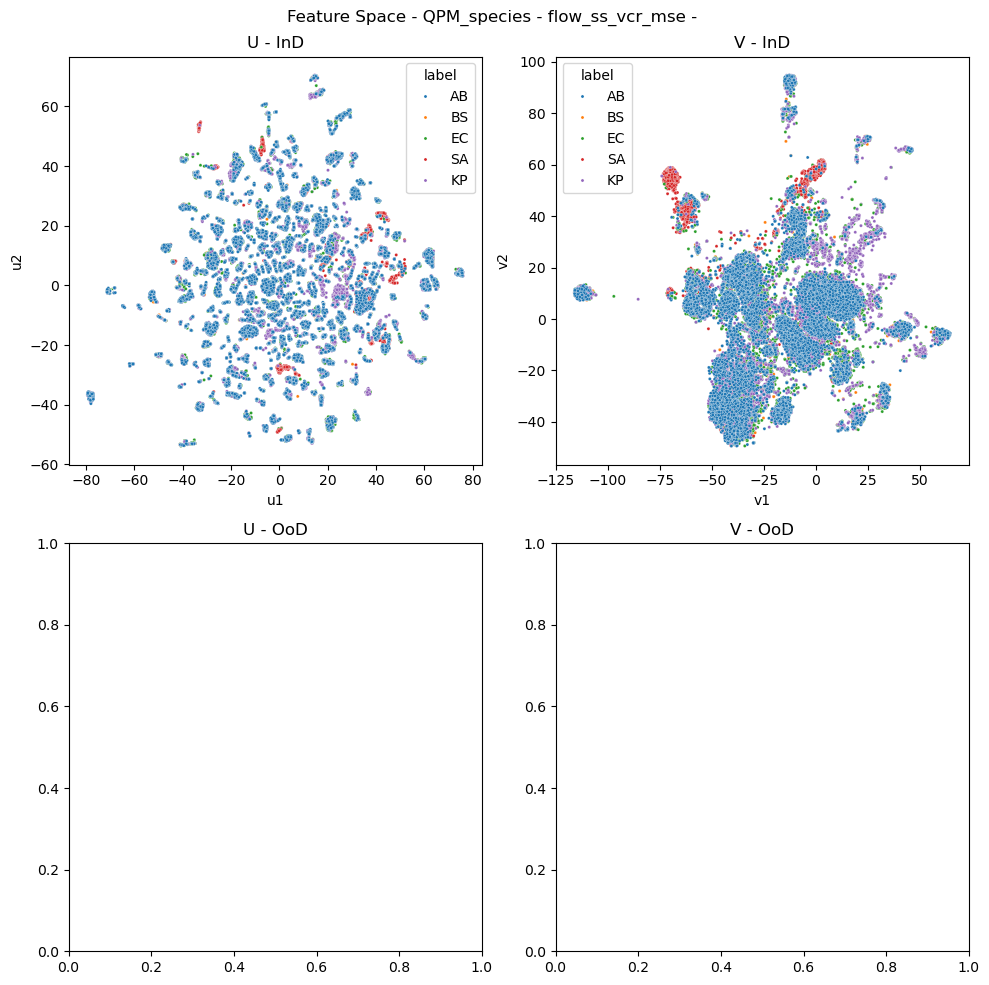

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

  0%|                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████▎                                                                                    | 1/4 [00:16<00:50, 16.74s/it]

 50%|████████████████████████████████████████████████████████▌                                                        | 2/4 [00:33<00:33, 16.69s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 3/4 [00:50<00:16, 16.69s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:07<00:00, 16.84s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:07<00:00, 16.79s/it]

  0%|                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████                                                                                    | 1/4 [01:47<05:22, 107.43s/it]

 50%|████████████████████████████████████████████████████████                                                        | 2/4 [03:35<03:35, 107.54s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████                            | 3/4 [05:22<01:47, 107.71s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [07:11<00:00, 107.88s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [07:11<00:00, 107.77s/it]

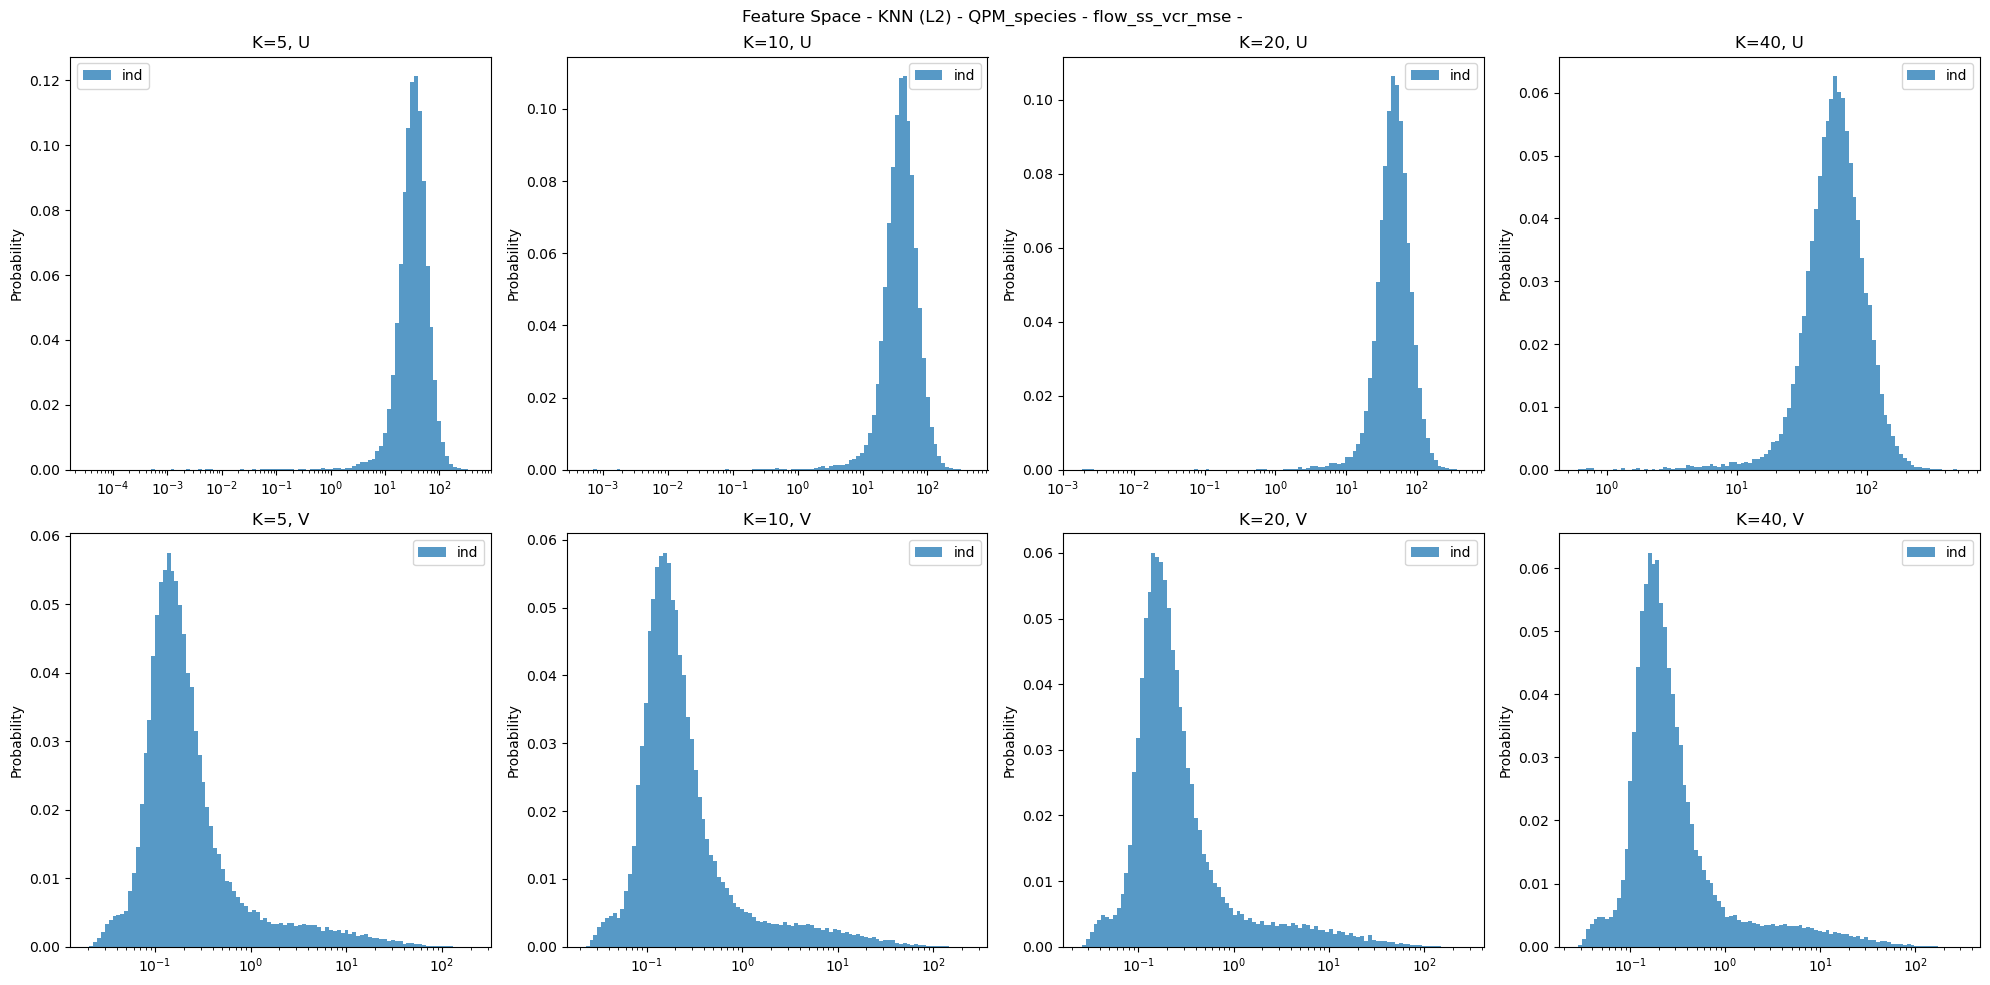

In [14]:
import faiss

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

index = faiss.IndexFlatL2(ind_e_u.shape[-1])
index.add(val_e_u)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_u, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index = faiss.IndexFlatL2(ind_e_v.shape[-1])
index.add(val_e_v)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_v, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████▎                                                                                    | 1/4 [00:16<00:48, 16.20s/it]

 50%|████████████████████████████████████████████████████████▌                                                        | 2/4 [00:32<00:32, 16.25s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 3/4 [00:48<00:16, 16.34s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:05<00:00, 16.51s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:05<00:00, 16.43s/it]

  0%|                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████                                                                                    | 1/4 [01:46<05:20, 106.90s/it]

 50%|████████████████████████████████████████████████████████                                                        | 2/4 [03:34<03:34, 107.02s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████                            | 3/4 [05:21<01:47, 107.17s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [07:09<00:00, 107.37s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [07:09<00:00, 107.26s/it]

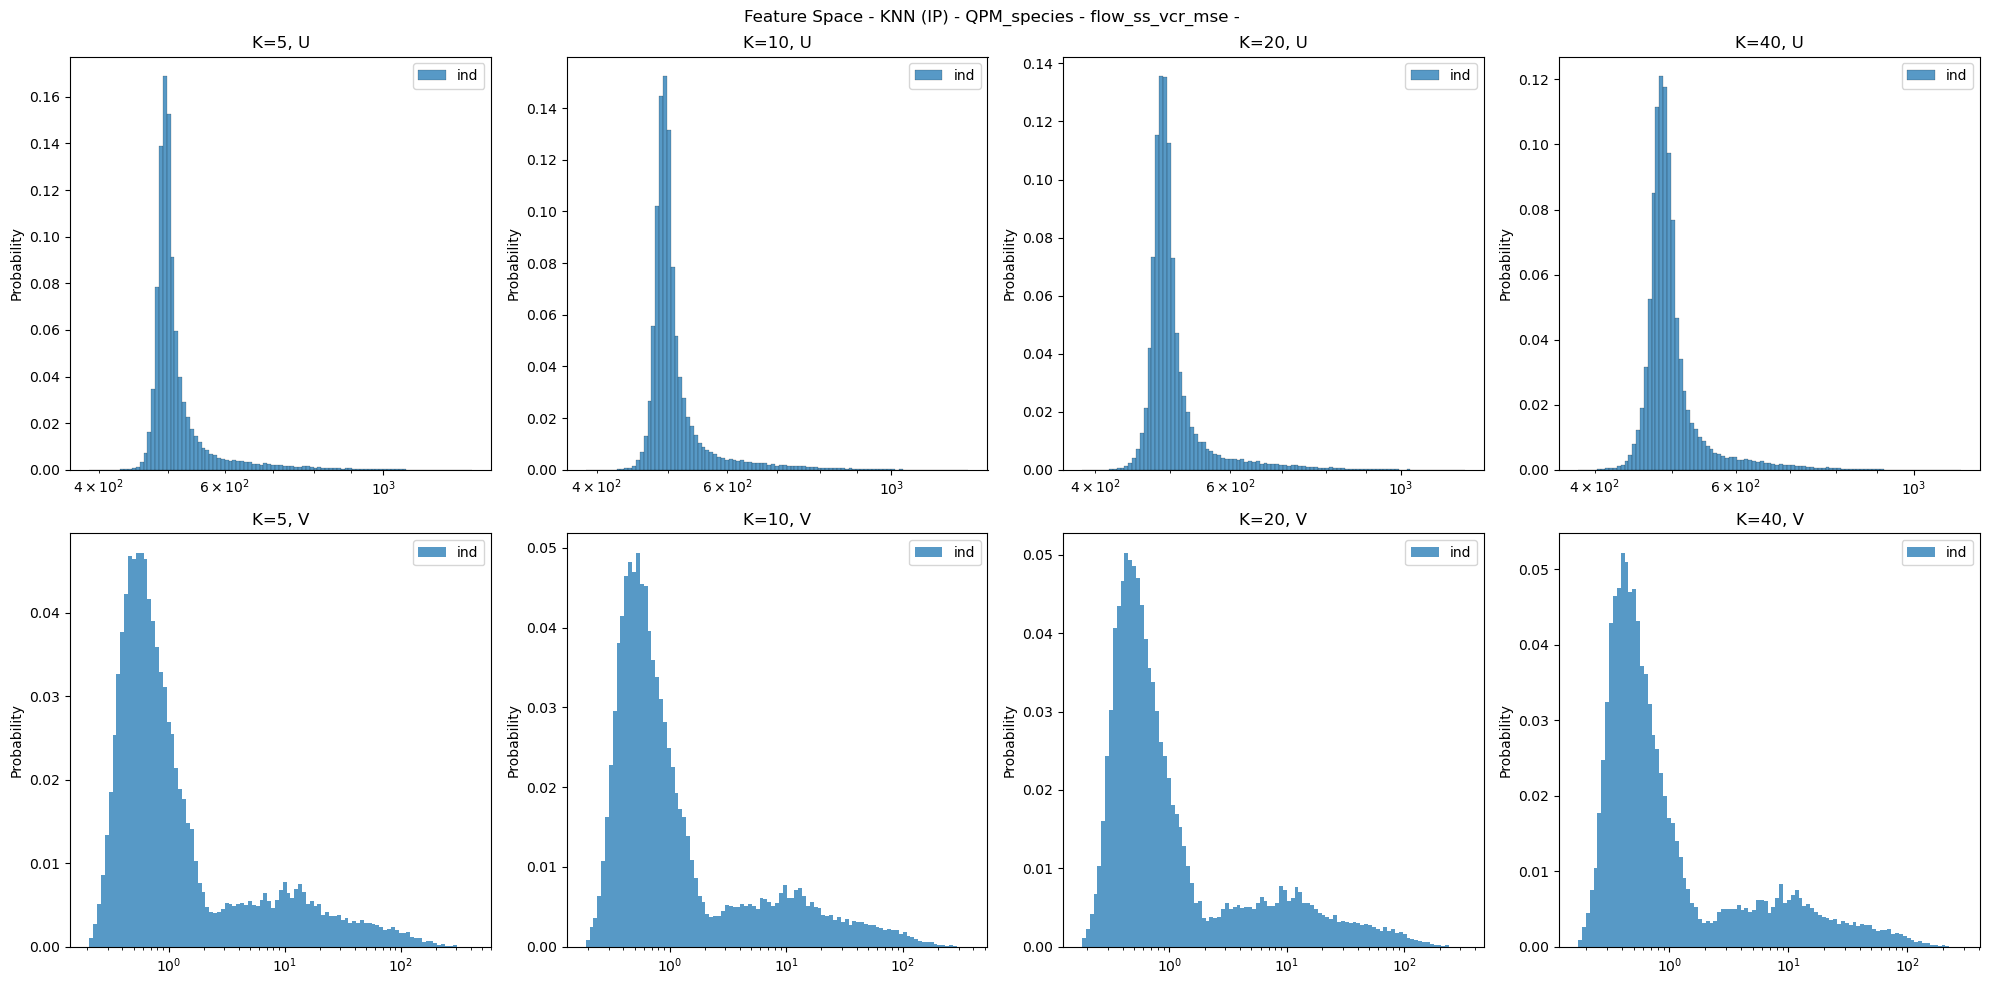

In [15]:
import faiss

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

index = faiss.IndexFlatIP(ind_e_u.shape[-1])
index.add(val_e_u)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_u, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index = faiss.IndexFlatIP(ind_e_v.shape[-1])
index.add(val_e_v)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_v, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

In [16]:
from scipy.linalg import norm

trn_n_u = norm(trn_e_u, axis=-1)
trn_n_v = norm(trn_e_v, axis=-1)
val_n_u = norm(val_e_u, axis=-1)
val_n_v = norm(val_e_v, axis=-1)
ind_n_u = norm(ind_e_u, axis=-1)
ind_n_v = norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = norm(ood_e_u, axis=-1)
    ood_n_v = norm(ood_e_v, axis=-1)
rnd_n_u = norm(rnd_e_u, axis=-1)
rnd_n_v = norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

22.946754 0.90185535 1.139885 1.3923349
22.889229 0.819715 1.0597051 1.2596576
22.995165 0.9976525 1.2165077 1.543697
36.078094 1.0400152 54.15554 0.76232606


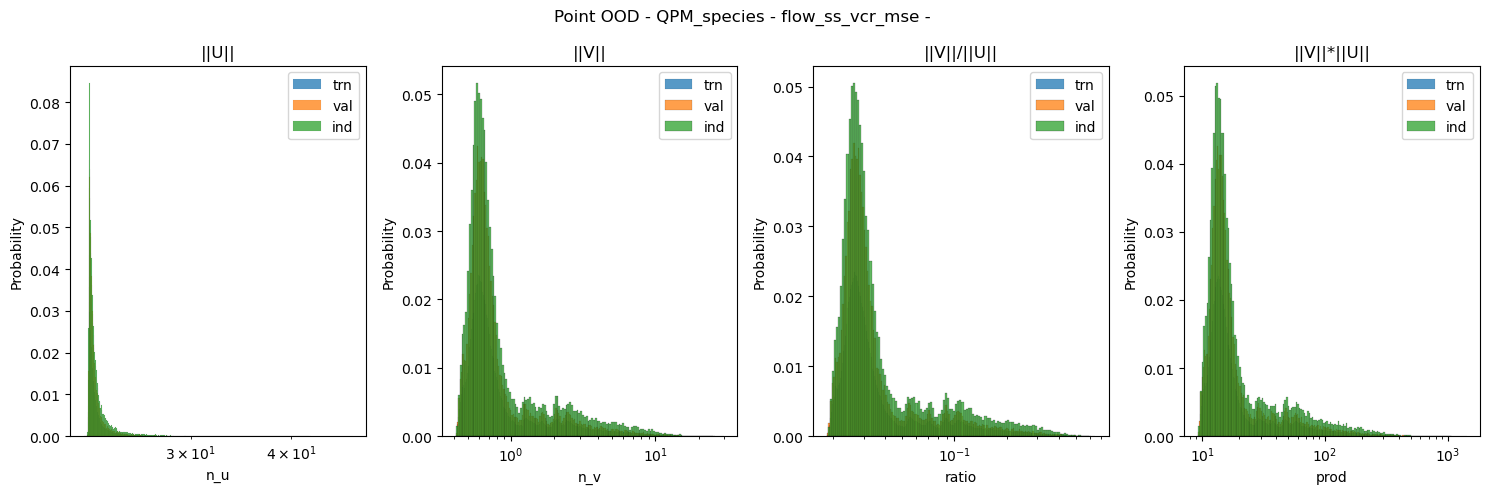

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [18]:
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


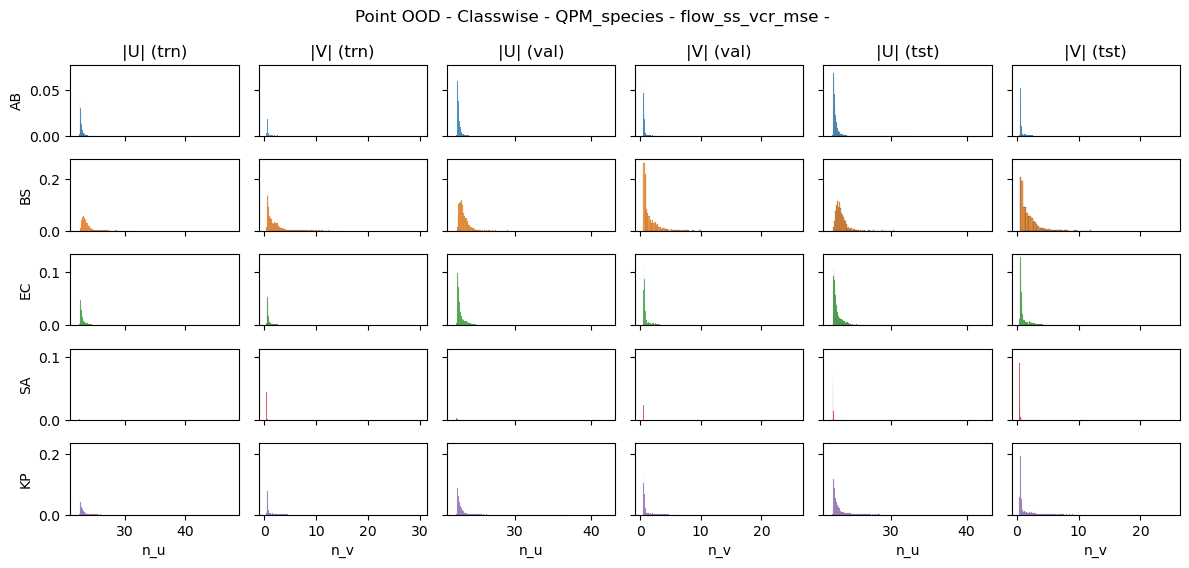

In [19]:
# pointwise
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

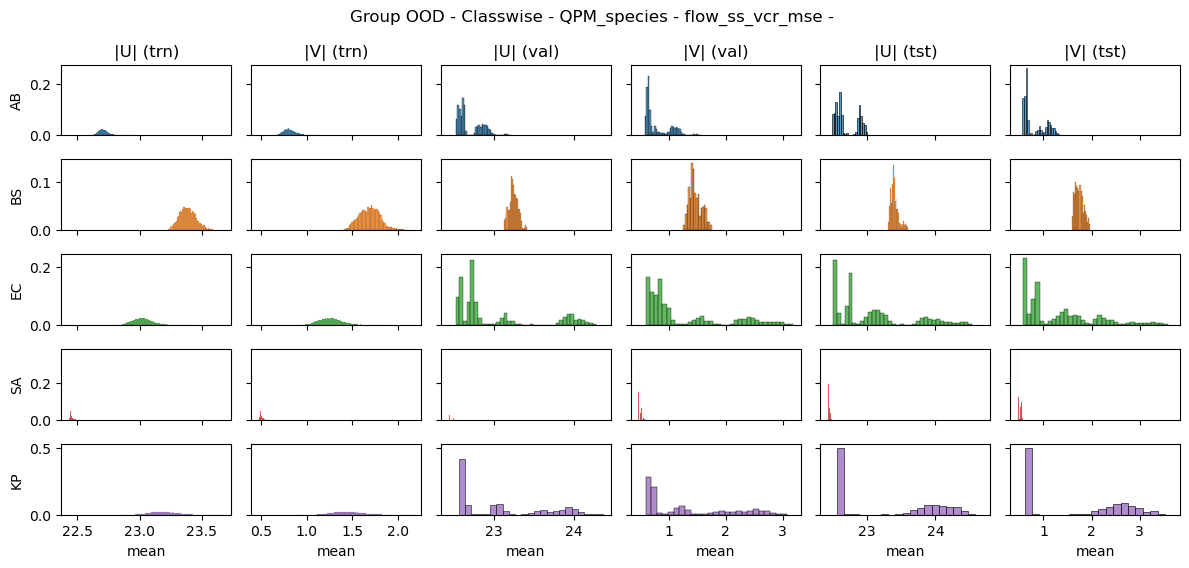

In [20]:
# groupwise
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

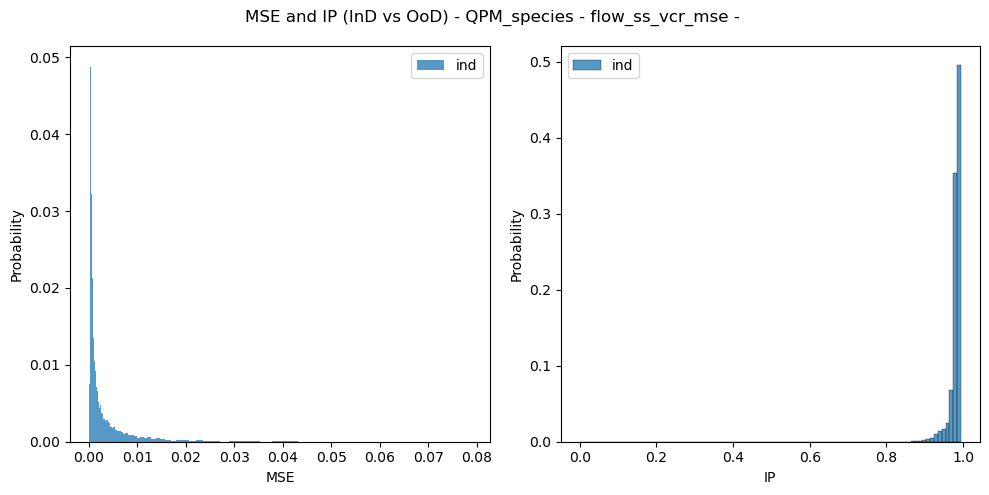

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
_ind_inp_norm = np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7
_ind_rcn_norm = np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7
ind_mse = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_ip = ((_ind_inp/_ind_inp_norm) * (_ind_rcn/_ind_rcn_norm)).sum(-1)
df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ind_tgt, mse=ind_mse, ip=ind_ip, source="ind"))], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    _ood_inp_norm = np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7
    _ood_rcn_norm = np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7
    ood_mse = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_ip = ((_ood_inp/_ood_inp_norm) * (_ood_rcn/_ood_rcn_norm)).sum(-1)
    df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ood_tgt, mse=ood_mse, ip=ood_ip, source="ood"))], ignore_index=True)
    
bins_mse = np.logspace(np.log10(df_rstat['mse'].min() + 1e-7), np.log10(df_rstat['mse'].max()), 100)
bins_ip = np.linspace(df_rstat['ip'].min(), df_rstat['ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="mse", label="ind", stat="probability", bins=bins_mse, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="ip", label="ind", stat="probability", bins=bins_ip, ax=ax2)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="mse", label="ood", stat="probability", bins=bins_mse, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="ip", label="ood", stat="probability", bins=bins_ip, ax=ax2)

ax1.legend()
ax2.legend()
ax1.set_xlabel("MSE")
ax2.set_xlabel("IP")
plt.suptitle(f"MSE and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()